In [1]:
# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
 
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# train the discriminator model
def train_discriminator(model, dataset, n_iter=10, n_batch=10):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
 
#define the size of the latent space
latent_dim = 10
#define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

2022-10-27 15:10:02.525825: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jberry/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


>1 real=60% fake=40%
>2 real=60% fake=60%
>3 real=80% fake=80%
>4 real=60% fake=100%
>5 real=60% fake=80%
>6 real=60% fake=100%
>7 real=80% fake=100%
>8 real=20% fake=100%
>9 real=60% fake=100%
>10 real=40% fake=100%


1/1 [==============================] - 0s 108ms/step


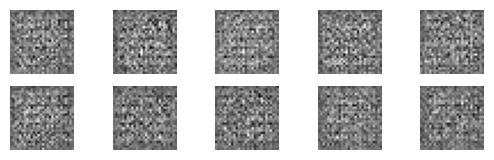

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot
# example of training a gan on mnist
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# size of the latent space

# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 10
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 28, 28, 1)         599809    
                                                                 
 sequential_2 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 640,514
Trainable params: 599,809
Non-trainable params: 40,705
_________________________________________________________________


/home/jberry/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


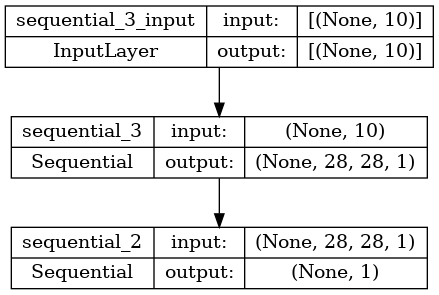

In [3]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [4]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10, n_batch=10):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
        
    
            
            # evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    

        
        # create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
    
    # evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	if epoch is None:
		epoch = 0
	else:
		print("epoch ist gesetzt") 
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=10):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

In [ ]:
# size of the latent space
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/home/jberry/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1/1 [==============================] - 0s 81ms/step
>1, 1/6000, d=0.689, g=0.737
1/1 [==============================] - 0s 26ms/step
>1, 2/6000, d=0.683, g=0.747
1/1 [==============================] - 0s 26ms/step
>1, 3/6000, d=0.669, g=0.772
1/1 [==============================] - 0s 26ms/step
>1, 4/6000, d=0.673, g=0.742
1/1 [==============================] - 0s 26ms/step
>1, 5/6000, d=0.645, g=0.785
1/1 [==============================] - 0s 26ms/step
>1, 6/6000, d=0.666, g=0.805
1/1 [==============================] - 0s 28ms/step
>1, 7/6000, d=0.671, g=0.799
1/1 [==============================] - 0s 26ms/step
>1, 8/6000, d=0.648, g=0.808
1/1 [==============================] - 0s 26ms/step
>1, 9/6000, d=0.651, g=0.830
1/1 [==============================] - 0s 26ms/step
>1, 10/6000, d=0.615, g=0.860
1/1 [==============================] - 0s 27ms/step
>1, 11/6000, d=0.635, g=0.855
1/1 [==============================] - 0s 26ms/step
>1, 12/6000, d=0.619, g=0.875
1/1 [====================

1/1 [==============================] - 0s 27ms/step
>1, 101/6000, d=0.225, g=1.143
1/1 [==============================] - 0s 25ms/step
>1, 102/6000, d=0.201, g=1.184
1/1 [==============================] - 0s 27ms/step
>1, 103/6000, d=0.198, g=1.233
1/1 [==============================] - 0s 27ms/step
>1, 104/6000, d=0.194, g=1.270
1/1 [==============================] - 0s 26ms/step
>1, 105/6000, d=0.174, g=1.306
1/1 [==============================] - 0s 27ms/step
>1, 106/6000, d=0.167, g=1.370
1/1 [==============================] - 0s 26ms/step
>1, 107/6000, d=0.171, g=1.425
1/1 [==============================] - 0s 29ms/step
>1, 108/6000, d=0.189, g=1.465
1/1 [==============================] - 0s 27ms/step
>1, 109/6000, d=0.144, g=1.497
1/1 [==============================] - 0s 27ms/step
>1, 110/6000, d=0.162, g=1.525
1/1 [==============================] - 0s 25ms/step
>1, 111/6000, d=0.160, g=1.629
1/1 [==============================] - 0s 25ms/step
>1, 112/6000, d=0.137, g=1.613
1/1 

1/1 [==============================] - 0s 26ms/step
>1, 200/6000, d=0.631, g=0.772
1/1 [==============================] - 0s 26ms/step
>1, 201/6000, d=0.661, g=0.728
1/1 [==============================] - 0s 25ms/step
>1, 202/6000, d=0.719, g=0.729
1/1 [==============================] - 0s 26ms/step
>1, 203/6000, d=0.624, g=0.716
1/1 [==============================] - 0s 30ms/step
>1, 204/6000, d=0.712, g=0.738
1/1 [==============================] - 0s 27ms/step
>1, 205/6000, d=0.600, g=0.761
1/1 [==============================] - 0s 30ms/step
>1, 206/6000, d=0.591, g=0.731
1/1 [==============================] - 0s 27ms/step
>1, 207/6000, d=0.681, g=0.716
1/1 [==============================] - 0s 28ms/step
>1, 208/6000, d=0.677, g=0.705
1/1 [==============================] - 0s 27ms/step
>1, 209/6000, d=0.569, g=0.735
1/1 [==============================] - 0s 30ms/step
>1, 210/6000, d=0.617, g=0.710
1/1 [==============================] - 0s 31ms/step
>1, 211/6000, d=0.645, g=0.815
1/1 

1/1 [==============================] - 0s 27ms/step
>1, 299/6000, d=0.676, g=0.767
1/1 [==============================] - 0s 27ms/step
>1, 300/6000, d=0.661, g=0.750
1/1 [==============================] - 0s 29ms/step
>1, 301/6000, d=0.637, g=0.772
1/1 [==============================] - 0s 26ms/step
>1, 302/6000, d=0.679, g=0.740
1/1 [==============================] - 0s 30ms/step
>1, 303/6000, d=0.581, g=0.744
1/1 [==============================] - 0s 30ms/step
>1, 304/6000, d=0.712, g=0.748
1/1 [==============================] - 0s 27ms/step
>1, 305/6000, d=0.671, g=0.777
1/1 [==============================] - 0s 27ms/step
>1, 306/6000, d=0.694, g=0.787
1/1 [==============================] - 0s 27ms/step
>1, 307/6000, d=0.628, g=0.805
1/1 [==============================] - 0s 26ms/step
>1, 308/6000, d=0.631, g=0.840
1/1 [==============================] - 0s 28ms/step
>1, 309/6000, d=0.574, g=0.806
1/1 [==============================] - 0s 30ms/step
>1, 310/6000, d=0.601, g=0.869
1/1 

1/1 [==============================] - 0s 31ms/step
>1, 398/6000, d=0.564, g=0.815
1/1 [==============================] - 0s 28ms/step
>1, 399/6000, d=0.500, g=0.827
1/1 [==============================] - 0s 28ms/step
>1, 400/6000, d=0.586, g=0.860
1/1 [==============================] - 0s 30ms/step
>1, 401/6000, d=0.560, g=0.833
1/1 [==============================] - 0s 28ms/step
>1, 402/6000, d=0.504, g=0.808
1/1 [==============================] - 0s 28ms/step
>1, 403/6000, d=0.534, g=0.835
1/1 [==============================] - 0s 28ms/step
>1, 404/6000, d=0.594, g=0.851
1/1 [==============================] - 0s 28ms/step
>1, 405/6000, d=0.484, g=0.854
1/1 [==============================] - 0s 28ms/step
>1, 406/6000, d=0.514, g=0.883
1/1 [==============================] - 0s 29ms/step
>1, 407/6000, d=0.550, g=0.852
1/1 [==============================] - 0s 30ms/step
>1, 408/6000, d=0.492, g=0.879
1/1 [==============================] - 0s 27ms/step
>1, 409/6000, d=0.549, g=0.899
1/1 

1/1 [==============================] - 0s 28ms/step
>1, 497/6000, d=0.660, g=0.782
1/1 [==============================] - 0s 26ms/step
>1, 498/6000, d=0.597, g=0.771
1/1 [==============================] - 0s 26ms/step
>1, 499/6000, d=0.614, g=0.832
1/1 [==============================] - 0s 27ms/step
>1, 500/6000, d=0.629, g=0.770
1/1 [==============================] - 0s 31ms/step
>1, 501/6000, d=0.592, g=0.763
1/1 [==============================] - 0s 27ms/step
>1, 502/6000, d=0.602, g=0.770
1/1 [==============================] - 0s 26ms/step
>1, 503/6000, d=0.657, g=0.834
1/1 [==============================] - 0s 26ms/step
>1, 504/6000, d=0.584, g=0.852
1/1 [==============================] - 0s 29ms/step
>1, 505/6000, d=0.580, g=0.789
1/1 [==============================] - 0s 26ms/step
>1, 506/6000, d=0.594, g=0.798
1/1 [==============================] - 0s 26ms/step
>1, 507/6000, d=0.596, g=0.703
1/1 [==============================] - 0s 26ms/step
>1, 508/6000, d=0.623, g=0.782
1/1 

1/1 [==============================] - 0s 26ms/step
>1, 596/6000, d=0.664, g=0.679
1/1 [==============================] - 0s 27ms/step
>1, 597/6000, d=0.649, g=0.725
1/1 [==============================] - 0s 29ms/step
>1, 598/6000, d=0.687, g=0.735
1/1 [==============================] - 0s 26ms/step
>1, 599/6000, d=0.749, g=0.754
1/1 [==============================] - 0s 28ms/step
>1, 600/6000, d=0.681, g=0.737
1/1 [==============================] - 0s 27ms/step
>1, 601/6000, d=0.669, g=0.697
1/1 [==============================] - 0s 27ms/step
>1, 602/6000, d=0.693, g=0.706
1/1 [==============================] - 0s 26ms/step
>1, 603/6000, d=0.711, g=0.681
1/1 [==============================] - 0s 28ms/step
>1, 604/6000, d=0.696, g=0.728
1/1 [==============================] - 0s 26ms/step
>1, 605/6000, d=0.735, g=0.675
1/1 [==============================] - 0s 27ms/step
>1, 606/6000, d=0.756, g=0.711
1/1 [==============================] - 0s 28ms/step
>1, 607/6000, d=0.722, g=0.696
1/1 

1/1 [==============================] - 0s 27ms/step
>1, 695/6000, d=0.662, g=0.764
1/1 [==============================] - 0s 27ms/step
>1, 696/6000, d=0.683, g=0.708
1/1 [==============================] - 0s 27ms/step
>1, 697/6000, d=0.723, g=0.721
1/1 [==============================] - 0s 26ms/step
>1, 698/6000, d=0.686, g=0.642
1/1 [==============================] - 0s 26ms/step
>1, 699/6000, d=0.700, g=0.719
1/1 [==============================] - 0s 27ms/step
>1, 700/6000, d=0.688, g=0.766
1/1 [==============================] - 0s 26ms/step
>1, 701/6000, d=0.783, g=0.733
1/1 [==============================] - 0s 28ms/step
>1, 702/6000, d=0.703, g=0.736
1/1 [==============================] - 0s 27ms/step
>1, 703/6000, d=0.740, g=0.717
1/1 [==============================] - 0s 27ms/step
>1, 704/6000, d=0.715, g=0.705
1/1 [==============================] - 0s 26ms/step
>1, 705/6000, d=0.668, g=0.778
1/1 [==============================] - 0s 27ms/step
>1, 706/6000, d=0.654, g=0.748
1/1 

1/1 [==============================] - 0s 28ms/step
>1, 794/6000, d=0.702, g=0.708
1/1 [==============================] - 0s 27ms/step
>1, 795/6000, d=0.672, g=0.711
1/1 [==============================] - 0s 27ms/step
>1, 796/6000, d=0.679, g=0.740
1/1 [==============================] - 0s 26ms/step
>1, 797/6000, d=0.634, g=0.807
1/1 [==============================] - 0s 28ms/step
>1, 798/6000, d=0.647, g=0.741
1/1 [==============================] - 0s 28ms/step
>1, 799/6000, d=0.691, g=0.722
1/1 [==============================] - 0s 26ms/step
>1, 800/6000, d=0.623, g=0.790
1/1 [==============================] - 0s 28ms/step
>1, 801/6000, d=0.684, g=0.773
1/1 [==============================] - 0s 27ms/step
>1, 802/6000, d=0.602, g=0.737
1/1 [==============================] - 0s 27ms/step
>1, 803/6000, d=0.711, g=0.718
1/1 [==============================] - 0s 26ms/step
>1, 804/6000, d=0.671, g=0.791
1/1 [==============================] - 0s 28ms/step
>1, 805/6000, d=0.716, g=0.756
1/1 

1/1 [==============================] - 0s 29ms/step
>1, 893/6000, d=0.653, g=0.677
1/1 [==============================] - 0s 30ms/step
>1, 894/6000, d=0.773, g=0.756
1/1 [==============================] - 0s 29ms/step
>1, 895/6000, d=0.684, g=0.702
1/1 [==============================] - 0s 29ms/step
>1, 896/6000, d=0.724, g=0.687
1/1 [==============================] - 0s 31ms/step
>1, 897/6000, d=0.716, g=0.693
1/1 [==============================] - 0s 28ms/step
>1, 898/6000, d=0.720, g=0.746
1/1 [==============================] - 0s 29ms/step
>1, 899/6000, d=0.695, g=0.723
1/1 [==============================] - 0s 29ms/step
>1, 900/6000, d=0.729, g=0.753
1/1 [==============================] - 0s 30ms/step
>1, 901/6000, d=0.751, g=0.673
1/1 [==============================] - 0s 29ms/step
>1, 902/6000, d=0.680, g=0.648
1/1 [==============================] - 0s 29ms/step
>1, 903/6000, d=0.761, g=0.637
1/1 [==============================] - 0s 30ms/step
>1, 904/6000, d=0.687, g=0.648
1/1 

1/1 [==============================] - 0s 26ms/step
>1, 992/6000, d=0.686, g=0.702
1/1 [==============================] - 0s 27ms/step
>1, 993/6000, d=0.765, g=0.715
1/1 [==============================] - 0s 29ms/step
>1, 994/6000, d=0.731, g=0.746
1/1 [==============================] - 0s 27ms/step
>1, 995/6000, d=0.728, g=0.766
1/1 [==============================] - 0s 28ms/step
>1, 996/6000, d=0.756, g=0.740
1/1 [==============================] - 0s 27ms/step
>1, 997/6000, d=0.673, g=0.704
1/1 [==============================] - 0s 28ms/step
>1, 998/6000, d=0.715, g=0.743
1/1 [==============================] - 0s 27ms/step
>1, 999/6000, d=0.761, g=0.743
1/1 [==============================] - 0s 26ms/step
>1, 1000/6000, d=0.742, g=0.735
1/1 [==============================] - 0s 26ms/step
>1, 1001/6000, d=0.653, g=0.685
1/1 [==============================] - 0s 26ms/step
>1, 1002/6000, d=0.675, g=0.722
1/1 [==============================] - 0s 28ms/step
>1, 1003/6000, d=0.720, g=0.732


1/1 [==============================] - 0s 26ms/step
>1, 1090/6000, d=0.697, g=0.671
1/1 [==============================] - 0s 26ms/step
>1, 1091/6000, d=0.664, g=0.730
1/1 [==============================] - 0s 26ms/step
>1, 1092/6000, d=0.732, g=0.646
1/1 [==============================] - 0s 26ms/step
>1, 1093/6000, d=0.725, g=0.713
1/1 [==============================] - 0s 27ms/step
>1, 1094/6000, d=0.660, g=0.658
1/1 [==============================] - 0s 27ms/step
>1, 1095/6000, d=0.651, g=0.702
1/1 [==============================] - 0s 27ms/step
>1, 1096/6000, d=0.678, g=0.698
1/1 [==============================] - 0s 26ms/step
>1, 1097/6000, d=0.716, g=0.671
1/1 [==============================] - 0s 27ms/step
>1, 1098/6000, d=0.698, g=0.745
1/1 [==============================] - 0s 26ms/step
>1, 1099/6000, d=0.722, g=0.736
1/1 [==============================] - 0s 26ms/step
>1, 1100/6000, d=0.726, g=0.758
1/1 [==============================] - 0s 27ms/step
>1, 1101/6000, d=0.671, 

1/1 [==============================] - 0s 28ms/step
>1, 1187/6000, d=0.657, g=0.686
1/1 [==============================] - 0s 30ms/step
>1, 1188/6000, d=0.628, g=0.654
1/1 [==============================] - 0s 27ms/step
>1, 1189/6000, d=0.675, g=0.687
1/1 [==============================] - 0s 27ms/step
>1, 1190/6000, d=0.691, g=0.663
1/1 [==============================] - 0s 27ms/step
>1, 1191/6000, d=0.691, g=0.685
1/1 [==============================] - 0s 27ms/step
>1, 1192/6000, d=0.746, g=0.696
1/1 [==============================] - 0s 26ms/step
>1, 1193/6000, d=0.702, g=0.724
1/1 [==============================] - 0s 26ms/step
>1, 1194/6000, d=0.698, g=0.650
1/1 [==============================] - 0s 26ms/step
>1, 1195/6000, d=0.627, g=0.713
1/1 [==============================] - 0s 26ms/step
>1, 1196/6000, d=0.650, g=0.730
1/1 [==============================] - 0s 26ms/step
>1, 1197/6000, d=0.658, g=0.785
1/1 [==============================] - 0s 27ms/step
>1, 1198/6000, d=0.641, 

1/1 [==============================] - 0s 28ms/step
>1, 1284/6000, d=0.714, g=0.767
1/1 [==============================] - 0s 26ms/step
>1, 1285/6000, d=0.639, g=0.752
1/1 [==============================] - 0s 29ms/step
>1, 1286/6000, d=0.704, g=0.698
1/1 [==============================] - 0s 27ms/step
>1, 1287/6000, d=0.670, g=0.723
1/1 [==============================] - 0s 27ms/step
>1, 1288/6000, d=0.718, g=0.774
1/1 [==============================] - 0s 27ms/step
>1, 1289/6000, d=0.706, g=0.705
1/1 [==============================] - 0s 27ms/step
>1, 1290/6000, d=0.660, g=0.704
1/1 [==============================] - 0s 27ms/step
>1, 1291/6000, d=0.699, g=0.748
1/1 [==============================] - 0s 26ms/step
>1, 1292/6000, d=0.648, g=0.711
1/1 [==============================] - 0s 26ms/step
>1, 1293/6000, d=0.688, g=0.703
1/1 [==============================] - 0s 27ms/step
>1, 1294/6000, d=0.704, g=0.703
1/1 [==============================] - 0s 27ms/step
>1, 1295/6000, d=0.653, 

1/1 [==============================] - 0s 26ms/step
>1, 1381/6000, d=0.691, g=0.697
1/1 [==============================] - 0s 27ms/step
>1, 1382/6000, d=0.669, g=0.715
1/1 [==============================] - 0s 29ms/step
>1, 1383/6000, d=0.702, g=0.669
1/1 [==============================] - 0s 27ms/step
>1, 1384/6000, d=0.693, g=0.687
1/1 [==============================] - 0s 26ms/step
>1, 1385/6000, d=0.697, g=0.664
1/1 [==============================] - 0s 26ms/step
>1, 1386/6000, d=0.708, g=0.653
1/1 [==============================] - 0s 28ms/step
>1, 1387/6000, d=0.703, g=0.667
1/1 [==============================] - 0s 26ms/step
>1, 1388/6000, d=0.740, g=0.715
1/1 [==============================] - 0s 26ms/step
>1, 1389/6000, d=0.693, g=0.720
1/1 [==============================] - 0s 26ms/step
>1, 1390/6000, d=0.660, g=0.664
1/1 [==============================] - 0s 27ms/step
>1, 1391/6000, d=0.707, g=0.690
1/1 [==============================] - 0s 27ms/step
>1, 1392/6000, d=0.687, 

1/1 [==============================] - 0s 27ms/step
>1, 1478/6000, d=0.682, g=0.677
1/1 [==============================] - 0s 27ms/step
>1, 1479/6000, d=0.680, g=0.708
1/1 [==============================] - 0s 26ms/step
>1, 1480/6000, d=0.703, g=0.701
1/1 [==============================] - 0s 27ms/step
>1, 1481/6000, d=0.705, g=0.634
1/1 [==============================] - 0s 26ms/step
>1, 1482/6000, d=0.649, g=0.691
1/1 [==============================] - 0s 26ms/step
>1, 1483/6000, d=0.677, g=0.676
1/1 [==============================] - 0s 27ms/step
>1, 1484/6000, d=0.681, g=0.683
1/1 [==============================] - 0s 26ms/step
>1, 1485/6000, d=0.717, g=0.676
1/1 [==============================] - 0s 26ms/step
>1, 1486/6000, d=0.716, g=0.714
1/1 [==============================] - 0s 28ms/step
>1, 1487/6000, d=0.699, g=0.711
1/1 [==============================] - 0s 27ms/step
>1, 1488/6000, d=0.711, g=0.719
1/1 [==============================] - 0s 29ms/step
>1, 1489/6000, d=0.658, 

1/1 [==============================] - 0s 27ms/step
>1, 1575/6000, d=0.687, g=0.713
1/1 [==============================] - 0s 27ms/step
>1, 1576/6000, d=0.696, g=0.687
1/1 [==============================] - 0s 26ms/step
>1, 1577/6000, d=0.689, g=0.717
1/1 [==============================] - 0s 28ms/step
>1, 1578/6000, d=0.712, g=0.725
1/1 [==============================] - 0s 26ms/step
>1, 1579/6000, d=0.700, g=0.688
1/1 [==============================] - 0s 28ms/step
>1, 1580/6000, d=0.710, g=0.711
1/1 [==============================] - 0s 26ms/step
>1, 1581/6000, d=0.651, g=0.660
1/1 [==============================] - 0s 27ms/step
>1, 1582/6000, d=0.698, g=0.674
1/1 [==============================] - 0s 27ms/step
>1, 1583/6000, d=0.649, g=0.688
1/1 [==============================] - 0s 27ms/step
>1, 1584/6000, d=0.679, g=0.717
1/1 [==============================] - 0s 28ms/step
>1, 1585/6000, d=0.657, g=0.693
1/1 [==============================] - 0s 27ms/step
>1, 1586/6000, d=0.666, 

1/1 [==============================] - 0s 29ms/step
>1, 1672/6000, d=0.708, g=0.650
1/1 [==============================] - 0s 30ms/step
>1, 1673/6000, d=0.682, g=0.669
1/1 [==============================] - 0s 29ms/step
>1, 1674/6000, d=0.700, g=0.684
1/1 [==============================] - 0s 29ms/step
>1, 1675/6000, d=0.756, g=0.712
1/1 [==============================] - 0s 30ms/step
>1, 1676/6000, d=0.684, g=0.748
1/1 [==============================] - 0s 30ms/step
>1, 1677/6000, d=0.694, g=0.756
1/1 [==============================] - 0s 31ms/step
>1, 1678/6000, d=0.718, g=0.744
1/1 [==============================] - 0s 29ms/step
>1, 1679/6000, d=0.693, g=0.710
1/1 [==============================] - 0s 29ms/step
>1, 1680/6000, d=0.685, g=0.714
1/1 [==============================] - 0s 30ms/step
>1, 1681/6000, d=0.670, g=0.712
1/1 [==============================] - 0s 29ms/step
>1, 1682/6000, d=0.702, g=0.718
1/1 [==============================] - 0s 29ms/step
>1, 1683/6000, d=0.720, 

1/1 [==============================] - 0s 28ms/step
>1, 1769/6000, d=0.664, g=0.677
1/1 [==============================] - 0s 28ms/step
>1, 1770/6000, d=0.733, g=0.672
1/1 [==============================] - 0s 27ms/step
>1, 1771/6000, d=0.696, g=0.705
1/1 [==============================] - 0s 26ms/step
>1, 1772/6000, d=0.698, g=0.720
1/1 [==============================] - 0s 28ms/step
>1, 1773/6000, d=0.721, g=0.726
1/1 [==============================] - 0s 27ms/step
>1, 1774/6000, d=0.643, g=0.719
1/1 [==============================] - 0s 27ms/step
>1, 1775/6000, d=0.691, g=0.761
1/1 [==============================] - 0s 27ms/step
>1, 1776/6000, d=0.683, g=0.775
1/1 [==============================] - 0s 29ms/step
>1, 1777/6000, d=0.696, g=0.721
1/1 [==============================] - 0s 27ms/step
>1, 1778/6000, d=0.713, g=0.680
1/1 [==============================] - 0s 26ms/step
>1, 1779/6000, d=0.714, g=0.711
1/1 [==============================] - 0s 26ms/step
>1, 1780/6000, d=0.669, 

1/1 [==============================] - 0s 27ms/step
>1, 1866/6000, d=0.727, g=0.766
1/1 [==============================] - 0s 26ms/step
>1, 1867/6000, d=0.653, g=0.737
1/1 [==============================] - 0s 26ms/step
>1, 1868/6000, d=0.704, g=0.790
1/1 [==============================] - 0s 27ms/step
>1, 1869/6000, d=0.683, g=0.699
1/1 [==============================] - 0s 28ms/step
>1, 1870/6000, d=0.682, g=0.691
1/1 [==============================] - 0s 27ms/step
>1, 1871/6000, d=0.696, g=0.701
1/1 [==============================] - 0s 26ms/step
>1, 1872/6000, d=0.705, g=0.666
1/1 [==============================] - 0s 28ms/step
>1, 1873/6000, d=0.709, g=0.654
1/1 [==============================] - 0s 27ms/step
>1, 1874/6000, d=0.698, g=0.678
1/1 [==============================] - 0s 27ms/step
>1, 1875/6000, d=0.704, g=0.674
1/1 [==============================] - 0s 27ms/step
>1, 1876/6000, d=0.731, g=0.659
1/1 [==============================] - 0s 27ms/step
>1, 1877/6000, d=0.716, 

1/1 [==============================] - 0s 28ms/step
>1, 1963/6000, d=0.730, g=0.719
1/1 [==============================] - 0s 27ms/step
>1, 1964/6000, d=0.689, g=0.676
1/1 [==============================] - 0s 27ms/step
>1, 1965/6000, d=0.678, g=0.713
1/1 [==============================] - 0s 27ms/step
>1, 1966/6000, d=0.708, g=0.704
1/1 [==============================] - 0s 29ms/step
>1, 1967/6000, d=0.694, g=0.717
1/1 [==============================] - 0s 27ms/step
>1, 1968/6000, d=0.706, g=0.702
1/1 [==============================] - 0s 27ms/step
>1, 1969/6000, d=0.688, g=0.678
1/1 [==============================] - 0s 28ms/step
>1, 1970/6000, d=0.726, g=0.669
1/1 [==============================] - 0s 29ms/step
>1, 1971/6000, d=0.728, g=0.744
1/1 [==============================] - 0s 27ms/step
>1, 1972/6000, d=0.682, g=0.722
1/1 [==============================] - 0s 28ms/step
>1, 1973/6000, d=0.702, g=0.759
1/1 [==============================] - 0s 26ms/step
>1, 1974/6000, d=0.679, 

1/1 [==============================] - 0s 27ms/step
>1, 2060/6000, d=0.684, g=0.844
1/1 [==============================] - 0s 28ms/step
>1, 2061/6000, d=0.664, g=0.810
1/1 [==============================] - 0s 27ms/step
>1, 2062/6000, d=0.670, g=0.788
1/1 [==============================] - 0s 26ms/step
>1, 2063/6000, d=0.694, g=0.816
1/1 [==============================] - 0s 26ms/step
>1, 2064/6000, d=0.677, g=0.796
1/1 [==============================] - 0s 28ms/step
>1, 2065/6000, d=0.682, g=0.758
1/1 [==============================] - 0s 26ms/step
>1, 2066/6000, d=0.673, g=0.767
1/1 [==============================] - 0s 27ms/step
>1, 2067/6000, d=0.649, g=0.735
1/1 [==============================] - 0s 27ms/step
>1, 2068/6000, d=0.637, g=0.756
1/1 [==============================] - 0s 28ms/step
>1, 2069/6000, d=0.622, g=0.698
1/1 [==============================] - 0s 28ms/step
>1, 2070/6000, d=0.641, g=0.744
1/1 [==============================] - 0s 27ms/step
>1, 2071/6000, d=0.644, 

1/1 [==============================] - 0s 27ms/step
>1, 2157/6000, d=0.692, g=0.764
1/1 [==============================] - 0s 27ms/step
>1, 2158/6000, d=0.725, g=0.743
1/1 [==============================] - 0s 27ms/step
>1, 2159/6000, d=0.720, g=0.738
1/1 [==============================] - 0s 29ms/step
>1, 2160/6000, d=0.731, g=0.702
1/1 [==============================] - 0s 28ms/step
>1, 2161/6000, d=0.718, g=0.694
1/1 [==============================] - 0s 26ms/step
>1, 2162/6000, d=0.746, g=0.692
1/1 [==============================] - 0s 26ms/step
>1, 2163/6000, d=0.749, g=0.673
1/1 [==============================] - 0s 26ms/step
>1, 2164/6000, d=0.728, g=0.700
1/1 [==============================] - 0s 26ms/step
>1, 2165/6000, d=0.719, g=0.681
1/1 [==============================] - 0s 26ms/step
>1, 2166/6000, d=0.727, g=0.655
1/1 [==============================] - 0s 27ms/step
>1, 2167/6000, d=0.783, g=0.661
1/1 [==============================] - 0s 27ms/step
>1, 2168/6000, d=0.750, 

1/1 [==============================] - 0s 27ms/step
>1, 2254/6000, d=0.661, g=0.695
1/1 [==============================] - 0s 27ms/step
>1, 2255/6000, d=0.674, g=0.722
1/1 [==============================] - 0s 26ms/step
>1, 2256/6000, d=0.694, g=0.689
1/1 [==============================] - 0s 26ms/step
>1, 2257/6000, d=0.670, g=0.703
1/1 [==============================] - 0s 27ms/step
>1, 2258/6000, d=0.667, g=0.688
1/1 [==============================] - 0s 27ms/step
>1, 2259/6000, d=0.718, g=0.690
1/1 [==============================] - 0s 27ms/step
>1, 2260/6000, d=0.667, g=0.725
1/1 [==============================] - 0s 26ms/step
>1, 2261/6000, d=0.682, g=0.688
1/1 [==============================] - 0s 28ms/step
>1, 2262/6000, d=0.685, g=0.721
1/1 [==============================] - 0s 27ms/step
>1, 2263/6000, d=0.662, g=0.736
1/1 [==============================] - 0s 27ms/step
>1, 2264/6000, d=0.685, g=0.755
1/1 [==============================] - 0s 27ms/step
>1, 2265/6000, d=0.673, 

1/1 [==============================] - 0s 27ms/step
>1, 2351/6000, d=0.659, g=0.690
1/1 [==============================] - 0s 27ms/step
>1, 2352/6000, d=0.678, g=0.678
1/1 [==============================] - 0s 27ms/step
>1, 2353/6000, d=0.691, g=0.673
1/1 [==============================] - 0s 27ms/step
>1, 2354/6000, d=0.712, g=0.686
1/1 [==============================] - 0s 28ms/step
>1, 2355/6000, d=0.728, g=0.706
1/1 [==============================] - 0s 26ms/step
>1, 2356/6000, d=0.666, g=0.732
1/1 [==============================] - 0s 26ms/step
>1, 2357/6000, d=0.684, g=0.714
1/1 [==============================] - 0s 28ms/step
>1, 2358/6000, d=0.658, g=0.706
1/1 [==============================] - 0s 27ms/step
>1, 2359/6000, d=0.656, g=0.656
1/1 [==============================] - 0s 27ms/step
>1, 2360/6000, d=0.707, g=0.749
1/1 [==============================] - 0s 27ms/step
>1, 2361/6000, d=0.680, g=0.744
1/1 [==============================] - 0s 26ms/step
>1, 2362/6000, d=0.681, 

1/1 [==============================] - 0s 31ms/step
>1, 2448/6000, d=0.691, g=0.686
1/1 [==============================] - 0s 31ms/step
>1, 2449/6000, d=0.685, g=0.682
1/1 [==============================] - 0s 30ms/step
>1, 2450/6000, d=0.703, g=0.630
1/1 [==============================] - 0s 29ms/step
>1, 2451/6000, d=0.695, g=0.715
1/1 [==============================] - 0s 30ms/step
>1, 2452/6000, d=0.686, g=0.685
1/1 [==============================] - 0s 30ms/step
>1, 2453/6000, d=0.663, g=0.714
1/1 [==============================] - 0s 30ms/step
>1, 2454/6000, d=0.688, g=0.716
1/1 [==============================] - 0s 30ms/step
>1, 2455/6000, d=0.721, g=0.733
1/1 [==============================] - 0s 29ms/step
>1, 2456/6000, d=0.692, g=0.715
1/1 [==============================] - 0s 29ms/step
>1, 2457/6000, d=0.697, g=0.748
1/1 [==============================] - 0s 31ms/step
>1, 2458/6000, d=0.715, g=0.753
1/1 [==============================] - 0s 29ms/step
>1, 2459/6000, d=0.678, 

1/1 [==============================] - 0s 27ms/step
>1, 2545/6000, d=0.683, g=0.685
1/1 [==============================] - 0s 26ms/step
>1, 2546/6000, d=0.717, g=0.748
1/1 [==============================] - 0s 27ms/step
>1, 2547/6000, d=0.698, g=0.689
1/1 [==============================] - 0s 29ms/step
>1, 2548/6000, d=0.685, g=0.703
1/1 [==============================] - 0s 29ms/step
>1, 2549/6000, d=0.724, g=0.718
1/1 [==============================] - 0s 28ms/step
>1, 2550/6000, d=0.639, g=0.682
1/1 [==============================] - 0s 27ms/step
>1, 2551/6000, d=0.678, g=0.705
1/1 [==============================] - 0s 26ms/step
>1, 2552/6000, d=0.707, g=0.693
1/1 [==============================] - 0s 26ms/step
>1, 2553/6000, d=0.731, g=0.719
1/1 [==============================] - 0s 26ms/step
>1, 2554/6000, d=0.677, g=0.680
1/1 [==============================] - 0s 26ms/step
>1, 2555/6000, d=0.704, g=0.687
1/1 [==============================] - 0s 28ms/step
>1, 2556/6000, d=0.686, 

1/1 [==============================] - 0s 28ms/step
>1, 2642/6000, d=0.673, g=0.695
1/1 [==============================] - 0s 26ms/step
>1, 2643/6000, d=0.671, g=0.722
1/1 [==============================] - 0s 27ms/step
>1, 2644/6000, d=0.706, g=0.705
1/1 [==============================] - 0s 27ms/step
>1, 2645/6000, d=0.702, g=0.731
1/1 [==============================] - 0s 27ms/step
>1, 2646/6000, d=0.698, g=0.701
1/1 [==============================] - 0s 27ms/step
>1, 2647/6000, d=0.693, g=0.703
1/1 [==============================] - 0s 26ms/step
>1, 2648/6000, d=0.670, g=0.742
1/1 [==============================] - 0s 26ms/step
>1, 2649/6000, d=0.671, g=0.754
1/1 [==============================] - 0s 26ms/step
>1, 2650/6000, d=0.720, g=0.732
1/1 [==============================] - 0s 26ms/step
>1, 2651/6000, d=0.691, g=0.750
1/1 [==============================] - 0s 28ms/step
>1, 2652/6000, d=0.713, g=0.738
1/1 [==============================] - 0s 27ms/step
>1, 2653/6000, d=0.695, 

1/1 [==============================] - 0s 28ms/step
>1, 2739/6000, d=0.672, g=0.697
1/1 [==============================] - 0s 27ms/step
>1, 2740/6000, d=0.739, g=0.711
1/1 [==============================] - 0s 28ms/step
>1, 2741/6000, d=0.674, g=0.658
1/1 [==============================] - 0s 28ms/step
>1, 2742/6000, d=0.674, g=0.688
1/1 [==============================] - 0s 26ms/step
>1, 2743/6000, d=0.690, g=0.700
1/1 [==============================] - 0s 26ms/step
>1, 2744/6000, d=0.669, g=0.688
1/1 [==============================] - 0s 27ms/step
>1, 2745/6000, d=0.689, g=0.685
1/1 [==============================] - 0s 26ms/step
>1, 2746/6000, d=0.725, g=0.644
1/1 [==============================] - 0s 26ms/step
>1, 2747/6000, d=0.700, g=0.711
1/1 [==============================] - 0s 26ms/step
>1, 2748/6000, d=0.706, g=0.670
1/1 [==============================] - 0s 27ms/step
>1, 2749/6000, d=0.713, g=0.657
1/1 [==============================] - 0s 27ms/step
>1, 2750/6000, d=0.707, 

1/1 [==============================] - 0s 27ms/step
>1, 2836/6000, d=0.694, g=0.710
1/1 [==============================] - 0s 28ms/step
>1, 2837/6000, d=0.646, g=0.708
1/1 [==============================] - 0s 27ms/step
>1, 2838/6000, d=0.695, g=0.691
1/1 [==============================] - 0s 27ms/step
>1, 2839/6000, d=0.701, g=0.695
1/1 [==============================] - 0s 27ms/step
>1, 2840/6000, d=0.665, g=0.721
1/1 [==============================] - 0s 27ms/step
>1, 2841/6000, d=0.686, g=0.713
1/1 [==============================] - 0s 27ms/step
>1, 2842/6000, d=0.699, g=0.670
1/1 [==============================] - 0s 28ms/step
>1, 2843/6000, d=0.677, g=0.714
1/1 [==============================] - 0s 26ms/step
>1, 2844/6000, d=0.711, g=0.688
1/1 [==============================] - 0s 26ms/step
>1, 2845/6000, d=0.659, g=0.707
1/1 [==============================] - 0s 27ms/step
>1, 2846/6000, d=0.679, g=0.733
1/1 [==============================] - 0s 27ms/step
>1, 2847/6000, d=0.688, 

1/1 [==============================] - 0s 29ms/step
>1, 2933/6000, d=0.696, g=0.702
1/1 [==============================] - 0s 27ms/step
>1, 2934/6000, d=0.686, g=0.709
1/1 [==============================] - 0s 26ms/step
>1, 2935/6000, d=0.666, g=0.689
1/1 [==============================] - 0s 28ms/step
>1, 2936/6000, d=0.672, g=0.700
1/1 [==============================] - 0s 27ms/step
>1, 2937/6000, d=0.684, g=0.724
1/1 [==============================] - 0s 27ms/step
>1, 2938/6000, d=0.689, g=0.674
1/1 [==============================] - 0s 27ms/step
>1, 2939/6000, d=0.677, g=0.683
1/1 [==============================] - 0s 28ms/step
>1, 2940/6000, d=0.678, g=0.663
1/1 [==============================] - 0s 28ms/step
>1, 2941/6000, d=0.719, g=0.668
1/1 [==============================] - 0s 27ms/step
>1, 2942/6000, d=0.693, g=0.697
1/1 [==============================] - 0s 28ms/step
>1, 2943/6000, d=0.661, g=0.740
1/1 [==============================] - 0s 27ms/step
>1, 2944/6000, d=0.691, 

1/1 [==============================] - 0s 28ms/step
>1, 3030/6000, d=0.707, g=0.650
1/1 [==============================] - 0s 28ms/step
>1, 3031/6000, d=0.725, g=0.666
1/1 [==============================] - 0s 26ms/step
>1, 3032/6000, d=0.720, g=0.674
1/1 [==============================] - 0s 27ms/step
>1, 3033/6000, d=0.690, g=0.661
1/1 [==============================] - 0s 27ms/step
>1, 3034/6000, d=0.709, g=0.665
1/1 [==============================] - 0s 26ms/step
>1, 3035/6000, d=0.694, g=0.655
1/1 [==============================] - 0s 28ms/step
>1, 3036/6000, d=0.702, g=0.663
1/1 [==============================] - 0s 27ms/step
>1, 3037/6000, d=0.662, g=0.668
1/1 [==============================] - 0s 29ms/step
>1, 3038/6000, d=0.668, g=0.634
1/1 [==============================] - 0s 28ms/step
>1, 3039/6000, d=0.685, g=0.678
1/1 [==============================] - 0s 29ms/step
>1, 3040/6000, d=0.653, g=0.685
1/1 [==============================] - 0s 26ms/step
>1, 3041/6000, d=0.736, 

1/1 [==============================] - 0s 26ms/step
>1, 3127/6000, d=0.672, g=0.727
1/1 [==============================] - 0s 28ms/step
>1, 3128/6000, d=0.716, g=0.736
1/1 [==============================] - 0s 26ms/step
>1, 3129/6000, d=0.680, g=0.674
1/1 [==============================] - 0s 27ms/step
>1, 3130/6000, d=0.720, g=0.686
1/1 [==============================] - 0s 28ms/step
>1, 3131/6000, d=0.668, g=0.698
1/1 [==============================] - 0s 27ms/step
>1, 3132/6000, d=0.705, g=0.691
1/1 [==============================] - 0s 28ms/step
>1, 3133/6000, d=0.697, g=0.715
1/1 [==============================] - 0s 27ms/step
>1, 3134/6000, d=0.704, g=0.742
1/1 [==============================] - 0s 27ms/step
>1, 3135/6000, d=0.719, g=0.693
1/1 [==============================] - 0s 27ms/step
>1, 3136/6000, d=0.660, g=0.648
1/1 [==============================] - 0s 27ms/step
>1, 3137/6000, d=0.692, g=0.745
1/1 [==============================] - 0s 27ms/step
>1, 3138/6000, d=0.725, 

1/1 [==============================] - 0s 34ms/step
>1, 3224/6000, d=0.695, g=0.689
1/1 [==============================] - 0s 31ms/step
>1, 3225/6000, d=0.686, g=0.689
1/1 [==============================] - 0s 30ms/step
>1, 3226/6000, d=0.666, g=0.689
1/1 [==============================] - 0s 33ms/step
>1, 3227/6000, d=0.676, g=0.702
1/1 [==============================] - 0s 31ms/step
>1, 3228/6000, d=0.713, g=0.715
1/1 [==============================] - 0s 33ms/step
>1, 3229/6000, d=0.700, g=0.681
1/1 [==============================] - 0s 31ms/step
>1, 3230/6000, d=0.667, g=0.706
1/1 [==============================] - 0s 31ms/step
>1, 3231/6000, d=0.687, g=0.710
1/1 [==============================] - 0s 31ms/step
>1, 3232/6000, d=0.706, g=0.736
1/1 [==============================] - 0s 30ms/step
>1, 3233/6000, d=0.690, g=0.695
1/1 [==============================] - 0s 30ms/step
>1, 3234/6000, d=0.698, g=0.794
1/1 [==============================] - 0s 31ms/step
>1, 3235/6000, d=0.663, 

1/1 [==============================] - 0s 27ms/step
>1, 3321/6000, d=0.689, g=0.745
1/1 [==============================] - 0s 28ms/step
>1, 3322/6000, d=0.725, g=0.755
1/1 [==============================] - 0s 27ms/step
>1, 3323/6000, d=0.692, g=0.752
1/1 [==============================] - 0s 28ms/step
>1, 3324/6000, d=0.669, g=0.788
1/1 [==============================] - 0s 28ms/step
>1, 3325/6000, d=0.713, g=0.807
1/1 [==============================] - 0s 28ms/step
>1, 3326/6000, d=0.689, g=0.841
1/1 [==============================] - 0s 27ms/step
>1, 3327/6000, d=0.695, g=0.822
1/1 [==============================] - 0s 27ms/step
>1, 3328/6000, d=0.709, g=0.743
1/1 [==============================] - 0s 26ms/step
>1, 3329/6000, d=0.675, g=0.765
1/1 [==============================] - 0s 27ms/step
>1, 3330/6000, d=0.710, g=0.771
1/1 [==============================] - 0s 29ms/step
>1, 3331/6000, d=0.712, g=0.710
1/1 [==============================] - 0s 28ms/step
>1, 3332/6000, d=0.716, 

1/1 [==============================] - 0s 27ms/step
>1, 3418/6000, d=0.705, g=0.691
1/1 [==============================] - 0s 27ms/step
>1, 3419/6000, d=0.701, g=0.700
1/1 [==============================] - 0s 27ms/step
>1, 3420/6000, d=0.676, g=0.699
1/1 [==============================] - 0s 29ms/step
>1, 3421/6000, d=0.683, g=0.732
1/1 [==============================] - 0s 27ms/step
>1, 3422/6000, d=0.687, g=0.715
1/1 [==============================] - 0s 27ms/step
>1, 3423/6000, d=0.664, g=0.733
1/1 [==============================] - 0s 30ms/step
>1, 3424/6000, d=0.688, g=0.712
1/1 [==============================] - 0s 28ms/step
>1, 3425/6000, d=0.700, g=0.707
1/1 [==============================] - 0s 27ms/step
>1, 3426/6000, d=0.687, g=0.701
1/1 [==============================] - 0s 26ms/step
>1, 3427/6000, d=0.668, g=0.706
1/1 [==============================] - 0s 26ms/step
>1, 3428/6000, d=0.688, g=0.689
1/1 [==============================] - 0s 26ms/step
>1, 3429/6000, d=0.641, 

1/1 [==============================] - 0s 27ms/step
>1, 3515/6000, d=0.721, g=0.700
1/1 [==============================] - 0s 27ms/step
>1, 3516/6000, d=0.707, g=0.685
1/1 [==============================] - 0s 27ms/step
>1, 3517/6000, d=0.697, g=0.747
1/1 [==============================] - 0s 28ms/step
>1, 3518/6000, d=0.686, g=0.736
1/1 [==============================] - 0s 28ms/step
>1, 3519/6000, d=0.698, g=0.724
1/1 [==============================] - 0s 27ms/step
>1, 3520/6000, d=0.695, g=0.805
1/1 [==============================] - 0s 27ms/step
>1, 3521/6000, d=0.656, g=0.750
1/1 [==============================] - 0s 27ms/step
>1, 3522/6000, d=0.682, g=0.776
1/1 [==============================] - 0s 27ms/step
>1, 3523/6000, d=0.702, g=0.753
1/1 [==============================] - 0s 27ms/step
>1, 3524/6000, d=0.672, g=0.722
1/1 [==============================] - 0s 27ms/step
>1, 3525/6000, d=0.719, g=0.706
1/1 [==============================] - 0s 28ms/step
>1, 3526/6000, d=0.694, 

1/1 [==============================] - 0s 26ms/step
>1, 3612/6000, d=0.708, g=0.671
1/1 [==============================] - 0s 27ms/step
>1, 3613/6000, d=0.701, g=0.660
1/1 [==============================] - 0s 27ms/step
>1, 3614/6000, d=0.699, g=0.697
1/1 [==============================] - 0s 29ms/step
>1, 3615/6000, d=0.702, g=0.697
1/1 [==============================] - 0s 26ms/step
>1, 3616/6000, d=0.697, g=0.794
1/1 [==============================] - 0s 27ms/step
>1, 3617/6000, d=0.642, g=0.709
1/1 [==============================] - 0s 27ms/step
>1, 3618/6000, d=0.695, g=0.764
1/1 [==============================] - 0s 28ms/step
>1, 3619/6000, d=0.679, g=0.770
1/1 [==============================] - 0s 27ms/step
>1, 3620/6000, d=0.663, g=0.735
1/1 [==============================] - 0s 28ms/step
>1, 3621/6000, d=0.693, g=0.789
1/1 [==============================] - 0s 29ms/step
>1, 3622/6000, d=0.630, g=0.799
1/1 [==============================] - 0s 29ms/step
>1, 3623/6000, d=0.721, 

1/1 [==============================] - 0s 27ms/step
>1, 3709/6000, d=0.695, g=0.718
1/1 [==============================] - 0s 27ms/step
>1, 3710/6000, d=0.666, g=0.683
1/1 [==============================] - 0s 26ms/step
>1, 3711/6000, d=0.644, g=0.735
1/1 [==============================] - 0s 26ms/step
>1, 3712/6000, d=0.696, g=0.671
1/1 [==============================] - 0s 26ms/step
>1, 3713/6000, d=0.711, g=0.705
1/1 [==============================] - 0s 26ms/step
>1, 3714/6000, d=0.669, g=0.705
1/1 [==============================] - 0s 26ms/step
>1, 3715/6000, d=0.698, g=0.682
1/1 [==============================] - 0s 27ms/step
>1, 3716/6000, d=0.701, g=0.684
1/1 [==============================] - 0s 27ms/step
>1, 3717/6000, d=0.679, g=0.724
1/1 [==============================] - 0s 27ms/step
>1, 3718/6000, d=0.713, g=0.727
1/1 [==============================] - 0s 27ms/step
>1, 3719/6000, d=0.725, g=0.742
1/1 [==============================] - 0s 27ms/step
>1, 3720/6000, d=0.707, 

1/1 [==============================] - 0s 27ms/step
>1, 3806/6000, d=0.699, g=0.711
1/1 [==============================] - 0s 29ms/step
>1, 3807/6000, d=0.663, g=0.741
1/1 [==============================] - 0s 27ms/step
>1, 3808/6000, d=0.694, g=0.713
1/1 [==============================] - 0s 28ms/step
>1, 3809/6000, d=0.657, g=0.757
1/1 [==============================] - 0s 27ms/step
>1, 3810/6000, d=0.670, g=0.767
1/1 [==============================] - 0s 28ms/step
>1, 3811/6000, d=0.654, g=0.738
1/1 [==============================] - 0s 27ms/step
>1, 3812/6000, d=0.669, g=0.740
1/1 [==============================] - 0s 27ms/step
>1, 3813/6000, d=0.660, g=0.737
1/1 [==============================] - 0s 28ms/step
>1, 3814/6000, d=0.689, g=0.731
1/1 [==============================] - 0s 27ms/step
>1, 3815/6000, d=0.679, g=0.711
1/1 [==============================] - 0s 26ms/step
>1, 3816/6000, d=0.640, g=0.762
1/1 [==============================] - 0s 26ms/step
>1, 3817/6000, d=0.693, 

1/1 [==============================] - 0s 28ms/step
>1, 3903/6000, d=0.689, g=0.692
1/1 [==============================] - 0s 26ms/step
>1, 3904/6000, d=0.685, g=0.698
1/1 [==============================] - 0s 28ms/step
>1, 3905/6000, d=0.691, g=0.700
1/1 [==============================] - 0s 27ms/step
>1, 3906/6000, d=0.703, g=0.714
1/1 [==============================] - 0s 26ms/step
>1, 3907/6000, d=0.680, g=0.681
1/1 [==============================] - 0s 28ms/step
>1, 3908/6000, d=0.691, g=0.663
1/1 [==============================] - 0s 27ms/step
>1, 3909/6000, d=0.663, g=0.694
1/1 [==============================] - 0s 27ms/step
>1, 3910/6000, d=0.668, g=0.688
1/1 [==============================] - 0s 29ms/step
>1, 3911/6000, d=0.680, g=0.693
1/1 [==============================] - 0s 26ms/step
>1, 3912/6000, d=0.681, g=0.680
1/1 [==============================] - 0s 26ms/step
>1, 3913/6000, d=0.656, g=0.675
1/1 [==============================] - 0s 27ms/step
>1, 3914/6000, d=0.696, 

1/1 [==============================] - 0s 33ms/step
>1, 4000/6000, d=0.674, g=0.752
1/1 [==============================] - 0s 34ms/step
>1, 4001/6000, d=0.666, g=0.755
1/1 [==============================] - 0s 33ms/step
>1, 4002/6000, d=0.629, g=0.726
1/1 [==============================] - 0s 37ms/step
>1, 4003/6000, d=0.692, g=0.722
1/1 [==============================] - 0s 33ms/step
>1, 4004/6000, d=0.699, g=0.787
1/1 [==============================] - 0s 33ms/step
>1, 4005/6000, d=0.641, g=0.735
1/1 [==============================] - 0s 35ms/step
>1, 4006/6000, d=0.642, g=0.801
1/1 [==============================] - 0s 35ms/step
>1, 4007/6000, d=0.702, g=0.686
1/1 [==============================] - 0s 34ms/step
>1, 4008/6000, d=0.691, g=0.696
1/1 [==============================] - 0s 31ms/step
>1, 4009/6000, d=0.736, g=0.704
1/1 [==============================] - 0s 30ms/step
>1, 4010/6000, d=0.706, g=0.702
1/1 [==============================] - 0s 30ms/step
>1, 4011/6000, d=0.658, 

1/1 [==============================] - 0s 27ms/step
>1, 4097/6000, d=0.682, g=0.739
1/1 [==============================] - 0s 29ms/step
>1, 4098/6000, d=0.682, g=0.790
1/1 [==============================] - 0s 28ms/step
>1, 4099/6000, d=0.685, g=0.732
1/1 [==============================] - 0s 28ms/step
>1, 4100/6000, d=0.663, g=0.713
1/1 [==============================] - 0s 30ms/step
>1, 4101/6000, d=0.710, g=0.710
1/1 [==============================] - 0s 28ms/step
>1, 4102/6000, d=0.721, g=0.693
1/1 [==============================] - 0s 28ms/step
>1, 4103/6000, d=0.698, g=0.673
1/1 [==============================] - 0s 27ms/step
>1, 4104/6000, d=0.670, g=0.695
1/1 [==============================] - 0s 30ms/step
>1, 4105/6000, d=0.663, g=0.672
1/1 [==============================] - 0s 26ms/step
>1, 4106/6000, d=0.721, g=0.655
1/1 [==============================] - 0s 28ms/step
>1, 4107/6000, d=0.693, g=0.658
1/1 [==============================] - 0s 28ms/step
>1, 4108/6000, d=0.690, 

1/1 [==============================] - 0s 26ms/step
>1, 4194/6000, d=0.672, g=0.673
1/1 [==============================] - 0s 28ms/step
>1, 4195/6000, d=0.709, g=0.688
1/1 [==============================] - 0s 27ms/step
>1, 4196/6000, d=0.694, g=0.702
1/1 [==============================] - 0s 26ms/step
>1, 4197/6000, d=0.691, g=0.664
1/1 [==============================] - 0s 27ms/step
>1, 4198/6000, d=0.683, g=0.658
1/1 [==============================] - 0s 26ms/step
>1, 4199/6000, d=0.693, g=0.681
1/1 [==============================] - 0s 26ms/step
>1, 4200/6000, d=0.692, g=0.651
1/1 [==============================] - 0s 27ms/step
>1, 4201/6000, d=0.677, g=0.646
1/1 [==============================] - 0s 27ms/step
>1, 4202/6000, d=0.660, g=0.646
1/1 [==============================] - 0s 28ms/step
>1, 4203/6000, d=0.628, g=0.650
1/1 [==============================] - 0s 26ms/step
>1, 4204/6000, d=0.683, g=0.642
1/1 [==============================] - 0s 27ms/step
>1, 4205/6000, d=0.684, 

1/1 [==============================] - 0s 27ms/step
>1, 4291/6000, d=0.672, g=0.708
1/1 [==============================] - 0s 29ms/step
>1, 4292/6000, d=0.725, g=0.698
1/1 [==============================] - 0s 31ms/step
>1, 4293/6000, d=0.712, g=0.700
1/1 [==============================] - 0s 27ms/step
>1, 4294/6000, d=0.671, g=0.659
1/1 [==============================] - 0s 26ms/step
>1, 4295/6000, d=0.678, g=0.758
1/1 [==============================] - 0s 26ms/step
>1, 4296/6000, d=0.668, g=0.687
1/1 [==============================] - 0s 27ms/step
>1, 4297/6000, d=0.660, g=0.741
1/1 [==============================] - 0s 27ms/step
>1, 4298/6000, d=0.684, g=0.738
1/1 [==============================] - 0s 26ms/step
>1, 4299/6000, d=0.682, g=0.684
1/1 [==============================] - 0s 26ms/step
>1, 4300/6000, d=0.680, g=0.737
1/1 [==============================] - 0s 27ms/step
>1, 4301/6000, d=0.690, g=0.702
1/1 [==============================] - 0s 27ms/step
>1, 4302/6000, d=0.673, 

1/1 [==============================] - 0s 27ms/step
>1, 4388/6000, d=0.695, g=0.705
1/1 [==============================] - 0s 27ms/step
>1, 4389/6000, d=0.659, g=0.692
1/1 [==============================] - 0s 27ms/step
>1, 4390/6000, d=0.703, g=0.718
1/1 [==============================] - 0s 26ms/step
>1, 4391/6000, d=0.699, g=0.707
1/1 [==============================] - 0s 26ms/step
>1, 4392/6000, d=0.698, g=0.670
1/1 [==============================] - 0s 28ms/step
>1, 4393/6000, d=0.717, g=0.700
1/1 [==============================] - 0s 27ms/step
>1, 4394/6000, d=0.688, g=0.692
1/1 [==============================] - 0s 27ms/step
>1, 4395/6000, d=0.717, g=0.677
1/1 [==============================] - 0s 26ms/step
>1, 4396/6000, d=0.690, g=0.655
1/1 [==============================] - 0s 27ms/step
>1, 4397/6000, d=0.677, g=0.651
1/1 [==============================] - 0s 27ms/step
>1, 4398/6000, d=0.724, g=0.668
1/1 [==============================] - 0s 27ms/step
>1, 4399/6000, d=0.694, 

1/1 [==============================] - 0s 27ms/step
>1, 4485/6000, d=0.671, g=0.697
1/1 [==============================] - 0s 26ms/step
>1, 4486/6000, d=0.702, g=0.719
1/1 [==============================] - 0s 28ms/step
>1, 4487/6000, d=0.691, g=0.713
1/1 [==============================] - 0s 28ms/step
>1, 4488/6000, d=0.667, g=0.699
1/1 [==============================] - 0s 27ms/step
>1, 4489/6000, d=0.693, g=0.706
1/1 [==============================] - 0s 27ms/step
>1, 4490/6000, d=0.684, g=0.744
1/1 [==============================] - 0s 28ms/step
>1, 4491/6000, d=0.698, g=0.674
1/1 [==============================] - 0s 26ms/step
>1, 4492/6000, d=0.674, g=0.721
1/1 [==============================] - 0s 27ms/step
>1, 4493/6000, d=0.678, g=0.713
1/1 [==============================] - 0s 27ms/step
>1, 4494/6000, d=0.674, g=0.682
1/1 [==============================] - 0s 27ms/step
>1, 4495/6000, d=0.675, g=0.672
1/1 [==============================] - 0s 26ms/step
>1, 4496/6000, d=0.677, 

1/1 [==============================] - 0s 26ms/step
>1, 4582/6000, d=0.662, g=0.667
1/1 [==============================] - 0s 26ms/step
>1, 4583/6000, d=0.664, g=0.705
1/1 [==============================] - 0s 26ms/step
>1, 4584/6000, d=0.705, g=0.679
1/1 [==============================] - 0s 28ms/step
>1, 4585/6000, d=0.659, g=0.665
1/1 [==============================] - 0s 26ms/step
>1, 4586/6000, d=0.651, g=0.678
1/1 [==============================] - 0s 29ms/step
>1, 4587/6000, d=0.693, g=0.670
1/1 [==============================] - 0s 26ms/step
>1, 4588/6000, d=0.692, g=0.695
1/1 [==============================] - 0s 28ms/step
>1, 4589/6000, d=0.698, g=0.700
1/1 [==============================] - 0s 27ms/step
>1, 4590/6000, d=0.697, g=0.723
1/1 [==============================] - 0s 27ms/step
>1, 4591/6000, d=0.701, g=0.719
1/1 [==============================] - 0s 27ms/step
>1, 4592/6000, d=0.664, g=0.715
1/1 [==============================] - 0s 26ms/step
>1, 4593/6000, d=0.688, 

1/1 [==============================] - 0s 26ms/step
>1, 4679/6000, d=0.685, g=0.706
1/1 [==============================] - 0s 29ms/step
>1, 4680/6000, d=0.702, g=0.707
1/1 [==============================] - 0s 28ms/step
>1, 4681/6000, d=0.652, g=0.715
1/1 [==============================] - 0s 28ms/step
>1, 4682/6000, d=0.709, g=0.727
1/1 [==============================] - 0s 29ms/step
>1, 4683/6000, d=0.706, g=0.711
1/1 [==============================] - 0s 27ms/step
>1, 4684/6000, d=0.696, g=0.728
1/1 [==============================] - 0s 28ms/step
>1, 4685/6000, d=0.682, g=0.747
1/1 [==============================] - 0s 28ms/step
>1, 4686/6000, d=0.707, g=0.713
1/1 [==============================] - 0s 27ms/step
>1, 4687/6000, d=0.690, g=0.725
1/1 [==============================] - 0s 27ms/step
>1, 4688/6000, d=0.684, g=0.713
1/1 [==============================] - 0s 26ms/step
>1, 4689/6000, d=0.682, g=0.716
1/1 [==============================] - 0s 27ms/step
>1, 4690/6000, d=0.655, 

1/1 [==============================] - 0s 37ms/step
>1, 4776/6000, d=0.674, g=0.711
1/1 [==============================] - 0s 35ms/step
>1, 4777/6000, d=0.689, g=0.778
1/1 [==============================] - 0s 34ms/step
>1, 4778/6000, d=0.660, g=0.758
1/1 [==============================] - 0s 37ms/step
>1, 4779/6000, d=0.686, g=0.687
1/1 [==============================] - 0s 36ms/step
>1, 4780/6000, d=0.653, g=0.721
1/1 [==============================] - 0s 37ms/step
>1, 4781/6000, d=0.690, g=0.690
1/1 [==============================] - 0s 35ms/step
>1, 4782/6000, d=0.633, g=0.715
1/1 [==============================] - 0s 33ms/step
>1, 4783/6000, d=0.684, g=0.688
1/1 [==============================] - 0s 32ms/step
>1, 4784/6000, d=0.707, g=0.669
1/1 [==============================] - 0s 32ms/step
>1, 4785/6000, d=0.662, g=0.659
1/1 [==============================] - 0s 33ms/step
>1, 4786/6000, d=0.672, g=0.735
1/1 [==============================] - 0s 33ms/step
>1, 4787/6000, d=0.667, 

1/1 [==============================] - 0s 27ms/step
>1, 4873/6000, d=0.714, g=0.731
1/1 [==============================] - 0s 27ms/step
>1, 4874/6000, d=0.721, g=0.699
1/1 [==============================] - 0s 27ms/step
>1, 4875/6000, d=0.672, g=0.705
1/1 [==============================] - 0s 31ms/step
>1, 4876/6000, d=0.684, g=0.693
1/1 [==============================] - 0s 28ms/step
>1, 4877/6000, d=0.720, g=0.750
1/1 [==============================] - 0s 28ms/step
>1, 4878/6000, d=0.680, g=0.724
1/1 [==============================] - 0s 28ms/step
>1, 4879/6000, d=0.729, g=0.731
1/1 [==============================] - 0s 29ms/step
>1, 4880/6000, d=0.700, g=0.695
1/1 [==============================] - 0s 27ms/step
>1, 4881/6000, d=0.706, g=0.675
1/1 [==============================] - 0s 29ms/step
>1, 4882/6000, d=0.657, g=0.716
1/1 [==============================] - 0s 28ms/step
>1, 4883/6000, d=0.704, g=0.703
1/1 [==============================] - 0s 27ms/step
>1, 4884/6000, d=0.688, 

1/1 [==============================] - 0s 27ms/step
>1, 4970/6000, d=0.715, g=0.681
1/1 [==============================] - 0s 28ms/step
>1, 4971/6000, d=0.634, g=0.657
1/1 [==============================] - 0s 28ms/step
>1, 4972/6000, d=0.687, g=0.685
1/1 [==============================] - 0s 27ms/step
>1, 4973/6000, d=0.658, g=0.672
1/1 [==============================] - 0s 26ms/step
>1, 4974/6000, d=0.714, g=0.662
1/1 [==============================] - 0s 27ms/step
>1, 4975/6000, d=0.707, g=0.668
1/1 [==============================] - 0s 28ms/step
>1, 4976/6000, d=0.684, g=0.672
1/1 [==============================] - 0s 27ms/step
>1, 4977/6000, d=0.695, g=0.635
1/1 [==============================] - 0s 27ms/step
>1, 4978/6000, d=0.684, g=0.687
1/1 [==============================] - 0s 27ms/step
>1, 4979/6000, d=0.661, g=0.712
1/1 [==============================] - 0s 27ms/step
>1, 4980/6000, d=0.689, g=0.661
1/1 [==============================] - 0s 27ms/step
>1, 4981/6000, d=0.696, 

1/1 [==============================] - 0s 27ms/step
>1, 5067/6000, d=0.698, g=0.771
1/1 [==============================] - 0s 29ms/step
>1, 5068/6000, d=0.675, g=0.770
1/1 [==============================] - 0s 27ms/step
>1, 5069/6000, d=0.673, g=0.737
1/1 [==============================] - 0s 27ms/step
>1, 5070/6000, d=0.673, g=0.740
1/1 [==============================] - 0s 26ms/step
>1, 5071/6000, d=0.696, g=0.776
1/1 [==============================] - 0s 29ms/step
>1, 5072/6000, d=0.682, g=0.740
1/1 [==============================] - 0s 27ms/step
>1, 5073/6000, d=0.686, g=0.710
1/1 [==============================] - 0s 27ms/step
>1, 5074/6000, d=0.663, g=0.732
1/1 [==============================] - 0s 27ms/step
>1, 5075/6000, d=0.722, g=0.697
1/1 [==============================] - 0s 27ms/step
>1, 5076/6000, d=0.646, g=0.703
1/1 [==============================] - 0s 27ms/step
>1, 5077/6000, d=0.677, g=0.652
1/1 [==============================] - 0s 26ms/step
>1, 5078/6000, d=0.661, 

1/1 [==============================] - 0s 28ms/step
>1, 5164/6000, d=0.697, g=0.664
1/1 [==============================] - 0s 28ms/step
>1, 5165/6000, d=0.678, g=0.675
1/1 [==============================] - 0s 27ms/step
>1, 5166/6000, d=0.693, g=0.674
1/1 [==============================] - 0s 28ms/step
>1, 5167/6000, d=0.724, g=0.692
1/1 [==============================] - 0s 26ms/step
>1, 5168/6000, d=0.708, g=0.676
1/1 [==============================] - 0s 26ms/step
>1, 5169/6000, d=0.674, g=0.649
1/1 [==============================] - 0s 26ms/step
>1, 5170/6000, d=0.656, g=0.693
1/1 [==============================] - 0s 27ms/step
>1, 5171/6000, d=0.718, g=0.663
1/1 [==============================] - 0s 27ms/step
>1, 5172/6000, d=0.706, g=0.703
1/1 [==============================] - 0s 27ms/step
>1, 5173/6000, d=0.671, g=0.720
1/1 [==============================] - 0s 28ms/step
>1, 5174/6000, d=0.673, g=0.718
1/1 [==============================] - 0s 26ms/step
>1, 5175/6000, d=0.696, 

1/1 [==============================] - 0s 27ms/step
>1, 5261/6000, d=0.652, g=0.729
1/1 [==============================] - 0s 26ms/step
>1, 5262/6000, d=0.708, g=0.717
1/1 [==============================] - 0s 28ms/step
>1, 5263/6000, d=0.707, g=0.722
1/1 [==============================] - 0s 29ms/step
>1, 5264/6000, d=0.668, g=0.725
1/1 [==============================] - 0s 27ms/step
>1, 5265/6000, d=0.661, g=0.689
1/1 [==============================] - 0s 26ms/step
>1, 5266/6000, d=0.687, g=0.736
1/1 [==============================] - 0s 28ms/step
>1, 5267/6000, d=0.706, g=0.735
1/1 [==============================] - 0s 27ms/step
>1, 5268/6000, d=0.695, g=0.718
1/1 [==============================] - 0s 27ms/step
>1, 5269/6000, d=0.695, g=0.730
1/1 [==============================] - 0s 27ms/step
>1, 5270/6000, d=0.672, g=0.693
1/1 [==============================] - 0s 26ms/step
>1, 5271/6000, d=0.701, g=0.678
1/1 [==============================] - 0s 27ms/step
>1, 5272/6000, d=0.661, 

1/1 [==============================] - 0s 27ms/step
>1, 5358/6000, d=0.660, g=0.716
1/1 [==============================] - 0s 27ms/step
>1, 5359/6000, d=0.679, g=0.683
1/1 [==============================] - 0s 27ms/step
>1, 5360/6000, d=0.658, g=0.725
1/1 [==============================] - 0s 26ms/step
>1, 5361/6000, d=0.676, g=0.692
1/1 [==============================] - 0s 26ms/step
>1, 5362/6000, d=0.675, g=0.715
1/1 [==============================] - 0s 27ms/step
>1, 5363/6000, d=0.694, g=0.697
1/1 [==============================] - 0s 26ms/step
>1, 5364/6000, d=0.654, g=0.684
1/1 [==============================] - 0s 27ms/step
>1, 5365/6000, d=0.711, g=0.737
1/1 [==============================] - 0s 27ms/step
>1, 5366/6000, d=0.663, g=0.651
1/1 [==============================] - 0s 28ms/step
>1, 5367/6000, d=0.685, g=0.764
1/1 [==============================] - 0s 27ms/step
>1, 5368/6000, d=0.669, g=0.694
1/1 [==============================] - 0s 27ms/step
>1, 5369/6000, d=0.688, 

1/1 [==============================] - 0s 28ms/step
>1, 5455/6000, d=0.705, g=0.762
1/1 [==============================] - 0s 28ms/step
>1, 5456/6000, d=0.685, g=0.727
1/1 [==============================] - 0s 26ms/step
>1, 5457/6000, d=0.686, g=0.726
1/1 [==============================] - 0s 26ms/step
>1, 5458/6000, d=0.700, g=0.718
1/1 [==============================] - 0s 28ms/step
>1, 5459/6000, d=0.712, g=0.688
1/1 [==============================] - 0s 27ms/step
>1, 5460/6000, d=0.665, g=0.690
1/1 [==============================] - 0s 27ms/step
>1, 5461/6000, d=0.680, g=0.698
1/1 [==============================] - 0s 27ms/step
>1, 5462/6000, d=0.663, g=0.691
1/1 [==============================] - 0s 26ms/step
>1, 5463/6000, d=0.686, g=0.636
1/1 [==============================] - 0s 26ms/step
>1, 5464/6000, d=0.690, g=0.678
1/1 [==============================] - 0s 26ms/step
>1, 5465/6000, d=0.665, g=0.681
1/1 [==============================] - 0s 26ms/step
>1, 5466/6000, d=0.709, 

1/1 [==============================] - 0s 36ms/step
>1, 5552/6000, d=0.685, g=0.666
1/1 [==============================] - 0s 36ms/step
>1, 5553/6000, d=0.705, g=0.696
1/1 [==============================] - 0s 35ms/step
>1, 5554/6000, d=0.698, g=0.707
1/1 [==============================] - 0s 36ms/step
>1, 5555/6000, d=0.705, g=0.686
1/1 [==============================] - 0s 35ms/step
>1, 5556/6000, d=0.694, g=0.722
1/1 [==============================] - 0s 35ms/step
>1, 5557/6000, d=0.691, g=0.713
1/1 [==============================] - 0s 34ms/step
>1, 5558/6000, d=0.659, g=0.662
1/1 [==============================] - 0s 35ms/step
>1, 5559/6000, d=0.694, g=0.684
1/1 [==============================] - 0s 35ms/step
>1, 5560/6000, d=0.688, g=0.711
1/1 [==============================] - 0s 34ms/step
>1, 5561/6000, d=0.711, g=0.684
1/1 [==============================] - 0s 34ms/step
>1, 5562/6000, d=0.656, g=0.697
1/1 [==============================] - 0s 33ms/step
>1, 5563/6000, d=0.657, 

1/1 [==============================] - 0s 30ms/step
>1, 5649/6000, d=0.638, g=0.675
1/1 [==============================] - 0s 31ms/step
>1, 5650/6000, d=0.691, g=0.681
1/1 [==============================] - 0s 29ms/step
>1, 5651/6000, d=0.709, g=0.712
1/1 [==============================] - 0s 31ms/step
>1, 5652/6000, d=0.682, g=0.717
1/1 [==============================] - 0s 30ms/step
>1, 5653/6000, d=0.702, g=0.697
1/1 [==============================] - 0s 29ms/step
>1, 5654/6000, d=0.674, g=0.751
1/1 [==============================] - 0s 28ms/step
>1, 5655/6000, d=0.716, g=0.725
1/1 [==============================] - 0s 30ms/step
>1, 5656/6000, d=0.675, g=0.754
1/1 [==============================] - 0s 29ms/step
>1, 5657/6000, d=0.708, g=0.745
1/1 [==============================] - 0s 28ms/step
>1, 5658/6000, d=0.721, g=0.755
1/1 [==============================] - 0s 27ms/step
>1, 5659/6000, d=0.688, g=0.743
1/1 [==============================] - 0s 30ms/step
>1, 5660/6000, d=0.718, 

1/1 [==============================] - 0s 30ms/step
>1, 5746/6000, d=0.673, g=0.752
1/1 [==============================] - 0s 29ms/step
>1, 5747/6000, d=0.684, g=0.737
1/1 [==============================] - 0s 30ms/step
>1, 5748/6000, d=0.687, g=0.718
1/1 [==============================] - 0s 30ms/step
>1, 5749/6000, d=0.665, g=0.724
1/1 [==============================] - 0s 28ms/step
>1, 5750/6000, d=0.692, g=0.748
1/1 [==============================] - 0s 28ms/step
>1, 5751/6000, d=0.695, g=0.742
1/1 [==============================] - 0s 29ms/step
>1, 5752/6000, d=0.694, g=0.735
1/1 [==============================] - 0s 30ms/step
>1, 5753/6000, d=0.711, g=0.722
1/1 [==============================] - 0s 28ms/step
>1, 5754/6000, d=0.686, g=0.671
1/1 [==============================] - 0s 31ms/step
>1, 5755/6000, d=0.690, g=0.710
1/1 [==============================] - 0s 31ms/step
>1, 5756/6000, d=0.660, g=0.737
1/1 [==============================] - 0s 32ms/step
>1, 5757/6000, d=0.663, 

1/1 [==============================] - 0s 27ms/step
>1, 5843/6000, d=0.700, g=0.678
1/1 [==============================] - 0s 27ms/step
>1, 5844/6000, d=0.691, g=0.699
1/1 [==============================] - 0s 30ms/step
>1, 5845/6000, d=0.674, g=0.727
1/1 [==============================] - 0s 27ms/step
>1, 5846/6000, d=0.693, g=0.677
1/1 [==============================] - 0s 26ms/step
>1, 5847/6000, d=0.708, g=0.759
1/1 [==============================] - 0s 26ms/step
>1, 5848/6000, d=0.663, g=0.678
1/1 [==============================] - 0s 27ms/step
>1, 5849/6000, d=0.681, g=0.700
1/1 [==============================] - 0s 28ms/step
>1, 5850/6000, d=0.710, g=0.674
1/1 [==============================] - 0s 26ms/step
>1, 5851/6000, d=0.700, g=0.739
1/1 [==============================] - 0s 29ms/step
>1, 5852/6000, d=0.736, g=0.662
1/1 [==============================] - 0s 27ms/step
>1, 5853/6000, d=0.690, g=0.683
1/1 [==============================] - 0s 28ms/step
>1, 5854/6000, d=0.675, 

1/1 [==============================] - 0s 28ms/step
>1, 5940/6000, d=0.737, g=0.751
1/1 [==============================] - 0s 27ms/step
>1, 5941/6000, d=0.692, g=0.728
1/1 [==============================] - 0s 27ms/step
>1, 5942/6000, d=0.702, g=0.771
1/1 [==============================] - 0s 28ms/step
>1, 5943/6000, d=0.698, g=0.788
1/1 [==============================] - 0s 26ms/step
>1, 5944/6000, d=0.656, g=0.723
1/1 [==============================] - 0s 28ms/step
>1, 5945/6000, d=0.698, g=0.736
1/1 [==============================] - 0s 27ms/step
>1, 5946/6000, d=0.677, g=0.746
1/1 [==============================] - 0s 26ms/step
>1, 5947/6000, d=0.670, g=0.685
1/1 [==============================] - 0s 27ms/step
>1, 5948/6000, d=0.708, g=0.713
1/1 [==============================] - 0s 27ms/step
>1, 5949/6000, d=0.667, g=0.665
1/1 [==============================] - 0s 29ms/step
>1, 5950/6000, d=0.690, g=0.678
1/1 [==============================] - 0s 26ms/step
>1, 5951/6000, d=0.686, 

1/1 [==============================] - 0s 28ms/step
>2, 38/6000, d=0.707, g=0.752
1/1 [==============================] - 0s 28ms/step
>2, 39/6000, d=0.712, g=0.730
1/1 [==============================] - 0s 26ms/step
>2, 40/6000, d=0.715, g=0.731
1/1 [==============================] - 0s 27ms/step
>2, 41/6000, d=0.685, g=0.754
1/1 [==============================] - 0s 27ms/step
>2, 42/6000, d=0.697, g=0.720
1/1 [==============================] - 0s 27ms/step
>2, 43/6000, d=0.653, g=0.755
1/1 [==============================] - 0s 27ms/step
>2, 44/6000, d=0.699, g=0.738
1/1 [==============================] - 0s 30ms/step
>2, 45/6000, d=0.688, g=0.740
1/1 [==============================] - 0s 28ms/step
>2, 46/6000, d=0.691, g=0.720
1/1 [==============================] - 0s 30ms/step
>2, 47/6000, d=0.704, g=0.685
1/1 [==============================] - 0s 27ms/step
>2, 48/6000, d=0.661, g=0.669
1/1 [==============================] - 0s 27ms/step
>2, 49/6000, d=0.667, g=0.690
1/1 [===========

1/1 [==============================] - 0s 26ms/step
>2, 137/6000, d=0.634, g=0.673
1/1 [==============================] - 0s 27ms/step
>2, 138/6000, d=0.690, g=0.729
1/1 [==============================] - 0s 26ms/step
>2, 139/6000, d=0.689, g=0.733
1/1 [==============================] - 0s 28ms/step
>2, 140/6000, d=0.659, g=0.678
1/1 [==============================] - 0s 27ms/step
>2, 141/6000, d=0.691, g=0.706
1/1 [==============================] - 0s 27ms/step
>2, 142/6000, d=0.682, g=0.714
1/1 [==============================] - 0s 26ms/step
>2, 143/6000, d=0.691, g=0.702
1/1 [==============================] - 0s 27ms/step
>2, 144/6000, d=0.685, g=0.734
1/1 [==============================] - 0s 26ms/step
>2, 145/6000, d=0.679, g=0.733
1/1 [==============================] - 0s 26ms/step
>2, 146/6000, d=0.679, g=0.691
1/1 [==============================] - 0s 26ms/step
>2, 147/6000, d=0.690, g=0.648
1/1 [==============================] - 0s 28ms/step
>2, 148/6000, d=0.668, g=0.703
1/1 

1/1 [==============================] - 0s 27ms/step
>2, 236/6000, d=0.722, g=0.774
1/1 [==============================] - 0s 27ms/step
>2, 237/6000, d=0.691, g=0.755
1/1 [==============================] - 0s 27ms/step
>2, 238/6000, d=0.677, g=0.708
1/1 [==============================] - 0s 26ms/step
>2, 239/6000, d=0.717, g=0.713
1/1 [==============================] - 0s 27ms/step
>2, 240/6000, d=0.738, g=0.701
1/1 [==============================] - 0s 28ms/step
>2, 241/6000, d=0.650, g=0.689
1/1 [==============================] - 0s 26ms/step
>2, 242/6000, d=0.697, g=0.663
1/1 [==============================] - 0s 27ms/step
>2, 243/6000, d=0.694, g=0.693
1/1 [==============================] - 0s 26ms/step
>2, 244/6000, d=0.659, g=0.705
1/1 [==============================] - 0s 27ms/step
>2, 245/6000, d=0.702, g=0.752
1/1 [==============================] - 0s 27ms/step
>2, 246/6000, d=0.706, g=0.697
1/1 [==============================] - 0s 27ms/step
>2, 247/6000, d=0.727, g=0.700
1/1 

1/1 [==============================] - 0s 35ms/step
>2, 335/6000, d=0.728, g=0.711
1/1 [==============================] - 0s 36ms/step
>2, 336/6000, d=0.695, g=0.718
1/1 [==============================] - 0s 35ms/step
>2, 337/6000, d=0.684, g=0.717
1/1 [==============================] - 0s 35ms/step
>2, 338/6000, d=0.663, g=0.697
1/1 [==============================] - 0s 35ms/step
>2, 339/6000, d=0.665, g=0.723
1/1 [==============================] - 0s 34ms/step
>2, 340/6000, d=0.680, g=0.700
1/1 [==============================] - 0s 36ms/step
>2, 341/6000, d=0.684, g=0.691
1/1 [==============================] - 0s 36ms/step
>2, 342/6000, d=0.712, g=0.705
1/1 [==============================] - 0s 35ms/step
>2, 343/6000, d=0.689, g=0.722
1/1 [==============================] - 0s 41ms/step
>2, 344/6000, d=0.718, g=0.776
1/1 [==============================] - 0s 35ms/step
>2, 345/6000, d=0.696, g=0.789
1/1 [==============================] - 0s 34ms/step
>2, 346/6000, d=0.680, g=0.748
1/1 

1/1 [==============================] - 0s 28ms/step
>2, 434/6000, d=0.694, g=0.692
1/1 [==============================] - 0s 28ms/step
>2, 435/6000, d=0.665, g=0.691
1/1 [==============================] - 0s 31ms/step
>2, 436/6000, d=0.678, g=0.724
1/1 [==============================] - 0s 28ms/step
>2, 437/6000, d=0.716, g=0.689
1/1 [==============================] - 0s 28ms/step
>2, 438/6000, d=0.672, g=0.677
1/1 [==============================] - 0s 28ms/step
>2, 439/6000, d=0.682, g=0.782
1/1 [==============================] - 0s 28ms/step
>2, 440/6000, d=0.678, g=0.735
1/1 [==============================] - 0s 28ms/step
>2, 441/6000, d=0.719, g=0.754
1/1 [==============================] - 0s 28ms/step
>2, 442/6000, d=0.686, g=0.786
1/1 [==============================] - 0s 28ms/step
>2, 443/6000, d=0.676, g=0.776
1/1 [==============================] - 0s 27ms/step
>2, 444/6000, d=0.670, g=0.783
1/1 [==============================] - 0s 28ms/step
>2, 445/6000, d=0.691, g=0.765
1/1 

1/1 [==============================] - 0s 27ms/step
>2, 533/6000, d=0.682, g=0.742
1/1 [==============================] - 0s 26ms/step
>2, 534/6000, d=0.704, g=0.722
1/1 [==============================] - 0s 26ms/step
>2, 535/6000, d=0.669, g=0.696
1/1 [==============================] - 0s 28ms/step
>2, 536/6000, d=0.693, g=0.704
1/1 [==============================] - 0s 27ms/step
>2, 537/6000, d=0.694, g=0.689
1/1 [==============================] - 0s 29ms/step
>2, 538/6000, d=0.706, g=0.690
1/1 [==============================] - 0s 26ms/step
>2, 539/6000, d=0.660, g=0.684
1/1 [==============================] - 0s 28ms/step
>2, 540/6000, d=0.676, g=0.676
1/1 [==============================] - 0s 27ms/step
>2, 541/6000, d=0.723, g=0.689
1/1 [==============================] - 0s 29ms/step
>2, 542/6000, d=0.678, g=0.645
1/1 [==============================] - 0s 28ms/step
>2, 543/6000, d=0.673, g=0.638
1/1 [==============================] - 0s 26ms/step
>2, 544/6000, d=0.719, g=0.697
1/1 

1/1 [==============================] - 0s 26ms/step
>2, 632/6000, d=0.711, g=0.670
1/1 [==============================] - 0s 28ms/step
>2, 633/6000, d=0.685, g=0.698
1/1 [==============================] - 0s 27ms/step
>2, 634/6000, d=0.715, g=0.697
1/1 [==============================] - 0s 26ms/step
>2, 635/6000, d=0.706, g=0.718
1/1 [==============================] - 0s 26ms/step
>2, 636/6000, d=0.710, g=0.709
1/1 [==============================] - 0s 27ms/step
>2, 637/6000, d=0.694, g=0.729
1/1 [==============================] - 0s 27ms/step
>2, 638/6000, d=0.666, g=0.687
1/1 [==============================] - 0s 29ms/step
>2, 639/6000, d=0.688, g=0.761
1/1 [==============================] - 0s 27ms/step
>2, 640/6000, d=0.669, g=0.703
1/1 [==============================] - 0s 29ms/step
>2, 641/6000, d=0.687, g=0.693
1/1 [==============================] - 0s 26ms/step
>2, 642/6000, d=0.655, g=0.664
1/1 [==============================] - 0s 28ms/step
>2, 643/6000, d=0.693, g=0.695
1/1 

1/1 [==============================] - 0s 26ms/step
>2, 731/6000, d=0.684, g=0.697
1/1 [==============================] - 0s 29ms/step
>2, 732/6000, d=0.722, g=0.659
1/1 [==============================] - 0s 27ms/step
>2, 733/6000, d=0.690, g=0.706
1/1 [==============================] - 0s 27ms/step
>2, 734/6000, d=0.714, g=0.708
1/1 [==============================] - 0s 29ms/step
>2, 735/6000, d=0.663, g=0.689
1/1 [==============================] - 0s 27ms/step
>2, 736/6000, d=0.687, g=0.700
1/1 [==============================] - 0s 27ms/step
>2, 737/6000, d=0.684, g=0.686
1/1 [==============================] - 0s 29ms/step
>2, 738/6000, d=0.682, g=0.688
1/1 [==============================] - 0s 29ms/step
>2, 739/6000, d=0.706, g=0.710
1/1 [==============================] - 0s 28ms/step
>2, 740/6000, d=0.651, g=0.695
1/1 [==============================] - 0s 27ms/step
>2, 741/6000, d=0.685, g=0.684
1/1 [==============================] - 0s 27ms/step
>2, 742/6000, d=0.650, g=0.685
1/1 

1/1 [==============================] - 0s 27ms/step
>2, 830/6000, d=0.675, g=0.673
1/1 [==============================] - 0s 26ms/step
>2, 831/6000, d=0.674, g=0.659
1/1 [==============================] - 0s 26ms/step
>2, 832/6000, d=0.715, g=0.673
1/1 [==============================] - 0s 26ms/step
>2, 833/6000, d=0.678, g=0.678
1/1 [==============================] - 0s 29ms/step
>2, 834/6000, d=0.697, g=0.679
1/1 [==============================] - 0s 28ms/step
>2, 835/6000, d=0.690, g=0.698
1/1 [==============================] - 0s 30ms/step
>2, 836/6000, d=0.724, g=0.698
1/1 [==============================] - 0s 27ms/step
>2, 837/6000, d=0.694, g=0.694
1/1 [==============================] - 0s 27ms/step
>2, 838/6000, d=0.697, g=0.681
1/1 [==============================] - 0s 27ms/step
>2, 839/6000, d=0.660, g=0.730
1/1 [==============================] - 0s 26ms/step
>2, 840/6000, d=0.692, g=0.700
1/1 [==============================] - 0s 26ms/step
>2, 841/6000, d=0.650, g=0.725
1/1 

1/1 [==============================] - 0s 27ms/step
>2, 929/6000, d=0.709, g=0.726
1/1 [==============================] - 0s 27ms/step
>2, 930/6000, d=0.679, g=0.722
1/1 [==============================] - 0s 26ms/step
>2, 931/6000, d=0.683, g=0.705
1/1 [==============================] - 0s 27ms/step
>2, 932/6000, d=0.672, g=0.703
1/1 [==============================] - 0s 28ms/step
>2, 933/6000, d=0.688, g=0.703
1/1 [==============================] - 0s 27ms/step
>2, 934/6000, d=0.690, g=0.682
1/1 [==============================] - 0s 27ms/step
>2, 935/6000, d=0.719, g=0.680
1/1 [==============================] - 0s 27ms/step
>2, 936/6000, d=0.687, g=0.708
1/1 [==============================] - 0s 26ms/step
>2, 937/6000, d=0.674, g=0.653
1/1 [==============================] - 0s 27ms/step
>2, 938/6000, d=0.678, g=0.644
1/1 [==============================] - 0s 27ms/step
>2, 939/6000, d=0.656, g=0.638
1/1 [==============================] - 0s 27ms/step
>2, 940/6000, d=0.657, g=0.656
1/1 

1/1 [==============================] - 0s 26ms/step
>2, 1027/6000, d=0.678, g=0.738
1/1 [==============================] - 0s 26ms/step
>2, 1028/6000, d=0.691, g=0.710
1/1 [==============================] - 0s 26ms/step
>2, 1029/6000, d=0.689, g=0.650
1/1 [==============================] - 0s 27ms/step
>2, 1030/6000, d=0.688, g=0.703
1/1 [==============================] - 0s 27ms/step
>2, 1031/6000, d=0.670, g=0.658
1/1 [==============================] - 0s 27ms/step
>2, 1032/6000, d=0.660, g=0.698
1/1 [==============================] - 0s 28ms/step
>2, 1033/6000, d=0.702, g=0.676
1/1 [==============================] - 0s 27ms/step
>2, 1034/6000, d=0.674, g=0.739
1/1 [==============================] - 0s 28ms/step
>2, 1035/6000, d=0.713, g=0.681
1/1 [==============================] - 0s 28ms/step
>2, 1036/6000, d=0.686, g=0.687
1/1 [==============================] - 0s 27ms/step
>2, 1037/6000, d=0.704, g=0.717
1/1 [==============================] - 0s 27ms/step
>2, 1038/6000, d=0.691, 

1/1 [==============================] - 0s 39ms/step
>2, 1124/6000, d=0.721, g=0.709
1/1 [==============================] - 0s 35ms/step
>2, 1125/6000, d=0.680, g=0.706
1/1 [==============================] - 0s 34ms/step
>2, 1126/6000, d=0.680, g=0.673
1/1 [==============================] - 0s 34ms/step
>2, 1127/6000, d=0.678, g=0.651
1/1 [==============================] - 0s 35ms/step
>2, 1128/6000, d=0.695, g=0.695
1/1 [==============================] - 0s 37ms/step
>2, 1129/6000, d=0.688, g=0.667
1/1 [==============================] - 0s 35ms/step
>2, 1130/6000, d=0.732, g=0.670
1/1 [==============================] - 0s 34ms/step
>2, 1131/6000, d=0.695, g=0.718
1/1 [==============================] - 0s 34ms/step
>2, 1132/6000, d=0.668, g=0.676
1/1 [==============================] - 0s 35ms/step
>2, 1133/6000, d=0.701, g=0.695
1/1 [==============================] - 0s 33ms/step
>2, 1134/6000, d=0.695, g=0.705
1/1 [==============================] - 0s 35ms/step
>2, 1135/6000, d=0.664, 

1/1 [==============================] - 0s 29ms/step
>2, 1221/6000, d=0.756, g=0.730
1/1 [==============================] - 0s 29ms/step
>2, 1222/6000, d=0.734, g=0.725
1/1 [==============================] - 0s 28ms/step
>2, 1223/6000, d=0.671, g=0.765
1/1 [==============================] - 0s 29ms/step
>2, 1224/6000, d=0.688, g=0.760
1/1 [==============================] - 0s 29ms/step
>2, 1225/6000, d=0.724, g=0.740
1/1 [==============================] - 0s 30ms/step
>2, 1226/6000, d=0.682, g=0.688
1/1 [==============================] - 0s 28ms/step
>2, 1227/6000, d=0.704, g=0.731
1/1 [==============================] - 0s 28ms/step
>2, 1228/6000, d=0.691, g=0.760
1/1 [==============================] - 0s 28ms/step
>2, 1229/6000, d=0.701, g=0.764
1/1 [==============================] - 0s 27ms/step
>2, 1230/6000, d=0.650, g=0.740
1/1 [==============================] - 0s 29ms/step
>2, 1231/6000, d=0.652, g=0.716
1/1 [==============================] - 0s 28ms/step
>2, 1232/6000, d=0.657, 

1/1 [==============================] - 0s 27ms/step
>2, 1318/6000, d=0.714, g=0.751
1/1 [==============================] - 0s 27ms/step
>2, 1319/6000, d=0.682, g=0.731
1/1 [==============================] - 0s 28ms/step
>2, 1320/6000, d=0.711, g=0.730
1/1 [==============================] - 0s 28ms/step
>2, 1321/6000, d=0.680, g=0.730
1/1 [==============================] - 0s 27ms/step
>2, 1322/6000, d=0.656, g=0.750
1/1 [==============================] - 0s 27ms/step
>2, 1323/6000, d=0.669, g=0.810
1/1 [==============================] - 0s 26ms/step
>2, 1324/6000, d=0.657, g=0.804
1/1 [==============================] - 0s 28ms/step
>2, 1325/6000, d=0.672, g=0.790
1/1 [==============================] - 0s 30ms/step
>2, 1326/6000, d=0.675, g=0.763
1/1 [==============================] - 0s 28ms/step
>2, 1327/6000, d=0.684, g=0.794
1/1 [==============================] - 0s 27ms/step
>2, 1328/6000, d=0.708, g=0.759
1/1 [==============================] - 0s 26ms/step
>2, 1329/6000, d=0.699, 

1/1 [==============================] - 0s 26ms/step
>2, 1415/6000, d=0.694, g=0.696
1/1 [==============================] - 0s 26ms/step
>2, 1416/6000, d=0.703, g=0.741
1/1 [==============================] - 0s 27ms/step
>2, 1417/6000, d=0.678, g=0.703
1/1 [==============================] - 0s 27ms/step
>2, 1418/6000, d=0.687, g=0.755
1/1 [==============================] - 0s 26ms/step
>2, 1419/6000, d=0.672, g=0.708
1/1 [==============================] - 0s 27ms/step
>2, 1420/6000, d=0.710, g=0.745
1/1 [==============================] - 0s 28ms/step
>2, 1421/6000, d=0.709, g=0.697
1/1 [==============================] - 0s 27ms/step
>2, 1422/6000, d=0.698, g=0.735
1/1 [==============================] - 0s 28ms/step
>2, 1423/6000, d=0.710, g=0.707
1/1 [==============================] - 0s 28ms/step
>2, 1424/6000, d=0.682, g=0.698
1/1 [==============================] - 0s 27ms/step
>2, 1425/6000, d=0.723, g=0.709
1/1 [==============================] - 0s 27ms/step
>2, 1426/6000, d=0.665, 

1/1 [==============================] - 0s 26ms/step
>2, 1512/6000, d=0.723, g=0.673
1/1 [==============================] - 0s 29ms/step
>2, 1513/6000, d=0.684, g=0.712
1/1 [==============================] - 0s 27ms/step
>2, 1514/6000, d=0.709, g=0.688
1/1 [==============================] - 0s 27ms/step
>2, 1515/6000, d=0.730, g=0.673
1/1 [==============================] - 0s 27ms/step
>2, 1516/6000, d=0.692, g=0.702
1/1 [==============================] - 0s 27ms/step
>2, 1517/6000, d=0.709, g=0.697
1/1 [==============================] - 0s 27ms/step
>2, 1518/6000, d=0.687, g=0.743
1/1 [==============================] - 0s 29ms/step
>2, 1519/6000, d=0.668, g=0.729
1/1 [==============================] - 0s 27ms/step
>2, 1520/6000, d=0.678, g=0.700
1/1 [==============================] - 0s 26ms/step
>2, 1521/6000, d=0.695, g=0.665
1/1 [==============================] - 0s 26ms/step
>2, 1522/6000, d=0.681, g=0.673
1/1 [==============================] - 0s 27ms/step
>2, 1523/6000, d=0.693, 

1/1 [==============================] - 0s 26ms/step
>2, 1609/6000, d=0.700, g=0.715
1/1 [==============================] - 0s 26ms/step
>2, 1610/6000, d=0.687, g=0.699
1/1 [==============================] - 0s 28ms/step
>2, 1611/6000, d=0.712, g=0.758
1/1 [==============================] - 0s 28ms/step
>2, 1612/6000, d=0.678, g=0.726
1/1 [==============================] - 0s 26ms/step
>2, 1613/6000, d=0.681, g=0.692
1/1 [==============================] - 0s 27ms/step
>2, 1614/6000, d=0.685, g=0.674
1/1 [==============================] - 0s 27ms/step
>2, 1615/6000, d=0.641, g=0.638
1/1 [==============================] - 0s 27ms/step
>2, 1616/6000, d=0.674, g=0.728
1/1 [==============================] - 0s 27ms/step
>2, 1617/6000, d=0.701, g=0.701
1/1 [==============================] - 0s 26ms/step
>2, 1618/6000, d=0.705, g=0.706
1/1 [==============================] - 0s 26ms/step
>2, 1619/6000, d=0.704, g=0.720
1/1 [==============================] - 0s 26ms/step
>2, 1620/6000, d=0.681, 

1/1 [==============================] - 0s 28ms/step
>2, 1706/6000, d=0.666, g=0.707
1/1 [==============================] - 0s 26ms/step
>2, 1707/6000, d=0.695, g=0.689
1/1 [==============================] - 0s 26ms/step
>2, 1708/6000, d=0.691, g=0.688
1/1 [==============================] - 0s 27ms/step
>2, 1709/6000, d=0.693, g=0.671
1/1 [==============================] - 0s 27ms/step
>2, 1710/6000, d=0.688, g=0.670
1/1 [==============================] - 0s 27ms/step
>2, 1711/6000, d=0.684, g=0.701
1/1 [==============================] - 0s 27ms/step
>2, 1712/6000, d=0.701, g=0.636
1/1 [==============================] - 0s 26ms/step
>2, 1713/6000, d=0.662, g=0.692
1/1 [==============================] - 0s 27ms/step
>2, 1714/6000, d=0.676, g=0.656
1/1 [==============================] - 0s 27ms/step
>2, 1715/6000, d=0.666, g=0.672
1/1 [==============================] - 0s 28ms/step
>2, 1716/6000, d=0.698, g=0.695
1/1 [==============================] - 0s 27ms/step
>2, 1717/6000, d=0.693, 

1/1 [==============================] - 0s 27ms/step
>2, 1803/6000, d=0.662, g=0.679
1/1 [==============================] - 0s 28ms/step
>2, 1804/6000, d=0.686, g=0.679
1/1 [==============================] - 0s 27ms/step
>2, 1805/6000, d=0.696, g=0.723
1/1 [==============================] - 0s 27ms/step
>2, 1806/6000, d=0.683, g=0.750
1/1 [==============================] - 0s 27ms/step
>2, 1807/6000, d=0.689, g=0.740
1/1 [==============================] - 0s 29ms/step
>2, 1808/6000, d=0.697, g=0.716
1/1 [==============================] - 0s 28ms/step
>2, 1809/6000, d=0.677, g=0.736
1/1 [==============================] - 0s 27ms/step
>2, 1810/6000, d=0.660, g=0.678
1/1 [==============================] - 0s 26ms/step
>2, 1811/6000, d=0.706, g=0.700
1/1 [==============================] - 0s 27ms/step
>2, 1812/6000, d=0.708, g=0.703
1/1 [==============================] - 0s 27ms/step
>2, 1813/6000, d=0.697, g=0.746
1/1 [==============================] - 0s 26ms/step
>2, 1814/6000, d=0.718, 

1/1 [==============================] - 0s 36ms/step
>2, 1900/6000, d=0.712, g=0.700
1/1 [==============================] - 0s 35ms/step
>2, 1901/6000, d=0.660, g=0.710
1/1 [==============================] - 0s 35ms/step
>2, 1902/6000, d=0.695, g=0.718
1/1 [==============================] - 0s 36ms/step
>2, 1903/6000, d=0.674, g=0.773
1/1 [==============================] - 0s 36ms/step
>2, 1904/6000, d=0.674, g=0.804
1/1 [==============================] - 0s 35ms/step
>2, 1905/6000, d=0.710, g=0.731
1/1 [==============================] - 0s 36ms/step
>2, 1906/6000, d=0.671, g=0.754
1/1 [==============================] - 0s 36ms/step
>2, 1907/6000, d=0.641, g=0.768
1/1 [==============================] - 0s 35ms/step
>2, 1908/6000, d=0.648, g=0.743
1/1 [==============================] - 0s 35ms/step
>2, 1909/6000, d=0.699, g=0.788
1/1 [==============================] - 0s 35ms/step
>2, 1910/6000, d=0.672, g=0.696
1/1 [==============================] - 0s 35ms/step
>2, 1911/6000, d=0.672, 

1/1 [==============================] - 0s 30ms/step
>2, 1997/6000, d=0.670, g=0.688
1/1 [==============================] - 0s 30ms/step
>2, 1998/6000, d=0.731, g=0.674
1/1 [==============================] - 0s 28ms/step
>2, 1999/6000, d=0.682, g=0.686
1/1 [==============================] - 0s 28ms/step
>2, 2000/6000, d=0.697, g=0.677
1/1 [==============================] - 0s 28ms/step
>2, 2001/6000, d=0.693, g=0.686
1/1 [==============================] - 0s 29ms/step
>2, 2002/6000, d=0.694, g=0.703
1/1 [==============================] - 0s 28ms/step
>2, 2003/6000, d=0.712, g=0.690
1/1 [==============================] - 0s 29ms/step
>2, 2004/6000, d=0.692, g=0.679
1/1 [==============================] - 0s 27ms/step
>2, 2005/6000, d=0.681, g=0.657
1/1 [==============================] - 0s 28ms/step
>2, 2006/6000, d=0.691, g=0.692
1/1 [==============================] - 0s 29ms/step
>2, 2007/6000, d=0.715, g=0.717
1/1 [==============================] - 0s 28ms/step
>2, 2008/6000, d=0.718, 

1/1 [==============================] - 0s 27ms/step
>2, 2094/6000, d=0.693, g=0.699
1/1 [==============================] - 0s 28ms/step
>2, 2095/6000, d=0.697, g=0.727
1/1 [==============================] - 0s 26ms/step
>2, 2096/6000, d=0.709, g=0.735
1/1 [==============================] - 0s 28ms/step
>2, 2097/6000, d=0.665, g=0.789
1/1 [==============================] - 0s 26ms/step
>2, 2098/6000, d=0.673, g=0.746
1/1 [==============================] - 0s 27ms/step
>2, 2099/6000, d=0.671, g=0.751
1/1 [==============================] - 0s 27ms/step
>2, 2100/6000, d=0.724, g=0.726
1/1 [==============================] - 0s 28ms/step
>2, 2101/6000, d=0.695, g=0.732
1/1 [==============================] - 0s 27ms/step
>2, 2102/6000, d=0.661, g=0.749
1/1 [==============================] - 0s 27ms/step
>2, 2103/6000, d=0.695, g=0.788
1/1 [==============================] - 0s 26ms/step
>2, 2104/6000, d=0.699, g=0.793
1/1 [==============================] - 0s 26ms/step
>2, 2105/6000, d=0.666, 

1/1 [==============================] - 0s 26ms/step
>2, 2191/6000, d=0.670, g=0.699
1/1 [==============================] - 0s 26ms/step
>2, 2192/6000, d=0.652, g=0.678
1/1 [==============================] - 0s 26ms/step
>2, 2193/6000, d=0.662, g=0.719
1/1 [==============================] - 0s 28ms/step
>2, 2194/6000, d=0.702, g=0.674
1/1 [==============================] - 0s 27ms/step
>2, 2195/6000, d=0.676, g=0.664
1/1 [==============================] - 0s 26ms/step
>2, 2196/6000, d=0.697, g=0.669
1/1 [==============================] - 0s 27ms/step
>2, 2197/6000, d=0.690, g=0.648
1/1 [==============================] - 0s 28ms/step
>2, 2198/6000, d=0.700, g=0.667
1/1 [==============================] - 0s 29ms/step
>2, 2199/6000, d=0.655, g=0.631
1/1 [==============================] - 0s 29ms/step
>2, 2200/6000, d=0.753, g=0.674
1/1 [==============================] - 0s 26ms/step
>2, 2201/6000, d=0.696, g=0.697
1/1 [==============================] - 0s 29ms/step
>2, 2202/6000, d=0.688, 

1/1 [==============================] - 0s 28ms/step
>2, 2288/6000, d=0.692, g=0.651
1/1 [==============================] - 0s 28ms/step
>2, 2289/6000, d=0.688, g=0.693
1/1 [==============================] - 0s 26ms/step
>2, 2290/6000, d=0.687, g=0.644
1/1 [==============================] - 0s 27ms/step
>2, 2291/6000, d=0.677, g=0.676
1/1 [==============================] - 0s 29ms/step
>2, 2292/6000, d=0.652, g=0.657
1/1 [==============================] - 0s 28ms/step
>2, 2293/6000, d=0.686, g=0.692
1/1 [==============================] - 0s 28ms/step
>2, 2294/6000, d=0.717, g=0.698
1/1 [==============================] - 0s 28ms/step
>2, 2295/6000, d=0.691, g=0.725
1/1 [==============================] - 0s 27ms/step
>2, 2296/6000, d=0.704, g=0.690
1/1 [==============================] - 0s 28ms/step
>2, 2297/6000, d=0.676, g=0.683
1/1 [==============================] - 0s 26ms/step
>2, 2298/6000, d=0.686, g=0.746
1/1 [==============================] - 0s 27ms/step
>2, 2299/6000, d=0.715, 

1/1 [==============================] - 0s 27ms/step
>2, 2385/6000, d=0.705, g=0.647
1/1 [==============================] - 0s 26ms/step
>2, 2386/6000, d=0.683, g=0.678
1/1 [==============================] - 0s 27ms/step
>2, 2387/6000, d=0.727, g=0.695
1/1 [==============================] - 0s 26ms/step
>2, 2388/6000, d=0.718, g=0.692
1/1 [==============================] - 0s 27ms/step
>2, 2389/6000, d=0.678, g=0.671
1/1 [==============================] - 0s 28ms/step
>2, 2390/6000, d=0.704, g=0.704
1/1 [==============================] - 0s 29ms/step
>2, 2391/6000, d=0.696, g=0.684
1/1 [==============================] - 0s 28ms/step
>2, 2392/6000, d=0.757, g=0.730
1/1 [==============================] - 0s 26ms/step
>2, 2393/6000, d=0.669, g=0.671
1/1 [==============================] - 0s 26ms/step
>2, 2394/6000, d=0.698, g=0.697
1/1 [==============================] - 0s 29ms/step
>2, 2395/6000, d=0.671, g=0.689
1/1 [==============================] - 0s 26ms/step
>2, 2396/6000, d=0.700, 

1/1 [==============================] - 0s 27ms/step
>2, 2482/6000, d=0.692, g=0.678
1/1 [==============================] - 0s 28ms/step
>2, 2483/6000, d=0.682, g=0.682
1/1 [==============================] - 0s 28ms/step
>2, 2484/6000, d=0.693, g=0.664
1/1 [==============================] - 0s 27ms/step
>2, 2485/6000, d=0.681, g=0.650
1/1 [==============================] - 0s 27ms/step
>2, 2486/6000, d=0.699, g=0.661
1/1 [==============================] - 0s 29ms/step
>2, 2487/6000, d=0.680, g=0.653
1/1 [==============================] - 0s 26ms/step
>2, 2488/6000, d=0.703, g=0.711
1/1 [==============================] - 0s 27ms/step
>2, 2489/6000, d=0.705, g=0.679
1/1 [==============================] - 0s 28ms/step
>2, 2490/6000, d=0.691, g=0.707
1/1 [==============================] - 0s 27ms/step
>2, 2491/6000, d=0.711, g=0.697
1/1 [==============================] - 0s 26ms/step
>2, 2492/6000, d=0.678, g=0.707
1/1 [==============================] - 0s 28ms/step
>2, 2493/6000, d=0.675, 

1/1 [==============================] - 0s 27ms/step
>2, 2579/6000, d=0.705, g=0.731
1/1 [==============================] - 0s 27ms/step
>2, 2580/6000, d=0.697, g=0.727
1/1 [==============================] - 0s 27ms/step
>2, 2581/6000, d=0.647, g=0.679
1/1 [==============================] - 0s 27ms/step
>2, 2582/6000, d=0.689, g=0.702
1/1 [==============================] - 0s 28ms/step
>2, 2583/6000, d=0.694, g=0.747
1/1 [==============================] - 0s 27ms/step
>2, 2584/6000, d=0.669, g=0.732
1/1 [==============================] - 0s 27ms/step
>2, 2585/6000, d=0.707, g=0.666
1/1 [==============================] - 0s 27ms/step
>2, 2586/6000, d=0.723, g=0.695
1/1 [==============================] - 0s 26ms/step
>2, 2587/6000, d=0.699, g=0.699
1/1 [==============================] - 0s 26ms/step
>2, 2588/6000, d=0.702, g=0.699
1/1 [==============================] - 0s 29ms/step
>2, 2589/6000, d=0.648, g=0.668
1/1 [==============================] - 0s 28ms/step
>2, 2590/6000, d=0.698, 

1/1 [==============================] - 0s 35ms/step
>2, 2676/6000, d=0.675, g=0.689
1/1 [==============================] - 0s 35ms/step
>2, 2677/6000, d=0.708, g=0.672
1/1 [==============================] - 0s 36ms/step
>2, 2678/6000, d=0.727, g=0.684
1/1 [==============================] - 0s 36ms/step
>2, 2679/6000, d=0.677, g=0.724
1/1 [==============================] - 0s 35ms/step
>2, 2680/6000, d=0.650, g=0.678
1/1 [==============================] - 0s 36ms/step
>2, 2681/6000, d=0.669, g=0.740
1/1 [==============================] - 0s 36ms/step
>2, 2682/6000, d=0.660, g=0.729
1/1 [==============================] - 0s 38ms/step
>2, 2683/6000, d=0.694, g=0.681
1/1 [==============================] - 0s 35ms/step
>2, 2684/6000, d=0.687, g=0.688
1/1 [==============================] - 0s 36ms/step
>2, 2685/6000, d=0.663, g=0.750
1/1 [==============================] - 0s 35ms/step
>2, 2686/6000, d=0.670, g=0.712
1/1 [==============================] - 0s 36ms/step
>2, 2687/6000, d=0.669, 

1/1 [==============================] - 0s 30ms/step
>2, 2773/6000, d=0.657, g=0.691
1/1 [==============================] - 0s 29ms/step
>2, 2774/6000, d=0.685, g=0.679
1/1 [==============================] - 0s 28ms/step
>2, 2775/6000, d=0.702, g=0.716
1/1 [==============================] - 0s 30ms/step
>2, 2776/6000, d=0.697, g=0.694
1/1 [==============================] - 0s 29ms/step
>2, 2777/6000, d=0.663, g=0.676
1/1 [==============================] - 0s 28ms/step
>2, 2778/6000, d=0.705, g=0.716
1/1 [==============================] - 0s 28ms/step
>2, 2779/6000, d=0.710, g=0.682
1/1 [==============================] - 0s 29ms/step
>2, 2780/6000, d=0.711, g=0.676
1/1 [==============================] - 0s 29ms/step
>2, 2781/6000, d=0.705, g=0.707
1/1 [==============================] - 0s 28ms/step
>2, 2782/6000, d=0.699, g=0.673
1/1 [==============================] - 0s 30ms/step
>2, 2783/6000, d=0.698, g=0.679
1/1 [==============================] - 0s 28ms/step
>2, 2784/6000, d=0.687, 

1/1 [==============================] - 0s 27ms/step
>2, 2870/6000, d=0.665, g=0.778
1/1 [==============================] - 0s 27ms/step
>2, 2871/6000, d=0.650, g=0.693
1/1 [==============================] - 0s 27ms/step
>2, 2872/6000, d=0.711, g=0.746
1/1 [==============================] - 0s 29ms/step
>2, 2873/6000, d=0.682, g=0.684
1/1 [==============================] - 0s 28ms/step
>2, 2874/6000, d=0.693, g=0.717
1/1 [==============================] - 0s 27ms/step
>2, 2875/6000, d=0.714, g=0.714
1/1 [==============================] - 0s 27ms/step
>2, 2876/6000, d=0.677, g=0.730
1/1 [==============================] - 0s 27ms/step
>2, 2877/6000, d=0.713, g=0.644
1/1 [==============================] - 0s 29ms/step
>2, 2878/6000, d=0.681, g=0.676
1/1 [==============================] - 0s 29ms/step
>2, 2879/6000, d=0.671, g=0.636
1/1 [==============================] - 0s 26ms/step
>2, 2880/6000, d=0.709, g=0.653
1/1 [==============================] - 0s 28ms/step
>2, 2881/6000, d=0.681, 

1/1 [==============================] - 0s 27ms/step
>2, 2967/6000, d=0.701, g=0.686
1/1 [==============================] - 0s 28ms/step
>2, 2968/6000, d=0.698, g=0.712
1/1 [==============================] - 0s 29ms/step
>2, 2969/6000, d=0.651, g=0.680
1/1 [==============================] - 0s 29ms/step
>2, 2970/6000, d=0.685, g=0.716
1/1 [==============================] - 0s 28ms/step
>2, 2971/6000, d=0.668, g=0.696
1/1 [==============================] - 0s 27ms/step
>2, 2972/6000, d=0.707, g=0.672
1/1 [==============================] - 0s 27ms/step
>2, 2973/6000, d=0.680, g=0.699
1/1 [==============================] - 0s 29ms/step
>2, 2974/6000, d=0.666, g=0.679
1/1 [==============================] - 0s 27ms/step
>2, 2975/6000, d=0.696, g=0.659
1/1 [==============================] - 0s 27ms/step
>2, 2976/6000, d=0.698, g=0.711
1/1 [==============================] - 0s 27ms/step
>2, 2977/6000, d=0.703, g=0.718
1/1 [==============================] - 0s 27ms/step
>2, 2978/6000, d=0.674, 

1/1 [==============================] - 0s 27ms/step
>2, 3064/6000, d=0.697, g=0.706
1/1 [==============================] - 0s 26ms/step
>2, 3065/6000, d=0.712, g=0.745
1/1 [==============================] - 0s 27ms/step
>2, 3066/6000, d=0.687, g=0.670
1/1 [==============================] - 0s 27ms/step
>2, 3067/6000, d=0.655, g=0.708
1/1 [==============================] - 0s 29ms/step
>2, 3068/6000, d=0.678, g=0.672
1/1 [==============================] - 0s 28ms/step
>2, 3069/6000, d=0.735, g=0.707
1/1 [==============================] - 0s 27ms/step
>2, 3070/6000, d=0.691, g=0.744
1/1 [==============================] - 0s 27ms/step
>2, 3071/6000, d=0.671, g=0.677
1/1 [==============================] - 0s 28ms/step
>2, 3072/6000, d=0.740, g=0.674
1/1 [==============================] - 0s 26ms/step
>2, 3073/6000, d=0.702, g=0.674
1/1 [==============================] - 0s 27ms/step
>2, 3074/6000, d=0.707, g=0.701
1/1 [==============================] - 0s 29ms/step
>2, 3075/6000, d=0.683, 

1/1 [==============================] - 0s 28ms/step
>2, 3161/6000, d=0.671, g=0.786
1/1 [==============================] - 0s 29ms/step
>2, 3162/6000, d=0.655, g=0.723
1/1 [==============================] - 0s 28ms/step
>2, 3163/6000, d=0.672, g=0.666
1/1 [==============================] - 0s 28ms/step
>2, 3164/6000, d=0.710, g=0.690
1/1 [==============================] - 0s 28ms/step
>2, 3165/6000, d=0.695, g=0.696
1/1 [==============================] - 0s 28ms/step
>2, 3166/6000, d=0.672, g=0.659
1/1 [==============================] - 0s 27ms/step
>2, 3167/6000, d=0.682, g=0.665
1/1 [==============================] - 0s 26ms/step
>2, 3168/6000, d=0.659, g=0.662
1/1 [==============================] - 0s 27ms/step
>2, 3169/6000, d=0.652, g=0.667
1/1 [==============================] - 0s 27ms/step
>2, 3170/6000, d=0.685, g=0.669
1/1 [==============================] - 0s 27ms/step
>2, 3171/6000, d=0.700, g=0.685
1/1 [==============================] - 0s 27ms/step
>2, 3172/6000, d=0.718, 

1/1 [==============================] - 0s 30ms/step
>2, 3258/6000, d=0.707, g=0.713
1/1 [==============================] - 0s 26ms/step
>2, 3259/6000, d=0.689, g=0.730
1/1 [==============================] - 0s 27ms/step
>2, 3260/6000, d=0.684, g=0.706
1/1 [==============================] - 0s 29ms/step
>2, 3261/6000, d=0.710, g=0.695
1/1 [==============================] - 0s 28ms/step
>2, 3262/6000, d=0.721, g=0.711
1/1 [==============================] - 0s 27ms/step
>2, 3263/6000, d=0.673, g=0.716
1/1 [==============================] - 0s 27ms/step
>2, 3264/6000, d=0.656, g=0.706
1/1 [==============================] - 0s 27ms/step
>2, 3265/6000, d=0.678, g=0.651
1/1 [==============================] - 0s 26ms/step
>2, 3266/6000, d=0.711, g=0.704
1/1 [==============================] - 0s 27ms/step
>2, 3267/6000, d=0.679, g=0.699
1/1 [==============================] - 0s 27ms/step
>2, 3268/6000, d=0.678, g=0.691
1/1 [==============================] - 0s 27ms/step
>2, 3269/6000, d=0.680, 

1/1 [==============================] - 0s 28ms/step
>2, 3355/6000, d=0.659, g=0.719
1/1 [==============================] - 0s 27ms/step
>2, 3356/6000, d=0.680, g=0.684
1/1 [==============================] - 0s 27ms/step
>2, 3357/6000, d=0.687, g=0.690
1/1 [==============================] - 0s 27ms/step
>2, 3358/6000, d=0.689, g=0.708
1/1 [==============================] - 0s 28ms/step
>2, 3359/6000, d=0.673, g=0.660
1/1 [==============================] - 0s 26ms/step
>2, 3360/6000, d=0.720, g=0.719
1/1 [==============================] - 0s 28ms/step
>2, 3361/6000, d=0.716, g=0.716
1/1 [==============================] - 0s 27ms/step
>2, 3362/6000, d=0.717, g=0.693
1/1 [==============================] - 0s 29ms/step
>2, 3363/6000, d=0.657, g=0.678
1/1 [==============================] - 0s 29ms/step
>2, 3364/6000, d=0.677, g=0.712
1/1 [==============================] - 0s 27ms/step
>2, 3365/6000, d=0.709, g=0.730
1/1 [==============================] - 0s 27ms/step
>2, 3366/6000, d=0.699, 

1/1 [==============================] - 0s 27ms/step
>2, 3452/6000, d=0.734, g=0.681
1/1 [==============================] - 0s 34ms/step
>2, 3453/6000, d=0.714, g=0.677
1/1 [==============================] - 0s 35ms/step
>2, 3454/6000, d=0.688, g=0.667
1/1 [==============================] - 0s 35ms/step
>2, 3455/6000, d=0.712, g=0.697
1/1 [==============================] - 0s 36ms/step
>2, 3456/6000, d=0.655, g=0.675
1/1 [==============================] - 0s 35ms/step
>2, 3457/6000, d=0.649, g=0.690
1/1 [==============================] - 0s 36ms/step
>2, 3458/6000, d=0.674, g=0.701
1/1 [==============================] - 0s 36ms/step
>2, 3459/6000, d=0.692, g=0.689
1/1 [==============================] - 0s 36ms/step
>2, 3460/6000, d=0.718, g=0.714
1/1 [==============================] - 0s 35ms/step
>2, 3461/6000, d=0.677, g=0.727
1/1 [==============================] - 0s 36ms/step
>2, 3462/6000, d=0.693, g=0.721
1/1 [==============================] - 0s 36ms/step
>2, 3463/6000, d=0.707, 

1/1 [==============================] - 0s 28ms/step
>2, 3549/6000, d=0.690, g=0.725
1/1 [==============================] - 0s 29ms/step
>2, 3550/6000, d=0.643, g=0.715
1/1 [==============================] - 0s 29ms/step
>2, 3551/6000, d=0.693, g=0.702
1/1 [==============================] - 0s 29ms/step
>2, 3552/6000, d=0.722, g=0.686
1/1 [==============================] - 0s 28ms/step
>2, 3553/6000, d=0.679, g=0.646
1/1 [==============================] - 0s 29ms/step
>2, 3554/6000, d=0.680, g=0.689
1/1 [==============================] - 0s 28ms/step
>2, 3555/6000, d=0.724, g=0.696
1/1 [==============================] - 0s 29ms/step
>2, 3556/6000, d=0.696, g=0.682
1/1 [==============================] - 0s 30ms/step
>2, 3557/6000, d=0.709, g=0.685
1/1 [==============================] - 0s 28ms/step
>2, 3558/6000, d=0.654, g=0.702
1/1 [==============================] - 0s 28ms/step
>2, 3559/6000, d=0.729, g=0.658
1/1 [==============================] - 0s 28ms/step
>2, 3560/6000, d=0.649, 

1/1 [==============================] - 0s 28ms/step
>2, 3646/6000, d=0.697, g=0.675
1/1 [==============================] - 0s 27ms/step
>2, 3647/6000, d=0.700, g=0.705
1/1 [==============================] - 0s 28ms/step
>2, 3648/6000, d=0.687, g=0.697
1/1 [==============================] - 0s 27ms/step
>2, 3649/6000, d=0.671, g=0.703
1/1 [==============================] - 0s 27ms/step
>2, 3650/6000, d=0.642, g=0.765
1/1 [==============================] - 0s 27ms/step
>2, 3651/6000, d=0.668, g=0.756
1/1 [==============================] - 0s 27ms/step
>2, 3652/6000, d=0.680, g=0.702
1/1 [==============================] - 0s 28ms/step
>2, 3653/6000, d=0.697, g=0.688
1/1 [==============================] - 0s 29ms/step
>2, 3654/6000, d=0.686, g=0.688
1/1 [==============================] - 0s 26ms/step
>2, 3655/6000, d=0.691, g=0.675
1/1 [==============================] - 0s 29ms/step
>2, 3656/6000, d=0.684, g=0.671
1/1 [==============================] - 0s 29ms/step
>2, 3657/6000, d=0.717, 

1/1 [==============================] - 0s 27ms/step
>2, 3743/6000, d=0.661, g=0.688
1/1 [==============================] - 0s 27ms/step
>2, 3744/6000, d=0.713, g=0.705
1/1 [==============================] - 0s 28ms/step
>2, 3745/6000, d=0.702, g=0.681
1/1 [==============================] - 0s 30ms/step
>2, 3746/6000, d=0.666, g=0.679
1/1 [==============================] - 0s 28ms/step
>2, 3747/6000, d=0.703, g=0.706
1/1 [==============================] - 0s 27ms/step
>2, 3748/6000, d=0.685, g=0.697
1/1 [==============================] - 0s 28ms/step
>2, 3749/6000, d=0.679, g=0.715
1/1 [==============================] - 0s 29ms/step
>2, 3750/6000, d=0.655, g=0.713
1/1 [==============================] - 0s 26ms/step
>2, 3751/6000, d=0.671, g=0.727
1/1 [==============================] - 0s 27ms/step
>2, 3752/6000, d=0.717, g=0.699
1/1 [==============================] - 0s 27ms/step
>2, 3753/6000, d=0.688, g=0.699
1/1 [==============================] - 0s 27ms/step
>2, 3754/6000, d=0.709, 

1/1 [==============================] - 0s 27ms/step
>2, 3840/6000, d=0.647, g=0.690
1/1 [==============================] - 0s 26ms/step
>2, 3841/6000, d=0.678, g=0.700
1/1 [==============================] - 0s 27ms/step
>2, 3842/6000, d=0.680, g=0.688
1/1 [==============================] - 0s 28ms/step
>2, 3843/6000, d=0.655, g=0.673
1/1 [==============================] - 0s 27ms/step
>2, 3844/6000, d=0.667, g=0.692
1/1 [==============================] - 0s 27ms/step
>2, 3845/6000, d=0.673, g=0.660
1/1 [==============================] - 0s 28ms/step
>2, 3846/6000, d=0.688, g=0.663
1/1 [==============================] - 0s 27ms/step
>2, 3847/6000, d=0.698, g=0.686
1/1 [==============================] - 0s 26ms/step
>2, 3848/6000, d=0.711, g=0.703
1/1 [==============================] - 0s 28ms/step
>2, 3849/6000, d=0.687, g=0.661
1/1 [==============================] - 0s 27ms/step
>2, 3850/6000, d=0.704, g=0.696
1/1 [==============================] - 0s 27ms/step
>2, 3851/6000, d=0.672, 

1/1 [==============================] - 0s 26ms/step
>2, 3937/6000, d=0.650, g=0.710
1/1 [==============================] - 0s 27ms/step
>2, 3938/6000, d=0.716, g=0.712
1/1 [==============================] - 0s 26ms/step
>2, 3939/6000, d=0.714, g=0.693
1/1 [==============================] - 0s 27ms/step
>2, 3940/6000, d=0.695, g=0.755
1/1 [==============================] - 0s 27ms/step
>2, 3941/6000, d=0.692, g=0.724
1/1 [==============================] - 0s 27ms/step
>2, 3942/6000, d=0.702, g=0.757
1/1 [==============================] - 0s 27ms/step
>2, 3943/6000, d=0.693, g=0.729
1/1 [==============================] - 0s 26ms/step
>2, 3944/6000, d=0.681, g=0.679
1/1 [==============================] - 0s 27ms/step
>2, 3945/6000, d=0.697, g=0.741
1/1 [==============================] - 0s 26ms/step
>2, 3946/6000, d=0.676, g=0.684
1/1 [==============================] - 0s 28ms/step
>2, 3947/6000, d=0.701, g=0.687
1/1 [==============================] - 0s 27ms/step
>2, 3948/6000, d=0.668, 

1/1 [==============================] - 0s 27ms/step
>2, 4034/6000, d=0.702, g=0.693
1/1 [==============================] - 0s 28ms/step
>2, 4035/6000, d=0.670, g=0.701
1/1 [==============================] - 0s 27ms/step
>2, 4036/6000, d=0.702, g=0.694
1/1 [==============================] - 0s 27ms/step
>2, 4037/6000, d=0.680, g=0.685
1/1 [==============================] - 0s 27ms/step
>2, 4038/6000, d=0.706, g=0.713
1/1 [==============================] - 0s 28ms/step
>2, 4039/6000, d=0.706, g=0.802
1/1 [==============================] - 0s 27ms/step
>2, 4040/6000, d=0.680, g=0.800
1/1 [==============================] - 0s 27ms/step
>2, 4041/6000, d=0.673, g=0.755
1/1 [==============================] - 0s 27ms/step
>2, 4042/6000, d=0.642, g=0.743
1/1 [==============================] - 0s 28ms/step
>2, 4043/6000, d=0.678, g=0.760
1/1 [==============================] - 0s 30ms/step
>2, 4044/6000, d=0.704, g=0.697
1/1 [==============================] - 0s 28ms/step
>2, 4045/6000, d=0.722, 

1/1 [==============================] - 0s 27ms/step
>2, 4131/6000, d=0.733, g=0.720
1/1 [==============================] - 0s 28ms/step
>2, 4132/6000, d=0.688, g=0.650
1/1 [==============================] - 0s 28ms/step
>2, 4133/6000, d=0.701, g=0.697
1/1 [==============================] - 0s 28ms/step
>2, 4134/6000, d=0.684, g=0.715
1/1 [==============================] - 0s 26ms/step
>2, 4135/6000, d=0.737, g=0.689
1/1 [==============================] - 0s 26ms/step
>2, 4136/6000, d=0.728, g=0.709
1/1 [==============================] - 0s 28ms/step
>2, 4137/6000, d=0.684, g=0.684
1/1 [==============================] - 0s 28ms/step
>2, 4138/6000, d=0.691, g=0.625
1/1 [==============================] - 0s 26ms/step
>2, 4139/6000, d=0.652, g=0.675
1/1 [==============================] - 0s 28ms/step
>2, 4140/6000, d=0.728, g=0.709
1/1 [==============================] - 0s 27ms/step
>2, 4141/6000, d=0.686, g=0.708
1/1 [==============================] - 0s 29ms/step
>2, 4142/6000, d=0.684, 

1/1 [==============================] - 0s 27ms/step
>2, 4228/6000, d=0.709, g=0.739
1/1 [==============================] - 0s 30ms/step
>2, 4229/6000, d=0.700, g=0.777
1/1 [==============================] - 0s 27ms/step
>2, 4230/6000, d=0.683, g=0.746
1/1 [==============================] - 0s 26ms/step
>2, 4231/6000, d=0.667, g=0.717
1/1 [==============================] - 0s 29ms/step
>2, 4232/6000, d=0.728, g=0.745
1/1 [==============================] - 0s 26ms/step
>2, 4233/6000, d=0.684, g=0.742
1/1 [==============================] - 0s 27ms/step
>2, 4234/6000, d=0.657, g=0.757
1/1 [==============================] - 0s 28ms/step
>2, 4235/6000, d=0.710, g=0.743
1/1 [==============================] - 0s 27ms/step
>2, 4236/6000, d=0.676, g=0.686
1/1 [==============================] - 0s 28ms/step
>2, 4237/6000, d=0.703, g=0.726
1/1 [==============================] - 0s 34ms/step
>2, 4238/6000, d=0.703, g=0.673
1/1 [==============================] - 0s 35ms/step
>2, 4239/6000, d=0.681, 

1/1 [==============================] - 0s 29ms/step
>2, 4325/6000, d=0.686, g=0.670
1/1 [==============================] - 0s 29ms/step
>2, 4326/6000, d=0.684, g=0.729
1/1 [==============================] - 0s 28ms/step
>2, 4327/6000, d=0.747, g=0.717
1/1 [==============================] - 0s 30ms/step
>2, 4328/6000, d=0.719, g=0.769
1/1 [==============================] - 0s 28ms/step
>2, 4329/6000, d=0.672, g=0.756
1/1 [==============================] - 0s 29ms/step
>2, 4330/6000, d=0.660, g=0.742
1/1 [==============================] - 0s 29ms/step
>2, 4331/6000, d=0.657, g=0.728
1/1 [==============================] - 0s 29ms/step
>2, 4332/6000, d=0.717, g=0.764
1/1 [==============================] - 0s 29ms/step
>2, 4333/6000, d=0.695, g=0.690
1/1 [==============================] - 0s 29ms/step
>2, 4334/6000, d=0.664, g=0.680
1/1 [==============================] - 0s 29ms/step
>2, 4335/6000, d=0.693, g=0.730
1/1 [==============================] - 0s 29ms/step
>2, 4336/6000, d=0.722, 

1/1 [==============================] - 0s 26ms/step
>2, 4422/6000, d=0.680, g=0.730
1/1 [==============================] - 0s 27ms/step
>2, 4423/6000, d=0.711, g=0.721
1/1 [==============================] - 0s 26ms/step
>2, 4424/6000, d=0.731, g=0.726
1/1 [==============================] - 0s 27ms/step
>2, 4425/6000, d=0.663, g=0.693
1/1 [==============================] - 0s 27ms/step
>2, 4426/6000, d=0.716, g=0.675
1/1 [==============================] - 0s 27ms/step
>2, 4427/6000, d=0.693, g=0.721
1/1 [==============================] - 0s 28ms/step
>2, 4428/6000, d=0.653, g=0.674
1/1 [==============================] - 0s 28ms/step
>2, 4429/6000, d=0.661, g=0.682
1/1 [==============================] - 0s 27ms/step
>2, 4430/6000, d=0.698, g=0.668
1/1 [==============================] - 0s 27ms/step
>2, 4431/6000, d=0.700, g=0.677
1/1 [==============================] - 0s 27ms/step
>2, 4432/6000, d=0.685, g=0.746
1/1 [==============================] - 0s 28ms/step
>2, 4433/6000, d=0.707, 

1/1 [==============================] - 0s 26ms/step
>2, 4519/6000, d=0.716, g=0.708
1/1 [==============================] - 0s 26ms/step
>2, 4520/6000, d=0.719, g=0.706
1/1 [==============================] - 0s 27ms/step
>2, 4521/6000, d=0.693, g=0.734
1/1 [==============================] - 0s 27ms/step
>2, 4522/6000, d=0.676, g=0.746
1/1 [==============================] - 0s 27ms/step
>2, 4523/6000, d=0.670, g=0.692
1/1 [==============================] - 0s 27ms/step
>2, 4524/6000, d=0.720, g=0.674
1/1 [==============================] - 0s 28ms/step
>2, 4525/6000, d=0.722, g=0.683
1/1 [==============================] - 0s 26ms/step
>2, 4526/6000, d=0.664, g=0.743
1/1 [==============================] - 0s 27ms/step
>2, 4527/6000, d=0.681, g=0.683
1/1 [==============================] - 0s 26ms/step
>2, 4528/6000, d=0.677, g=0.673
1/1 [==============================] - 0s 26ms/step
>2, 4529/6000, d=0.660, g=0.668
1/1 [==============================] - 0s 28ms/step
>2, 4530/6000, d=0.718, 

1/1 [==============================] - 0s 27ms/step
>2, 4616/6000, d=0.682, g=0.717
1/1 [==============================] - 0s 29ms/step
>2, 4617/6000, d=0.701, g=0.668
1/1 [==============================] - 0s 27ms/step
>2, 4618/6000, d=0.704, g=0.704
1/1 [==============================] - 0s 28ms/step
>2, 4619/6000, d=0.676, g=0.695
1/1 [==============================] - 0s 28ms/step
>2, 4620/6000, d=0.668, g=0.730
1/1 [==============================] - 0s 29ms/step
>2, 4621/6000, d=0.694, g=0.669
1/1 [==============================] - 0s 27ms/step
>2, 4622/6000, d=0.697, g=0.737
1/1 [==============================] - 0s 27ms/step
>2, 4623/6000, d=0.698, g=0.713
1/1 [==============================] - 0s 28ms/step
>2, 4624/6000, d=0.716, g=0.750
1/1 [==============================] - 0s 27ms/step
>2, 4625/6000, d=0.717, g=0.766
1/1 [==============================] - 0s 26ms/step
>2, 4626/6000, d=0.685, g=0.747
1/1 [==============================] - 0s 28ms/step
>2, 4627/6000, d=0.701, 

1/1 [==============================] - 0s 28ms/step
>2, 4713/6000, d=0.713, g=0.735
1/1 [==============================] - 0s 26ms/step
>2, 4714/6000, d=0.660, g=0.724
1/1 [==============================] - 0s 26ms/step
>2, 4715/6000, d=0.675, g=0.693
1/1 [==============================] - 0s 27ms/step
>2, 4716/6000, d=0.683, g=0.700
1/1 [==============================] - 0s 27ms/step
>2, 4717/6000, d=0.696, g=0.731
1/1 [==============================] - 0s 29ms/step
>2, 4718/6000, d=0.720, g=0.699
1/1 [==============================] - 0s 28ms/step
>2, 4719/6000, d=0.655, g=0.726
1/1 [==============================] - 0s 29ms/step
>2, 4720/6000, d=0.703, g=0.717
1/1 [==============================] - 0s 27ms/step
>2, 4721/6000, d=0.651, g=0.698
1/1 [==============================] - 0s 27ms/step
>2, 4722/6000, d=0.664, g=0.721
1/1 [==============================] - 0s 28ms/step
>2, 4723/6000, d=0.676, g=0.735
1/1 [==============================] - 0s 26ms/step
>2, 4724/6000, d=0.683, 

1/1 [==============================] - 0s 27ms/step
>2, 4810/6000, d=0.673, g=0.725
1/1 [==============================] - 0s 27ms/step
>2, 4811/6000, d=0.674, g=0.690
1/1 [==============================] - 0s 28ms/step
>2, 4812/6000, d=0.676, g=0.683
1/1 [==============================] - 0s 27ms/step
>2, 4813/6000, d=0.681, g=0.678
1/1 [==============================] - 0s 26ms/step
>2, 4814/6000, d=0.701, g=0.795
1/1 [==============================] - 0s 26ms/step
>2, 4815/6000, d=0.671, g=0.761
1/1 [==============================] - 0s 26ms/step
>2, 4816/6000, d=0.697, g=0.711
1/1 [==============================] - 0s 26ms/step
>2, 4817/6000, d=0.706, g=0.721
1/1 [==============================] - 0s 28ms/step
>2, 4818/6000, d=0.704, g=0.769
1/1 [==============================] - 0s 27ms/step
>2, 4819/6000, d=0.707, g=0.765
1/1 [==============================] - 0s 26ms/step
>2, 4820/6000, d=0.712, g=0.739
1/1 [==============================] - 0s 27ms/step
>2, 4821/6000, d=0.680, 

1/1 [==============================] - 0s 28ms/step
>2, 4907/6000, d=0.674, g=0.667
1/1 [==============================] - 0s 27ms/step
>2, 4908/6000, d=0.695, g=0.672
1/1 [==============================] - 0s 26ms/step
>2, 4909/6000, d=0.703, g=0.649
1/1 [==============================] - 0s 26ms/step
>2, 4910/6000, d=0.674, g=0.661
1/1 [==============================] - 0s 27ms/step
>2, 4911/6000, d=0.670, g=0.649
1/1 [==============================] - 0s 27ms/step
>2, 4912/6000, d=0.681, g=0.656
1/1 [==============================] - 0s 28ms/step
>2, 4913/6000, d=0.685, g=0.676
1/1 [==============================] - 0s 26ms/step
>2, 4914/6000, d=0.699, g=0.727
1/1 [==============================] - 0s 28ms/step
>2, 4915/6000, d=0.685, g=0.694
1/1 [==============================] - 0s 27ms/step
>2, 4916/6000, d=0.683, g=0.707
1/1 [==============================] - 0s 28ms/step
>2, 4917/6000, d=0.689, g=0.690
1/1 [==============================] - 0s 27ms/step
>2, 4918/6000, d=0.744, 

1/1 [==============================] - 0s 27ms/step
>2, 5004/6000, d=0.678, g=0.682
1/1 [==============================] - 0s 27ms/step
>2, 5005/6000, d=0.698, g=0.750
1/1 [==============================] - 0s 27ms/step
>2, 5006/6000, d=0.665, g=0.747
1/1 [==============================] - 0s 27ms/step
>2, 5007/6000, d=0.679, g=0.712
1/1 [==============================] - 0s 28ms/step
>2, 5008/6000, d=0.664, g=0.653
1/1 [==============================] - 0s 27ms/step
>2, 5009/6000, d=0.711, g=0.716
1/1 [==============================] - 0s 27ms/step
>2, 5010/6000, d=0.707, g=0.716
1/1 [==============================] - 0s 27ms/step
>2, 5011/6000, d=0.683, g=0.751
1/1 [==============================] - 0s 26ms/step
>2, 5012/6000, d=0.712, g=0.783
1/1 [==============================] - 0s 27ms/step
>2, 5013/6000, d=0.698, g=0.769
1/1 [==============================] - 0s 29ms/step
>2, 5014/6000, d=0.677, g=0.730
1/1 [==============================] - 0s 28ms/step
>2, 5015/6000, d=0.689, 

1/1 [==============================] - 0s 31ms/step
>2, 5101/6000, d=0.662, g=0.640
1/1 [==============================] - 0s 29ms/step
>2, 5102/6000, d=0.656, g=0.683
1/1 [==============================] - 0s 29ms/step
>2, 5103/6000, d=0.715, g=0.645
1/1 [==============================] - 0s 28ms/step
>2, 5104/6000, d=0.688, g=0.666
1/1 [==============================] - 0s 28ms/step
>2, 5105/6000, d=0.661, g=0.687
1/1 [==============================] - 0s 29ms/step
>2, 5106/6000, d=0.713, g=0.705
1/1 [==============================] - 0s 29ms/step
>2, 5107/6000, d=0.745, g=0.709
1/1 [==============================] - 0s 30ms/step
>2, 5108/6000, d=0.694, g=0.698
1/1 [==============================] - 0s 29ms/step
>2, 5109/6000, d=0.660, g=0.704
1/1 [==============================] - 0s 29ms/step
>2, 5110/6000, d=0.642, g=0.735
1/1 [==============================] - 0s 29ms/step
>2, 5111/6000, d=0.680, g=0.711
1/1 [==============================] - 0s 29ms/step
>2, 5112/6000, d=0.691, 

1/1 [==============================] - 0s 26ms/step
>2, 5198/6000, d=0.668, g=0.735
1/1 [==============================] - 0s 26ms/step
>2, 5199/6000, d=0.722, g=0.714
1/1 [==============================] - 0s 27ms/step
>2, 5200/6000, d=0.704, g=0.702
1/1 [==============================] - 0s 26ms/step
>2, 5201/6000, d=0.691, g=0.675
1/1 [==============================] - 0s 26ms/step
>2, 5202/6000, d=0.709, g=0.668
1/1 [==============================] - 0s 27ms/step
>2, 5203/6000, d=0.651, g=0.650
1/1 [==============================] - 0s 29ms/step
>2, 5204/6000, d=0.724, g=0.663
1/1 [==============================] - 0s 27ms/step
>2, 5205/6000, d=0.684, g=0.739
1/1 [==============================] - 0s 26ms/step
>2, 5206/6000, d=0.666, g=0.708
1/1 [==============================] - 0s 27ms/step
>2, 5207/6000, d=0.671, g=0.743
1/1 [==============================] - 0s 28ms/step
>2, 5208/6000, d=0.708, g=0.703
1/1 [==============================] - 0s 26ms/step
>2, 5209/6000, d=0.722, 

1/1 [==============================] - 0s 27ms/step
>2, 5295/6000, d=0.670, g=0.686
1/1 [==============================] - 0s 27ms/step
>2, 5296/6000, d=0.671, g=0.690
1/1 [==============================] - 0s 26ms/step
>2, 5297/6000, d=0.718, g=0.678
1/1 [==============================] - 0s 27ms/step
>2, 5298/6000, d=0.684, g=0.698
1/1 [==============================] - 0s 28ms/step
>2, 5299/6000, d=0.654, g=0.667
1/1 [==============================] - 0s 28ms/step
>2, 5300/6000, d=0.706, g=0.617
1/1 [==============================] - 0s 28ms/step
>2, 5301/6000, d=0.693, g=0.676
1/1 [==============================] - 0s 27ms/step
>2, 5302/6000, d=0.699, g=0.713
1/1 [==============================] - 0s 27ms/step
>2, 5303/6000, d=0.704, g=0.702
1/1 [==============================] - 0s 26ms/step
>2, 5304/6000, d=0.678, g=0.783
1/1 [==============================] - 0s 26ms/step
>2, 5305/6000, d=0.693, g=0.729
1/1 [==============================] - 0s 26ms/step
>2, 5306/6000, d=0.669, 

1/1 [==============================] - 0s 28ms/step
>2, 5392/6000, d=0.713, g=0.738
1/1 [==============================] - 0s 27ms/step
>2, 5393/6000, d=0.682, g=0.767
1/1 [==============================] - 0s 26ms/step
>2, 5394/6000, d=0.707, g=0.688
1/1 [==============================] - 0s 27ms/step
>2, 5395/6000, d=0.697, g=0.703
1/1 [==============================] - 0s 27ms/step
>2, 5396/6000, d=0.691, g=0.719
1/1 [==============================] - 0s 27ms/step
>2, 5397/6000, d=0.739, g=0.706
1/1 [==============================] - 0s 29ms/step
>2, 5398/6000, d=0.678, g=0.664
1/1 [==============================] - 0s 28ms/step
>2, 5399/6000, d=0.692, g=0.672
1/1 [==============================] - 0s 26ms/step
>2, 5400/6000, d=0.681, g=0.672
1/1 [==============================] - 0s 27ms/step
>2, 5401/6000, d=0.639, g=0.654
1/1 [==============================] - 0s 27ms/step
>2, 5402/6000, d=0.705, g=0.657
1/1 [==============================] - 0s 28ms/step
>2, 5403/6000, d=0.693, 

1/1 [==============================] - 0s 28ms/step
>2, 5489/6000, d=0.717, g=0.656
1/1 [==============================] - 0s 27ms/step
>2, 5490/6000, d=0.695, g=0.630
1/1 [==============================] - 0s 27ms/step
>2, 5491/6000, d=0.687, g=0.637
1/1 [==============================] - 0s 27ms/step
>2, 5492/6000, d=0.720, g=0.680
1/1 [==============================] - 0s 27ms/step
>2, 5493/6000, d=0.664, g=0.669
1/1 [==============================] - 0s 26ms/step
>2, 5494/6000, d=0.686, g=0.708
1/1 [==============================] - 0s 26ms/step
>2, 5495/6000, d=0.627, g=0.703
1/1 [==============================] - 0s 28ms/step
>2, 5496/6000, d=0.666, g=0.709
1/1 [==============================] - 0s 27ms/step
>2, 5497/6000, d=0.724, g=0.708
1/1 [==============================] - 0s 26ms/step
>2, 5498/6000, d=0.706, g=0.718
1/1 [==============================] - 0s 26ms/step
>2, 5499/6000, d=0.691, g=0.759
1/1 [==============================] - 0s 27ms/step
>2, 5500/6000, d=0.724, 

1/1 [==============================] - 0s 27ms/step
>2, 5586/6000, d=0.679, g=0.745
1/1 [==============================] - 0s 27ms/step
>2, 5587/6000, d=0.695, g=0.693
1/1 [==============================] - 0s 27ms/step
>2, 5588/6000, d=0.678, g=0.680
1/1 [==============================] - 0s 27ms/step
>2, 5589/6000, d=0.682, g=0.670
1/1 [==============================] - 0s 26ms/step
>2, 5590/6000, d=0.688, g=0.718
1/1 [==============================] - 0s 26ms/step
>2, 5591/6000, d=0.681, g=0.744
1/1 [==============================] - 0s 27ms/step
>2, 5592/6000, d=0.660, g=0.696
1/1 [==============================] - 0s 27ms/step
>2, 5593/6000, d=0.673, g=0.755
1/1 [==============================] - 0s 26ms/step
>2, 5594/6000, d=0.665, g=0.732
1/1 [==============================] - 0s 27ms/step
>2, 5595/6000, d=0.695, g=0.720
1/1 [==============================] - 0s 29ms/step
>2, 5596/6000, d=0.724, g=0.752
1/1 [==============================] - 0s 27ms/step
>2, 5597/6000, d=0.657, 

1/1 [==============================] - 0s 30ms/step
>2, 5683/6000, d=0.699, g=0.867
1/1 [==============================] - 0s 28ms/step
>2, 5684/6000, d=0.681, g=0.832
1/1 [==============================] - 0s 29ms/step
>2, 5685/6000, d=0.620, g=0.852
1/1 [==============================] - 0s 27ms/step
>2, 5686/6000, d=0.663, g=0.910
1/1 [==============================] - 0s 27ms/step
>2, 5687/6000, d=0.628, g=0.859
1/1 [==============================] - 0s 27ms/step
>2, 5688/6000, d=0.640, g=0.761
1/1 [==============================] - 0s 27ms/step
>2, 5689/6000, d=0.683, g=0.701
1/1 [==============================] - 0s 27ms/step
>2, 5690/6000, d=0.665, g=0.684
1/1 [==============================] - 0s 29ms/step
>2, 5691/6000, d=0.699, g=0.647
1/1 [==============================] - 0s 28ms/step
>2, 5692/6000, d=0.713, g=0.656
1/1 [==============================] - 0s 28ms/step
>2, 5693/6000, d=0.718, g=0.642
1/1 [==============================] - 0s 27ms/step
>2, 5694/6000, d=0.708, 

1/1 [==============================] - 0s 28ms/step
>2, 5780/6000, d=0.701, g=0.679
1/1 [==============================] - 0s 29ms/step
>2, 5781/6000, d=0.652, g=0.651
1/1 [==============================] - 0s 27ms/step
>2, 5782/6000, d=0.710, g=0.660
1/1 [==============================] - 0s 28ms/step
>2, 5783/6000, d=0.710, g=0.715
1/1 [==============================] - 0s 26ms/step
>2, 5784/6000, d=0.687, g=0.689
1/1 [==============================] - 0s 26ms/step
>2, 5785/6000, d=0.657, g=0.680
1/1 [==============================] - 0s 28ms/step
>2, 5786/6000, d=0.712, g=0.695
1/1 [==============================] - 0s 27ms/step
>2, 5787/6000, d=0.662, g=0.689
1/1 [==============================] - 0s 27ms/step
>2, 5788/6000, d=0.698, g=0.697
1/1 [==============================] - 0s 29ms/step
>2, 5789/6000, d=0.689, g=0.721
1/1 [==============================] - 0s 27ms/step
>2, 5790/6000, d=0.745, g=0.685
1/1 [==============================] - 0s 26ms/step
>2, 5791/6000, d=0.681, 

1/1 [==============================] - 0s 29ms/step
>2, 5877/6000, d=0.701, g=0.701
1/1 [==============================] - 0s 29ms/step
>2, 5878/6000, d=0.691, g=0.722
1/1 [==============================] - 0s 29ms/step
>2, 5879/6000, d=0.677, g=0.702
1/1 [==============================] - 0s 29ms/step
>2, 5880/6000, d=0.685, g=0.780
1/1 [==============================] - 0s 29ms/step
>2, 5881/6000, d=0.691, g=0.702
1/1 [==============================] - 0s 30ms/step
>2, 5882/6000, d=0.674, g=0.732
1/1 [==============================] - 0s 29ms/step
>2, 5883/6000, d=0.702, g=0.721
1/1 [==============================] - 0s 29ms/step
>2, 5884/6000, d=0.728, g=0.703
1/1 [==============================] - 0s 29ms/step
>2, 5885/6000, d=0.653, g=0.731
1/1 [==============================] - 0s 29ms/step
>2, 5886/6000, d=0.695, g=0.697
1/1 [==============================] - 0s 31ms/step
>2, 5887/6000, d=0.726, g=0.701
1/1 [==============================] - 0s 32ms/step
>2, 5888/6000, d=0.702, 

1/1 [==============================] - 0s 27ms/step
>2, 5974/6000, d=0.653, g=0.716
1/1 [==============================] - 0s 26ms/step
>2, 5975/6000, d=0.699, g=0.769
1/1 [==============================] - 0s 26ms/step
>2, 5976/6000, d=0.696, g=0.762
1/1 [==============================] - 0s 27ms/step
>2, 5977/6000, d=0.679, g=0.793
1/1 [==============================] - 0s 27ms/step
>2, 5978/6000, d=0.710, g=0.730
1/1 [==============================] - 0s 27ms/step
>2, 5979/6000, d=0.644, g=0.661
1/1 [==============================] - 0s 27ms/step
>2, 5980/6000, d=0.681, g=0.736
1/1 [==============================] - 0s 27ms/step
>2, 5981/6000, d=0.686, g=0.753
1/1 [==============================] - 0s 27ms/step
>2, 5982/6000, d=0.673, g=0.671
1/1 [==============================] - 0s 26ms/step
>2, 5983/6000, d=0.688, g=0.752
1/1 [==============================] - 0s 28ms/step
>2, 5984/6000, d=0.695, g=0.697
1/1 [==============================] - 0s 27ms/step
>2, 5985/6000, d=0.739, 

1/1 [==============================] - 0s 26ms/step
>3, 73/6000, d=0.658, g=0.694
1/1 [==============================] - 0s 27ms/step
>3, 74/6000, d=0.645, g=0.658
1/1 [==============================] - 0s 28ms/step
>3, 75/6000, d=0.727, g=0.632
1/1 [==============================] - 0s 27ms/step
>3, 76/6000, d=0.683, g=0.714
1/1 [==============================] - 0s 26ms/step
>3, 77/6000, d=0.657, g=0.729
1/1 [==============================] - 0s 26ms/step
>3, 78/6000, d=0.669, g=0.718
1/1 [==============================] - 0s 27ms/step
>3, 79/6000, d=0.641, g=0.713
1/1 [==============================] - 0s 27ms/step
>3, 80/6000, d=0.691, g=0.645
1/1 [==============================] - 0s 26ms/step
>3, 81/6000, d=0.678, g=0.708
1/1 [==============================] - 0s 26ms/step
>3, 82/6000, d=0.676, g=0.681
1/1 [==============================] - 0s 26ms/step
>3, 83/6000, d=0.687, g=0.677
1/1 [==============================] - 0s 27ms/step
>3, 84/6000, d=0.723, g=0.695
1/1 [===========

1/1 [==============================] - 0s 27ms/step
>3, 172/6000, d=0.662, g=0.698
1/1 [==============================] - 0s 26ms/step
>3, 173/6000, d=0.650, g=0.672
1/1 [==============================] - 0s 28ms/step
>3, 174/6000, d=0.668, g=0.695
1/1 [==============================] - 0s 29ms/step
>3, 175/6000, d=0.689, g=0.648
1/1 [==============================] - 0s 27ms/step
>3, 176/6000, d=0.688, g=0.660
1/1 [==============================] - 0s 28ms/step
>3, 177/6000, d=0.711, g=0.643
1/1 [==============================] - 0s 26ms/step
>3, 178/6000, d=0.666, g=0.670
1/1 [==============================] - 0s 26ms/step
>3, 179/6000, d=0.742, g=0.686
1/1 [==============================] - 0s 27ms/step
>3, 180/6000, d=0.632, g=0.720
1/1 [==============================] - 0s 27ms/step
>3, 181/6000, d=0.731, g=0.720
1/1 [==============================] - 0s 27ms/step
>3, 182/6000, d=0.665, g=0.669
1/1 [==============================] - 0s 27ms/step
>3, 183/6000, d=0.669, g=0.707
1/1 

1/1 [==============================] - 0s 26ms/step
>3, 271/6000, d=0.676, g=0.647
1/1 [==============================] - 0s 26ms/step
>3, 272/6000, d=0.691, g=0.670
1/1 [==============================] - 0s 26ms/step
>3, 273/6000, d=0.710, g=0.685
1/1 [==============================] - 0s 26ms/step
>3, 274/6000, d=0.729, g=0.692
1/1 [==============================] - 0s 27ms/step
>3, 275/6000, d=0.686, g=0.680
1/1 [==============================] - 0s 29ms/step
>3, 276/6000, d=0.679, g=0.663
1/1 [==============================] - 0s 27ms/step
>3, 277/6000, d=0.695, g=0.645
1/1 [==============================] - 0s 27ms/step
>3, 278/6000, d=0.706, g=0.673
1/1 [==============================] - 0s 27ms/step
>3, 279/6000, d=0.727, g=0.714
1/1 [==============================] - 0s 26ms/step
>3, 280/6000, d=0.759, g=0.746
1/1 [==============================] - 0s 27ms/step
>3, 281/6000, d=0.742, g=0.775
1/1 [==============================] - 0s 26ms/step
>3, 282/6000, d=0.721, g=0.761
1/1 

1/1 [==============================] - 0s 27ms/step
>3, 370/6000, d=0.690, g=0.640
1/1 [==============================] - 0s 26ms/step
>3, 371/6000, d=0.699, g=0.710
1/1 [==============================] - 0s 27ms/step
>3, 372/6000, d=0.663, g=0.669
1/1 [==============================] - 0s 28ms/step
>3, 373/6000, d=0.664, g=0.687
1/1 [==============================] - 0s 27ms/step
>3, 374/6000, d=0.671, g=0.670
1/1 [==============================] - 0s 27ms/step
>3, 375/6000, d=0.660, g=0.708
1/1 [==============================] - 0s 27ms/step
>3, 376/6000, d=0.696, g=0.660
1/1 [==============================] - 0s 26ms/step
>3, 377/6000, d=0.713, g=0.673
1/1 [==============================] - 0s 26ms/step
>3, 378/6000, d=0.659, g=0.692
1/1 [==============================] - 0s 28ms/step
>3, 379/6000, d=0.669, g=0.682
1/1 [==============================] - 0s 26ms/step
>3, 380/6000, d=0.690, g=0.723
1/1 [==============================] - 0s 29ms/step
>3, 381/6000, d=0.673, g=0.749
1/1 

1/1 [==============================] - 0s 27ms/step
>3, 469/6000, d=0.689, g=0.741
1/1 [==============================] - 0s 27ms/step
>3, 470/6000, d=0.675, g=0.733
1/1 [==============================] - 0s 27ms/step
>3, 471/6000, d=0.716, g=0.730
1/1 [==============================] - 0s 27ms/step
>3, 472/6000, d=0.696, g=0.685
1/1 [==============================] - 0s 27ms/step
>3, 473/6000, d=0.698, g=0.718
1/1 [==============================] - 0s 28ms/step
>3, 474/6000, d=0.666, g=0.700
1/1 [==============================] - 0s 27ms/step
>3, 475/6000, d=0.731, g=0.741
1/1 [==============================] - 0s 27ms/step
>3, 476/6000, d=0.654, g=0.726
1/1 [==============================] - 0s 28ms/step
>3, 477/6000, d=0.683, g=0.734
1/1 [==============================] - 0s 28ms/step
>3, 478/6000, d=0.689, g=0.710
1/1 [==============================] - 0s 28ms/step
>3, 479/6000, d=0.643, g=0.763
1/1 [==============================] - 0s 28ms/step
>3, 480/6000, d=0.681, g=0.749
1/1 

1/1 [==============================] - 0s 28ms/step
>3, 568/6000, d=0.716, g=0.643
1/1 [==============================] - 0s 26ms/step
>3, 569/6000, d=0.684, g=0.700
1/1 [==============================] - 0s 28ms/step
>3, 570/6000, d=0.659, g=0.650
1/1 [==============================] - 0s 26ms/step
>3, 571/6000, d=0.658, g=0.679
1/1 [==============================] - 0s 28ms/step
>3, 572/6000, d=0.722, g=0.719
1/1 [==============================] - 0s 27ms/step
>3, 573/6000, d=0.662, g=0.705
1/1 [==============================] - 0s 27ms/step
>3, 574/6000, d=0.683, g=0.720
1/1 [==============================] - 0s 27ms/step
>3, 575/6000, d=0.704, g=0.729
1/1 [==============================] - 0s 28ms/step
>3, 576/6000, d=0.657, g=0.745
1/1 [==============================] - 0s 28ms/step
>3, 577/6000, d=0.672, g=0.691
1/1 [==============================] - 0s 27ms/step
>3, 578/6000, d=0.676, g=0.724
1/1 [==============================] - 0s 27ms/step
>3, 579/6000, d=0.682, g=0.673
1/1 

1/1 [==============================] - 0s 30ms/step
>3, 667/6000, d=0.677, g=0.655
1/1 [==============================] - 0s 29ms/step
>3, 668/6000, d=0.686, g=0.660
1/1 [==============================] - 0s 31ms/step
>3, 669/6000, d=0.714, g=0.670
1/1 [==============================] - 0s 31ms/step
>3, 670/6000, d=0.670, g=0.752
1/1 [==============================] - 0s 30ms/step
>3, 671/6000, d=0.679, g=0.721
1/1 [==============================] - 0s 29ms/step
>3, 672/6000, d=0.670, g=0.729
1/1 [==============================] - 0s 31ms/step
>3, 673/6000, d=0.692, g=0.763
1/1 [==============================] - 0s 29ms/step
>3, 674/6000, d=0.657, g=0.747
1/1 [==============================] - 0s 30ms/step
>3, 675/6000, d=0.669, g=0.761
1/1 [==============================] - 0s 29ms/step
>3, 676/6000, d=0.712, g=0.712
1/1 [==============================] - 0s 29ms/step
>3, 677/6000, d=0.653, g=0.700
1/1 [==============================] - 0s 29ms/step
>3, 678/6000, d=0.693, g=0.699
1/1 

1/1 [==============================] - 0s 28ms/step
>3, 766/6000, d=0.680, g=0.728
1/1 [==============================] - 0s 28ms/step
>3, 767/6000, d=0.678, g=0.702
1/1 [==============================] - 0s 26ms/step
>3, 768/6000, d=0.715, g=0.709
1/1 [==============================] - 0s 26ms/step
>3, 769/6000, d=0.708, g=0.739
1/1 [==============================] - 0s 27ms/step
>3, 770/6000, d=0.646, g=0.759
1/1 [==============================] - 0s 26ms/step
>3, 771/6000, d=0.644, g=0.764
1/1 [==============================] - 0s 26ms/step
>3, 772/6000, d=0.684, g=0.746
1/1 [==============================] - 0s 28ms/step
>3, 773/6000, d=0.696, g=0.749
1/1 [==============================] - 0s 27ms/step
>3, 774/6000, d=0.686, g=0.687
1/1 [==============================] - 0s 26ms/step
>3, 775/6000, d=0.682, g=0.676
1/1 [==============================] - 0s 26ms/step
>3, 776/6000, d=0.681, g=0.715
1/1 [==============================] - 0s 29ms/step
>3, 777/6000, d=0.656, g=0.671
1/1 

1/1 [==============================] - 0s 27ms/step
>3, 865/6000, d=0.701, g=0.712
1/1 [==============================] - 0s 26ms/step
>3, 866/6000, d=0.737, g=0.726
1/1 [==============================] - 0s 26ms/step
>3, 867/6000, d=0.753, g=0.763
1/1 [==============================] - 0s 26ms/step
>3, 868/6000, d=0.677, g=0.706
1/1 [==============================] - 0s 27ms/step
>3, 869/6000, d=0.745, g=0.659
1/1 [==============================] - 0s 27ms/step
>3, 870/6000, d=0.712, g=0.675
1/1 [==============================] - 0s 26ms/step
>3, 871/6000, d=0.728, g=0.678
1/1 [==============================] - 0s 28ms/step
>3, 872/6000, d=0.726, g=0.719
1/1 [==============================] - 0s 27ms/step
>3, 873/6000, d=0.668, g=0.694
1/1 [==============================] - 0s 27ms/step
>3, 874/6000, d=0.692, g=0.741
1/1 [==============================] - 0s 28ms/step
>3, 875/6000, d=0.717, g=0.742
1/1 [==============================] - 0s 27ms/step
>3, 876/6000, d=0.675, g=0.766
1/1 

1/1 [==============================] - 0s 27ms/step
>3, 964/6000, d=0.678, g=0.702
1/1 [==============================] - 0s 27ms/step
>3, 965/6000, d=0.709, g=0.767
1/1 [==============================] - 0s 27ms/step
>3, 966/6000, d=0.697, g=0.729
1/1 [==============================] - 0s 27ms/step
>3, 967/6000, d=0.705, g=0.683
1/1 [==============================] - 0s 26ms/step
>3, 968/6000, d=0.693, g=0.680
1/1 [==============================] - 0s 28ms/step
>3, 969/6000, d=0.701, g=0.644
1/1 [==============================] - 0s 26ms/step
>3, 970/6000, d=0.662, g=0.676
1/1 [==============================] - 0s 28ms/step
>3, 971/6000, d=0.651, g=0.645
1/1 [==============================] - 0s 28ms/step
>3, 972/6000, d=0.669, g=0.695
1/1 [==============================] - 0s 27ms/step
>3, 973/6000, d=0.640, g=0.659
1/1 [==============================] - 0s 27ms/step
>3, 974/6000, d=0.671, g=0.642
1/1 [==============================] - 0s 29ms/step
>3, 975/6000, d=0.692, g=0.608
1/1 

1/1 [==============================] - 0s 27ms/step
>3, 1062/6000, d=0.669, g=0.700
1/1 [==============================] - 0s 27ms/step
>3, 1063/6000, d=0.686, g=0.756
1/1 [==============================] - 0s 27ms/step
>3, 1064/6000, d=0.656, g=0.788
1/1 [==============================] - 0s 27ms/step
>3, 1065/6000, d=0.703, g=0.736
1/1 [==============================] - 0s 27ms/step
>3, 1066/6000, d=0.693, g=0.747
1/1 [==============================] - 0s 28ms/step
>3, 1067/6000, d=0.675, g=0.707
1/1 [==============================] - 0s 28ms/step
>3, 1068/6000, d=0.660, g=0.729
1/1 [==============================] - 0s 28ms/step
>3, 1069/6000, d=0.693, g=0.731
1/1 [==============================] - 0s 27ms/step
>3, 1070/6000, d=0.725, g=0.708
1/1 [==============================] - 0s 29ms/step
>3, 1071/6000, d=0.666, g=0.793
1/1 [==============================] - 0s 27ms/step
>3, 1072/6000, d=0.677, g=0.692
1/1 [==============================] - 0s 27ms/step
>3, 1073/6000, d=0.678, 

1/1 [==============================] - 0s 28ms/step
>3, 1159/6000, d=0.675, g=0.672
1/1 [==============================] - 0s 27ms/step
>3, 1160/6000, d=0.686, g=0.683
1/1 [==============================] - 0s 27ms/step
>3, 1161/6000, d=0.676, g=0.689
1/1 [==============================] - 0s 27ms/step
>3, 1162/6000, d=0.635, g=0.655
1/1 [==============================] - 0s 28ms/step
>3, 1163/6000, d=0.698, g=0.683
1/1 [==============================] - 0s 29ms/step
>3, 1164/6000, d=0.740, g=0.792
1/1 [==============================] - 0s 26ms/step
>3, 1165/6000, d=0.660, g=0.746
1/1 [==============================] - 0s 27ms/step
>3, 1166/6000, d=0.704, g=0.702
1/1 [==============================] - 0s 27ms/step
>3, 1167/6000, d=0.722, g=0.783
1/1 [==============================] - 0s 27ms/step
>3, 1168/6000, d=0.696, g=0.764
1/1 [==============================] - 0s 26ms/step
>3, 1169/6000, d=0.664, g=0.779
1/1 [==============================] - 0s 26ms/step
>3, 1170/6000, d=0.705, 

1/1 [==============================] - 0s 26ms/step
>3, 1256/6000, d=0.698, g=0.676
1/1 [==============================] - 0s 27ms/step
>3, 1257/6000, d=0.697, g=0.748
1/1 [==============================] - 0s 28ms/step
>3, 1258/6000, d=0.679, g=0.732
1/1 [==============================] - 0s 27ms/step
>3, 1259/6000, d=0.713, g=0.788
1/1 [==============================] - 0s 26ms/step
>3, 1260/6000, d=0.670, g=0.741
1/1 [==============================] - 0s 27ms/step
>3, 1261/6000, d=0.693, g=0.728
1/1 [==============================] - 0s 29ms/step
>3, 1262/6000, d=0.655, g=0.709
1/1 [==============================] - 0s 27ms/step
>3, 1263/6000, d=0.674, g=0.663
1/1 [==============================] - 0s 27ms/step
>3, 1264/6000, d=0.662, g=0.686
1/1 [==============================] - 0s 26ms/step
>3, 1265/6000, d=0.693, g=0.637
1/1 [==============================] - 0s 27ms/step
>3, 1266/6000, d=0.634, g=0.634
1/1 [==============================] - 0s 27ms/step
>3, 1267/6000, d=0.714, 

1/1 [==============================] - 0s 28ms/step
>3, 1353/6000, d=0.657, g=0.683
1/1 [==============================] - 0s 26ms/step
>3, 1354/6000, d=0.711, g=0.676
1/1 [==============================] - 0s 26ms/step
>3, 1355/6000, d=0.701, g=0.723
1/1 [==============================] - 0s 26ms/step
>3, 1356/6000, d=0.636, g=0.727
1/1 [==============================] - 0s 26ms/step
>3, 1357/6000, d=0.754, g=0.737
1/1 [==============================] - 0s 27ms/step
>3, 1358/6000, d=0.689, g=0.758
1/1 [==============================] - 0s 30ms/step
>3, 1359/6000, d=0.637, g=0.730
1/1 [==============================] - 0s 26ms/step
>3, 1360/6000, d=0.629, g=0.691
1/1 [==============================] - 0s 26ms/step
>3, 1361/6000, d=0.693, g=0.686
1/1 [==============================] - 0s 26ms/step
>3, 1362/6000, d=0.720, g=0.650
1/1 [==============================] - 0s 27ms/step
>3, 1363/6000, d=0.652, g=0.713
1/1 [==============================] - 0s 27ms/step
>3, 1364/6000, d=0.681, 

1/1 [==============================] - 0s 29ms/step
>3, 1450/6000, d=0.696, g=0.626
1/1 [==============================] - 0s 30ms/step
>3, 1451/6000, d=0.692, g=0.664
1/1 [==============================] - 0s 30ms/step
>3, 1452/6000, d=0.720, g=0.712
1/1 [==============================] - 0s 30ms/step
>3, 1453/6000, d=0.697, g=0.673
1/1 [==============================] - 0s 31ms/step
>3, 1454/6000, d=0.744, g=0.750
1/1 [==============================] - 0s 31ms/step
>3, 1455/6000, d=0.697, g=0.747
1/1 [==============================] - 0s 31ms/step
>3, 1456/6000, d=0.708, g=0.748
1/1 [==============================] - 0s 29ms/step
>3, 1457/6000, d=0.652, g=0.691
1/1 [==============================] - 0s 29ms/step
>3, 1458/6000, d=0.699, g=0.772
1/1 [==============================] - 0s 29ms/step
>3, 1459/6000, d=0.693, g=0.692
1/1 [==============================] - 0s 28ms/step
>3, 1460/6000, d=0.697, g=0.739
1/1 [==============================] - 0s 29ms/step
>3, 1461/6000, d=0.688, 

1/1 [==============================] - 0s 26ms/step
>3, 1547/6000, d=0.727, g=0.676
1/1 [==============================] - 0s 28ms/step
>3, 1548/6000, d=0.687, g=0.765
1/1 [==============================] - 0s 27ms/step
>3, 1549/6000, d=0.698, g=0.708
1/1 [==============================] - 0s 27ms/step
>3, 1550/6000, d=0.718, g=0.682
1/1 [==============================] - 0s 27ms/step
>3, 1551/6000, d=0.723, g=0.687
1/1 [==============================] - 0s 26ms/step
>3, 1552/6000, d=0.721, g=0.647
1/1 [==============================] - 0s 26ms/step
>3, 1553/6000, d=0.698, g=0.622
1/1 [==============================] - 0s 28ms/step
>3, 1554/6000, d=0.721, g=0.649
1/1 [==============================] - 0s 28ms/step
>3, 1555/6000, d=0.672, g=0.638
1/1 [==============================] - 0s 28ms/step
>3, 1556/6000, d=0.714, g=0.707
1/1 [==============================] - 0s 28ms/step
>3, 1557/6000, d=0.691, g=0.704
1/1 [==============================] - 0s 27ms/step
>3, 1558/6000, d=0.688, 

1/1 [==============================] - 0s 28ms/step
>3, 1644/6000, d=0.694, g=0.659
1/1 [==============================] - 0s 27ms/step
>3, 1645/6000, d=0.689, g=0.699
1/1 [==============================] - 0s 27ms/step
>3, 1646/6000, d=0.715, g=0.689
1/1 [==============================] - 0s 26ms/step
>3, 1647/6000, d=0.669, g=0.702
1/1 [==============================] - 0s 27ms/step
>3, 1648/6000, d=0.697, g=0.678
1/1 [==============================] - 0s 27ms/step
>3, 1649/6000, d=0.665, g=0.737
1/1 [==============================] - 0s 28ms/step
>3, 1650/6000, d=0.655, g=0.744
1/1 [==============================] - 0s 27ms/step
>3, 1651/6000, d=0.715, g=0.675
1/1 [==============================] - 0s 26ms/step
>3, 1652/6000, d=0.698, g=0.696
1/1 [==============================] - 0s 27ms/step
>3, 1653/6000, d=0.753, g=0.719
1/1 [==============================] - 0s 27ms/step
>3, 1654/6000, d=0.693, g=0.720
1/1 [==============================] - 0s 28ms/step
>3, 1655/6000, d=0.633, 

1/1 [==============================] - 0s 29ms/step
>3, 1741/6000, d=0.686, g=0.791
1/1 [==============================] - 0s 27ms/step
>3, 1742/6000, d=0.680, g=0.743
1/1 [==============================] - 0s 26ms/step
>3, 1743/6000, d=0.667, g=0.762
1/1 [==============================] - 0s 26ms/step
>3, 1744/6000, d=0.711, g=0.815
1/1 [==============================] - 0s 26ms/step
>3, 1745/6000, d=0.687, g=0.707
1/1 [==============================] - 0s 28ms/step
>3, 1746/6000, d=0.667, g=0.719
1/1 [==============================] - 0s 26ms/step
>3, 1747/6000, d=0.743, g=0.670
1/1 [==============================] - 0s 26ms/step
>3, 1748/6000, d=0.709, g=0.663
1/1 [==============================] - 0s 27ms/step
>3, 1749/6000, d=0.730, g=0.609
1/1 [==============================] - 0s 28ms/step
>3, 1750/6000, d=0.636, g=0.681
1/1 [==============================] - 0s 29ms/step
>3, 1751/6000, d=0.686, g=0.761
1/1 [==============================] - 0s 27ms/step
>3, 1752/6000, d=0.671, 

1/1 [==============================] - 0s 27ms/step
>3, 1838/6000, d=0.711, g=0.647
1/1 [==============================] - 0s 27ms/step
>3, 1839/6000, d=0.768, g=0.702
1/1 [==============================] - 0s 28ms/step
>3, 1840/6000, d=0.715, g=0.684
1/1 [==============================] - 0s 27ms/step
>3, 1841/6000, d=0.685, g=0.726
1/1 [==============================] - 0s 26ms/step
>3, 1842/6000, d=0.666, g=0.752
1/1 [==============================] - 0s 26ms/step
>3, 1843/6000, d=0.685, g=0.787
1/1 [==============================] - 0s 27ms/step
>3, 1844/6000, d=0.648, g=0.694
1/1 [==============================] - 0s 26ms/step
>3, 1845/6000, d=0.694, g=0.745
1/1 [==============================] - 0s 27ms/step
>3, 1846/6000, d=0.648, g=0.749
1/1 [==============================] - 0s 27ms/step
>3, 1847/6000, d=0.692, g=0.753
1/1 [==============================] - 0s 27ms/step
>3, 1848/6000, d=0.693, g=0.713
1/1 [==============================] - 0s 26ms/step
>3, 1849/6000, d=0.670, 

1/1 [==============================] - 0s 28ms/step
>3, 1935/6000, d=0.705, g=0.668
1/1 [==============================] - 0s 30ms/step
>3, 1936/6000, d=0.667, g=0.732
1/1 [==============================] - 0s 26ms/step
>3, 1937/6000, d=0.663, g=0.781
1/1 [==============================] - 0s 27ms/step
>3, 1938/6000, d=0.678, g=0.734
1/1 [==============================] - 0s 26ms/step
>3, 1939/6000, d=0.710, g=0.765
1/1 [==============================] - 0s 26ms/step
>3, 1940/6000, d=0.716, g=0.679
1/1 [==============================] - 0s 29ms/step
>3, 1941/6000, d=0.756, g=0.693
1/1 [==============================] - 0s 27ms/step
>3, 1942/6000, d=0.646, g=0.718
1/1 [==============================] - 0s 27ms/step
>3, 1943/6000, d=0.667, g=0.695
1/1 [==============================] - 0s 27ms/step
>3, 1944/6000, d=0.647, g=0.710
1/1 [==============================] - 0s 26ms/step
>3, 1945/6000, d=0.661, g=0.650
1/1 [==============================] - 0s 26ms/step
>3, 1946/6000, d=0.698, 

1/1 [==============================] - 0s 27ms/step
>3, 2032/6000, d=0.678, g=0.750
1/1 [==============================] - 0s 27ms/step
>3, 2033/6000, d=0.675, g=0.728
1/1 [==============================] - 0s 27ms/step
>3, 2034/6000, d=0.689, g=0.696
1/1 [==============================] - 0s 28ms/step
>3, 2035/6000, d=0.670, g=0.695
1/1 [==============================] - 0s 27ms/step
>3, 2036/6000, d=0.711, g=0.696
1/1 [==============================] - 0s 26ms/step
>3, 2037/6000, d=0.659, g=0.701
1/1 [==============================] - 0s 27ms/step
>3, 2038/6000, d=0.682, g=0.699
1/1 [==============================] - 0s 27ms/step
>3, 2039/6000, d=0.693, g=0.664
1/1 [==============================] - 0s 27ms/step
>3, 2040/6000, d=0.698, g=0.697
1/1 [==============================] - 0s 26ms/step
>3, 2041/6000, d=0.731, g=0.734
1/1 [==============================] - 0s 27ms/step
>3, 2042/6000, d=0.687, g=0.715
1/1 [==============================] - 0s 27ms/step
>3, 2043/6000, d=0.721, 

1/1 [==============================] - 0s 28ms/step
>3, 2129/6000, d=0.695, g=0.752
1/1 [==============================] - 0s 29ms/step
>3, 2130/6000, d=0.769, g=0.709
1/1 [==============================] - 0s 27ms/step
>3, 2131/6000, d=0.701, g=0.666
1/1 [==============================] - 0s 28ms/step
>3, 2132/6000, d=0.733, g=0.712
1/1 [==============================] - 0s 30ms/step
>3, 2133/6000, d=0.658, g=0.780
1/1 [==============================] - 0s 27ms/step
>3, 2134/6000, d=0.695, g=0.794
1/1 [==============================] - 0s 28ms/step
>3, 2135/6000, d=0.708, g=0.772
1/1 [==============================] - 0s 27ms/step
>3, 2136/6000, d=0.657, g=0.696
1/1 [==============================] - 0s 28ms/step
>3, 2137/6000, d=0.719, g=0.708
1/1 [==============================] - 0s 27ms/step
>3, 2138/6000, d=0.682, g=0.815
1/1 [==============================] - 0s 27ms/step
>3, 2139/6000, d=0.665, g=0.758
1/1 [==============================] - 0s 27ms/step
>3, 2140/6000, d=0.727, 

1/1 [==============================] - 0s 31ms/step
>3, 2226/6000, d=0.655, g=0.667
1/1 [==============================] - 0s 32ms/step
>3, 2227/6000, d=0.726, g=0.673
1/1 [==============================] - 0s 31ms/step
>3, 2228/6000, d=0.730, g=0.724
1/1 [==============================] - 0s 30ms/step
>3, 2229/6000, d=0.668, g=0.690
1/1 [==============================] - 0s 30ms/step
>3, 2230/6000, d=0.633, g=0.678
1/1 [==============================] - 0s 30ms/step
>3, 2231/6000, d=0.681, g=0.687
1/1 [==============================] - 0s 30ms/step
>3, 2232/6000, d=0.697, g=0.712
1/1 [==============================] - 0s 30ms/step
>3, 2233/6000, d=0.670, g=0.707
1/1 [==============================] - 0s 30ms/step
>3, 2234/6000, d=0.644, g=0.708
1/1 [==============================] - 0s 31ms/step
>3, 2235/6000, d=0.648, g=0.756
1/1 [==============================] - 0s 31ms/step
>3, 2236/6000, d=0.678, g=0.673
1/1 [==============================] - 0s 31ms/step
>3, 2237/6000, d=0.642, 

1/1 [==============================] - 0s 27ms/step
>3, 2323/6000, d=0.650, g=0.733
1/1 [==============================] - 0s 28ms/step
>3, 2324/6000, d=0.653, g=0.685
1/1 [==============================] - 0s 28ms/step
>3, 2325/6000, d=0.676, g=0.702
1/1 [==============================] - 0s 27ms/step
>3, 2326/6000, d=0.682, g=0.680
1/1 [==============================] - 0s 26ms/step
>3, 2327/6000, d=0.700, g=0.702
1/1 [==============================] - 0s 28ms/step
>3, 2328/6000, d=0.683, g=0.664
1/1 [==============================] - 0s 27ms/step
>3, 2329/6000, d=0.667, g=0.653
1/1 [==============================] - 0s 26ms/step
>3, 2330/6000, d=0.665, g=0.668
1/1 [==============================] - 0s 27ms/step
>3, 2331/6000, d=0.659, g=0.705
1/1 [==============================] - 0s 27ms/step
>3, 2332/6000, d=0.687, g=0.722
1/1 [==============================] - 0s 27ms/step
>3, 2333/6000, d=0.717, g=0.734
1/1 [==============================] - 0s 28ms/step
>3, 2334/6000, d=0.694, 

1/1 [==============================] - 0s 31ms/step
>3, 2420/6000, d=0.631, g=0.788
1/1 [==============================] - 0s 29ms/step
>3, 2421/6000, d=0.736, g=0.787
1/1 [==============================] - 0s 27ms/step
>3, 2422/6000, d=0.651, g=0.728
1/1 [==============================] - 0s 27ms/step
>3, 2423/6000, d=0.678, g=0.696
1/1 [==============================] - 0s 27ms/step
>3, 2424/6000, d=0.698, g=0.750
1/1 [==============================] - 0s 26ms/step
>3, 2425/6000, d=0.668, g=0.734
1/1 [==============================] - 0s 27ms/step
>3, 2426/6000, d=0.697, g=0.721
1/1 [==============================] - 0s 27ms/step
>3, 2427/6000, d=0.678, g=0.756
1/1 [==============================] - 0s 26ms/step
>3, 2428/6000, d=0.707, g=0.759
1/1 [==============================] - 0s 28ms/step
>3, 2429/6000, d=0.677, g=0.754
1/1 [==============================] - 0s 28ms/step
>3, 2430/6000, d=0.621, g=0.722
1/1 [==============================] - 0s 28ms/step
>3, 2431/6000, d=0.661, 

1/1 [==============================] - 0s 29ms/step
>3, 2517/6000, d=0.681, g=0.775
1/1 [==============================] - 0s 27ms/step
>3, 2518/6000, d=0.688, g=0.750
1/1 [==============================] - 0s 27ms/step
>3, 2519/6000, d=0.682, g=0.723
1/1 [==============================] - 0s 27ms/step
>3, 2520/6000, d=0.719, g=0.699
1/1 [==============================] - 0s 27ms/step
>3, 2521/6000, d=0.678, g=0.668
1/1 [==============================] - 0s 28ms/step
>3, 2522/6000, d=0.658, g=0.707
1/1 [==============================] - 0s 27ms/step
>3, 2523/6000, d=0.676, g=0.709
1/1 [==============================] - 0s 29ms/step
>3, 2524/6000, d=0.669, g=0.679
1/1 [==============================] - 0s 29ms/step
>3, 2525/6000, d=0.691, g=0.616
1/1 [==============================] - 0s 29ms/step
>3, 2526/6000, d=0.662, g=0.636
1/1 [==============================] - 0s 29ms/step
>3, 2527/6000, d=0.638, g=0.701
1/1 [==============================] - 0s 28ms/step
>3, 2528/6000, d=0.644, 

1/1 [==============================] - 0s 30ms/step
>3, 2614/6000, d=0.686, g=0.701
1/1 [==============================] - 0s 28ms/step
>3, 2615/6000, d=0.673, g=0.683
1/1 [==============================] - 0s 28ms/step
>3, 2616/6000, d=0.689, g=0.654
1/1 [==============================] - 0s 30ms/step
>3, 2617/6000, d=0.735, g=0.716
1/1 [==============================] - 0s 29ms/step
>3, 2618/6000, d=0.657, g=0.655
1/1 [==============================] - 0s 28ms/step
>3, 2619/6000, d=0.673, g=0.658
1/1 [==============================] - 0s 28ms/step
>3, 2620/6000, d=0.692, g=0.664
1/1 [==============================] - 0s 29ms/step
>3, 2621/6000, d=0.727, g=0.644
1/1 [==============================] - 0s 28ms/step
>3, 2622/6000, d=0.736, g=0.749
1/1 [==============================] - 0s 30ms/step
>3, 2623/6000, d=0.674, g=0.733
1/1 [==============================] - 0s 29ms/step
>3, 2624/6000, d=0.728, g=0.767
1/1 [==============================] - 0s 27ms/step
>3, 2625/6000, d=0.709, 

1/1 [==============================] - 0s 28ms/step
>3, 2711/6000, d=0.708, g=0.645
1/1 [==============================] - 0s 28ms/step
>3, 2712/6000, d=0.737, g=0.615
1/1 [==============================] - 0s 29ms/step
>3, 2713/6000, d=0.724, g=0.648
1/1 [==============================] - 0s 28ms/step
>3, 2714/6000, d=0.659, g=0.641
1/1 [==============================] - 0s 27ms/step
>3, 2715/6000, d=0.702, g=0.729
1/1 [==============================] - 0s 27ms/step
>3, 2716/6000, d=0.689, g=0.710
1/1 [==============================] - 0s 30ms/step
>3, 2717/6000, d=0.684, g=0.641
1/1 [==============================] - 0s 29ms/step
>3, 2718/6000, d=0.697, g=0.704
1/1 [==============================] - 0s 30ms/step
>3, 2719/6000, d=0.674, g=0.730
1/1 [==============================] - 0s 27ms/step
>3, 2720/6000, d=0.682, g=0.746
1/1 [==============================] - 0s 28ms/step
>3, 2721/6000, d=0.700, g=0.716
1/1 [==============================] - 0s 30ms/step
>3, 2722/6000, d=0.679, 

1/1 [==============================] - 0s 27ms/step
>3, 2808/6000, d=0.692, g=0.710
1/1 [==============================] - 0s 26ms/step
>3, 2809/6000, d=0.698, g=0.686
1/1 [==============================] - 0s 27ms/step
>3, 2810/6000, d=0.667, g=0.619
1/1 [==============================] - 0s 27ms/step
>3, 2811/6000, d=0.676, g=0.740
1/1 [==============================] - 0s 28ms/step
>3, 2812/6000, d=0.685, g=0.744
1/1 [==============================] - 0s 28ms/step
>3, 2813/6000, d=0.673, g=0.791
1/1 [==============================] - 0s 28ms/step
>3, 2814/6000, d=0.724, g=0.782
1/1 [==============================] - 0s 27ms/step
>3, 2815/6000, d=0.709, g=0.734
1/1 [==============================] - 0s 28ms/step
>3, 2816/6000, d=0.683, g=0.733
1/1 [==============================] - 0s 26ms/step
>3, 2817/6000, d=0.671, g=0.738
1/1 [==============================] - 0s 26ms/step
>3, 2818/6000, d=0.644, g=0.740
1/1 [==============================] - 0s 28ms/step
>3, 2819/6000, d=0.700, 

1/1 [==============================] - 0s 29ms/step
>3, 2905/6000, d=0.676, g=0.711
1/1 [==============================] - 0s 26ms/step
>3, 2906/6000, d=0.652, g=0.653
1/1 [==============================] - 0s 28ms/step
>3, 2907/6000, d=0.678, g=0.737
1/1 [==============================] - 0s 27ms/step
>3, 2908/6000, d=0.712, g=0.696
1/1 [==============================] - 0s 31ms/step
>3, 2909/6000, d=0.682, g=0.725
1/1 [==============================] - 0s 29ms/step
>3, 2910/6000, d=0.692, g=0.669
1/1 [==============================] - 0s 30ms/step
>3, 2911/6000, d=0.652, g=0.700
1/1 [==============================] - 0s 29ms/step
>3, 2912/6000, d=0.689, g=0.687
1/1 [==============================] - 0s 27ms/step
>3, 2913/6000, d=0.709, g=0.730
1/1 [==============================] - 0s 27ms/step
>3, 2914/6000, d=0.689, g=0.742
1/1 [==============================] - 0s 28ms/step
>3, 2915/6000, d=0.649, g=0.751
1/1 [==============================] - 0s 29ms/step
>3, 2916/6000, d=0.693, 

1/1 [==============================] - 0s 30ms/step
>3, 3002/6000, d=0.632, g=0.759
1/1 [==============================] - 0s 31ms/step
>3, 3003/6000, d=0.728, g=0.708
1/1 [==============================] - 0s 34ms/step
>3, 3004/6000, d=0.678, g=0.666
1/1 [==============================] - 0s 31ms/step
>3, 3005/6000, d=0.647, g=0.671
1/1 [==============================] - 0s 30ms/step
>3, 3006/6000, d=0.694, g=0.667
1/1 [==============================] - 0s 30ms/step
>3, 3007/6000, d=0.692, g=0.745
1/1 [==============================] - 0s 30ms/step
>3, 3008/6000, d=0.686, g=0.661
1/1 [==============================] - 0s 30ms/step
>3, 3009/6000, d=0.727, g=0.749
1/1 [==============================] - 0s 31ms/step
>3, 3010/6000, d=0.728, g=0.744
1/1 [==============================] - 0s 31ms/step
>3, 3011/6000, d=0.668, g=0.725
1/1 [==============================] - 0s 32ms/step
>3, 3012/6000, d=0.695, g=0.722
1/1 [==============================] - 0s 31ms/step
>3, 3013/6000, d=0.741, 

1/1 [==============================] - 0s 28ms/step
>3, 3099/6000, d=0.663, g=0.651
1/1 [==============================] - 0s 28ms/step
>3, 3100/6000, d=0.749, g=0.657
1/1 [==============================] - 0s 29ms/step
>3, 3101/6000, d=0.766, g=0.638
1/1 [==============================] - 0s 28ms/step
>3, 3102/6000, d=0.677, g=0.629
1/1 [==============================] - 0s 27ms/step
>3, 3103/6000, d=0.638, g=0.647
1/1 [==============================] - 0s 28ms/step
>3, 3104/6000, d=0.673, g=0.676
1/1 [==============================] - 0s 29ms/step
>3, 3105/6000, d=0.639, g=0.642
1/1 [==============================] - 0s 27ms/step
>3, 3106/6000, d=0.722, g=0.704
1/1 [==============================] - 0s 27ms/step
>3, 3107/6000, d=0.644, g=0.684
1/1 [==============================] - 0s 27ms/step
>3, 3108/6000, d=0.675, g=0.709
1/1 [==============================] - 0s 28ms/step
>3, 3109/6000, d=0.693, g=0.697
1/1 [==============================] - 0s 29ms/step
>3, 3110/6000, d=0.735, 

1/1 [==============================] - 0s 28ms/step
>3, 3196/6000, d=0.699, g=0.694
1/1 [==============================] - 0s 28ms/step
>3, 3197/6000, d=0.680, g=0.750
1/1 [==============================] - 0s 30ms/step
>3, 3198/6000, d=0.712, g=0.729
1/1 [==============================] - 0s 28ms/step
>3, 3199/6000, d=0.685, g=0.728
1/1 [==============================] - 0s 27ms/step
>3, 3200/6000, d=0.674, g=0.763
1/1 [==============================] - 0s 26ms/step
>3, 3201/6000, d=0.698, g=0.771
1/1 [==============================] - 0s 28ms/step
>3, 3202/6000, d=0.667, g=0.729
1/1 [==============================] - 0s 26ms/step
>3, 3203/6000, d=0.622, g=0.721
1/1 [==============================] - 0s 28ms/step
>3, 3204/6000, d=0.647, g=0.708
1/1 [==============================] - 0s 28ms/step
>3, 3205/6000, d=0.689, g=0.733
1/1 [==============================] - 0s 27ms/step
>3, 3206/6000, d=0.666, g=0.703
1/1 [==============================] - 0s 27ms/step
>3, 3207/6000, d=0.655, 

1/1 [==============================] - 0s 27ms/step
>3, 3293/6000, d=0.659, g=0.699
1/1 [==============================] - 0s 27ms/step
>3, 3294/6000, d=0.660, g=0.712
1/1 [==============================] - 0s 27ms/step
>3, 3295/6000, d=0.720, g=0.723
1/1 [==============================] - 0s 29ms/step
>3, 3296/6000, d=0.684, g=0.750
1/1 [==============================] - 0s 28ms/step
>3, 3297/6000, d=0.640, g=0.761
1/1 [==============================] - 0s 28ms/step
>3, 3298/6000, d=0.705, g=0.801
1/1 [==============================] - 0s 30ms/step
>3, 3299/6000, d=0.713, g=0.765
1/1 [==============================] - 0s 29ms/step
>3, 3300/6000, d=0.663, g=0.764
1/1 [==============================] - 0s 29ms/step
>3, 3301/6000, d=0.696, g=0.729
1/1 [==============================] - 0s 27ms/step
>3, 3302/6000, d=0.642, g=0.745
1/1 [==============================] - 0s 28ms/step
>3, 3303/6000, d=0.678, g=0.729
1/1 [==============================] - 0s 29ms/step
>3, 3304/6000, d=0.698, 

1/1 [==============================] - 0s 26ms/step
>3, 3390/6000, d=0.693, g=0.671
1/1 [==============================] - 0s 27ms/step
>3, 3391/6000, d=0.682, g=0.713
1/1 [==============================] - 0s 27ms/step
>3, 3392/6000, d=0.680, g=0.719
1/1 [==============================] - 0s 27ms/step
>3, 3393/6000, d=0.684, g=0.681
1/1 [==============================] - 0s 27ms/step
>3, 3394/6000, d=0.699, g=0.717
1/1 [==============================] - 0s 27ms/step
>3, 3395/6000, d=0.660, g=0.680
1/1 [==============================] - 0s 28ms/step
>3, 3396/6000, d=0.739, g=0.768
1/1 [==============================] - 0s 30ms/step
>3, 3397/6000, d=0.669, g=0.737
1/1 [==============================] - 0s 29ms/step
>3, 3398/6000, d=0.696, g=0.727
1/1 [==============================] - 0s 28ms/step
>3, 3399/6000, d=0.675, g=0.729
1/1 [==============================] - 0s 27ms/step
>3, 3400/6000, d=0.651, g=0.761
1/1 [==============================] - 0s 28ms/step
>3, 3401/6000, d=0.677, 

1/1 [==============================] - 0s 27ms/step
>3, 3487/6000, d=0.674, g=0.719
1/1 [==============================] - 0s 27ms/step
>3, 3488/6000, d=0.652, g=0.682
1/1 [==============================] - 0s 27ms/step
>3, 3489/6000, d=0.698, g=0.741
1/1 [==============================] - 0s 26ms/step
>3, 3490/6000, d=0.671, g=0.748
1/1 [==============================] - 0s 27ms/step
>3, 3491/6000, d=0.720, g=0.756
1/1 [==============================] - 0s 28ms/step
>3, 3492/6000, d=0.670, g=0.725
1/1 [==============================] - 0s 27ms/step
>3, 3493/6000, d=0.654, g=0.753
1/1 [==============================] - 0s 28ms/step
>3, 3494/6000, d=0.645, g=0.699
1/1 [==============================] - 0s 27ms/step
>3, 3495/6000, d=0.663, g=0.698
1/1 [==============================] - 0s 27ms/step
>3, 3496/6000, d=0.743, g=0.703
1/1 [==============================] - 0s 28ms/step
>3, 3497/6000, d=0.647, g=0.662
1/1 [==============================] - 0s 27ms/step
>3, 3498/6000, d=0.647, 

1/1 [==============================] - 0s 28ms/step
>3, 3584/6000, d=0.655, g=0.682
1/1 [==============================] - 0s 28ms/step
>3, 3585/6000, d=0.657, g=0.662
1/1 [==============================] - 0s 29ms/step
>3, 3586/6000, d=0.677, g=0.714
1/1 [==============================] - 0s 29ms/step
>3, 3587/6000, d=0.701, g=0.693
1/1 [==============================] - 0s 28ms/step
>3, 3588/6000, d=0.652, g=0.722
1/1 [==============================] - 0s 28ms/step
>3, 3589/6000, d=0.706, g=0.691
1/1 [==============================] - 0s 27ms/step
>3, 3590/6000, d=0.677, g=0.732
1/1 [==============================] - 0s 27ms/step
>3, 3591/6000, d=0.667, g=0.709
1/1 [==============================] - 0s 30ms/step
>3, 3592/6000, d=0.682, g=0.697
1/1 [==============================] - 0s 28ms/step
>3, 3593/6000, d=0.686, g=0.707
1/1 [==============================] - 0s 30ms/step
>3, 3594/6000, d=0.643, g=0.725
1/1 [==============================] - 0s 28ms/step
>3, 3595/6000, d=0.681, 

1/1 [==============================] - 0s 27ms/step
>3, 3681/6000, d=0.701, g=0.672
1/1 [==============================] - 0s 28ms/step
>3, 3682/6000, d=0.691, g=0.683
1/1 [==============================] - 0s 27ms/step
>3, 3683/6000, d=0.704, g=0.690
1/1 [==============================] - 0s 28ms/step
>3, 3684/6000, d=0.731, g=0.727
1/1 [==============================] - 0s 27ms/step
>3, 3685/6000, d=0.704, g=0.699
1/1 [==============================] - 0s 29ms/step
>3, 3686/6000, d=0.683, g=0.660
1/1 [==============================] - 0s 28ms/step
>3, 3687/6000, d=0.664, g=0.675
1/1 [==============================] - 0s 29ms/step
>3, 3688/6000, d=0.670, g=0.711
1/1 [==============================] - 0s 27ms/step
>3, 3689/6000, d=0.710, g=0.741
1/1 [==============================] - 0s 27ms/step
>3, 3690/6000, d=0.655, g=0.681
1/1 [==============================] - 0s 28ms/step
>3, 3691/6000, d=0.720, g=0.714
1/1 [==============================] - 0s 27ms/step
>3, 3692/6000, d=0.693, 

1/1 [==============================] - 0s 34ms/step
>3, 3778/6000, d=0.646, g=0.697
1/1 [==============================] - 0s 34ms/step
>3, 3779/6000, d=0.671, g=0.739
1/1 [==============================] - 0s 34ms/step
>3, 3780/6000, d=0.642, g=0.726
1/1 [==============================] - 0s 34ms/step
>3, 3781/6000, d=0.656, g=0.737
1/1 [==============================] - 0s 33ms/step
>3, 3782/6000, d=0.692, g=0.746
1/1 [==============================] - 0s 33ms/step
>3, 3783/6000, d=0.682, g=0.759
1/1 [==============================] - 0s 34ms/step
>3, 3784/6000, d=0.661, g=0.821
1/1 [==============================] - 0s 33ms/step
>3, 3785/6000, d=0.681, g=0.795
1/1 [==============================] - 0s 31ms/step
>3, 3786/6000, d=0.624, g=0.777
1/1 [==============================] - 0s 31ms/step
>3, 3787/6000, d=0.735, g=0.727
1/1 [==============================] - 0s 33ms/step
>3, 3788/6000, d=0.645, g=0.643
1/1 [==============================] - 0s 35ms/step
>3, 3789/6000, d=0.716, 

1/1 [==============================] - 0s 29ms/step
>3, 3875/6000, d=0.646, g=0.673
1/1 [==============================] - 0s 29ms/step
>3, 3876/6000, d=0.645, g=0.722
1/1 [==============================] - 0s 28ms/step
>3, 3877/6000, d=0.665, g=0.665
1/1 [==============================] - 0s 27ms/step
>3, 3878/6000, d=0.686, g=0.688
1/1 [==============================] - 0s 27ms/step
>3, 3879/6000, d=0.644, g=0.634
1/1 [==============================] - 0s 27ms/step
>3, 3880/6000, d=0.682, g=0.675
1/1 [==============================] - 0s 26ms/step
>3, 3881/6000, d=0.665, g=0.734
1/1 [==============================] - 0s 27ms/step
>3, 3882/6000, d=0.647, g=0.763
1/1 [==============================] - 0s 27ms/step
>3, 3883/6000, d=0.739, g=0.782
1/1 [==============================] - 0s 28ms/step
>3, 3884/6000, d=0.704, g=0.733
1/1 [==============================] - 0s 29ms/step
>3, 3885/6000, d=0.707, g=0.721
1/1 [==============================] - 0s 28ms/step
>3, 3886/6000, d=0.648, 

1/1 [==============================] - 0s 27ms/step
>3, 3972/6000, d=0.678, g=0.735
1/1 [==============================] - 0s 27ms/step
>3, 3973/6000, d=0.662, g=0.724
1/1 [==============================] - 0s 26ms/step
>3, 3974/6000, d=0.689, g=0.723
1/1 [==============================] - 0s 28ms/step
>3, 3975/6000, d=0.757, g=0.714
1/1 [==============================] - 0s 26ms/step
>3, 3976/6000, d=0.708, g=0.695
1/1 [==============================] - 0s 27ms/step
>3, 3977/6000, d=0.633, g=0.663
1/1 [==============================] - 0s 28ms/step
>3, 3978/6000, d=0.661, g=0.692
1/1 [==============================] - 0s 27ms/step
>3, 3979/6000, d=0.667, g=0.738
1/1 [==============================] - 0s 27ms/step
>3, 3980/6000, d=0.645, g=0.714
1/1 [==============================] - 0s 28ms/step
>3, 3981/6000, d=0.668, g=0.746
1/1 [==============================] - 0s 26ms/step
>3, 3982/6000, d=0.680, g=0.638
1/1 [==============================] - 0s 27ms/step
>3, 3983/6000, d=0.662, 

1/1 [==============================] - 0s 27ms/step
>3, 4069/6000, d=0.702, g=0.655
1/1 [==============================] - 0s 28ms/step
>3, 4070/6000, d=0.660, g=0.729
1/1 [==============================] - 0s 26ms/step
>3, 4071/6000, d=0.698, g=0.760
1/1 [==============================] - 0s 27ms/step
>3, 4072/6000, d=0.655, g=0.740
1/1 [==============================] - 0s 29ms/step
>3, 4073/6000, d=0.700, g=0.762
1/1 [==============================] - 0s 28ms/step
>3, 4074/6000, d=0.707, g=0.783
1/1 [==============================] - 0s 30ms/step
>3, 4075/6000, d=0.696, g=0.792
1/1 [==============================] - 0s 28ms/step
>3, 4076/6000, d=0.650, g=0.760
1/1 [==============================] - 0s 28ms/step
>3, 4077/6000, d=0.708, g=0.736
1/1 [==============================] - 0s 29ms/step
>3, 4078/6000, d=0.704, g=0.730
1/1 [==============================] - 0s 26ms/step
>3, 4079/6000, d=0.685, g=0.658
1/1 [==============================] - 0s 27ms/step
>3, 4080/6000, d=0.655, 

1/1 [==============================] - 0s 31ms/step
>3, 4166/6000, d=0.672, g=0.707
1/1 [==============================] - 0s 27ms/step
>3, 4167/6000, d=0.712, g=0.740
1/1 [==============================] - 0s 27ms/step
>3, 4168/6000, d=0.693, g=0.686
1/1 [==============================] - 0s 27ms/step
>3, 4169/6000, d=0.688, g=0.661
1/1 [==============================] - 0s 26ms/step
>3, 4170/6000, d=0.663, g=0.736
1/1 [==============================] - 0s 27ms/step
>3, 4171/6000, d=0.690, g=0.735
1/1 [==============================] - 0s 28ms/step
>3, 4172/6000, d=0.634, g=0.745
1/1 [==============================] - 0s 27ms/step
>3, 4173/6000, d=0.654, g=0.745
1/1 [==============================] - 0s 27ms/step
>3, 4174/6000, d=0.663, g=0.750
1/1 [==============================] - 0s 27ms/step
>3, 4175/6000, d=0.679, g=0.708
1/1 [==============================] - 0s 27ms/step
>3, 4176/6000, d=0.688, g=0.694
1/1 [==============================] - 0s 26ms/step
>3, 4177/6000, d=0.698, 

1/1 [==============================] - 0s 27ms/step
>3, 4263/6000, d=0.685, g=0.741
1/1 [==============================] - 0s 29ms/step
>3, 4264/6000, d=0.686, g=0.701
1/1 [==============================] - 0s 27ms/step
>3, 4265/6000, d=0.671, g=0.708
1/1 [==============================] - 0s 27ms/step
>3, 4266/6000, d=0.702, g=0.677
1/1 [==============================] - 0s 28ms/step
>3, 4267/6000, d=0.668, g=0.674
1/1 [==============================] - 0s 28ms/step
>3, 4268/6000, d=0.740, g=0.663
1/1 [==============================] - 0s 28ms/step
>3, 4269/6000, d=0.663, g=0.652
1/1 [==============================] - 0s 27ms/step
>3, 4270/6000, d=0.732, g=0.620
1/1 [==============================] - 0s 27ms/step
>3, 4271/6000, d=0.698, g=0.657
1/1 [==============================] - 0s 28ms/step
>3, 4272/6000, d=0.744, g=0.667
1/1 [==============================] - 0s 27ms/step
>3, 4273/6000, d=0.750, g=0.642
1/1 [==============================] - 0s 27ms/step
>3, 4274/6000, d=0.662, 

1/1 [==============================] - 0s 27ms/step
>3, 4360/6000, d=0.653, g=0.668
1/1 [==============================] - 0s 27ms/step
>3, 4361/6000, d=0.709, g=0.680
1/1 [==============================] - 0s 27ms/step
>3, 4362/6000, d=0.633, g=0.744
1/1 [==============================] - 0s 27ms/step
>3, 4363/6000, d=0.703, g=0.781
1/1 [==============================] - 0s 29ms/step
>3, 4364/6000, d=0.674, g=0.738
1/1 [==============================] - 0s 28ms/step
>3, 4365/6000, d=0.695, g=0.770
1/1 [==============================] - 0s 28ms/step
>3, 4366/6000, d=0.712, g=0.701
1/1 [==============================] - 0s 29ms/step
>3, 4367/6000, d=0.708, g=0.734
1/1 [==============================] - 0s 27ms/step
>3, 4368/6000, d=0.662, g=0.808
1/1 [==============================] - 0s 27ms/step
>3, 4369/6000, d=0.669, g=0.721
1/1 [==============================] - 0s 29ms/step
>3, 4370/6000, d=0.695, g=0.697
1/1 [==============================] - 0s 28ms/step
>3, 4371/6000, d=0.686, 

1/1 [==============================] - 0s 27ms/step
>3, 4457/6000, d=0.661, g=0.771
1/1 [==============================] - 0s 27ms/step
>3, 4458/6000, d=0.661, g=0.717
1/1 [==============================] - 0s 29ms/step
>3, 4459/6000, d=0.693, g=0.773
1/1 [==============================] - 0s 29ms/step
>3, 4460/6000, d=0.677, g=0.803
1/1 [==============================] - 0s 29ms/step
>3, 4461/6000, d=0.699, g=0.792
1/1 [==============================] - 0s 27ms/step
>3, 4462/6000, d=0.677, g=0.813
1/1 [==============================] - 0s 27ms/step
>3, 4463/6000, d=0.615, g=0.748
1/1 [==============================] - 0s 31ms/step
>3, 4464/6000, d=0.723, g=0.659
1/1 [==============================] - 0s 28ms/step
>3, 4465/6000, d=0.759, g=0.732
1/1 [==============================] - 0s 27ms/step
>3, 4466/6000, d=0.683, g=0.787
1/1 [==============================] - 0s 28ms/step
>3, 4467/6000, d=0.694, g=0.707
1/1 [==============================] - 0s 27ms/step
>3, 4468/6000, d=0.685, 

1/1 [==============================] - 0s 35ms/step
>3, 4554/6000, d=0.709, g=0.753
1/1 [==============================] - 0s 37ms/step
>3, 4555/6000, d=0.690, g=0.771
1/1 [==============================] - 0s 35ms/step
>3, 4556/6000, d=0.723, g=0.728
1/1 [==============================] - 0s 35ms/step
>3, 4557/6000, d=0.652, g=0.746
1/1 [==============================] - 0s 34ms/step
>3, 4558/6000, d=0.683, g=0.788
1/1 [==============================] - 0s 33ms/step
>3, 4559/6000, d=0.720, g=0.722
1/1 [==============================] - 0s 36ms/step
>3, 4560/6000, d=0.691, g=0.698
1/1 [==============================] - 0s 35ms/step
>3, 4561/6000, d=0.664, g=0.770
1/1 [==============================] - 0s 34ms/step
>3, 4562/6000, d=0.677, g=0.805
1/1 [==============================] - 0s 33ms/step
>3, 4563/6000, d=0.689, g=0.770
1/1 [==============================] - 0s 34ms/step
>3, 4564/6000, d=0.694, g=0.719
1/1 [==============================] - 0s 36ms/step
>3, 4565/6000, d=0.713, 

1/1 [==============================] - 0s 30ms/step
>3, 4651/6000, d=0.676, g=0.710
1/1 [==============================] - 0s 28ms/step
>3, 4652/6000, d=0.732, g=0.682
1/1 [==============================] - 0s 28ms/step
>3, 4653/6000, d=0.706, g=0.655
1/1 [==============================] - 0s 28ms/step
>3, 4654/6000, d=0.635, g=0.651
1/1 [==============================] - 0s 29ms/step
>3, 4655/6000, d=0.682, g=0.688
1/1 [==============================] - 0s 28ms/step
>3, 4656/6000, d=0.664, g=0.701
1/1 [==============================] - 0s 27ms/step
>3, 4657/6000, d=0.730, g=0.719
1/1 [==============================] - 0s 27ms/step
>3, 4658/6000, d=0.722, g=0.706
1/1 [==============================] - 0s 28ms/step
>3, 4659/6000, d=0.688, g=0.676
1/1 [==============================] - 0s 31ms/step
>3, 4660/6000, d=0.649, g=0.695
1/1 [==============================] - 0s 29ms/step
>3, 4661/6000, d=0.684, g=0.667
1/1 [==============================] - 0s 29ms/step
>3, 4662/6000, d=0.732, 

1/1 [==============================] - 0s 27ms/step
>3, 4748/6000, d=0.723, g=0.780
1/1 [==============================] - 0s 27ms/step
>3, 4749/6000, d=0.696, g=0.778
1/1 [==============================] - 0s 28ms/step
>3, 4750/6000, d=0.720, g=0.763
1/1 [==============================] - 0s 29ms/step
>3, 4751/6000, d=0.706, g=0.823
1/1 [==============================] - 0s 28ms/step
>3, 4752/6000, d=0.701, g=0.717
1/1 [==============================] - 0s 28ms/step
>3, 4753/6000, d=0.674, g=0.751
1/1 [==============================] - 0s 30ms/step
>3, 4754/6000, d=0.664, g=0.681
1/1 [==============================] - 0s 28ms/step
>3, 4755/6000, d=0.702, g=0.685
1/1 [==============================] - 0s 28ms/step
>3, 4756/6000, d=0.634, g=0.679
1/1 [==============================] - 0s 30ms/step
>3, 4757/6000, d=0.704, g=0.720
1/1 [==============================] - 0s 30ms/step
>3, 4758/6000, d=0.653, g=0.651
1/1 [==============================] - 0s 29ms/step
>3, 4759/6000, d=0.653, 

1/1 [==============================] - 0s 29ms/step
>3, 4845/6000, d=0.695, g=0.745
1/1 [==============================] - 0s 28ms/step
>3, 4846/6000, d=0.736, g=0.765
1/1 [==============================] - 0s 27ms/step
>3, 4847/6000, d=0.692, g=0.711
1/1 [==============================] - 0s 27ms/step
>3, 4848/6000, d=0.627, g=0.707
1/1 [==============================] - 0s 27ms/step
>3, 4849/6000, d=0.670, g=0.675
1/1 [==============================] - 0s 27ms/step
>3, 4850/6000, d=0.699, g=0.686
1/1 [==============================] - 0s 28ms/step
>3, 4851/6000, d=0.665, g=0.754
1/1 [==============================] - 0s 29ms/step
>3, 4852/6000, d=0.695, g=0.777
1/1 [==============================] - 0s 27ms/step
>3, 4853/6000, d=0.712, g=0.795
1/1 [==============================] - 0s 29ms/step
>3, 4854/6000, d=0.688, g=0.765
1/1 [==============================] - 0s 27ms/step
>3, 4855/6000, d=0.660, g=0.762
1/1 [==============================] - 0s 27ms/step
>3, 4856/6000, d=0.693, 

1/1 [==============================] - 0s 28ms/step
>3, 4942/6000, d=0.693, g=0.698
1/1 [==============================] - 0s 27ms/step
>3, 4943/6000, d=0.702, g=0.696
1/1 [==============================] - 0s 29ms/step
>3, 4944/6000, d=0.677, g=0.665
1/1 [==============================] - 0s 27ms/step
>3, 4945/6000, d=0.716, g=0.746
1/1 [==============================] - 0s 27ms/step
>3, 4946/6000, d=0.631, g=0.809
1/1 [==============================] - 0s 29ms/step
>3, 4947/6000, d=0.705, g=0.702
1/1 [==============================] - 0s 28ms/step
>3, 4948/6000, d=0.695, g=0.712
1/1 [==============================] - 0s 28ms/step
>3, 4949/6000, d=0.686, g=0.700
1/1 [==============================] - 0s 27ms/step
>3, 4950/6000, d=0.632, g=0.769
1/1 [==============================] - 0s 27ms/step
>3, 4951/6000, d=0.685, g=0.712
1/1 [==============================] - 0s 27ms/step
>3, 4952/6000, d=0.655, g=0.760
1/1 [==============================] - 0s 27ms/step
>3, 4953/6000, d=0.706, 

1/1 [==============================] - 0s 27ms/step
>3, 5039/6000, d=0.630, g=0.736
1/1 [==============================] - 0s 28ms/step
>3, 5040/6000, d=0.663, g=0.781
1/1 [==============================] - 0s 27ms/step
>3, 5041/6000, d=0.665, g=0.735
1/1 [==============================] - 0s 28ms/step
>3, 5042/6000, d=0.626, g=0.719
1/1 [==============================] - 0s 28ms/step
>3, 5043/6000, d=0.714, g=0.734
1/1 [==============================] - 0s 29ms/step
>3, 5044/6000, d=0.636, g=0.678
1/1 [==============================] - 0s 29ms/step
>3, 5045/6000, d=0.701, g=0.697
1/1 [==============================] - 0s 27ms/step
>3, 5046/6000, d=0.702, g=0.768
1/1 [==============================] - 0s 27ms/step
>3, 5047/6000, d=0.707, g=0.771
1/1 [==============================] - 0s 27ms/step
>3, 5048/6000, d=0.670, g=0.717
1/1 [==============================] - 0s 27ms/step
>3, 5049/6000, d=0.648, g=0.695
1/1 [==============================] - 0s 28ms/step
>3, 5050/6000, d=0.674, 

1/1 [==============================] - 0s 29ms/step
>3, 5136/6000, d=0.677, g=0.735
1/1 [==============================] - 0s 30ms/step
>3, 5137/6000, d=0.759, g=0.734
1/1 [==============================] - 0s 29ms/step
>3, 5138/6000, d=0.697, g=0.769
1/1 [==============================] - 0s 30ms/step
>3, 5139/6000, d=0.665, g=0.733
1/1 [==============================] - 0s 29ms/step
>3, 5140/6000, d=0.666, g=0.696
1/1 [==============================] - 0s 29ms/step
>3, 5141/6000, d=0.735, g=0.724
1/1 [==============================] - 0s 28ms/step
>3, 5142/6000, d=0.696, g=0.674
1/1 [==============================] - 0s 29ms/step
>3, 5143/6000, d=0.719, g=0.695
1/1 [==============================] - 0s 31ms/step
>3, 5144/6000, d=0.680, g=0.751
1/1 [==============================] - 0s 30ms/step
>3, 5145/6000, d=0.719, g=0.665
1/1 [==============================] - 0s 29ms/step
>3, 5146/6000, d=0.689, g=0.759
1/1 [==============================] - 0s 29ms/step
>3, 5147/6000, d=0.688, 

1/1 [==============================] - 0s 32ms/step
>3, 5233/6000, d=0.680, g=0.725
1/1 [==============================] - 0s 28ms/step
>3, 5234/6000, d=0.709, g=0.711
1/1 [==============================] - 0s 34ms/step
>3, 5235/6000, d=0.683, g=0.698
1/1 [==============================] - 0s 29ms/step
>3, 5236/6000, d=0.708, g=0.722
1/1 [==============================] - 0s 30ms/step
>3, 5237/6000, d=0.695, g=0.738
1/1 [==============================] - 0s 30ms/step
>3, 5238/6000, d=0.673, g=0.724
1/1 [==============================] - 0s 30ms/step
>3, 5239/6000, d=0.718, g=0.651
1/1 [==============================] - 0s 32ms/step
>3, 5240/6000, d=0.670, g=0.659
1/1 [==============================] - 0s 33ms/step
>3, 5241/6000, d=0.685, g=0.724
1/1 [==============================] - 0s 29ms/step
>3, 5242/6000, d=0.684, g=0.685
1/1 [==============================] - 0s 28ms/step
>3, 5243/6000, d=0.683, g=0.676
1/1 [==============================] - 0s 32ms/step
>3, 5244/6000, d=0.727, 

1/1 [==============================] - 0s 49ms/step
>3, 5330/6000, d=0.688, g=0.709
1/1 [==============================] - 0s 35ms/step
>3, 5331/6000, d=0.761, g=0.719
1/1 [==============================] - 0s 36ms/step
>3, 5332/6000, d=0.662, g=0.738
1/1 [==============================] - 0s 36ms/step
>3, 5333/6000, d=0.643, g=0.757
1/1 [==============================] - 0s 35ms/step
>3, 5334/6000, d=0.685, g=0.742
1/1 [==============================] - 0s 36ms/step
>3, 5335/6000, d=0.711, g=0.684
1/1 [==============================] - 0s 37ms/step
>3, 5336/6000, d=0.658, g=0.686
1/1 [==============================] - 0s 36ms/step
>3, 5337/6000, d=0.691, g=0.709
1/1 [==============================] - 0s 36ms/step
>3, 5338/6000, d=0.701, g=0.655
1/1 [==============================] - 0s 36ms/step
>3, 5339/6000, d=0.685, g=0.694
1/1 [==============================] - 0s 36ms/step
>3, 5340/6000, d=0.687, g=0.715
1/1 [==============================] - 0s 36ms/step
>3, 5341/6000, d=0.732, 

1/1 [==============================] - 0s 29ms/step
>3, 5427/6000, d=0.685, g=0.733
1/1 [==============================] - 0s 30ms/step
>3, 5428/6000, d=0.716, g=0.651
1/1 [==============================] - 0s 29ms/step
>3, 5429/6000, d=0.723, g=0.707
1/1 [==============================] - 0s 28ms/step
>3, 5430/6000, d=0.633, g=0.673
1/1 [==============================] - 0s 29ms/step
>3, 5431/6000, d=0.700, g=0.727
1/1 [==============================] - 0s 29ms/step
>3, 5432/6000, d=0.618, g=0.612
1/1 [==============================] - 0s 29ms/step
>3, 5433/6000, d=0.663, g=0.683
1/1 [==============================] - 0s 32ms/step
>3, 5434/6000, d=0.699, g=0.723
1/1 [==============================] - 0s 31ms/step
>3, 5435/6000, d=0.782, g=0.704
1/1 [==============================] - 0s 29ms/step
>3, 5436/6000, d=0.680, g=0.793
1/1 [==============================] - 0s 30ms/step
>3, 5437/6000, d=0.678, g=0.706
1/1 [==============================] - 0s 29ms/step
>3, 5438/6000, d=0.665, 

1/1 [==============================] - 0s 27ms/step
>3, 5524/6000, d=0.724, g=0.740
1/1 [==============================] - 0s 27ms/step
>3, 5525/6000, d=0.664, g=0.654
1/1 [==============================] - 0s 27ms/step
>3, 5526/6000, d=0.728, g=0.666
1/1 [==============================] - 0s 27ms/step
>3, 5527/6000, d=0.717, g=0.650
1/1 [==============================] - 0s 27ms/step
>3, 5528/6000, d=0.723, g=0.637
1/1 [==============================] - 0s 27ms/step
>3, 5529/6000, d=0.670, g=0.674
1/1 [==============================] - 0s 28ms/step
>3, 5530/6000, d=0.655, g=0.675
1/1 [==============================] - 0s 28ms/step
>3, 5531/6000, d=0.650, g=0.600
1/1 [==============================] - 0s 27ms/step
>3, 5532/6000, d=0.692, g=0.640
1/1 [==============================] - 0s 27ms/step
>3, 5533/6000, d=0.650, g=0.644
1/1 [==============================] - 0s 27ms/step
>3, 5534/6000, d=0.655, g=0.667
1/1 [==============================] - 0s 27ms/step
>3, 5535/6000, d=0.646, 

1/1 [==============================] - 0s 28ms/step
>3, 5621/6000, d=0.682, g=0.735
1/1 [==============================] - 0s 27ms/step
>3, 5622/6000, d=0.680, g=0.702
1/1 [==============================] - 0s 28ms/step
>3, 5623/6000, d=0.731, g=0.707
1/1 [==============================] - 0s 27ms/step
>3, 5624/6000, d=0.698, g=0.778
1/1 [==============================] - 0s 27ms/step
>3, 5625/6000, d=0.650, g=0.793
1/1 [==============================] - 0s 30ms/step
>3, 5626/6000, d=0.660, g=0.786
1/1 [==============================] - 0s 28ms/step
>3, 5627/6000, d=0.686, g=0.747
1/1 [==============================] - 0s 28ms/step
>3, 5628/6000, d=0.740, g=0.764
1/1 [==============================] - 0s 27ms/step
>3, 5629/6000, d=0.698, g=0.796
1/1 [==============================] - 0s 27ms/step
>3, 5630/6000, d=0.697, g=0.706
1/1 [==============================] - 0s 28ms/step
>3, 5631/6000, d=0.676, g=0.732
1/1 [==============================] - 0s 27ms/step
>3, 5632/6000, d=0.756, 

1/1 [==============================] - 0s 29ms/step
>3, 5718/6000, d=0.716, g=0.746
1/1 [==============================] - 0s 27ms/step
>3, 5719/6000, d=0.681, g=0.668
1/1 [==============================] - 0s 26ms/step
>3, 5720/6000, d=0.723, g=0.649
1/1 [==============================] - 0s 27ms/step
>3, 5721/6000, d=0.705, g=0.725
1/1 [==============================] - 0s 29ms/step
>3, 5722/6000, d=0.708, g=0.666
1/1 [==============================] - 0s 27ms/step
>3, 5723/6000, d=0.726, g=0.660
1/1 [==============================] - 0s 28ms/step
>3, 5724/6000, d=0.677, g=0.699
1/1 [==============================] - 0s 26ms/step
>3, 5725/6000, d=0.722, g=0.664
1/1 [==============================] - 0s 26ms/step
>3, 5726/6000, d=0.655, g=0.674
1/1 [==============================] - 0s 26ms/step
>3, 5727/6000, d=0.718, g=0.656
1/1 [==============================] - 0s 29ms/step
>3, 5728/6000, d=0.639, g=0.663
1/1 [==============================] - 0s 27ms/step
>3, 5729/6000, d=0.687, 

1/1 [==============================] - 0s 27ms/step
>3, 5815/6000, d=0.681, g=0.686
1/1 [==============================] - 0s 27ms/step
>3, 5816/6000, d=0.746, g=0.737
1/1 [==============================] - 0s 29ms/step
>3, 5817/6000, d=0.682, g=0.714
1/1 [==============================] - 0s 27ms/step
>3, 5818/6000, d=0.701, g=0.710
1/1 [==============================] - 0s 27ms/step
>3, 5819/6000, d=0.688, g=0.723
1/1 [==============================] - 0s 29ms/step
>3, 5820/6000, d=0.684, g=0.697
1/1 [==============================] - 0s 26ms/step
>3, 5821/6000, d=0.687, g=0.662
1/1 [==============================] - 0s 28ms/step
>3, 5822/6000, d=0.683, g=0.725
1/1 [==============================] - 0s 27ms/step
>3, 5823/6000, d=0.672, g=0.733
1/1 [==============================] - 0s 28ms/step
>3, 5824/6000, d=0.693, g=0.726
1/1 [==============================] - 0s 27ms/step
>3, 5825/6000, d=0.680, g=0.766
1/1 [==============================] - 0s 29ms/step
>3, 5826/6000, d=0.694, 

1/1 [==============================] - 0s 27ms/step
>3, 5912/6000, d=0.646, g=0.706
1/1 [==============================] - 0s 26ms/step
>3, 5913/6000, d=0.650, g=0.804
1/1 [==============================] - 0s 27ms/step
>3, 5914/6000, d=0.671, g=0.753
1/1 [==============================] - 0s 27ms/step
>3, 5915/6000, d=0.683, g=0.745
1/1 [==============================] - 0s 27ms/step
>3, 5916/6000, d=0.714, g=0.719
1/1 [==============================] - 0s 27ms/step
>3, 5917/6000, d=0.697, g=0.713
1/1 [==============================] - 0s 28ms/step
>3, 5918/6000, d=0.728, g=0.674
1/1 [==============================] - 0s 27ms/step
>3, 5919/6000, d=0.727, g=0.633
1/1 [==============================] - 0s 28ms/step
>3, 5920/6000, d=0.669, g=0.601
1/1 [==============================] - 0s 27ms/step
>3, 5921/6000, d=0.691, g=0.622
1/1 [==============================] - 0s 27ms/step
>3, 5922/6000, d=0.682, g=0.672
1/1 [==============================] - 0s 29ms/step
>3, 5923/6000, d=0.656, 

1/1 [==============================] - 0s 27ms/step
>4, 10/6000, d=0.670, g=0.691
1/1 [==============================] - 0s 30ms/step
>4, 11/6000, d=0.714, g=0.651
1/1 [==============================] - 0s 28ms/step
>4, 12/6000, d=0.717, g=0.668
1/1 [==============================] - 0s 27ms/step
>4, 13/6000, d=0.663, g=0.681
1/1 [==============================] - 0s 26ms/step
>4, 14/6000, d=0.691, g=0.728
1/1 [==============================] - 0s 28ms/step
>4, 15/6000, d=0.703, g=0.657
1/1 [==============================] - 0s 27ms/step
>4, 16/6000, d=0.678, g=0.657
1/1 [==============================] - 0s 28ms/step
>4, 17/6000, d=0.642, g=0.659
1/1 [==============================] - 0s 27ms/step
>4, 18/6000, d=0.640, g=0.659
1/1 [==============================] - 0s 27ms/step
>4, 19/6000, d=0.695, g=0.721
1/1 [==============================] - 0s 28ms/step
>4, 20/6000, d=0.638, g=0.687
1/1 [==============================] - 0s 28ms/step
>4, 21/6000, d=0.696, g=0.717
1/1 [===========

1/1 [==============================] - 0s 27ms/step
>4, 110/6000, d=0.739, g=0.688
1/1 [==============================] - 0s 27ms/step
>4, 111/6000, d=0.745, g=0.707
1/1 [==============================] - 0s 27ms/step
>4, 112/6000, d=0.697, g=0.737
1/1 [==============================] - 0s 27ms/step
>4, 113/6000, d=0.679, g=0.661
1/1 [==============================] - 0s 27ms/step
>4, 114/6000, d=0.677, g=0.700
1/1 [==============================] - 0s 27ms/step
>4, 115/6000, d=0.716, g=0.666
1/1 [==============================] - 0s 27ms/step
>4, 116/6000, d=0.702, g=0.705
1/1 [==============================] - 0s 35ms/step
>4, 117/6000, d=0.679, g=0.763
1/1 [==============================] - 0s 36ms/step
>4, 118/6000, d=0.675, g=0.701
1/1 [==============================] - 0s 35ms/step
>4, 119/6000, d=0.656, g=0.722
1/1 [==============================] - 0s 36ms/step
>4, 120/6000, d=0.702, g=0.634
1/1 [==============================] - 0s 35ms/step
>4, 121/6000, d=0.702, g=0.650
1/1 

1/1 [==============================] - 0s 29ms/step
>4, 209/6000, d=0.728, g=0.757
1/1 [==============================] - 0s 30ms/step
>4, 210/6000, d=0.675, g=0.730
1/1 [==============================] - 0s 29ms/step
>4, 211/6000, d=0.701, g=0.769
1/1 [==============================] - 0s 29ms/step
>4, 212/6000, d=0.675, g=0.750
1/1 [==============================] - 0s 29ms/step
>4, 213/6000, d=0.679, g=0.774
1/1 [==============================] - 0s 29ms/step
>4, 214/6000, d=0.669, g=0.683
1/1 [==============================] - 0s 28ms/step
>4, 215/6000, d=0.670, g=0.735
1/1 [==============================] - 0s 29ms/step
>4, 216/6000, d=0.673, g=0.728
1/1 [==============================] - 0s 28ms/step
>4, 217/6000, d=0.632, g=0.750
1/1 [==============================] - 0s 29ms/step
>4, 218/6000, d=0.651, g=0.733
1/1 [==============================] - 0s 29ms/step
>4, 219/6000, d=0.682, g=0.820
1/1 [==============================] - 0s 30ms/step
>4, 220/6000, d=0.657, g=0.749
1/1 

1/1 [==============================] - 0s 27ms/step
>4, 308/6000, d=0.730, g=0.730
1/1 [==============================] - 0s 27ms/step
>4, 309/6000, d=0.720, g=0.711
1/1 [==============================] - 0s 26ms/step
>4, 310/6000, d=0.668, g=0.678
1/1 [==============================] - 0s 29ms/step
>4, 311/6000, d=0.708, g=0.607
1/1 [==============================] - 0s 26ms/step
>4, 312/6000, d=0.742, g=0.742
1/1 [==============================] - 0s 27ms/step
>4, 313/6000, d=0.682, g=0.683
1/1 [==============================] - 0s 27ms/step
>4, 314/6000, d=0.726, g=0.694
1/1 [==============================] - 0s 27ms/step
>4, 315/6000, d=0.600, g=0.662
1/1 [==============================] - 0s 27ms/step
>4, 316/6000, d=0.671, g=0.651
1/1 [==============================] - 0s 27ms/step
>4, 317/6000, d=0.619, g=0.685
1/1 [==============================] - 0s 28ms/step
>4, 318/6000, d=0.706, g=0.670
1/1 [==============================] - 0s 27ms/step
>4, 319/6000, d=0.707, g=0.664
1/1 

1/1 [==============================] - 0s 27ms/step
>4, 407/6000, d=0.697, g=0.688
1/1 [==============================] - 0s 26ms/step
>4, 408/6000, d=0.660, g=0.730
1/1 [==============================] - 0s 26ms/step
>4, 409/6000, d=0.713, g=0.714
1/1 [==============================] - 0s 28ms/step
>4, 410/6000, d=0.667, g=0.633
1/1 [==============================] - 0s 27ms/step
>4, 411/6000, d=0.706, g=0.683
1/1 [==============================] - 0s 27ms/step
>4, 412/6000, d=0.696, g=0.706
1/1 [==============================] - 0s 27ms/step
>4, 413/6000, d=0.644, g=0.712
1/1 [==============================] - 0s 27ms/step
>4, 414/6000, d=0.732, g=0.760
1/1 [==============================] - 0s 26ms/step
>4, 415/6000, d=0.740, g=0.748
1/1 [==============================] - 0s 26ms/step
>4, 416/6000, d=0.656, g=0.761
1/1 [==============================] - 0s 26ms/step
>4, 417/6000, d=0.695, g=0.718
1/1 [==============================] - 0s 29ms/step
>4, 418/6000, d=0.725, g=0.720
1/1 

1/1 [==============================] - 0s 26ms/step
>4, 506/6000, d=0.643, g=0.667
1/1 [==============================] - 0s 28ms/step
>4, 507/6000, d=0.679, g=0.694
1/1 [==============================] - 0s 27ms/step
>4, 508/6000, d=0.676, g=0.747
1/1 [==============================] - 0s 29ms/step
>4, 509/6000, d=0.701, g=0.704
1/1 [==============================] - 0s 27ms/step
>4, 510/6000, d=0.686, g=0.688
1/1 [==============================] - 0s 26ms/step
>4, 511/6000, d=0.681, g=0.668
1/1 [==============================] - 0s 28ms/step
>4, 512/6000, d=0.684, g=0.703
1/1 [==============================] - 0s 26ms/step
>4, 513/6000, d=0.674, g=0.695
1/1 [==============================] - 0s 27ms/step
>4, 514/6000, d=0.699, g=0.737
1/1 [==============================] - 0s 26ms/step
>4, 515/6000, d=0.699, g=0.719
1/1 [==============================] - 0s 27ms/step
>4, 516/6000, d=0.684, g=0.640
1/1 [==============================] - 0s 27ms/step
>4, 517/6000, d=0.679, g=0.704
1/1 

1/1 [==============================] - 0s 29ms/step
>4, 605/6000, d=0.715, g=0.700
1/1 [==============================] - 0s 26ms/step
>4, 606/6000, d=0.703, g=0.767
1/1 [==============================] - 0s 27ms/step
>4, 607/6000, d=0.707, g=0.718
1/1 [==============================] - 0s 27ms/step
>4, 608/6000, d=0.674, g=0.720
1/1 [==============================] - 0s 29ms/step
>4, 609/6000, d=0.636, g=0.720
1/1 [==============================] - 0s 29ms/step
>4, 610/6000, d=0.651, g=0.676
1/1 [==============================] - 0s 27ms/step
>4, 611/6000, d=0.679, g=0.766
1/1 [==============================] - 0s 27ms/step
>4, 612/6000, d=0.754, g=0.714
1/1 [==============================] - 0s 27ms/step
>4, 613/6000, d=0.680, g=0.741
1/1 [==============================] - 0s 27ms/step
>4, 614/6000, d=0.651, g=0.743
1/1 [==============================] - 0s 27ms/step
>4, 615/6000, d=0.667, g=0.730
1/1 [==============================] - 0s 27ms/step
>4, 616/6000, d=0.709, g=0.668
1/1 

1/1 [==============================] - 0s 27ms/step
>4, 704/6000, d=0.735, g=0.640
1/1 [==============================] - 0s 27ms/step
>4, 705/6000, d=0.712, g=0.629
1/1 [==============================] - 0s 27ms/step
>4, 706/6000, d=0.668, g=0.710
1/1 [==============================] - 0s 28ms/step
>4, 707/6000, d=0.628, g=0.684
1/1 [==============================] - 0s 27ms/step
>4, 708/6000, d=0.660, g=0.668
1/1 [==============================] - 0s 27ms/step
>4, 709/6000, d=0.667, g=0.671
1/1 [==============================] - 0s 27ms/step
>4, 710/6000, d=0.665, g=0.676
1/1 [==============================] - 0s 28ms/step
>4, 711/6000, d=0.701, g=0.654
1/1 [==============================] - 0s 27ms/step
>4, 712/6000, d=0.642, g=0.668
1/1 [==============================] - 0s 26ms/step
>4, 713/6000, d=0.668, g=0.675
1/1 [==============================] - 0s 28ms/step
>4, 714/6000, d=0.678, g=0.750
1/1 [==============================] - 0s 27ms/step
>4, 715/6000, d=0.633, g=0.735
1/1 

1/1 [==============================] - 0s 27ms/step
>4, 803/6000, d=0.672, g=0.686
1/1 [==============================] - 0s 26ms/step
>4, 804/6000, d=0.668, g=0.816
1/1 [==============================] - 0s 30ms/step
>4, 805/6000, d=0.767, g=0.761
1/1 [==============================] - 0s 27ms/step
>4, 806/6000, d=0.767, g=0.649
1/1 [==============================] - 0s 28ms/step
>4, 807/6000, d=0.681, g=0.649
1/1 [==============================] - 0s 27ms/step
>4, 808/6000, d=0.694, g=0.700
1/1 [==============================] - 0s 27ms/step
>4, 809/6000, d=0.665, g=0.735
1/1 [==============================] - 0s 27ms/step
>4, 810/6000, d=0.717, g=0.725
1/1 [==============================] - 0s 26ms/step
>4, 811/6000, d=0.716, g=0.696
1/1 [==============================] - 0s 27ms/step
>4, 812/6000, d=0.744, g=0.690
1/1 [==============================] - 0s 27ms/step
>4, 813/6000, d=0.708, g=0.703
1/1 [==============================] - 0s 27ms/step
>4, 814/6000, d=0.676, g=0.693
1/1 

1/1 [==============================] - 0s 29ms/step
>4, 902/6000, d=0.715, g=0.662
1/1 [==============================] - 0s 27ms/step
>4, 903/6000, d=0.695, g=0.719
1/1 [==============================] - 0s 28ms/step
>4, 904/6000, d=0.656, g=0.714
1/1 [==============================] - 0s 27ms/step
>4, 905/6000, d=0.730, g=0.720
1/1 [==============================] - 0s 28ms/step
>4, 906/6000, d=0.665, g=0.727
1/1 [==============================] - 0s 27ms/step
>4, 907/6000, d=0.689, g=0.679
1/1 [==============================] - 0s 27ms/step
>4, 908/6000, d=0.685, g=0.709
1/1 [==============================] - 0s 28ms/step
>4, 909/6000, d=0.636, g=0.678
1/1 [==============================] - 0s 27ms/step
>4, 910/6000, d=0.677, g=0.685
1/1 [==============================] - 0s 34ms/step
>4, 911/6000, d=0.706, g=0.680
1/1 [==============================] - 0s 35ms/step
>4, 912/6000, d=0.729, g=0.678
1/1 [==============================] - 0s 35ms/step
>4, 913/6000, d=0.667, g=0.674
1/1 

1/1 [==============================] - 0s 30ms/step
>4, 1001/6000, d=0.645, g=0.656
1/1 [==============================] - 0s 29ms/step
>4, 1002/6000, d=0.698, g=0.650
1/1 [==============================] - 0s 30ms/step
>4, 1003/6000, d=0.711, g=0.714
1/1 [==============================] - 0s 29ms/step
>4, 1004/6000, d=0.691, g=0.756
1/1 [==============================] - 0s 29ms/step
>4, 1005/6000, d=0.642, g=0.747
1/1 [==============================] - 0s 30ms/step
>4, 1006/6000, d=0.696, g=0.701
1/1 [==============================] - 0s 29ms/step
>4, 1007/6000, d=0.686, g=0.701
1/1 [==============================] - 0s 29ms/step
>4, 1008/6000, d=0.670, g=0.722
1/1 [==============================] - 0s 29ms/step
>4, 1009/6000, d=0.765, g=0.745
1/1 [==============================] - 0s 29ms/step
>4, 1010/6000, d=0.705, g=0.708
1/1 [==============================] - 0s 29ms/step
>4, 1011/6000, d=0.659, g=0.697
1/1 [==============================] - 0s 30ms/step
>4, 1012/6000, d=0.678, 

1/1 [==============================] - 0s 26ms/step
>4, 1098/6000, d=0.727, g=0.748
1/1 [==============================] - 0s 26ms/step
>4, 1099/6000, d=0.669, g=0.703
1/1 [==============================] - 0s 27ms/step
>4, 1100/6000, d=0.682, g=0.685
1/1 [==============================] - 0s 27ms/step
>4, 1101/6000, d=0.619, g=0.731
1/1 [==============================] - 0s 27ms/step
>4, 1102/6000, d=0.713, g=0.732
1/1 [==============================] - 0s 28ms/step
>4, 1103/6000, d=0.740, g=0.704
1/1 [==============================] - 0s 28ms/step
>4, 1104/6000, d=0.667, g=0.697
1/1 [==============================] - 0s 26ms/step
>4, 1105/6000, d=0.683, g=0.724
1/1 [==============================] - 0s 28ms/step
>4, 1106/6000, d=0.696, g=0.731
1/1 [==============================] - 0s 26ms/step
>4, 1107/6000, d=0.711, g=0.780
1/1 [==============================] - 0s 28ms/step
>4, 1108/6000, d=0.662, g=0.713
1/1 [==============================] - 0s 26ms/step
>4, 1109/6000, d=0.662, 

1/1 [==============================] - 0s 27ms/step
>4, 1195/6000, d=0.677, g=0.725
1/1 [==============================] - 0s 27ms/step
>4, 1196/6000, d=0.677, g=0.721
1/1 [==============================] - 0s 28ms/step
>4, 1197/6000, d=0.690, g=0.691
1/1 [==============================] - 0s 26ms/step
>4, 1198/6000, d=0.680, g=0.641
1/1 [==============================] - 0s 28ms/step
>4, 1199/6000, d=0.691, g=0.688
1/1 [==============================] - 0s 26ms/step
>4, 1200/6000, d=0.646, g=0.654
1/1 [==============================] - 0s 27ms/step
>4, 1201/6000, d=0.645, g=0.709
1/1 [==============================] - 0s 26ms/step
>4, 1202/6000, d=0.706, g=0.736
1/1 [==============================] - 0s 26ms/step
>4, 1203/6000, d=0.657, g=0.683
1/1 [==============================] - 0s 27ms/step
>4, 1204/6000, d=0.718, g=0.745
1/1 [==============================] - 0s 28ms/step
>4, 1205/6000, d=0.616, g=0.681
1/1 [==============================] - 0s 27ms/step
>4, 1206/6000, d=0.757, 

1/1 [==============================] - 0s 28ms/step
>4, 1292/6000, d=0.686, g=0.749
1/1 [==============================] - 0s 28ms/step
>4, 1293/6000, d=0.642, g=0.706
1/1 [==============================] - 0s 28ms/step
>4, 1294/6000, d=0.646, g=0.733
1/1 [==============================] - 0s 27ms/step
>4, 1295/6000, d=0.679, g=0.719
1/1 [==============================] - 0s 27ms/step
>4, 1296/6000, d=0.708, g=0.762
1/1 [==============================] - 0s 28ms/step
>4, 1297/6000, d=0.717, g=0.832
1/1 [==============================] - 0s 27ms/step
>4, 1298/6000, d=0.695, g=0.717
1/1 [==============================] - 0s 27ms/step
>4, 1299/6000, d=0.705, g=0.772
1/1 [==============================] - 0s 26ms/step
>4, 1300/6000, d=0.622, g=0.739
1/1 [==============================] - 0s 26ms/step
>4, 1301/6000, d=0.696, g=0.750
1/1 [==============================] - 0s 26ms/step
>4, 1302/6000, d=0.736, g=0.686
1/1 [==============================] - 0s 27ms/step
>4, 1303/6000, d=0.658, 

1/1 [==============================] - 0s 27ms/step
>4, 1389/6000, d=0.687, g=0.734
1/1 [==============================] - 0s 26ms/step
>4, 1390/6000, d=0.700, g=0.686
1/1 [==============================] - 0s 26ms/step
>4, 1391/6000, d=0.742, g=0.745
1/1 [==============================] - 0s 26ms/step
>4, 1392/6000, d=0.691, g=0.713
1/1 [==============================] - 0s 27ms/step
>4, 1393/6000, d=0.686, g=0.736
1/1 [==============================] - 0s 27ms/step
>4, 1394/6000, d=0.713, g=0.743
1/1 [==============================] - 0s 26ms/step
>4, 1395/6000, d=0.699, g=0.744
1/1 [==============================] - 0s 30ms/step
>4, 1396/6000, d=0.633, g=0.751
1/1 [==============================] - 0s 27ms/step
>4, 1397/6000, d=0.697, g=0.734
1/1 [==============================] - 0s 27ms/step
>4, 1398/6000, d=0.646, g=0.748
1/1 [==============================] - 0s 31ms/step
>4, 1399/6000, d=0.701, g=0.715
1/1 [==============================] - 0s 27ms/step
>4, 1400/6000, d=0.709, 

1/1 [==============================] - 0s 27ms/step
>4, 1486/6000, d=0.637, g=0.684
1/1 [==============================] - 0s 27ms/step
>4, 1487/6000, d=0.710, g=0.729
1/1 [==============================] - 0s 28ms/step
>4, 1488/6000, d=0.735, g=0.764
1/1 [==============================] - 0s 27ms/step
>4, 1489/6000, d=0.728, g=0.712
1/1 [==============================] - 0s 26ms/step
>4, 1490/6000, d=0.678, g=0.737
1/1 [==============================] - 0s 27ms/step
>4, 1491/6000, d=0.730, g=0.730
1/1 [==============================] - 0s 26ms/step
>4, 1492/6000, d=0.667, g=0.764
1/1 [==============================] - 0s 29ms/step
>4, 1493/6000, d=0.715, g=0.699
1/1 [==============================] - 0s 27ms/step
>4, 1494/6000, d=0.707, g=0.787
1/1 [==============================] - 0s 27ms/step
>4, 1495/6000, d=0.746, g=0.785
1/1 [==============================] - 0s 27ms/step
>4, 1496/6000, d=0.781, g=0.787
1/1 [==============================] - 0s 27ms/step
>4, 1497/6000, d=0.683, 

1/1 [==============================] - 0s 27ms/step
>4, 1583/6000, d=0.669, g=0.715
1/1 [==============================] - 0s 27ms/step
>4, 1584/6000, d=0.627, g=0.699
1/1 [==============================] - 0s 27ms/step
>4, 1585/6000, d=0.683, g=0.625
1/1 [==============================] - 0s 27ms/step
>4, 1586/6000, d=0.655, g=0.682
1/1 [==============================] - 0s 28ms/step
>4, 1587/6000, d=0.692, g=0.724
1/1 [==============================] - 0s 26ms/step
>4, 1588/6000, d=0.698, g=0.651
1/1 [==============================] - 0s 27ms/step
>4, 1589/6000, d=0.653, g=0.689
1/1 [==============================] - 0s 27ms/step
>4, 1590/6000, d=0.705, g=0.726
1/1 [==============================] - 0s 27ms/step
>4, 1591/6000, d=0.685, g=0.741
1/1 [==============================] - 0s 27ms/step
>4, 1592/6000, d=0.657, g=0.773
1/1 [==============================] - 0s 26ms/step
>4, 1593/6000, d=0.664, g=0.766
1/1 [==============================] - 0s 28ms/step
>4, 1594/6000, d=0.742, 

1/1 [==============================] - 0s 27ms/step
>4, 1680/6000, d=0.685, g=0.781
1/1 [==============================] - 0s 28ms/step
>4, 1681/6000, d=0.653, g=0.769
1/1 [==============================] - 0s 28ms/step
>4, 1682/6000, d=0.665, g=0.766
1/1 [==============================] - 0s 27ms/step
>4, 1683/6000, d=0.705, g=0.678
1/1 [==============================] - 0s 28ms/step
>4, 1684/6000, d=0.648, g=0.717
1/1 [==============================] - 0s 27ms/step
>4, 1685/6000, d=0.684, g=0.712
1/1 [==============================] - 0s 27ms/step
>4, 1686/6000, d=0.707, g=0.692
1/1 [==============================] - 0s 27ms/step
>4, 1687/6000, d=0.723, g=0.631
1/1 [==============================] - 0s 27ms/step
>4, 1688/6000, d=0.670, g=0.695
1/1 [==============================] - 0s 26ms/step
>4, 1689/6000, d=0.728, g=0.684
1/1 [==============================] - 0s 27ms/step
>4, 1690/6000, d=0.678, g=0.747
1/1 [==============================] - 0s 29ms/step
>4, 1691/6000, d=0.681, 

1/1 [==============================] - 0s 29ms/step
>4, 1777/6000, d=0.680, g=0.714
1/1 [==============================] - 0s 28ms/step
>4, 1778/6000, d=0.698, g=0.691
1/1 [==============================] - 0s 30ms/step
>4, 1779/6000, d=0.688, g=0.649
1/1 [==============================] - 0s 29ms/step
>4, 1780/6000, d=0.700, g=0.702
1/1 [==============================] - 0s 29ms/step
>4, 1781/6000, d=0.657, g=0.705
1/1 [==============================] - 0s 29ms/step
>4, 1782/6000, d=0.744, g=0.730
1/1 [==============================] - 0s 28ms/step
>4, 1783/6000, d=0.711, g=0.626
1/1 [==============================] - 0s 29ms/step
>4, 1784/6000, d=0.727, g=0.697
1/1 [==============================] - 0s 28ms/step
>4, 1785/6000, d=0.688, g=0.689
1/1 [==============================] - 0s 29ms/step
>4, 1786/6000, d=0.707, g=0.695
1/1 [==============================] - 0s 28ms/step
>4, 1787/6000, d=0.692, g=0.690
1/1 [==============================] - 0s 28ms/step
>4, 1788/6000, d=0.701, 

1/1 [==============================] - 0s 27ms/step
>4, 1874/6000, d=0.689, g=0.629
1/1 [==============================] - 0s 26ms/step
>4, 1875/6000, d=0.722, g=0.676
1/1 [==============================] - 0s 27ms/step
>4, 1876/6000, d=0.675, g=0.682
1/1 [==============================] - 0s 27ms/step
>4, 1877/6000, d=0.732, g=0.720
1/1 [==============================] - 0s 29ms/step
>4, 1878/6000, d=0.701, g=0.687
1/1 [==============================] - 0s 27ms/step
>4, 1879/6000, d=0.663, g=0.691
1/1 [==============================] - 0s 28ms/step
>4, 1880/6000, d=0.618, g=0.693
1/1 [==============================] - 0s 26ms/step
>4, 1881/6000, d=0.649, g=0.686
1/1 [==============================] - 0s 27ms/step
>4, 1882/6000, d=0.712, g=0.723
1/1 [==============================] - 0s 29ms/step
>4, 1883/6000, d=0.644, g=0.680
1/1 [==============================] - 0s 29ms/step
>4, 1884/6000, d=0.678, g=0.719
1/1 [==============================] - 0s 28ms/step
>4, 1885/6000, d=0.731, 

1/1 [==============================] - 0s 27ms/step
>4, 1971/6000, d=0.654, g=0.714
1/1 [==============================] - 0s 27ms/step
>4, 1972/6000, d=0.648, g=0.789
1/1 [==============================] - 0s 29ms/step
>4, 1973/6000, d=0.711, g=0.741
1/1 [==============================] - 0s 27ms/step
>4, 1974/6000, d=0.696, g=0.628
1/1 [==============================] - 0s 29ms/step
>4, 1975/6000, d=0.672, g=0.639
1/1 [==============================] - 0s 29ms/step
>4, 1976/6000, d=0.703, g=0.676
1/1 [==============================] - 0s 29ms/step
>4, 1977/6000, d=0.673, g=0.693
1/1 [==============================] - 0s 27ms/step
>4, 1978/6000, d=0.696, g=0.679
1/1 [==============================] - 0s 28ms/step
>4, 1979/6000, d=0.651, g=0.684
1/1 [==============================] - 0s 27ms/step
>4, 1980/6000, d=0.700, g=0.749
1/1 [==============================] - 0s 27ms/step
>4, 1981/6000, d=0.765, g=0.727
1/1 [==============================] - 0s 28ms/step
>4, 1982/6000, d=0.684, 

1/1 [==============================] - 0s 28ms/step
>4, 2068/6000, d=0.670, g=0.761
1/1 [==============================] - 0s 28ms/step
>4, 2069/6000, d=0.668, g=0.802
1/1 [==============================] - 0s 27ms/step
>4, 2070/6000, d=0.677, g=0.691
1/1 [==============================] - 0s 27ms/step
>4, 2071/6000, d=0.674, g=0.732
1/1 [==============================] - 0s 28ms/step
>4, 2072/6000, d=0.673, g=0.696
1/1 [==============================] - 0s 27ms/step
>4, 2073/6000, d=0.662, g=0.704
1/1 [==============================] - 0s 27ms/step
>4, 2074/6000, d=0.659, g=0.677
1/1 [==============================] - 0s 26ms/step
>4, 2075/6000, d=0.737, g=0.662
1/1 [==============================] - 0s 26ms/step
>4, 2076/6000, d=0.661, g=0.689
1/1 [==============================] - 0s 28ms/step
>4, 2077/6000, d=0.712, g=0.698
1/1 [==============================] - 0s 29ms/step
>4, 2078/6000, d=0.698, g=0.752
1/1 [==============================] - 0s 27ms/step
>4, 2079/6000, d=0.655, 

1/1 [==============================] - 0s 29ms/step
>4, 2165/6000, d=0.712, g=0.750
1/1 [==============================] - 0s 27ms/step
>4, 2166/6000, d=0.677, g=0.776
1/1 [==============================] - 0s 27ms/step
>4, 2167/6000, d=0.714, g=0.823
1/1 [==============================] - 0s 29ms/step
>4, 2168/6000, d=0.658, g=0.770
1/1 [==============================] - 0s 28ms/step
>4, 2169/6000, d=0.711, g=0.704
1/1 [==============================] - 0s 27ms/step
>4, 2170/6000, d=0.726, g=0.703
1/1 [==============================] - 0s 26ms/step
>4, 2171/6000, d=0.639, g=0.688
1/1 [==============================] - 0s 28ms/step
>4, 2172/6000, d=0.758, g=0.698
1/1 [==============================] - 0s 29ms/step
>4, 2173/6000, d=0.714, g=0.700
1/1 [==============================] - 0s 27ms/step
>4, 2174/6000, d=0.675, g=0.726
1/1 [==============================] - 0s 26ms/step
>4, 2175/6000, d=0.711, g=0.706
1/1 [==============================] - 0s 28ms/step
>4, 2176/6000, d=0.713, 

1/1 [==============================] - 0s 28ms/step
>4, 2262/6000, d=0.699, g=0.787
1/1 [==============================] - 0s 27ms/step
>4, 2263/6000, d=0.719, g=0.763
1/1 [==============================] - 0s 26ms/step
>4, 2264/6000, d=0.677, g=0.765
1/1 [==============================] - 0s 27ms/step
>4, 2265/6000, d=0.707, g=0.736
1/1 [==============================] - 0s 26ms/step
>4, 2266/6000, d=0.661, g=0.737
1/1 [==============================] - 0s 27ms/step
>4, 2267/6000, d=0.682, g=0.782
1/1 [==============================] - 0s 26ms/step
>4, 2268/6000, d=0.688, g=0.692
1/1 [==============================] - 0s 27ms/step
>4, 2269/6000, d=0.670, g=0.726
1/1 [==============================] - 0s 29ms/step
>4, 2270/6000, d=0.686, g=0.711
1/1 [==============================] - 0s 27ms/step
>4, 2271/6000, d=0.650, g=0.700
1/1 [==============================] - 0s 27ms/step
>4, 2272/6000, d=0.674, g=0.702
1/1 [==============================] - 0s 27ms/step
>4, 2273/6000, d=0.709, 

1/1 [==============================] - 0s 26ms/step
>4, 2359/6000, d=0.681, g=0.611
1/1 [==============================] - 0s 29ms/step
>4, 2360/6000, d=0.747, g=0.646
1/1 [==============================] - 0s 27ms/step
>4, 2361/6000, d=0.642, g=0.699
1/1 [==============================] - 0s 26ms/step
>4, 2362/6000, d=0.671, g=0.699
1/1 [==============================] - 0s 26ms/step
>4, 2363/6000, d=0.676, g=0.753
1/1 [==============================] - 0s 28ms/step
>4, 2364/6000, d=0.653, g=0.706
1/1 [==============================] - 0s 28ms/step
>4, 2365/6000, d=0.710, g=0.730
1/1 [==============================] - 0s 27ms/step
>4, 2366/6000, d=0.680, g=0.758
1/1 [==============================] - 0s 27ms/step
>4, 2367/6000, d=0.641, g=0.727
1/1 [==============================] - 0s 28ms/step
>4, 2368/6000, d=0.681, g=0.716
1/1 [==============================] - 0s 26ms/step
>4, 2369/6000, d=0.655, g=0.668
1/1 [==============================] - 0s 27ms/step
>4, 2370/6000, d=0.661, 

1/1 [==============================] - 0s 26ms/step
>4, 2456/6000, d=0.697, g=0.639
1/1 [==============================] - 0s 28ms/step
>4, 2457/6000, d=0.672, g=0.638
1/1 [==============================] - 0s 27ms/step
>4, 2458/6000, d=0.705, g=0.616
1/1 [==============================] - 0s 26ms/step
>4, 2459/6000, d=0.710, g=0.656
1/1 [==============================] - 0s 29ms/step
>4, 2460/6000, d=0.657, g=0.605
1/1 [==============================] - 0s 27ms/step
>4, 2461/6000, d=0.676, g=0.645
1/1 [==============================] - 0s 28ms/step
>4, 2462/6000, d=0.679, g=0.635
1/1 [==============================] - 0s 27ms/step
>4, 2463/6000, d=0.674, g=0.698
1/1 [==============================] - 0s 27ms/step
>4, 2464/6000, d=0.662, g=0.698
1/1 [==============================] - 0s 27ms/step
>4, 2465/6000, d=0.719, g=0.657
1/1 [==============================] - 0s 29ms/step
>4, 2466/6000, d=0.634, g=0.712
1/1 [==============================] - 0s 28ms/step
>4, 2467/6000, d=0.706, 

1/1 [==============================] - 0s 30ms/step
>4, 2553/6000, d=0.654, g=0.717
1/1 [==============================] - 0s 30ms/step
>4, 2554/6000, d=0.694, g=0.716
1/1 [==============================] - 0s 30ms/step
>4, 2555/6000, d=0.657, g=0.706
1/1 [==============================] - 0s 30ms/step
>4, 2556/6000, d=0.679, g=0.726
1/1 [==============================] - 0s 31ms/step
>4, 2557/6000, d=0.691, g=0.715
1/1 [==============================] - 0s 30ms/step
>4, 2558/6000, d=0.656, g=0.729
1/1 [==============================] - 0s 31ms/step
>4, 2559/6000, d=0.664, g=0.751
1/1 [==============================] - 0s 29ms/step
>4, 2560/6000, d=0.635, g=0.686
1/1 [==============================] - 0s 29ms/step
>4, 2561/6000, d=0.643, g=0.667
1/1 [==============================] - 0s 30ms/step
>4, 2562/6000, d=0.712, g=0.726
1/1 [==============================] - 0s 28ms/step
>4, 2563/6000, d=0.674, g=0.645
1/1 [==============================] - 0s 28ms/step
>4, 2564/6000, d=0.660, 

1/1 [==============================] - 0s 28ms/step
>4, 2650/6000, d=0.700, g=0.711
1/1 [==============================] - 0s 27ms/step
>4, 2651/6000, d=0.708, g=0.762
1/1 [==============================] - 0s 29ms/step
>4, 2652/6000, d=0.625, g=0.743
1/1 [==============================] - 0s 27ms/step
>4, 2653/6000, d=0.707, g=0.745
1/1 [==============================] - 0s 26ms/step
>4, 2654/6000, d=0.734, g=0.751
1/1 [==============================] - 0s 27ms/step
>4, 2655/6000, d=0.758, g=0.759
1/1 [==============================] - 0s 27ms/step
>4, 2656/6000, d=0.700, g=0.819
1/1 [==============================] - 0s 26ms/step
>4, 2657/6000, d=0.698, g=0.793
1/1 [==============================] - 0s 26ms/step
>4, 2658/6000, d=0.712, g=0.699
1/1 [==============================] - 0s 26ms/step
>4, 2659/6000, d=0.742, g=0.689
1/1 [==============================] - 0s 27ms/step
>4, 2660/6000, d=0.666, g=0.705
1/1 [==============================] - 0s 28ms/step
>4, 2661/6000, d=0.710, 

1/1 [==============================] - 0s 28ms/step
>4, 2747/6000, d=0.667, g=0.710
1/1 [==============================] - 0s 27ms/step
>4, 2748/6000, d=0.655, g=0.659
1/1 [==============================] - 0s 28ms/step
>4, 2749/6000, d=0.708, g=0.635
1/1 [==============================] - 0s 26ms/step
>4, 2750/6000, d=0.704, g=0.703
1/1 [==============================] - 0s 27ms/step
>4, 2751/6000, d=0.672, g=0.788
1/1 [==============================] - 0s 27ms/step
>4, 2752/6000, d=0.656, g=0.598
1/1 [==============================] - 0s 27ms/step
>4, 2753/6000, d=0.688, g=0.709
1/1 [==============================] - 0s 28ms/step
>4, 2754/6000, d=0.654, g=0.688
1/1 [==============================] - 0s 28ms/step
>4, 2755/6000, d=0.645, g=0.714
1/1 [==============================] - 0s 28ms/step
>4, 2756/6000, d=0.613, g=0.726
1/1 [==============================] - 0s 28ms/step
>4, 2757/6000, d=0.647, g=0.736
1/1 [==============================] - 0s 28ms/step
>4, 2758/6000, d=0.638, 

1/1 [==============================] - 0s 27ms/step
>4, 2844/6000, d=0.706, g=0.730
1/1 [==============================] - 0s 29ms/step
>4, 2845/6000, d=0.689, g=0.722
1/1 [==============================] - 0s 27ms/step
>4, 2846/6000, d=0.697, g=0.700
1/1 [==============================] - 0s 26ms/step
>4, 2847/6000, d=0.735, g=0.685
1/1 [==============================] - 0s 26ms/step
>4, 2848/6000, d=0.754, g=0.756
1/1 [==============================] - 0s 28ms/step
>4, 2849/6000, d=0.678, g=0.744
1/1 [==============================] - 0s 26ms/step
>4, 2850/6000, d=0.682, g=0.798
1/1 [==============================] - 0s 26ms/step
>4, 2851/6000, d=0.718, g=0.738
1/1 [==============================] - 0s 28ms/step
>4, 2852/6000, d=0.690, g=0.715
1/1 [==============================] - 0s 27ms/step
>4, 2853/6000, d=0.661, g=0.742
1/1 [==============================] - 0s 28ms/step
>4, 2854/6000, d=0.684, g=0.665
1/1 [==============================] - 0s 27ms/step
>4, 2855/6000, d=0.653, 

1/1 [==============================] - 0s 27ms/step
>4, 2941/6000, d=0.682, g=0.693
1/1 [==============================] - 0s 27ms/step
>4, 2942/6000, d=0.712, g=0.666
1/1 [==============================] - 0s 27ms/step
>4, 2943/6000, d=0.696, g=0.666
1/1 [==============================] - 0s 28ms/step
>4, 2944/6000, d=0.687, g=0.757
1/1 [==============================] - 0s 28ms/step
>4, 2945/6000, d=0.690, g=0.718
1/1 [==============================] - 0s 26ms/step
>4, 2946/6000, d=0.648, g=0.864
1/1 [==============================] - 0s 26ms/step
>4, 2947/6000, d=0.703, g=0.745
1/1 [==============================] - 0s 26ms/step
>4, 2948/6000, d=0.689, g=0.759
1/1 [==============================] - 0s 27ms/step
>4, 2949/6000, d=0.691, g=0.716
1/1 [==============================] - 0s 27ms/step
>4, 2950/6000, d=0.637, g=0.716
1/1 [==============================] - 0s 27ms/step
>4, 2951/6000, d=0.725, g=0.633
1/1 [==============================] - 0s 28ms/step
>4, 2952/6000, d=0.661, 

1/1 [==============================] - 0s 27ms/step
>4, 3038/6000, d=0.696, g=0.790
1/1 [==============================] - 0s 26ms/step
>4, 3039/6000, d=0.635, g=0.761
1/1 [==============================] - 0s 29ms/step
>4, 3040/6000, d=0.634, g=0.762
1/1 [==============================] - 0s 28ms/step
>4, 3041/6000, d=0.668, g=0.688
1/1 [==============================] - 0s 27ms/step
>4, 3042/6000, d=0.681, g=0.711
1/1 [==============================] - 0s 27ms/step
>4, 3043/6000, d=0.714, g=0.665
1/1 [==============================] - 0s 27ms/step
>4, 3044/6000, d=0.649, g=0.711
1/1 [==============================] - 0s 27ms/step
>4, 3045/6000, d=0.651, g=0.706
1/1 [==============================] - 0s 27ms/step
>4, 3046/6000, d=0.689, g=0.652
1/1 [==============================] - 0s 27ms/step
>4, 3047/6000, d=0.706, g=0.728
1/1 [==============================] - 0s 27ms/step
>4, 3048/6000, d=0.711, g=0.747
1/1 [==============================] - 0s 26ms/step
>4, 3049/6000, d=0.701, 

1/1 [==============================] - 0s 29ms/step
>4, 3135/6000, d=0.725, g=0.683
1/1 [==============================] - 0s 28ms/step
>4, 3136/6000, d=0.757, g=0.697
1/1 [==============================] - 0s 27ms/step
>4, 3137/6000, d=0.667, g=0.695
1/1 [==============================] - 0s 27ms/step
>4, 3138/6000, d=0.674, g=0.676
1/1 [==============================] - 0s 27ms/step
>4, 3139/6000, d=0.697, g=0.705
1/1 [==============================] - 0s 27ms/step
>4, 3140/6000, d=0.664, g=0.711
1/1 [==============================] - 0s 27ms/step
>4, 3141/6000, d=0.721, g=0.720
1/1 [==============================] - 0s 27ms/step
>4, 3142/6000, d=0.615, g=0.695
1/1 [==============================] - 0s 27ms/step
>4, 3143/6000, d=0.696, g=0.703
1/1 [==============================] - 0s 27ms/step
>4, 3144/6000, d=0.718, g=0.643
1/1 [==============================] - 0s 27ms/step
>4, 3145/6000, d=0.704, g=0.697
1/1 [==============================] - 0s 27ms/step
>4, 3146/6000, d=0.633, 

1/1 [==============================] - 0s 27ms/step
>4, 3232/6000, d=0.724, g=0.669
1/1 [==============================] - 0s 26ms/step
>4, 3233/6000, d=0.721, g=0.691
1/1 [==============================] - 0s 28ms/step
>4, 3234/6000, d=0.700, g=0.690
1/1 [==============================] - 0s 28ms/step
>4, 3235/6000, d=0.627, g=0.727
1/1 [==============================] - 0s 28ms/step
>4, 3236/6000, d=0.687, g=0.793
1/1 [==============================] - 0s 27ms/step
>4, 3237/6000, d=0.677, g=0.771
1/1 [==============================] - 0s 28ms/step
>4, 3238/6000, d=0.680, g=0.723
1/1 [==============================] - 0s 29ms/step
>4, 3239/6000, d=0.677, g=0.754
1/1 [==============================] - 0s 27ms/step
>4, 3240/6000, d=0.714, g=0.779
1/1 [==============================] - 0s 26ms/step
>4, 3241/6000, d=0.687, g=0.671
1/1 [==============================] - 0s 28ms/step
>4, 3242/6000, d=0.712, g=0.737
1/1 [==============================] - 0s 27ms/step
>4, 3243/6000, d=0.679, 

1/1 [==============================] - 0s 30ms/step
>4, 3329/6000, d=0.715, g=0.667
1/1 [==============================] - 0s 31ms/step
>4, 3330/6000, d=0.726, g=0.668
1/1 [==============================] - 0s 30ms/step
>4, 3331/6000, d=0.639, g=0.670
1/1 [==============================] - 0s 30ms/step
>4, 3332/6000, d=0.731, g=0.690
1/1 [==============================] - 0s 30ms/step
>4, 3333/6000, d=0.711, g=0.702
1/1 [==============================] - 0s 30ms/step
>4, 3334/6000, d=0.692, g=0.704
1/1 [==============================] - 0s 30ms/step
>4, 3335/6000, d=0.676, g=0.758
1/1 [==============================] - 0s 29ms/step
>4, 3336/6000, d=0.660, g=0.779
1/1 [==============================] - 0s 30ms/step
>4, 3337/6000, d=0.730, g=0.708
1/1 [==============================] - 0s 30ms/step
>4, 3338/6000, d=0.673, g=0.683
1/1 [==============================] - 0s 30ms/step
>4, 3339/6000, d=0.675, g=0.751
1/1 [==============================] - 0s 30ms/step
>4, 3340/6000, d=0.708, 

1/1 [==============================] - 0s 28ms/step
>4, 3426/6000, d=0.713, g=0.721
1/1 [==============================] - 0s 28ms/step
>4, 3427/6000, d=0.700, g=0.727
1/1 [==============================] - 0s 28ms/step
>4, 3428/6000, d=0.719, g=0.757
1/1 [==============================] - 0s 27ms/step
>4, 3429/6000, d=0.779, g=0.806
1/1 [==============================] - 0s 29ms/step
>4, 3430/6000, d=0.722, g=0.785
1/1 [==============================] - 0s 26ms/step
>4, 3431/6000, d=0.703, g=0.806
1/1 [==============================] - 0s 27ms/step
>4, 3432/6000, d=0.709, g=0.739
1/1 [==============================] - 0s 28ms/step
>4, 3433/6000, d=0.661, g=0.734
1/1 [==============================] - 0s 27ms/step
>4, 3434/6000, d=0.710, g=0.791
1/1 [==============================] - 0s 26ms/step
>4, 3435/6000, d=0.660, g=0.740
1/1 [==============================] - 0s 27ms/step
>4, 3436/6000, d=0.643, g=0.734
1/1 [==============================] - 0s 30ms/step
>4, 3437/6000, d=0.667, 

1/1 [==============================] - 0s 27ms/step
>4, 3523/6000, d=0.660, g=0.735
1/1 [==============================] - 0s 28ms/step
>4, 3524/6000, d=0.668, g=0.725
1/1 [==============================] - 0s 27ms/step
>4, 3525/6000, d=0.649, g=0.838
1/1 [==============================] - 0s 28ms/step
>4, 3526/6000, d=0.646, g=0.791
1/1 [==============================] - 0s 27ms/step
>4, 3527/6000, d=0.704, g=0.782
1/1 [==============================] - 0s 27ms/step
>4, 3528/6000, d=0.710, g=0.841
1/1 [==============================] - 0s 27ms/step
>4, 3529/6000, d=0.700, g=0.867
1/1 [==============================] - 0s 27ms/step
>4, 3530/6000, d=0.666, g=0.805
1/1 [==============================] - 0s 27ms/step
>4, 3531/6000, d=0.654, g=0.782
1/1 [==============================] - 0s 27ms/step
>4, 3532/6000, d=0.679, g=0.821
1/1 [==============================] - 0s 27ms/step
>4, 3533/6000, d=0.685, g=0.805
1/1 [==============================] - 0s 27ms/step
>4, 3534/6000, d=0.683, 

1/1 [==============================] - 0s 27ms/step
>4, 3620/6000, d=0.764, g=0.717
1/1 [==============================] - 0s 27ms/step
>4, 3621/6000, d=0.615, g=0.671
1/1 [==============================] - 0s 27ms/step
>4, 3622/6000, d=0.702, g=0.645
1/1 [==============================] - 0s 26ms/step
>4, 3623/6000, d=0.673, g=0.691
1/1 [==============================] - 0s 26ms/step
>4, 3624/6000, d=0.651, g=0.723
1/1 [==============================] - 0s 27ms/step
>4, 3625/6000, d=0.692, g=0.739
1/1 [==============================] - 0s 28ms/step
>4, 3626/6000, d=0.637, g=0.746
1/1 [==============================] - 0s 26ms/step
>4, 3627/6000, d=0.690, g=0.734
1/1 [==============================] - 0s 27ms/step
>4, 3628/6000, d=0.712, g=0.738
1/1 [==============================] - 0s 28ms/step
>4, 3629/6000, d=0.752, g=0.810
1/1 [==============================] - 0s 28ms/step
>4, 3630/6000, d=0.700, g=0.757
1/1 [==============================] - 0s 27ms/step
>4, 3631/6000, d=0.627, 

1/1 [==============================] - 0s 27ms/step
>4, 3717/6000, d=0.740, g=0.668
1/1 [==============================] - 0s 27ms/step
>4, 3718/6000, d=0.719, g=0.676
1/1 [==============================] - 0s 27ms/step
>4, 3719/6000, d=0.652, g=0.734
1/1 [==============================] - 0s 29ms/step
>4, 3720/6000, d=0.654, g=0.747
1/1 [==============================] - 0s 27ms/step
>4, 3721/6000, d=0.747, g=0.701
1/1 [==============================] - 0s 26ms/step
>4, 3722/6000, d=0.685, g=0.799
1/1 [==============================] - 0s 28ms/step
>4, 3723/6000, d=0.673, g=0.699
1/1 [==============================] - 0s 27ms/step
>4, 3724/6000, d=0.699, g=0.726
1/1 [==============================] - 0s 29ms/step
>4, 3725/6000, d=0.657, g=0.718
1/1 [==============================] - 0s 27ms/step
>4, 3726/6000, d=0.712, g=0.686
1/1 [==============================] - 0s 27ms/step
>4, 3727/6000, d=0.731, g=0.721
1/1 [==============================] - 0s 28ms/step
>4, 3728/6000, d=0.678, 

1/1 [==============================] - 0s 28ms/step
>4, 3814/6000, d=0.706, g=0.705
1/1 [==============================] - 0s 26ms/step
>4, 3815/6000, d=0.705, g=0.723
1/1 [==============================] - 0s 27ms/step
>4, 3816/6000, d=0.681, g=0.694
1/1 [==============================] - 0s 27ms/step
>4, 3817/6000, d=0.710, g=0.675
1/1 [==============================] - 0s 27ms/step
>4, 3818/6000, d=0.698, g=0.662
1/1 [==============================] - 0s 26ms/step
>4, 3819/6000, d=0.697, g=0.729
1/1 [==============================] - 0s 29ms/step
>4, 3820/6000, d=0.675, g=0.813
1/1 [==============================] - 0s 28ms/step
>4, 3821/6000, d=0.661, g=0.766
1/1 [==============================] - 0s 27ms/step
>4, 3822/6000, d=0.752, g=0.752
1/1 [==============================] - 0s 26ms/step
>4, 3823/6000, d=0.655, g=0.723
1/1 [==============================] - 0s 26ms/step
>4, 3824/6000, d=0.679, g=0.622
1/1 [==============================] - 0s 26ms/step
>4, 3825/6000, d=0.679, 

1/1 [==============================] - 0s 27ms/step
>4, 3911/6000, d=0.671, g=0.744
1/1 [==============================] - 0s 27ms/step
>4, 3912/6000, d=0.704, g=0.738
1/1 [==============================] - 0s 27ms/step
>4, 3913/6000, d=0.728, g=0.691
1/1 [==============================] - 0s 29ms/step
>4, 3914/6000, d=0.730, g=0.691
1/1 [==============================] - 0s 27ms/step
>4, 3915/6000, d=0.650, g=0.625
1/1 [==============================] - 0s 26ms/step
>4, 3916/6000, d=0.760, g=0.661
1/1 [==============================] - 0s 27ms/step
>4, 3917/6000, d=0.704, g=0.737
1/1 [==============================] - 0s 28ms/step
>4, 3918/6000, d=0.709, g=0.686
1/1 [==============================] - 0s 27ms/step
>4, 3919/6000, d=0.661, g=0.767
1/1 [==============================] - 0s 27ms/step
>4, 3920/6000, d=0.685, g=0.757
1/1 [==============================] - 0s 28ms/step
>4, 3921/6000, d=0.707, g=0.738
1/1 [==============================] - 0s 26ms/step
>4, 3922/6000, d=0.660, 

1/1 [==============================] - 0s 27ms/step
>4, 4008/6000, d=0.707, g=0.641
1/1 [==============================] - 0s 26ms/step
>4, 4009/6000, d=0.684, g=0.618
1/1 [==============================] - 0s 26ms/step
>4, 4010/6000, d=0.702, g=0.651
1/1 [==============================] - 0s 26ms/step
>4, 4011/6000, d=0.676, g=0.663
1/1 [==============================] - 0s 28ms/step
>4, 4012/6000, d=0.723, g=0.690
1/1 [==============================] - 0s 27ms/step
>4, 4013/6000, d=0.710, g=0.772
1/1 [==============================] - 0s 27ms/step
>4, 4014/6000, d=0.706, g=0.717
1/1 [==============================] - 0s 26ms/step
>4, 4015/6000, d=0.673, g=0.686
1/1 [==============================] - 0s 27ms/step
>4, 4016/6000, d=0.763, g=0.701
1/1 [==============================] - 0s 27ms/step
>4, 4017/6000, d=0.641, g=0.705
1/1 [==============================] - 0s 27ms/step
>4, 4018/6000, d=0.665, g=0.717
1/1 [==============================] - 0s 27ms/step
>4, 4019/6000, d=0.700, 

1/1 [==============================] - 0s 31ms/step
>4, 4105/6000, d=0.689, g=0.699
1/1 [==============================] - 0s 33ms/step
>4, 4106/6000, d=0.663, g=0.672
1/1 [==============================] - 0s 31ms/step
>4, 4107/6000, d=0.695, g=0.757
1/1 [==============================] - 0s 31ms/step
>4, 4108/6000, d=0.707, g=0.636
1/1 [==============================] - 0s 30ms/step
>4, 4109/6000, d=0.712, g=0.708
1/1 [==============================] - 0s 31ms/step
>4, 4110/6000, d=0.683, g=0.738
1/1 [==============================] - 0s 30ms/step
>4, 4111/6000, d=0.652, g=0.713
1/1 [==============================] - 0s 30ms/step
>4, 4112/6000, d=0.662, g=0.717
1/1 [==============================] - 0s 30ms/step
>4, 4113/6000, d=0.656, g=0.730
1/1 [==============================] - 0s 30ms/step
>4, 4114/6000, d=0.733, g=0.723
1/1 [==============================] - 0s 30ms/step
>4, 4115/6000, d=0.673, g=0.739
1/1 [==============================] - 0s 31ms/step
>4, 4116/6000, d=0.716, 

1/1 [==============================] - 0s 27ms/step
>4, 4202/6000, d=0.669, g=0.690
1/1 [==============================] - 0s 28ms/step
>4, 4203/6000, d=0.663, g=0.688
1/1 [==============================] - 0s 27ms/step
>4, 4204/6000, d=0.728, g=0.660
1/1 [==============================] - 0s 27ms/step
>4, 4205/6000, d=0.678, g=0.726
1/1 [==============================] - 0s 26ms/step
>4, 4206/6000, d=0.711, g=0.692
1/1 [==============================] - 0s 27ms/step
>4, 4207/6000, d=0.665, g=0.731
1/1 [==============================] - 0s 27ms/step
>4, 4208/6000, d=0.693, g=0.712
1/1 [==============================] - 0s 28ms/step
>4, 4209/6000, d=0.656, g=0.756
1/1 [==============================] - 0s 29ms/step
>4, 4210/6000, d=0.655, g=0.705
1/1 [==============================] - 0s 28ms/step
>4, 4211/6000, d=0.692, g=0.701
1/1 [==============================] - 0s 28ms/step
>4, 4212/6000, d=0.683, g=0.758
1/1 [==============================] - 0s 28ms/step
>4, 4213/6000, d=0.710, 

1/1 [==============================] - 0s 27ms/step
>4, 4299/6000, d=0.718, g=0.721
1/1 [==============================] - 0s 27ms/step
>4, 4300/6000, d=0.680, g=0.739
1/1 [==============================] - 0s 28ms/step
>4, 4301/6000, d=0.674, g=0.771
1/1 [==============================] - 0s 26ms/step
>4, 4302/6000, d=0.684, g=0.735
1/1 [==============================] - 0s 26ms/step
>4, 4303/6000, d=0.739, g=0.756
1/1 [==============================] - 0s 26ms/step
>4, 4304/6000, d=0.700, g=0.787
1/1 [==============================] - 0s 29ms/step
>4, 4305/6000, d=0.644, g=0.819
1/1 [==============================] - 0s 26ms/step
>4, 4306/6000, d=0.722, g=0.738
1/1 [==============================] - 0s 27ms/step
>4, 4307/6000, d=0.731, g=0.686
1/1 [==============================] - 0s 27ms/step
>4, 4308/6000, d=0.690, g=0.760
1/1 [==============================] - 0s 27ms/step
>4, 4309/6000, d=0.670, g=0.716
1/1 [==============================] - 0s 27ms/step
>4, 4310/6000, d=0.651, 

1/1 [==============================] - 0s 27ms/step
>4, 4396/6000, d=0.662, g=0.744
1/1 [==============================] - 0s 27ms/step
>4, 4397/6000, d=0.696, g=0.712
1/1 [==============================] - 0s 27ms/step
>4, 4398/6000, d=0.678, g=0.713
1/1 [==============================] - 0s 28ms/step
>4, 4399/6000, d=0.685, g=0.745
1/1 [==============================] - 0s 27ms/step
>4, 4400/6000, d=0.696, g=0.739
1/1 [==============================] - 0s 27ms/step
>4, 4401/6000, d=0.689, g=0.736
1/1 [==============================] - 0s 27ms/step
>4, 4402/6000, d=0.630, g=0.739
1/1 [==============================] - 0s 27ms/step
>4, 4403/6000, d=0.689, g=0.690
1/1 [==============================] - 0s 28ms/step
>4, 4404/6000, d=0.671, g=0.689
1/1 [==============================] - 0s 28ms/step
>4, 4405/6000, d=0.704, g=0.694
1/1 [==============================] - 0s 29ms/step
>4, 4406/6000, d=0.690, g=0.700
1/1 [==============================] - 0s 27ms/step
>4, 4407/6000, d=0.673, 

1/1 [==============================] - 0s 27ms/step
>4, 4493/6000, d=0.656, g=0.733
1/1 [==============================] - 0s 29ms/step
>4, 4494/6000, d=0.697, g=0.717
1/1 [==============================] - 0s 27ms/step
>4, 4495/6000, d=0.722, g=0.736
1/1 [==============================] - 0s 30ms/step
>4, 4496/6000, d=0.727, g=0.636
1/1 [==============================] - 0s 28ms/step
>4, 4497/6000, d=0.663, g=0.651
1/1 [==============================] - 0s 28ms/step
>4, 4498/6000, d=0.645, g=0.760
1/1 [==============================] - 0s 27ms/step
>4, 4499/6000, d=0.685, g=0.738
1/1 [==============================] - 0s 27ms/step
>4, 4500/6000, d=0.674, g=0.711
1/1 [==============================] - 0s 26ms/step
>4, 4501/6000, d=0.677, g=0.815
1/1 [==============================] - 0s 30ms/step
>4, 4502/6000, d=0.702, g=0.763
1/1 [==============================] - 0s 26ms/step
>4, 4503/6000, d=0.683, g=0.801
1/1 [==============================] - 0s 27ms/step
>4, 4504/6000, d=0.669, 

1/1 [==============================] - 0s 27ms/step
>4, 4590/6000, d=0.658, g=0.735
1/1 [==============================] - 0s 26ms/step
>4, 4591/6000, d=0.672, g=0.707
1/1 [==============================] - 0s 28ms/step
>4, 4592/6000, d=0.698, g=0.753
1/1 [==============================] - 0s 25ms/step
>4, 4593/6000, d=0.660, g=0.674
1/1 [==============================] - 0s 27ms/step
>4, 4594/6000, d=0.615, g=0.658
1/1 [==============================] - 0s 28ms/step
>4, 4595/6000, d=0.643, g=0.631
1/1 [==============================] - 0s 26ms/step
>4, 4596/6000, d=0.681, g=0.696
1/1 [==============================] - 0s 26ms/step
>4, 4597/6000, d=0.621, g=0.703
1/1 [==============================] - 0s 29ms/step
>4, 4598/6000, d=0.740, g=0.736
1/1 [==============================] - 0s 27ms/step
>4, 4599/6000, d=0.709, g=0.756
1/1 [==============================] - 0s 27ms/step
>4, 4600/6000, d=0.686, g=0.689
1/1 [==============================] - 0s 25ms/step
>4, 4601/6000, d=0.660, 

1/1 [==============================] - 0s 26ms/step
>4, 4687/6000, d=0.666, g=0.659
1/1 [==============================] - 0s 29ms/step
>4, 4688/6000, d=0.686, g=0.734
1/1 [==============================] - 0s 26ms/step
>4, 4689/6000, d=0.695, g=0.796
1/1 [==============================] - 0s 26ms/step
>4, 4690/6000, d=0.679, g=0.751
1/1 [==============================] - 0s 26ms/step
>4, 4691/6000, d=0.658, g=0.722
1/1 [==============================] - 0s 26ms/step
>4, 4692/6000, d=0.682, g=0.732
1/1 [==============================] - 0s 26ms/step
>4, 4693/6000, d=0.702, g=0.708
1/1 [==============================] - 0s 26ms/step
>4, 4694/6000, d=0.673, g=0.768
1/1 [==============================] - 0s 27ms/step
>4, 4695/6000, d=0.695, g=0.756
1/1 [==============================] - 0s 29ms/step
>4, 4696/6000, d=0.642, g=0.690
1/1 [==============================] - 0s 27ms/step
>4, 4697/6000, d=0.665, g=0.732
1/1 [==============================] - 0s 26ms/step
>4, 4698/6000, d=0.678, 

1/1 [==============================] - 0s 26ms/step
>4, 4784/6000, d=0.620, g=0.721
1/1 [==============================] - 0s 26ms/step
>4, 4785/6000, d=0.743, g=0.629
1/1 [==============================] - 0s 28ms/step
>4, 4786/6000, d=0.760, g=0.690
1/1 [==============================] - 0s 28ms/step
>4, 4787/6000, d=0.663, g=0.736
1/1 [==============================] - 0s 27ms/step
>4, 4788/6000, d=0.748, g=0.814
1/1 [==============================] - 0s 27ms/step
>4, 4789/6000, d=0.734, g=0.782
1/1 [==============================] - 0s 27ms/step
>4, 4790/6000, d=0.680, g=0.744
1/1 [==============================] - 0s 26ms/step
>4, 4791/6000, d=0.686, g=0.800
1/1 [==============================] - 0s 26ms/step
>4, 4792/6000, d=0.631, g=0.721
1/1 [==============================] - 0s 28ms/step
>4, 4793/6000, d=0.631, g=0.748
1/1 [==============================] - 0s 26ms/step
>4, 4794/6000, d=0.682, g=0.690
1/1 [==============================] - 0s 27ms/step
>4, 4795/6000, d=0.705, 

1/1 [==============================] - 0s 33ms/step
>4, 4881/6000, d=0.653, g=0.681
1/1 [==============================] - 0s 32ms/step
>4, 4882/6000, d=0.686, g=0.667
1/1 [==============================] - 0s 33ms/step
>4, 4883/6000, d=0.708, g=0.672
1/1 [==============================] - 0s 35ms/step
>4, 4884/6000, d=0.641, g=0.666
1/1 [==============================] - 0s 32ms/step
>4, 4885/6000, d=0.765, g=0.700
1/1 [==============================] - 0s 31ms/step
>4, 4886/6000, d=0.679, g=0.691
1/1 [==============================] - 0s 31ms/step
>4, 4887/6000, d=0.685, g=0.754
1/1 [==============================] - 0s 32ms/step
>4, 4888/6000, d=0.722, g=0.695
1/1 [==============================] - 0s 33ms/step
>4, 4889/6000, d=0.692, g=0.672
1/1 [==============================] - 0s 32ms/step
>4, 4890/6000, d=0.695, g=0.727
1/1 [==============================] - 0s 31ms/step
>4, 4891/6000, d=0.636, g=0.679
1/1 [==============================] - 0s 32ms/step
>4, 4892/6000, d=0.633, 

1/1 [==============================] - 0s 28ms/step
>4, 4978/6000, d=0.729, g=0.723
1/1 [==============================] - 0s 28ms/step
>4, 4979/6000, d=0.778, g=0.675
1/1 [==============================] - 0s 27ms/step
>4, 4980/6000, d=0.786, g=0.738
1/1 [==============================] - 0s 27ms/step
>4, 4981/6000, d=0.705, g=0.673
1/1 [==============================] - 0s 27ms/step
>4, 4982/6000, d=0.704, g=0.759
1/1 [==============================] - 0s 27ms/step
>4, 4983/6000, d=0.665, g=0.675
1/1 [==============================] - 0s 27ms/step
>4, 4984/6000, d=0.702, g=0.748
1/1 [==============================] - 0s 27ms/step
>4, 4985/6000, d=0.737, g=0.754
1/1 [==============================] - 0s 27ms/step
>4, 4986/6000, d=0.691, g=0.831
1/1 [==============================] - 0s 29ms/step
>4, 4987/6000, d=0.705, g=0.814
1/1 [==============================] - 0s 29ms/step
>4, 4988/6000, d=0.694, g=0.783
1/1 [==============================] - 0s 28ms/step
>4, 4989/6000, d=0.689, 

1/1 [==============================] - 0s 27ms/step
>4, 5075/6000, d=0.713, g=0.741
1/1 [==============================] - 0s 26ms/step
>4, 5076/6000, d=0.723, g=0.712
1/1 [==============================] - 0s 28ms/step
>4, 5077/6000, d=0.712, g=0.715
1/1 [==============================] - 0s 28ms/step
>4, 5078/6000, d=0.704, g=0.722
1/1 [==============================] - 0s 27ms/step
>4, 5079/6000, d=0.706, g=0.741
1/1 [==============================] - 0s 26ms/step
>4, 5080/6000, d=0.725, g=0.716
1/1 [==============================] - 0s 27ms/step
>4, 5081/6000, d=0.652, g=0.683
1/1 [==============================] - 0s 27ms/step
>4, 5082/6000, d=0.675, g=0.627
1/1 [==============================] - 0s 29ms/step
>4, 5083/6000, d=0.671, g=0.653
1/1 [==============================] - 0s 27ms/step
>4, 5084/6000, d=0.669, g=0.691
1/1 [==============================] - 0s 26ms/step
>4, 5085/6000, d=0.646, g=0.618
1/1 [==============================] - 0s 28ms/step
>4, 5086/6000, d=0.729, 

1/1 [==============================] - 0s 27ms/step
>4, 5172/6000, d=0.661, g=0.687
1/1 [==============================] - 0s 27ms/step
>4, 5173/6000, d=0.617, g=0.667
1/1 [==============================] - 0s 26ms/step
>4, 5174/6000, d=0.775, g=0.654
1/1 [==============================] - 0s 26ms/step
>4, 5175/6000, d=0.671, g=0.698
1/1 [==============================] - 0s 27ms/step
>4, 5176/6000, d=0.722, g=0.685
1/1 [==============================] - 0s 27ms/step
>4, 5177/6000, d=0.713, g=0.801
1/1 [==============================] - 0s 28ms/step
>4, 5178/6000, d=0.657, g=0.732
1/1 [==============================] - 0s 27ms/step
>4, 5179/6000, d=0.628, g=0.713
1/1 [==============================] - 0s 27ms/step
>4, 5180/6000, d=0.673, g=0.731
1/1 [==============================] - 0s 29ms/step
>4, 5181/6000, d=0.738, g=0.704
1/1 [==============================] - 0s 27ms/step
>4, 5182/6000, d=0.664, g=0.748
1/1 [==============================] - 0s 27ms/step
>4, 5183/6000, d=0.688, 

1/1 [==============================] - 0s 29ms/step
>4, 5269/6000, d=0.699, g=0.741
1/1 [==============================] - 0s 28ms/step
>4, 5270/6000, d=0.742, g=0.696
1/1 [==============================] - 0s 27ms/step
>4, 5271/6000, d=0.655, g=0.697
1/1 [==============================] - 0s 27ms/step
>4, 5272/6000, d=0.705, g=0.725
1/1 [==============================] - 0s 27ms/step
>4, 5273/6000, d=0.702, g=0.762
1/1 [==============================] - 0s 27ms/step
>4, 5274/6000, d=0.695, g=0.767
1/1 [==============================] - 0s 27ms/step
>4, 5275/6000, d=0.701, g=0.683
1/1 [==============================] - 0s 28ms/step
>4, 5276/6000, d=0.661, g=0.731
1/1 [==============================] - 0s 29ms/step
>4, 5277/6000, d=0.691, g=0.765
1/1 [==============================] - 0s 26ms/step
>4, 5278/6000, d=0.749, g=0.756
1/1 [==============================] - 0s 26ms/step
>4, 5279/6000, d=0.660, g=0.725
1/1 [==============================] - 0s 29ms/step
>4, 5280/6000, d=0.749, 

1/1 [==============================] - 0s 29ms/step
>4, 5366/6000, d=0.693, g=0.760
1/1 [==============================] - 0s 28ms/step
>4, 5367/6000, d=0.643, g=0.699
1/1 [==============================] - 0s 26ms/step
>4, 5368/6000, d=0.673, g=0.738
1/1 [==============================] - 0s 28ms/step
>4, 5369/6000, d=0.688, g=0.787
1/1 [==============================] - 0s 27ms/step
>4, 5370/6000, d=0.640, g=0.717
1/1 [==============================] - 0s 27ms/step
>4, 5371/6000, d=0.677, g=0.778
1/1 [==============================] - 0s 28ms/step
>4, 5372/6000, d=0.756, g=0.722
1/1 [==============================] - 0s 27ms/step
>4, 5373/6000, d=0.728, g=0.789
1/1 [==============================] - 0s 27ms/step
>4, 5374/6000, d=0.665, g=0.773
1/1 [==============================] - 0s 27ms/step
>4, 5375/6000, d=0.652, g=0.721
1/1 [==============================] - 0s 26ms/step
>4, 5376/6000, d=0.671, g=0.689
1/1 [==============================] - 0s 26ms/step
>4, 5377/6000, d=0.678, 

1/1 [==============================] - 0s 27ms/step
>4, 5463/6000, d=0.652, g=0.611
1/1 [==============================] - 0s 28ms/step
>4, 5464/6000, d=0.726, g=0.674
1/1 [==============================] - 0s 26ms/step
>4, 5465/6000, d=0.629, g=0.654
1/1 [==============================] - 0s 26ms/step
>4, 5466/6000, d=0.666, g=0.709
1/1 [==============================] - 0s 28ms/step
>4, 5467/6000, d=0.671, g=0.691
1/1 [==============================] - 0s 27ms/step
>4, 5468/6000, d=0.685, g=0.665
1/1 [==============================] - 0s 27ms/step
>4, 5469/6000, d=0.733, g=0.645
1/1 [==============================] - 0s 27ms/step
>4, 5470/6000, d=0.657, g=0.692
1/1 [==============================] - 0s 27ms/step
>4, 5471/6000, d=0.693, g=0.757
1/1 [==============================] - 0s 27ms/step
>4, 5472/6000, d=0.726, g=0.717
1/1 [==============================] - 0s 29ms/step
>4, 5473/6000, d=0.711, g=0.723
1/1 [==============================] - 0s 27ms/step
>4, 5474/6000, d=0.728, 

1/1 [==============================] - 0s 28ms/step
>4, 5560/6000, d=0.665, g=0.725
1/1 [==============================] - 0s 29ms/step
>4, 5561/6000, d=0.706, g=0.662
1/1 [==============================] - 0s 28ms/step
>4, 5562/6000, d=0.686, g=0.691
1/1 [==============================] - 0s 27ms/step
>4, 5563/6000, d=0.679, g=0.686
1/1 [==============================] - 0s 27ms/step
>4, 5564/6000, d=0.665, g=0.781
1/1 [==============================] - 0s 27ms/step
>4, 5565/6000, d=0.663, g=0.752
1/1 [==============================] - 0s 27ms/step
>4, 5566/6000, d=0.734, g=0.737
1/1 [==============================] - 0s 28ms/step
>4, 5567/6000, d=0.746, g=0.713
1/1 [==============================] - 0s 27ms/step
>4, 5568/6000, d=0.678, g=0.777
1/1 [==============================] - 0s 27ms/step
>4, 5569/6000, d=0.689, g=0.724
1/1 [==============================] - 0s 26ms/step
>4, 5570/6000, d=0.696, g=0.729
1/1 [==============================] - 0s 27ms/step
>4, 5571/6000, d=0.685, 

1/1 [==============================] - 0s 33ms/step
>4, 5657/6000, d=0.680, g=0.780
1/1 [==============================] - 0s 35ms/step
>4, 5658/6000, d=0.713, g=0.762
1/1 [==============================] - 0s 34ms/step
>4, 5659/6000, d=0.719, g=0.767
1/1 [==============================] - 0s 34ms/step
>4, 5660/6000, d=0.683, g=0.845
1/1 [==============================] - 0s 34ms/step
>4, 5661/6000, d=0.734, g=0.751
1/1 [==============================] - 0s 33ms/step
>4, 5662/6000, d=0.653, g=0.727
1/1 [==============================] - 0s 35ms/step
>4, 5663/6000, d=0.630, g=0.727
1/1 [==============================] - 0s 34ms/step
>4, 5664/6000, d=0.733, g=0.617
1/1 [==============================] - 0s 33ms/step
>4, 5665/6000, d=0.702, g=0.627
1/1 [==============================] - 0s 32ms/step
>4, 5666/6000, d=0.686, g=0.715
1/1 [==============================] - 0s 32ms/step
>4, 5667/6000, d=0.700, g=0.685
1/1 [==============================] - 0s 33ms/step
>4, 5668/6000, d=0.620, 

1/1 [==============================] - 0s 29ms/step
>4, 5754/6000, d=0.685, g=0.635
1/1 [==============================] - 0s 28ms/step
>4, 5755/6000, d=0.734, g=0.707
1/1 [==============================] - 0s 28ms/step
>4, 5756/6000, d=0.717, g=0.658
1/1 [==============================] - 0s 28ms/step
>4, 5757/6000, d=0.726, g=0.711
1/1 [==============================] - 0s 27ms/step
>4, 5758/6000, d=0.622, g=0.744
1/1 [==============================] - 0s 27ms/step
>4, 5759/6000, d=0.670, g=0.607
1/1 [==============================] - 0s 26ms/step
>4, 5760/6000, d=0.665, g=0.700
1/1 [==============================] - 0s 26ms/step
>4, 5761/6000, d=0.682, g=0.681
1/1 [==============================] - 0s 28ms/step
>4, 5762/6000, d=0.705, g=0.692
1/1 [==============================] - 0s 29ms/step
>4, 5763/6000, d=0.703, g=0.763
1/1 [==============================] - 0s 28ms/step
>4, 5764/6000, d=0.649, g=0.818
1/1 [==============================] - 0s 29ms/step
>4, 5765/6000, d=0.700, 

1/1 [==============================] - 0s 27ms/step
>4, 5851/6000, d=0.703, g=0.737
1/1 [==============================] - 0s 26ms/step
>4, 5852/6000, d=0.685, g=0.763
1/1 [==============================] - 0s 27ms/step
>4, 5853/6000, d=0.757, g=0.730
1/1 [==============================] - 0s 26ms/step
>4, 5854/6000, d=0.688, g=0.648
1/1 [==============================] - 0s 26ms/step
>4, 5855/6000, d=0.664, g=0.685
1/1 [==============================] - 0s 27ms/step
>4, 5856/6000, d=0.713, g=0.661
1/1 [==============================] - 0s 26ms/step
>4, 5857/6000, d=0.636, g=0.671
1/1 [==============================] - 0s 29ms/step
>4, 5858/6000, d=0.656, g=0.639
1/1 [==============================] - 0s 28ms/step
>4, 5859/6000, d=0.681, g=0.676
1/1 [==============================] - 0s 27ms/step
>4, 5860/6000, d=0.642, g=0.740
1/1 [==============================] - 0s 26ms/step
>4, 5861/6000, d=0.735, g=0.718
1/1 [==============================] - 0s 26ms/step
>4, 5862/6000, d=0.636, 

1/1 [==============================] - 0s 26ms/step
>4, 5948/6000, d=0.662, g=0.691
1/1 [==============================] - 0s 26ms/step
>4, 5949/6000, d=0.690, g=0.706
1/1 [==============================] - 0s 28ms/step
>4, 5950/6000, d=0.727, g=0.691
1/1 [==============================] - 0s 27ms/step
>4, 5951/6000, d=0.649, g=0.722
1/1 [==============================] - 0s 26ms/step
>4, 5952/6000, d=0.652, g=0.704
1/1 [==============================] - 0s 27ms/step
>4, 5953/6000, d=0.739, g=0.711
1/1 [==============================] - 0s 27ms/step
>4, 5954/6000, d=0.700, g=0.641
1/1 [==============================] - 0s 27ms/step
>4, 5955/6000, d=0.619, g=0.659
1/1 [==============================] - 0s 27ms/step
>4, 5956/6000, d=0.740, g=0.644
1/1 [==============================] - 0s 27ms/step
>4, 5957/6000, d=0.691, g=0.610
1/1 [==============================] - 0s 26ms/step
>4, 5958/6000, d=0.708, g=0.609
1/1 [==============================] - 0s 26ms/step
>4, 5959/6000, d=0.673, 

1/1 [==============================] - 0s 26ms/step
>5, 47/6000, d=0.719, g=0.629
1/1 [==============================] - 0s 26ms/step
>5, 48/6000, d=0.749, g=0.662
1/1 [==============================] - 0s 27ms/step
>5, 49/6000, d=0.726, g=0.750
1/1 [==============================] - 0s 28ms/step
>5, 50/6000, d=0.704, g=0.795
1/1 [==============================] - 0s 27ms/step
>5, 51/6000, d=0.720, g=0.697
1/1 [==============================] - 0s 28ms/step
>5, 52/6000, d=0.731, g=0.746
1/1 [==============================] - 0s 27ms/step
>5, 53/6000, d=0.665, g=0.735
1/1 [==============================] - 0s 28ms/step
>5, 54/6000, d=0.706, g=0.674
1/1 [==============================] - 0s 27ms/step
>5, 55/6000, d=0.636, g=0.721
1/1 [==============================] - 0s 26ms/step
>5, 56/6000, d=0.712, g=0.689
1/1 [==============================] - 0s 28ms/step
>5, 57/6000, d=0.657, g=0.681
1/1 [==============================] - 0s 27ms/step
>5, 58/6000, d=0.666, g=0.667
1/1 [===========

1/1 [==============================] - 0s 29ms/step
>5, 146/6000, d=0.688, g=0.643
1/1 [==============================] - 0s 29ms/step
>5, 147/6000, d=0.763, g=0.812
1/1 [==============================] - 0s 28ms/step
>5, 148/6000, d=0.686, g=0.773
1/1 [==============================] - 0s 26ms/step
>5, 149/6000, d=0.673, g=0.861
1/1 [==============================] - 0s 27ms/step
>5, 150/6000, d=0.665, g=0.784
1/1 [==============================] - 0s 27ms/step
>5, 151/6000, d=0.653, g=0.723
1/1 [==============================] - 0s 28ms/step
>5, 152/6000, d=0.649, g=0.762
1/1 [==============================] - 0s 28ms/step
>5, 153/6000, d=0.676, g=0.793
1/1 [==============================] - 0s 27ms/step
>5, 154/6000, d=0.686, g=0.730
1/1 [==============================] - 0s 28ms/step
>5, 155/6000, d=0.683, g=0.710
1/1 [==============================] - 0s 27ms/step
>5, 156/6000, d=0.657, g=0.636
1/1 [==============================] - 0s 30ms/step
>5, 157/6000, d=0.640, g=0.672
1/1 

1/1 [==============================] - 0s 26ms/step
>5, 245/6000, d=0.757, g=0.742
1/1 [==============================] - 0s 26ms/step
>5, 246/6000, d=0.677, g=0.745
1/1 [==============================] - 0s 27ms/step
>5, 247/6000, d=0.686, g=0.747
1/1 [==============================] - 0s 27ms/step
>5, 248/6000, d=0.712, g=0.695
1/1 [==============================] - 0s 26ms/step
>5, 249/6000, d=0.757, g=0.695
1/1 [==============================] - 0s 26ms/step
>5, 250/6000, d=0.684, g=0.612
1/1 [==============================] - 0s 26ms/step
>5, 251/6000, d=0.683, g=0.630
1/1 [==============================] - 0s 27ms/step
>5, 252/6000, d=0.676, g=0.598
1/1 [==============================] - 0s 28ms/step
>5, 253/6000, d=0.656, g=0.683
1/1 [==============================] - 0s 27ms/step
>5, 254/6000, d=0.736, g=0.722
1/1 [==============================] - 0s 27ms/step
>5, 255/6000, d=0.667, g=0.753
1/1 [==============================] - 0s 27ms/step
>5, 256/6000, d=0.685, g=0.701
1/1 

1/1 [==============================] - 0s 28ms/step
>5, 344/6000, d=0.667, g=0.718
1/1 [==============================] - 0s 27ms/step
>5, 345/6000, d=0.679, g=0.711
1/1 [==============================] - 0s 29ms/step
>5, 346/6000, d=0.666, g=0.744
1/1 [==============================] - 0s 27ms/step
>5, 347/6000, d=0.677, g=0.718
1/1 [==============================] - 0s 28ms/step
>5, 348/6000, d=0.631, g=0.725
1/1 [==============================] - 0s 28ms/step
>5, 349/6000, d=0.725, g=0.752
1/1 [==============================] - 0s 27ms/step
>5, 350/6000, d=0.709, g=0.677
1/1 [==============================] - 0s 28ms/step
>5, 351/6000, d=0.661, g=0.756
1/1 [==============================] - 0s 26ms/step
>5, 352/6000, d=0.664, g=0.628
1/1 [==============================] - 0s 26ms/step
>5, 353/6000, d=0.762, g=0.709
1/1 [==============================] - 0s 26ms/step
>5, 354/6000, d=0.705, g=0.749
1/1 [==============================] - 0s 27ms/step
>5, 355/6000, d=0.632, g=0.693
1/1 

1/1 [==============================] - 0s 35ms/step
>5, 443/6000, d=0.741, g=0.638
1/1 [==============================] - 0s 34ms/step
>5, 444/6000, d=0.694, g=0.721
1/1 [==============================] - 0s 34ms/step
>5, 445/6000, d=0.654, g=0.702
1/1 [==============================] - 0s 32ms/step
>5, 446/6000, d=0.648, g=0.655
1/1 [==============================] - 0s 32ms/step
>5, 447/6000, d=0.703, g=0.727
1/1 [==============================] - 0s 33ms/step
>5, 448/6000, d=0.668, g=0.729
1/1 [==============================] - 0s 35ms/step
>5, 449/6000, d=0.684, g=0.732
1/1 [==============================] - 0s 34ms/step
>5, 450/6000, d=0.718, g=0.693
1/1 [==============================] - 0s 32ms/step
>5, 451/6000, d=0.693, g=0.719
1/1 [==============================] - 0s 32ms/step
>5, 452/6000, d=0.668, g=0.708
1/1 [==============================] - 0s 33ms/step
>5, 453/6000, d=0.721, g=0.726
1/1 [==============================] - 0s 33ms/step
>5, 454/6000, d=0.664, g=0.714
1/1 

1/1 [==============================] - 0s 28ms/step
>5, 542/6000, d=0.691, g=0.697
1/1 [==============================] - 0s 27ms/step
>5, 543/6000, d=0.695, g=0.704
1/1 [==============================] - 0s 29ms/step
>5, 544/6000, d=0.693, g=0.700
1/1 [==============================] - 0s 27ms/step
>5, 545/6000, d=0.773, g=0.681
1/1 [==============================] - 0s 26ms/step
>5, 546/6000, d=0.679, g=0.746
1/1 [==============================] - 0s 27ms/step
>5, 547/6000, d=0.723, g=0.776
1/1 [==============================] - 0s 29ms/step
>5, 548/6000, d=0.671, g=0.726
1/1 [==============================] - 0s 28ms/step
>5, 549/6000, d=0.686, g=0.690
1/1 [==============================] - 0s 29ms/step
>5, 550/6000, d=0.663, g=0.768
1/1 [==============================] - 0s 27ms/step
>5, 551/6000, d=0.759, g=0.646
1/1 [==============================] - 0s 27ms/step
>5, 552/6000, d=0.606, g=0.748
1/1 [==============================] - 0s 29ms/step
>5, 553/6000, d=0.671, g=0.720
1/1 

1/1 [==============================] - 0s 28ms/step
>5, 641/6000, d=0.681, g=0.801
1/1 [==============================] - 0s 27ms/step
>5, 642/6000, d=0.651, g=0.766
1/1 [==============================] - 0s 27ms/step
>5, 643/6000, d=0.742, g=0.710
1/1 [==============================] - 0s 27ms/step
>5, 644/6000, d=0.668, g=0.760
1/1 [==============================] - 0s 27ms/step
>5, 645/6000, d=0.694, g=0.713
1/1 [==============================] - 0s 26ms/step
>5, 646/6000, d=0.741, g=0.679
1/1 [==============================] - 0s 28ms/step
>5, 647/6000, d=0.642, g=0.641
1/1 [==============================] - 0s 26ms/step
>5, 648/6000, d=0.683, g=0.728
1/1 [==============================] - 0s 27ms/step
>5, 649/6000, d=0.712, g=0.671
1/1 [==============================] - 0s 27ms/step
>5, 650/6000, d=0.693, g=0.680
1/1 [==============================] - 0s 26ms/step
>5, 651/6000, d=0.717, g=0.687
1/1 [==============================] - 0s 28ms/step
>5, 652/6000, d=0.678, g=0.753
1/1 

1/1 [==============================] - 0s 27ms/step
>5, 740/6000, d=0.652, g=0.710
1/1 [==============================] - 0s 28ms/step
>5, 741/6000, d=0.688, g=0.701
1/1 [==============================] - 0s 27ms/step
>5, 742/6000, d=0.684, g=0.704
1/1 [==============================] - 0s 27ms/step
>5, 743/6000, d=0.729, g=0.681
1/1 [==============================] - 0s 27ms/step
>5, 744/6000, d=0.734, g=0.652
1/1 [==============================] - 0s 27ms/step
>5, 745/6000, d=0.663, g=0.744
1/1 [==============================] - 0s 28ms/step
>5, 746/6000, d=0.690, g=0.665
1/1 [==============================] - 0s 26ms/step
>5, 747/6000, d=0.753, g=0.690
1/1 [==============================] - 0s 26ms/step
>5, 748/6000, d=0.712, g=0.711
1/1 [==============================] - 0s 28ms/step
>5, 749/6000, d=0.665, g=0.703
1/1 [==============================] - 0s 28ms/step
>5, 750/6000, d=0.743, g=0.652
1/1 [==============================] - 0s 27ms/step
>5, 751/6000, d=0.669, g=0.657
1/1 

1/1 [==============================] - 0s 26ms/step
>5, 839/6000, d=0.681, g=0.771
1/1 [==============================] - 0s 28ms/step
>5, 840/6000, d=0.675, g=0.783
1/1 [==============================] - 0s 26ms/step
>5, 841/6000, d=0.727, g=0.798
1/1 [==============================] - 0s 27ms/step
>5, 842/6000, d=0.682, g=0.780
1/1 [==============================] - 0s 27ms/step
>5, 843/6000, d=0.686, g=0.830
1/1 [==============================] - 0s 27ms/step
>5, 844/6000, d=0.654, g=0.781
1/1 [==============================] - 0s 27ms/step
>5, 845/6000, d=0.658, g=0.733
1/1 [==============================] - 0s 28ms/step
>5, 846/6000, d=0.669, g=0.715
1/1 [==============================] - 0s 27ms/step
>5, 847/6000, d=0.721, g=0.640
1/1 [==============================] - 0s 27ms/step
>5, 848/6000, d=0.711, g=0.684
1/1 [==============================] - 0s 28ms/step
>5, 849/6000, d=0.611, g=0.667
1/1 [==============================] - 0s 29ms/step
>5, 850/6000, d=0.696, g=0.708
1/1 

1/1 [==============================] - 0s 27ms/step
>5, 938/6000, d=0.660, g=0.695
1/1 [==============================] - 0s 27ms/step
>5, 939/6000, d=0.690, g=0.628
1/1 [==============================] - 0s 26ms/step
>5, 940/6000, d=0.656, g=0.747
1/1 [==============================] - 0s 27ms/step
>5, 941/6000, d=0.685, g=0.728
1/1 [==============================] - 0s 27ms/step
>5, 942/6000, d=0.701, g=0.725
1/1 [==============================] - 0s 26ms/step
>5, 943/6000, d=0.738, g=0.737
1/1 [==============================] - 0s 27ms/step
>5, 944/6000, d=0.688, g=0.725
1/1 [==============================] - 0s 28ms/step
>5, 945/6000, d=0.691, g=0.733
1/1 [==============================] - 0s 29ms/step
>5, 946/6000, d=0.705, g=0.715
1/1 [==============================] - 0s 29ms/step
>5, 947/6000, d=0.687, g=0.868
1/1 [==============================] - 0s 27ms/step
>5, 948/6000, d=0.656, g=0.782
1/1 [==============================] - 0s 27ms/step
>5, 949/6000, d=0.667, g=0.820
1/1 

1/1 [==============================] - 0s 26ms/step
>5, 1036/6000, d=0.670, g=0.663
1/1 [==============================] - 0s 27ms/step
>5, 1037/6000, d=0.660, g=0.672
1/1 [==============================] - 0s 27ms/step
>5, 1038/6000, d=0.656, g=0.749
1/1 [==============================] - 0s 28ms/step
>5, 1039/6000, d=0.688, g=0.778
1/1 [==============================] - 0s 27ms/step
>5, 1040/6000, d=0.720, g=0.702
1/1 [==============================] - 0s 26ms/step
>5, 1041/6000, d=0.697, g=0.671
1/1 [==============================] - 0s 29ms/step
>5, 1042/6000, d=0.717, g=0.704
1/1 [==============================] - 0s 28ms/step
>5, 1043/6000, d=0.733, g=0.682
1/1 [==============================] - 0s 26ms/step
>5, 1044/6000, d=0.700, g=0.739
1/1 [==============================] - 0s 28ms/step
>5, 1045/6000, d=0.641, g=0.774
1/1 [==============================] - 0s 28ms/step
>5, 1046/6000, d=0.707, g=0.696
1/1 [==============================] - 0s 28ms/step
>5, 1047/6000, d=0.689, 

1/1 [==============================] - 0s 28ms/step
>5, 1133/6000, d=0.679, g=0.688
1/1 [==============================] - 0s 30ms/step
>5, 1134/6000, d=0.707, g=0.702
1/1 [==============================] - 0s 26ms/step
>5, 1135/6000, d=0.694, g=0.738
1/1 [==============================] - 0s 28ms/step
>5, 1136/6000, d=0.697, g=0.702
1/1 [==============================] - 0s 27ms/step
>5, 1137/6000, d=0.669, g=0.731
1/1 [==============================] - 0s 27ms/step
>5, 1138/6000, d=0.696, g=0.711
1/1 [==============================] - 0s 28ms/step
>5, 1139/6000, d=0.701, g=0.736
1/1 [==============================] - 0s 28ms/step
>5, 1140/6000, d=0.645, g=0.692
1/1 [==============================] - 0s 28ms/step
>5, 1141/6000, d=0.694, g=0.659
1/1 [==============================] - 0s 27ms/step
>5, 1142/6000, d=0.635, g=0.691
1/1 [==============================] - 0s 28ms/step
>5, 1143/6000, d=0.720, g=0.759
1/1 [==============================] - 0s 27ms/step
>5, 1144/6000, d=0.684, 

1/1 [==============================] - 0s 34ms/step
>5, 1230/6000, d=0.769, g=0.644
1/1 [==============================] - 0s 33ms/step
>5, 1231/6000, d=0.693, g=0.703
1/1 [==============================] - 0s 32ms/step
>5, 1232/6000, d=0.707, g=0.654
1/1 [==============================] - 0s 33ms/step
>5, 1233/6000, d=0.708, g=0.679
1/1 [==============================] - 0s 34ms/step
>5, 1234/6000, d=0.644, g=0.753
1/1 [==============================] - 0s 32ms/step
>5, 1235/6000, d=0.696, g=0.664
1/1 [==============================] - 0s 32ms/step
>5, 1236/6000, d=0.736, g=0.695
1/1 [==============================] - 0s 32ms/step
>5, 1237/6000, d=0.677, g=0.644
1/1 [==============================] - 0s 35ms/step
>5, 1238/6000, d=0.694, g=0.753
1/1 [==============================] - 0s 34ms/step
>5, 1239/6000, d=0.684, g=0.757
1/1 [==============================] - 0s 33ms/step
>5, 1240/6000, d=0.738, g=0.793
1/1 [==============================] - 0s 32ms/step
>5, 1241/6000, d=0.653, 

1/1 [==============================] - 0s 28ms/step
>5, 1327/6000, d=0.719, g=0.742
1/1 [==============================] - 0s 28ms/step
>5, 1328/6000, d=0.697, g=0.760
1/1 [==============================] - 0s 28ms/step
>5, 1329/6000, d=0.718, g=0.706
1/1 [==============================] - 0s 27ms/step
>5, 1330/6000, d=0.680, g=0.742
1/1 [==============================] - 0s 26ms/step
>5, 1331/6000, d=0.681, g=0.686
1/1 [==============================] - 0s 28ms/step
>5, 1332/6000, d=0.669, g=0.715
1/1 [==============================] - 0s 31ms/step
>5, 1333/6000, d=0.655, g=0.708
1/1 [==============================] - 0s 29ms/step
>5, 1334/6000, d=0.629, g=0.761
1/1 [==============================] - 0s 31ms/step
>5, 1335/6000, d=0.657, g=0.709
1/1 [==============================] - 0s 29ms/step
>5, 1336/6000, d=0.664, g=0.696
1/1 [==============================] - 0s 27ms/step
>5, 1337/6000, d=0.698, g=0.786
1/1 [==============================] - 0s 27ms/step
>5, 1338/6000, d=0.648, 

1/1 [==============================] - 0s 26ms/step
>5, 1424/6000, d=0.740, g=0.780
1/1 [==============================] - 0s 27ms/step
>5, 1425/6000, d=0.729, g=0.740
1/1 [==============================] - 0s 27ms/step
>5, 1426/6000, d=0.685, g=0.704
1/1 [==============================] - 0s 27ms/step
>5, 1427/6000, d=0.675, g=0.705
1/1 [==============================] - 0s 27ms/step
>5, 1428/6000, d=0.677, g=0.697
1/1 [==============================] - 0s 27ms/step
>5, 1429/6000, d=0.695, g=0.646
1/1 [==============================] - 0s 28ms/step
>5, 1430/6000, d=0.699, g=0.687
1/1 [==============================] - 0s 26ms/step
>5, 1431/6000, d=0.666, g=0.748
1/1 [==============================] - 0s 27ms/step
>5, 1432/6000, d=0.673, g=0.744
1/1 [==============================] - 0s 28ms/step
>5, 1433/6000, d=0.662, g=0.734
1/1 [==============================] - 0s 27ms/step
>5, 1434/6000, d=0.618, g=0.782
1/1 [==============================] - 0s 27ms/step
>5, 1435/6000, d=0.705, 

1/1 [==============================] - 0s 26ms/step
>5, 1521/6000, d=0.775, g=0.700
1/1 [==============================] - 0s 28ms/step
>5, 1522/6000, d=0.700, g=0.724
1/1 [==============================] - 0s 26ms/step
>5, 1523/6000, d=0.702, g=0.771
1/1 [==============================] - 0s 27ms/step
>5, 1524/6000, d=0.656, g=0.748
1/1 [==============================] - 0s 27ms/step
>5, 1525/6000, d=0.734, g=0.710
1/1 [==============================] - 0s 28ms/step
>5, 1526/6000, d=0.578, g=0.741
1/1 [==============================] - 0s 26ms/step
>5, 1527/6000, d=0.668, g=0.732
1/1 [==============================] - 0s 26ms/step
>5, 1528/6000, d=0.718, g=0.631
1/1 [==============================] - 0s 27ms/step
>5, 1529/6000, d=0.677, g=0.667
1/1 [==============================] - 0s 26ms/step
>5, 1530/6000, d=0.670, g=0.740
1/1 [==============================] - 0s 26ms/step
>5, 1531/6000, d=0.758, g=0.748
1/1 [==============================] - 0s 26ms/step
>5, 1532/6000, d=0.694, 

1/1 [==============================] - 0s 27ms/step
>5, 1618/6000, d=0.691, g=0.719
1/1 [==============================] - 0s 27ms/step
>5, 1619/6000, d=0.713, g=0.806
1/1 [==============================] - 0s 28ms/step
>5, 1620/6000, d=0.700, g=0.715
1/1 [==============================] - 0s 28ms/step
>5, 1621/6000, d=0.642, g=0.689
1/1 [==============================] - 0s 32ms/step
>5, 1622/6000, d=0.724, g=0.736
1/1 [==============================] - 0s 31ms/step
>5, 1623/6000, d=0.647, g=0.742
1/1 [==============================] - 0s 28ms/step
>5, 1624/6000, d=0.708, g=0.750
1/1 [==============================] - 0s 27ms/step
>5, 1625/6000, d=0.670, g=0.759
1/1 [==============================] - 0s 27ms/step
>5, 1626/6000, d=0.718, g=0.749
1/1 [==============================] - 0s 27ms/step
>5, 1627/6000, d=0.680, g=0.766
1/1 [==============================] - 0s 27ms/step
>5, 1628/6000, d=0.715, g=0.737
1/1 [==============================] - 0s 28ms/step
>5, 1629/6000, d=0.627, 

1/1 [==============================] - 0s 27ms/step
>5, 1715/6000, d=0.648, g=0.704
1/1 [==============================] - 0s 28ms/step
>5, 1716/6000, d=0.663, g=0.748
1/1 [==============================] - 0s 28ms/step
>5, 1717/6000, d=0.711, g=0.669
1/1 [==============================] - 0s 27ms/step
>5, 1718/6000, d=0.651, g=0.665
1/1 [==============================] - 0s 26ms/step
>5, 1719/6000, d=0.677, g=0.646
1/1 [==============================] - 0s 29ms/step
>5, 1720/6000, d=0.645, g=0.685
1/1 [==============================] - 0s 27ms/step
>5, 1721/6000, d=0.663, g=0.700
1/1 [==============================] - 0s 27ms/step
>5, 1722/6000, d=0.657, g=0.783
1/1 [==============================] - 0s 27ms/step
>5, 1723/6000, d=0.675, g=0.723
1/1 [==============================] - 0s 27ms/step
>5, 1724/6000, d=0.731, g=0.707
1/1 [==============================] - 0s 27ms/step
>5, 1725/6000, d=0.739, g=0.690
1/1 [==============================] - 0s 27ms/step
>5, 1726/6000, d=0.659, 

1/1 [==============================] - 0s 27ms/step
>5, 1812/6000, d=0.673, g=0.706
1/1 [==============================] - 0s 27ms/step
>5, 1813/6000, d=0.706, g=0.681
1/1 [==============================] - 0s 27ms/step
>5, 1814/6000, d=0.694, g=0.706
1/1 [==============================] - 0s 28ms/step
>5, 1815/6000, d=0.687, g=0.703
1/1 [==============================] - 0s 28ms/step
>5, 1816/6000, d=0.729, g=0.675
1/1 [==============================] - 0s 30ms/step
>5, 1817/6000, d=0.684, g=0.731
1/1 [==============================] - 0s 27ms/step
>5, 1818/6000, d=0.700, g=0.733
1/1 [==============================] - 0s 28ms/step
>5, 1819/6000, d=0.730, g=0.741
1/1 [==============================] - 0s 27ms/step
>5, 1820/6000, d=0.744, g=0.852
1/1 [==============================] - 0s 29ms/step
>5, 1821/6000, d=0.690, g=0.761
1/1 [==============================] - 0s 28ms/step
>5, 1822/6000, d=0.669, g=0.689
1/1 [==============================] - 0s 28ms/step
>5, 1823/6000, d=0.633, 

1/1 [==============================] - 0s 27ms/step
>5, 1909/6000, d=0.671, g=0.706
1/1 [==============================] - 0s 28ms/step
>5, 1910/6000, d=0.660, g=0.673
1/1 [==============================] - 0s 26ms/step
>5, 1911/6000, d=0.660, g=0.670
1/1 [==============================] - 0s 28ms/step
>5, 1912/6000, d=0.647, g=0.660
1/1 [==============================] - 0s 27ms/step
>5, 1913/6000, d=0.673, g=0.636
1/1 [==============================] - 0s 27ms/step
>5, 1914/6000, d=0.748, g=0.674
1/1 [==============================] - 0s 27ms/step
>5, 1915/6000, d=0.674, g=0.662
1/1 [==============================] - 0s 28ms/step
>5, 1916/6000, d=0.672, g=0.747
1/1 [==============================] - 0s 29ms/step
>5, 1917/6000, d=0.678, g=0.772
1/1 [==============================] - 0s 28ms/step
>5, 1918/6000, d=0.682, g=0.692
1/1 [==============================] - 0s 27ms/step
>5, 1919/6000, d=0.716, g=0.757
1/1 [==============================] - 0s 28ms/step
>5, 1920/6000, d=0.663, 

1/1 [==============================] - 0s 35ms/step
>5, 2006/6000, d=0.645, g=0.769
1/1 [==============================] - 0s 38ms/step
>5, 2007/6000, d=0.750, g=0.712
1/1 [==============================] - 0s 35ms/step
>5, 2008/6000, d=0.714, g=0.602
1/1 [==============================] - 0s 35ms/step
>5, 2009/6000, d=0.653, g=0.617
1/1 [==============================] - 0s 34ms/step
>5, 2010/6000, d=0.719, g=0.691
1/1 [==============================] - 0s 34ms/step
>5, 2011/6000, d=0.678, g=0.685
1/1 [==============================] - 0s 33ms/step
>5, 2012/6000, d=0.646, g=0.663
1/1 [==============================] - 0s 36ms/step
>5, 2013/6000, d=0.729, g=0.678
1/1 [==============================] - 0s 35ms/step
>5, 2014/6000, d=0.658, g=0.653
1/1 [==============================] - 0s 34ms/step
>5, 2015/6000, d=0.642, g=0.727
1/1 [==============================] - 0s 32ms/step
>5, 2016/6000, d=0.699, g=0.728
1/1 [==============================] - 0s 32ms/step
>5, 2017/6000, d=0.718, 

1/1 [==============================] - 0s 29ms/step
>5, 2103/6000, d=0.676, g=0.751
1/1 [==============================] - 0s 28ms/step
>5, 2104/6000, d=0.695, g=0.703
1/1 [==============================] - 0s 28ms/step
>5, 2105/6000, d=0.652, g=0.714
1/1 [==============================] - 0s 31ms/step
>5, 2106/6000, d=0.688, g=0.721
1/1 [==============================] - 0s 33ms/step
>5, 2107/6000, d=0.681, g=0.703
1/1 [==============================] - 0s 32ms/step
>5, 2108/6000, d=0.703, g=0.690
1/1 [==============================] - 0s 35ms/step
>5, 2109/6000, d=0.683, g=0.679
1/1 [==============================] - 0s 34ms/step
>5, 2110/6000, d=0.669, g=0.654
1/1 [==============================] - 0s 32ms/step
>5, 2111/6000, d=0.685, g=0.698
1/1 [==============================] - 0s 32ms/step
>5, 2112/6000, d=0.673, g=0.778
1/1 [==============================] - 0s 41ms/step
>5, 2113/6000, d=0.613, g=0.766
1/1 [==============================] - 0s 30ms/step
>5, 2114/6000, d=0.631, 

1/1 [==============================] - 0s 26ms/step
>5, 2200/6000, d=0.677, g=0.699
1/1 [==============================] - 0s 27ms/step
>5, 2201/6000, d=0.645, g=0.770
1/1 [==============================] - 0s 28ms/step
>5, 2202/6000, d=0.678, g=0.719
1/1 [==============================] - 0s 27ms/step
>5, 2203/6000, d=0.737, g=0.749
1/1 [==============================] - 0s 27ms/step
>5, 2204/6000, d=0.718, g=0.735
1/1 [==============================] - 0s 27ms/step
>5, 2205/6000, d=0.674, g=0.738
1/1 [==============================] - 0s 29ms/step
>5, 2206/6000, d=0.654, g=0.645
1/1 [==============================] - 0s 30ms/step
>5, 2207/6000, d=0.655, g=0.627
1/1 [==============================] - 0s 27ms/step
>5, 2208/6000, d=0.633, g=0.633
1/1 [==============================] - 0s 27ms/step
>5, 2209/6000, d=0.676, g=0.738
1/1 [==============================] - 0s 31ms/step
>5, 2210/6000, d=0.706, g=0.641
1/1 [==============================] - 0s 28ms/step
>5, 2211/6000, d=0.649, 

1/1 [==============================] - 0s 28ms/step
>5, 2297/6000, d=0.626, g=0.799
1/1 [==============================] - 0s 26ms/step
>5, 2298/6000, d=0.646, g=0.733
1/1 [==============================] - 0s 27ms/step
>5, 2299/6000, d=0.638, g=0.757
1/1 [==============================] - 0s 29ms/step
>5, 2300/6000, d=0.669, g=0.671
1/1 [==============================] - 0s 28ms/step
>5, 2301/6000, d=0.699, g=0.705
1/1 [==============================] - 0s 29ms/step
>5, 2302/6000, d=0.699, g=0.728
1/1 [==============================] - 0s 27ms/step
>5, 2303/6000, d=0.729, g=0.646
1/1 [==============================] - 0s 27ms/step
>5, 2304/6000, d=0.720, g=0.655
1/1 [==============================] - 0s 27ms/step
>5, 2305/6000, d=0.673, g=0.677
1/1 [==============================] - 0s 27ms/step
>5, 2306/6000, d=0.665, g=0.700
1/1 [==============================] - 0s 29ms/step
>5, 2307/6000, d=0.700, g=0.695
1/1 [==============================] - 0s 33ms/step
>5, 2308/6000, d=0.695, 

1/1 [==============================] - 0s 27ms/step
>5, 2394/6000, d=0.729, g=0.730
1/1 [==============================] - 0s 29ms/step
>5, 2395/6000, d=0.709, g=0.737
1/1 [==============================] - 0s 28ms/step
>5, 2396/6000, d=0.695, g=0.645
1/1 [==============================] - 0s 34ms/step
>5, 2397/6000, d=0.768, g=0.696
1/1 [==============================] - 0s 28ms/step
>5, 2398/6000, d=0.678, g=0.662
1/1 [==============================] - 0s 27ms/step
>5, 2399/6000, d=0.716, g=0.693
1/1 [==============================] - 0s 28ms/step
>5, 2400/6000, d=0.707, g=0.687
1/1 [==============================] - 0s 29ms/step
>5, 2401/6000, d=0.721, g=0.746
1/1 [==============================] - 0s 26ms/step
>5, 2402/6000, d=0.680, g=0.689
1/1 [==============================] - 0s 27ms/step
>5, 2403/6000, d=0.696, g=0.698
1/1 [==============================] - 0s 27ms/step
>5, 2404/6000, d=0.757, g=0.851
1/1 [==============================] - 0s 27ms/step
>5, 2405/6000, d=0.630, 

1/1 [==============================] - 0s 28ms/step
>5, 2491/6000, d=0.666, g=0.737
1/1 [==============================] - 0s 32ms/step
>5, 2492/6000, d=0.676, g=0.663
1/1 [==============================] - 0s 27ms/step
>5, 2493/6000, d=0.712, g=0.704
1/1 [==============================] - 0s 27ms/step
>5, 2494/6000, d=0.706, g=0.724
1/1 [==============================] - 0s 27ms/step
>5, 2495/6000, d=0.683, g=0.699
1/1 [==============================] - 0s 30ms/step
>5, 2496/6000, d=0.606, g=0.693
1/1 [==============================] - 0s 30ms/step
>5, 2497/6000, d=0.692, g=0.857
1/1 [==============================] - 0s 26ms/step
>5, 2498/6000, d=0.741, g=0.737
1/1 [==============================] - 0s 27ms/step
>5, 2499/6000, d=0.648, g=0.740
1/1 [==============================] - 0s 27ms/step
>5, 2500/6000, d=0.718, g=0.735
1/1 [==============================] - 0s 28ms/step
>5, 2501/6000, d=0.729, g=0.738
1/1 [==============================] - 0s 27ms/step
>5, 2502/6000, d=0.703, 

1/1 [==============================] - 0s 29ms/step
>5, 2588/6000, d=0.651, g=0.715
1/1 [==============================] - 0s 31ms/step
>5, 2589/6000, d=0.693, g=0.681
1/1 [==============================] - 0s 28ms/step
>5, 2590/6000, d=0.662, g=0.661
1/1 [==============================] - 0s 26ms/step
>5, 2591/6000, d=0.689, g=0.727
1/1 [==============================] - 0s 29ms/step
>5, 2592/6000, d=0.673, g=0.712
1/1 [==============================] - 0s 29ms/step
>5, 2593/6000, d=0.650, g=0.769
1/1 [==============================] - 0s 27ms/step
>5, 2594/6000, d=0.667, g=0.762
1/1 [==============================] - 0s 27ms/step
>5, 2595/6000, d=0.668, g=0.677
1/1 [==============================] - 0s 26ms/step
>5, 2596/6000, d=0.658, g=0.671
1/1 [==============================] - 0s 29ms/step
>5, 2597/6000, d=0.683, g=0.716
1/1 [==============================] - 0s 28ms/step
>5, 2598/6000, d=0.692, g=0.676
1/1 [==============================] - 0s 28ms/step
>5, 2599/6000, d=0.636, 

1/1 [==============================] - 0s 27ms/step
>5, 2685/6000, d=0.663, g=0.687
1/1 [==============================] - 0s 26ms/step
>5, 2686/6000, d=0.686, g=0.667
1/1 [==============================] - 0s 27ms/step
>5, 2687/6000, d=0.664, g=0.714
1/1 [==============================] - 0s 27ms/step
>5, 2688/6000, d=0.679, g=0.660
1/1 [==============================] - 0s 27ms/step
>5, 2689/6000, d=0.697, g=0.705
1/1 [==============================] - 0s 27ms/step
>5, 2690/6000, d=0.675, g=0.658
1/1 [==============================] - 0s 27ms/step
>5, 2691/6000, d=0.684, g=0.673
1/1 [==============================] - 0s 27ms/step
>5, 2692/6000, d=0.694, g=0.653
1/1 [==============================] - 0s 29ms/step
>5, 2693/6000, d=0.692, g=0.664
1/1 [==============================] - 0s 27ms/step
>5, 2694/6000, d=0.721, g=0.691
1/1 [==============================] - 0s 27ms/step
>5, 2695/6000, d=0.601, g=0.740
1/1 [==============================] - 0s 29ms/step
>5, 2696/6000, d=0.730, 

1/1 [==============================] - 0s 36ms/step
>5, 2782/6000, d=0.638, g=0.684
1/1 [==============================] - 0s 36ms/step
>5, 2783/6000, d=0.673, g=0.722
1/1 [==============================] - 0s 35ms/step
>5, 2784/6000, d=0.665, g=0.714
1/1 [==============================] - 0s 35ms/step
>5, 2785/6000, d=0.650, g=0.710
1/1 [==============================] - 0s 35ms/step
>5, 2786/6000, d=0.752, g=0.733
1/1 [==============================] - 0s 35ms/step
>5, 2787/6000, d=0.673, g=0.797
1/1 [==============================] - 0s 35ms/step
>5, 2788/6000, d=0.696, g=0.737
1/1 [==============================] - 0s 38ms/step
>5, 2789/6000, d=0.725, g=0.661
1/1 [==============================] - 0s 39ms/step
>5, 2790/6000, d=0.650, g=0.695
1/1 [==============================] - 0s 38ms/step
>5, 2791/6000, d=0.670, g=0.710
1/1 [==============================] - 0s 36ms/step
>5, 2792/6000, d=0.725, g=0.752
1/1 [==============================] - 0s 35ms/step
>5, 2793/6000, d=0.687, 

1/1 [==============================] - 0s 29ms/step
>5, 2879/6000, d=0.691, g=0.679
1/1 [==============================] - 0s 29ms/step
>5, 2880/6000, d=0.622, g=0.713
1/1 [==============================] - 0s 28ms/step
>5, 2881/6000, d=0.673, g=0.643
1/1 [==============================] - 0s 28ms/step
>5, 2882/6000, d=0.685, g=0.691
1/1 [==============================] - 0s 28ms/step
>5, 2883/6000, d=0.654, g=0.655
1/1 [==============================] - 0s 31ms/step
>5, 2884/6000, d=0.725, g=0.743
1/1 [==============================] - 0s 29ms/step
>5, 2885/6000, d=0.630, g=0.710
1/1 [==============================] - 0s 29ms/step
>5, 2886/6000, d=0.740, g=0.687
1/1 [==============================] - 0s 30ms/step
>5, 2887/6000, d=0.648, g=0.673
1/1 [==============================] - 0s 29ms/step
>5, 2888/6000, d=0.707, g=0.752
1/1 [==============================] - 0s 28ms/step
>5, 2889/6000, d=0.628, g=0.768
1/1 [==============================] - 0s 27ms/step
>5, 2890/6000, d=0.739, 

1/1 [==============================] - 0s 28ms/step
>5, 2976/6000, d=0.658, g=0.698
1/1 [==============================] - 0s 26ms/step
>5, 2977/6000, d=0.625, g=0.798
1/1 [==============================] - 0s 26ms/step
>5, 2978/6000, d=0.686, g=0.690
1/1 [==============================] - 0s 27ms/step
>5, 2979/6000, d=0.682, g=0.708
1/1 [==============================] - 0s 28ms/step
>5, 2980/6000, d=0.658, g=0.732
1/1 [==============================] - 0s 30ms/step
>5, 2981/6000, d=0.666, g=0.717
1/1 [==============================] - 0s 27ms/step
>5, 2982/6000, d=0.693, g=0.748
1/1 [==============================] - 0s 28ms/step
>5, 2983/6000, d=0.692, g=0.706
1/1 [==============================] - 0s 26ms/step
>5, 2984/6000, d=0.656, g=0.741
1/1 [==============================] - 0s 27ms/step
>5, 2985/6000, d=0.629, g=0.687
1/1 [==============================] - 0s 26ms/step
>5, 2986/6000, d=0.687, g=0.704
1/1 [==============================] - 0s 26ms/step
>5, 2987/6000, d=0.670, 

1/1 [==============================] - 0s 26ms/step
>5, 3073/6000, d=0.684, g=0.657
1/1 [==============================] - 0s 27ms/step
>5, 3074/6000, d=0.680, g=0.628
1/1 [==============================] - 0s 28ms/step
>5, 3075/6000, d=0.700, g=0.730
1/1 [==============================] - 0s 28ms/step
>5, 3076/6000, d=0.633, g=0.653
1/1 [==============================] - 0s 29ms/step
>5, 3077/6000, d=0.685, g=0.667
1/1 [==============================] - 0s 27ms/step
>5, 3078/6000, d=0.665, g=0.722
1/1 [==============================] - 0s 27ms/step
>5, 3079/6000, d=0.730, g=0.762
1/1 [==============================] - 0s 27ms/step
>5, 3080/6000, d=0.794, g=0.805
1/1 [==============================] - 0s 27ms/step
>5, 3081/6000, d=0.678, g=0.737
1/1 [==============================] - 0s 26ms/step
>5, 3082/6000, d=0.640, g=0.770
1/1 [==============================] - 0s 27ms/step
>5, 3083/6000, d=0.708, g=0.793
1/1 [==============================] - 0s 28ms/step
>5, 3084/6000, d=0.709, 

1/1 [==============================] - 0s 26ms/step
>5, 3170/6000, d=0.668, g=0.699
1/1 [==============================] - 0s 27ms/step
>5, 3171/6000, d=0.679, g=0.758
1/1 [==============================] - 0s 28ms/step
>5, 3172/6000, d=0.695, g=0.699
1/1 [==============================] - 0s 29ms/step
>5, 3173/6000, d=0.679, g=0.649
1/1 [==============================] - 0s 28ms/step
>5, 3174/6000, d=0.674, g=0.665
1/1 [==============================] - 0s 26ms/step
>5, 3175/6000, d=0.736, g=0.737
1/1 [==============================] - 0s 26ms/step
>5, 3176/6000, d=0.638, g=0.696
1/1 [==============================] - 0s 26ms/step
>5, 3177/6000, d=0.641, g=0.652
1/1 [==============================] - 0s 27ms/step
>5, 3178/6000, d=0.673, g=0.702
1/1 [==============================] - 0s 27ms/step
>5, 3179/6000, d=0.673, g=0.679
1/1 [==============================] - 0s 27ms/step
>5, 3180/6000, d=0.690, g=0.688
1/1 [==============================] - 0s 27ms/step
>5, 3181/6000, d=0.661, 

1/1 [==============================] - 0s 28ms/step
>5, 3267/6000, d=0.637, g=0.799
1/1 [==============================] - 0s 27ms/step
>5, 3268/6000, d=0.698, g=0.708
1/1 [==============================] - 0s 27ms/step
>5, 3269/6000, d=0.714, g=0.680
1/1 [==============================] - 0s 29ms/step
>5, 3270/6000, d=0.640, g=0.674
1/1 [==============================] - 0s 26ms/step
>5, 3271/6000, d=0.698, g=0.708
1/1 [==============================] - 0s 28ms/step
>5, 3272/6000, d=0.650, g=0.675
1/1 [==============================] - 0s 27ms/step
>5, 3273/6000, d=0.658, g=0.753
1/1 [==============================] - 0s 26ms/step
>5, 3274/6000, d=0.656, g=0.754
1/1 [==============================] - 0s 26ms/step
>5, 3275/6000, d=0.652, g=0.739
1/1 [==============================] - 0s 26ms/step
>5, 3276/6000, d=0.710, g=0.693
1/1 [==============================] - 0s 27ms/step
>5, 3277/6000, d=0.727, g=0.712
1/1 [==============================] - 0s 27ms/step
>5, 3278/6000, d=0.673, 

1/1 [==============================] - 0s 27ms/step
>5, 3364/6000, d=0.685, g=0.798
1/1 [==============================] - 0s 30ms/step
>5, 3365/6000, d=0.703, g=0.838
1/1 [==============================] - 0s 27ms/step
>5, 3366/6000, d=0.715, g=0.764
1/1 [==============================] - 0s 27ms/step
>5, 3367/6000, d=0.680, g=0.781
1/1 [==============================] - 0s 26ms/step
>5, 3368/6000, d=0.710, g=0.802
1/1 [==============================] - 0s 26ms/step
>5, 3369/6000, d=0.679, g=0.754
1/1 [==============================] - 0s 28ms/step
>5, 3370/6000, d=0.692, g=0.793
1/1 [==============================] - 0s 27ms/step
>5, 3371/6000, d=0.695, g=0.678
1/1 [==============================] - 0s 28ms/step
>5, 3372/6000, d=0.708, g=0.681
1/1 [==============================] - 0s 27ms/step
>5, 3373/6000, d=0.650, g=0.760
1/1 [==============================] - 0s 27ms/step
>5, 3374/6000, d=0.690, g=0.708
1/1 [==============================] - 0s 27ms/step
>5, 3375/6000, d=0.672, 

1/1 [==============================] - 0s 28ms/step
>5, 3461/6000, d=0.626, g=0.701
1/1 [==============================] - 0s 26ms/step
>5, 3462/6000, d=0.670, g=0.644
1/1 [==============================] - 0s 28ms/step
>5, 3463/6000, d=0.710, g=0.680
1/1 [==============================] - 0s 27ms/step
>5, 3464/6000, d=0.666, g=0.696
1/1 [==============================] - 0s 27ms/step
>5, 3465/6000, d=0.701, g=0.694
1/1 [==============================] - 0s 27ms/step
>5, 3466/6000, d=0.683, g=0.677
1/1 [==============================] - 0s 26ms/step
>5, 3467/6000, d=0.691, g=0.764
1/1 [==============================] - 0s 28ms/step
>5, 3468/6000, d=0.691, g=0.656
1/1 [==============================] - 0s 28ms/step
>5, 3469/6000, d=0.710, g=0.630
1/1 [==============================] - 0s 27ms/step
>5, 3470/6000, d=0.694, g=0.661
1/1 [==============================] - 0s 27ms/step
>5, 3471/6000, d=0.700, g=0.724
1/1 [==============================] - 0s 27ms/step
>5, 3472/6000, d=0.713, 

1/1 [==============================] - 0s 38ms/step
>5, 3558/6000, d=0.690, g=0.700
1/1 [==============================] - 0s 37ms/step
>5, 3559/6000, d=0.735, g=0.746
1/1 [==============================] - 0s 35ms/step
>5, 3560/6000, d=0.723, g=0.681
1/1 [==============================] - 0s 36ms/step
>5, 3561/6000, d=0.649, g=0.661
1/1 [==============================] - 0s 36ms/step
>5, 3562/6000, d=0.663, g=0.723
1/1 [==============================] - 0s 36ms/step
>5, 3563/6000, d=0.709, g=0.670
1/1 [==============================] - 0s 35ms/step
>5, 3564/6000, d=0.622, g=0.667
1/1 [==============================] - 0s 35ms/step
>5, 3565/6000, d=0.718, g=0.652
1/1 [==============================] - 0s 36ms/step
>5, 3566/6000, d=0.723, g=0.705
1/1 [==============================] - 0s 35ms/step
>5, 3567/6000, d=0.734, g=0.730
1/1 [==============================] - 0s 37ms/step
>5, 3568/6000, d=0.739, g=0.780
1/1 [==============================] - 0s 35ms/step
>5, 3569/6000, d=0.658, 

1/1 [==============================] - 0s 28ms/step
>5, 3655/6000, d=0.721, g=0.783
1/1 [==============================] - 0s 28ms/step
>5, 3656/6000, d=0.666, g=0.815
1/1 [==============================] - 0s 28ms/step
>5, 3657/6000, d=0.709, g=0.799
1/1 [==============================] - 0s 29ms/step
>5, 3658/6000, d=0.649, g=0.821
1/1 [==============================] - 0s 29ms/step
>5, 3659/6000, d=0.672, g=0.655
1/1 [==============================] - 0s 30ms/step
>5, 3660/6000, d=0.677, g=0.637
1/1 [==============================] - 0s 29ms/step
>5, 3661/6000, d=0.665, g=0.615
1/1 [==============================] - 0s 29ms/step
>5, 3662/6000, d=0.658, g=0.663
1/1 [==============================] - 0s 29ms/step
>5, 3663/6000, d=0.692, g=0.694
1/1 [==============================] - 0s 28ms/step
>5, 3664/6000, d=0.666, g=0.707
1/1 [==============================] - 0s 30ms/step
>5, 3665/6000, d=0.714, g=0.726
1/1 [==============================] - 0s 28ms/step
>5, 3666/6000, d=0.622, 

1/1 [==============================] - 0s 27ms/step
>5, 3752/6000, d=0.700, g=0.704
1/1 [==============================] - 0s 26ms/step
>5, 3753/6000, d=0.690, g=0.788
1/1 [==============================] - 0s 27ms/step
>5, 3754/6000, d=0.703, g=0.694
1/1 [==============================] - 0s 31ms/step
>5, 3755/6000, d=0.676, g=0.728
1/1 [==============================] - 0s 28ms/step
>5, 3756/6000, d=0.641, g=0.748
1/1 [==============================] - 0s 27ms/step
>5, 3757/6000, d=0.672, g=0.747
1/1 [==============================] - 0s 28ms/step
>5, 3758/6000, d=0.657, g=0.713
1/1 [==============================] - 0s 26ms/step
>5, 3759/6000, d=0.734, g=0.703
1/1 [==============================] - 0s 26ms/step
>5, 3760/6000, d=0.710, g=0.635
1/1 [==============================] - 0s 27ms/step
>5, 3761/6000, d=0.659, g=0.639
1/1 [==============================] - 0s 27ms/step
>5, 3762/6000, d=0.661, g=0.668
1/1 [==============================] - 0s 28ms/step
>5, 3763/6000, d=0.648, 

1/1 [==============================] - 0s 28ms/step
>5, 3849/6000, d=0.737, g=0.643
1/1 [==============================] - 0s 27ms/step
>5, 3850/6000, d=0.713, g=0.679
1/1 [==============================] - 0s 28ms/step
>5, 3851/6000, d=0.688, g=0.775
1/1 [==============================] - 0s 27ms/step
>5, 3852/6000, d=0.694, g=0.769
1/1 [==============================] - 0s 27ms/step
>5, 3853/6000, d=0.681, g=0.728
1/1 [==============================] - 0s 26ms/step
>5, 3854/6000, d=0.686, g=0.727
1/1 [==============================] - 0s 28ms/step
>5, 3855/6000, d=0.671, g=0.697
1/1 [==============================] - 0s 27ms/step
>5, 3856/6000, d=0.682, g=0.663
1/1 [==============================] - 0s 27ms/step
>5, 3857/6000, d=0.682, g=0.715
1/1 [==============================] - 0s 27ms/step
>5, 3858/6000, d=0.660, g=0.697
1/1 [==============================] - 0s 29ms/step
>5, 3859/6000, d=0.691, g=0.668
1/1 [==============================] - 0s 27ms/step
>5, 3860/6000, d=0.670, 

1/1 [==============================] - 0s 28ms/step
>5, 3946/6000, d=0.708, g=0.697
1/1 [==============================] - 0s 28ms/step
>5, 3947/6000, d=0.644, g=0.763
1/1 [==============================] - 0s 27ms/step
>5, 3948/6000, d=0.689, g=0.717
1/1 [==============================] - 0s 27ms/step
>5, 3949/6000, d=0.723, g=0.670
1/1 [==============================] - 0s 27ms/step
>5, 3950/6000, d=0.647, g=0.704
1/1 [==============================] - 0s 27ms/step
>5, 3951/6000, d=0.663, g=0.719
1/1 [==============================] - 0s 29ms/step
>5, 3952/6000, d=0.726, g=0.742
1/1 [==============================] - 0s 26ms/step
>5, 3953/6000, d=0.680, g=0.743
1/1 [==============================] - 0s 27ms/step
>5, 3954/6000, d=0.691, g=0.764
1/1 [==============================] - 0s 27ms/step
>5, 3955/6000, d=0.647, g=0.706
1/1 [==============================] - 0s 27ms/step
>5, 3956/6000, d=0.678, g=0.710
1/1 [==============================] - 0s 27ms/step
>5, 3957/6000, d=0.694, 

1/1 [==============================] - 0s 28ms/step
>5, 4043/6000, d=0.655, g=0.664
1/1 [==============================] - 0s 27ms/step
>5, 4044/6000, d=0.666, g=0.780
1/1 [==============================] - 0s 26ms/step
>5, 4045/6000, d=0.681, g=0.742
1/1 [==============================] - 0s 27ms/step
>5, 4046/6000, d=0.702, g=0.801
1/1 [==============================] - 0s 28ms/step
>5, 4047/6000, d=0.751, g=0.774
1/1 [==============================] - 0s 27ms/step
>5, 4048/6000, d=0.735, g=0.750
1/1 [==============================] - 0s 28ms/step
>5, 4049/6000, d=0.683, g=0.753
1/1 [==============================] - 0s 26ms/step
>5, 4050/6000, d=0.655, g=0.711
1/1 [==============================] - 0s 28ms/step
>5, 4051/6000, d=0.743, g=0.673
1/1 [==============================] - 0s 27ms/step
>5, 4052/6000, d=0.686, g=0.659
1/1 [==============================] - 0s 27ms/step
>5, 4053/6000, d=0.715, g=0.678
1/1 [==============================] - 0s 27ms/step
>5, 4054/6000, d=0.727, 

1/1 [==============================] - 0s 28ms/step
>5, 4140/6000, d=0.709, g=0.637
1/1 [==============================] - 0s 28ms/step
>5, 4141/6000, d=0.737, g=0.690
1/1 [==============================] - 0s 27ms/step
>5, 4142/6000, d=0.671, g=0.714
1/1 [==============================] - 0s 28ms/step
>5, 4143/6000, d=0.740, g=0.688
1/1 [==============================] - 0s 29ms/step
>5, 4144/6000, d=0.627, g=0.708
1/1 [==============================] - 0s 27ms/step
>5, 4145/6000, d=0.653, g=0.682
1/1 [==============================] - 0s 27ms/step
>5, 4146/6000, d=0.680, g=0.644
1/1 [==============================] - 0s 27ms/step
>5, 4147/6000, d=0.664, g=0.671
1/1 [==============================] - 0s 29ms/step
>5, 4148/6000, d=0.709, g=0.702
1/1 [==============================] - 0s 28ms/step
>5, 4149/6000, d=0.695, g=0.688
1/1 [==============================] - 0s 28ms/step
>5, 4150/6000, d=0.717, g=0.723
1/1 [==============================] - 0s 28ms/step
>5, 4151/6000, d=0.658, 

1/1 [==============================] - 0s 27ms/step
>5, 4237/6000, d=0.705, g=0.707
1/1 [==============================] - 0s 26ms/step
>5, 4238/6000, d=0.604, g=0.751
1/1 [==============================] - 0s 27ms/step
>5, 4239/6000, d=0.713, g=0.719
1/1 [==============================] - 0s 28ms/step
>5, 4240/6000, d=0.737, g=0.704
1/1 [==============================] - 0s 27ms/step
>5, 4241/6000, d=0.654, g=0.652
1/1 [==============================] - 0s 27ms/step
>5, 4242/6000, d=0.627, g=0.778
1/1 [==============================] - 0s 28ms/step
>5, 4243/6000, d=0.704, g=0.734
1/1 [==============================] - 0s 28ms/step
>5, 4244/6000, d=0.676, g=0.760
1/1 [==============================] - 0s 28ms/step
>5, 4245/6000, d=0.680, g=0.728
1/1 [==============================] - 0s 27ms/step
>5, 4246/6000, d=0.683, g=0.722
1/1 [==============================] - 0s 30ms/step
>5, 4247/6000, d=0.648, g=0.693
1/1 [==============================] - 0s 29ms/step
>5, 4248/6000, d=0.708, 

1/1 [==============================] - 0s 38ms/step
>5, 4334/6000, d=0.720, g=0.723
1/1 [==============================] - 0s 35ms/step
>5, 4335/6000, d=0.672, g=0.712
1/1 [==============================] - 0s 36ms/step
>5, 4336/6000, d=0.691, g=0.731
1/1 [==============================] - 0s 35ms/step
>5, 4337/6000, d=0.733, g=0.676
1/1 [==============================] - 0s 36ms/step
>5, 4338/6000, d=0.677, g=0.700
1/1 [==============================] - 0s 35ms/step
>5, 4339/6000, d=0.718, g=0.693
1/1 [==============================] - 0s 36ms/step
>5, 4340/6000, d=0.696, g=0.724
1/1 [==============================] - 0s 36ms/step
>5, 4341/6000, d=0.701, g=0.681
1/1 [==============================] - 0s 35ms/step
>5, 4342/6000, d=0.696, g=0.697
1/1 [==============================] - 0s 35ms/step
>5, 4343/6000, d=0.688, g=0.744
1/1 [==============================] - 0s 35ms/step
>5, 4344/6000, d=0.688, g=0.705
1/1 [==============================] - 0s 36ms/step
>5, 4345/6000, d=0.663, 

1/1 [==============================] - 0s 29ms/step
>5, 4431/6000, d=0.728, g=0.748
1/1 [==============================] - 0s 29ms/step
>5, 4432/6000, d=0.672, g=0.774
1/1 [==============================] - 0s 29ms/step
>5, 4433/6000, d=0.666, g=0.737
1/1 [==============================] - 0s 28ms/step
>5, 4434/6000, d=0.646, g=0.743
1/1 [==============================] - 0s 29ms/step
>5, 4435/6000, d=0.608, g=0.690
1/1 [==============================] - 0s 29ms/step
>5, 4436/6000, d=0.708, g=0.615
1/1 [==============================] - 0s 29ms/step
>5, 4437/6000, d=0.683, g=0.688
1/1 [==============================] - 0s 29ms/step
>5, 4438/6000, d=0.704, g=0.663
1/1 [==============================] - 0s 30ms/step
>5, 4439/6000, d=0.707, g=0.714
1/1 [==============================] - 0s 29ms/step
>5, 4440/6000, d=0.673, g=0.788
1/1 [==============================] - 0s 29ms/step
>5, 4441/6000, d=0.654, g=0.781
1/1 [==============================] - 0s 28ms/step
>5, 4442/6000, d=0.701, 

1/1 [==============================] - 0s 26ms/step
>5, 4528/6000, d=0.686, g=0.726
1/1 [==============================] - 0s 27ms/step
>5, 4529/6000, d=0.624, g=0.765
1/1 [==============================] - 0s 28ms/step
>5, 4530/6000, d=0.688, g=0.675
1/1 [==============================] - 0s 27ms/step
>5, 4531/6000, d=0.709, g=0.692
1/1 [==============================] - 0s 28ms/step
>5, 4532/6000, d=0.679, g=0.703
1/1 [==============================] - 0s 26ms/step
>5, 4533/6000, d=0.688, g=0.713
1/1 [==============================] - 0s 28ms/step
>5, 4534/6000, d=0.667, g=0.752
1/1 [==============================] - 0s 27ms/step
>5, 4535/6000, d=0.766, g=0.754
1/1 [==============================] - 0s 29ms/step
>5, 4536/6000, d=0.639, g=0.764
1/1 [==============================] - 0s 26ms/step
>5, 4537/6000, d=0.748, g=0.796
1/1 [==============================] - 0s 26ms/step
>5, 4538/6000, d=0.706, g=0.744
1/1 [==============================] - 0s 27ms/step
>5, 4539/6000, d=0.645, 

1/1 [==============================] - 0s 27ms/step
>5, 4625/6000, d=0.725, g=0.655
1/1 [==============================] - 0s 27ms/step
>5, 4626/6000, d=0.652, g=0.638
1/1 [==============================] - 0s 27ms/step
>5, 4627/6000, d=0.712, g=0.646
1/1 [==============================] - 0s 30ms/step
>5, 4628/6000, d=0.696, g=0.655
1/1 [==============================] - 0s 27ms/step
>5, 4629/6000, d=0.756, g=0.674
1/1 [==============================] - 0s 27ms/step
>5, 4630/6000, d=0.704, g=0.685
1/1 [==============================] - 0s 27ms/step
>5, 4631/6000, d=0.726, g=0.709
1/1 [==============================] - 0s 26ms/step
>5, 4632/6000, d=0.734, g=0.716
1/1 [==============================] - 0s 27ms/step
>5, 4633/6000, d=0.674, g=0.713
1/1 [==============================] - 0s 27ms/step
>5, 4634/6000, d=0.642, g=0.730
1/1 [==============================] - 0s 27ms/step
>5, 4635/6000, d=0.643, g=0.725
1/1 [==============================] - 0s 27ms/step
>5, 4636/6000, d=0.699, 

1/1 [==============================] - 0s 27ms/step
>5, 4722/6000, d=0.690, g=0.750
1/1 [==============================] - 0s 28ms/step
>5, 4723/6000, d=0.621, g=0.742
1/1 [==============================] - 0s 27ms/step
>5, 4724/6000, d=0.731, g=0.670
1/1 [==============================] - 0s 28ms/step
>5, 4725/6000, d=0.666, g=0.655
1/1 [==============================] - 0s 27ms/step
>5, 4726/6000, d=0.767, g=0.736
1/1 [==============================] - 0s 27ms/step
>5, 4727/6000, d=0.680, g=0.735
1/1 [==============================] - 0s 27ms/step
>5, 4728/6000, d=0.643, g=0.717
1/1 [==============================] - 0s 27ms/step
>5, 4729/6000, d=0.694, g=0.640
1/1 [==============================] - 0s 29ms/step
>5, 4730/6000, d=0.634, g=0.791
1/1 [==============================] - 0s 27ms/step
>5, 4731/6000, d=0.633, g=0.661
1/1 [==============================] - 0s 29ms/step
>5, 4732/6000, d=0.669, g=0.666
1/1 [==============================] - 0s 27ms/step
>5, 4733/6000, d=0.670, 

1/1 [==============================] - 0s 29ms/step
>5, 4819/6000, d=0.695, g=0.690
1/1 [==============================] - 0s 27ms/step
>5, 4820/6000, d=0.682, g=0.737
1/1 [==============================] - 0s 27ms/step
>5, 4821/6000, d=0.708, g=0.754
1/1 [==============================] - 0s 26ms/step
>5, 4822/6000, d=0.689, g=0.777
1/1 [==============================] - 0s 28ms/step
>5, 4823/6000, d=0.688, g=0.653
1/1 [==============================] - 0s 26ms/step
>5, 4824/6000, d=0.692, g=0.631
1/1 [==============================] - 0s 27ms/step
>5, 4825/6000, d=0.721, g=0.699
1/1 [==============================] - 0s 26ms/step
>5, 4826/6000, d=0.706, g=0.728
1/1 [==============================] - 0s 27ms/step
>5, 4827/6000, d=0.662, g=0.702
1/1 [==============================] - 0s 27ms/step
>5, 4828/6000, d=0.674, g=0.681
1/1 [==============================] - 0s 27ms/step
>5, 4829/6000, d=0.650, g=0.725
1/1 [==============================] - 0s 27ms/step
>5, 4830/6000, d=0.720, 

1/1 [==============================] - 0s 29ms/step
>5, 4916/6000, d=0.673, g=0.679
1/1 [==============================] - 0s 26ms/step
>5, 4917/6000, d=0.642, g=0.746
1/1 [==============================] - 0s 27ms/step
>5, 4918/6000, d=0.732, g=0.742
1/1 [==============================] - 0s 27ms/step
>5, 4919/6000, d=0.663, g=0.706
1/1 [==============================] - 0s 27ms/step
>5, 4920/6000, d=0.628, g=0.728
1/1 [==============================] - 0s 27ms/step
>5, 4921/6000, d=0.736, g=0.719
1/1 [==============================] - 0s 28ms/step
>5, 4922/6000, d=0.666, g=0.703
1/1 [==============================] - 0s 28ms/step
>5, 4923/6000, d=0.658, g=0.716
1/1 [==============================] - 0s 28ms/step
>5, 4924/6000, d=0.682, g=0.663
1/1 [==============================] - 0s 27ms/step
>5, 4925/6000, d=0.736, g=0.714
1/1 [==============================] - 0s 26ms/step
>5, 4926/6000, d=0.691, g=0.712
1/1 [==============================] - 0s 30ms/step
>5, 4927/6000, d=0.705, 

1/1 [==============================] - 0s 27ms/step
>5, 5013/6000, d=0.708, g=0.708
1/1 [==============================] - 0s 26ms/step
>5, 5014/6000, d=0.685, g=0.698
1/1 [==============================] - 0s 27ms/step
>5, 5015/6000, d=0.632, g=0.781
1/1 [==============================] - 0s 26ms/step
>5, 5016/6000, d=0.660, g=0.742
1/1 [==============================] - 0s 26ms/step
>5, 5017/6000, d=0.702, g=0.743
1/1 [==============================] - 0s 27ms/step
>5, 5018/6000, d=0.641, g=0.709
1/1 [==============================] - 0s 28ms/step
>5, 5019/6000, d=0.682, g=0.701
1/1 [==============================] - 0s 27ms/step
>5, 5020/6000, d=0.662, g=0.718
1/1 [==============================] - 0s 27ms/step
>5, 5021/6000, d=0.685, g=0.696
1/1 [==============================] - 0s 26ms/step
>5, 5022/6000, d=0.614, g=0.663
1/1 [==============================] - 0s 26ms/step
>5, 5023/6000, d=0.697, g=0.702
1/1 [==============================] - 0s 26ms/step
>5, 5024/6000, d=0.710, 

1/1 [==============================] - 0s 27ms/step
>5, 5110/6000, d=0.689, g=0.715
1/1 [==============================] - 0s 27ms/step
>5, 5111/6000, d=0.679, g=0.614
1/1 [==============================] - 0s 27ms/step
>5, 5112/6000, d=0.637, g=0.718
1/1 [==============================] - 0s 26ms/step
>5, 5113/6000, d=0.650, g=0.705
1/1 [==============================] - 0s 27ms/step
>5, 5114/6000, d=0.665, g=0.737
1/1 [==============================] - 0s 28ms/step
>5, 5115/6000, d=0.694, g=0.719
1/1 [==============================] - 0s 34ms/step
>5, 5116/6000, d=0.730, g=0.725
1/1 [==============================] - 0s 37ms/step
>5, 5117/6000, d=0.668, g=0.739
1/1 [==============================] - 0s 36ms/step
>5, 5118/6000, d=0.658, g=0.691
1/1 [==============================] - 0s 36ms/step
>5, 5119/6000, d=0.694, g=0.678
1/1 [==============================] - 0s 38ms/step
>5, 5120/6000, d=0.650, g=0.680
1/1 [==============================] - 0s 38ms/step
>5, 5121/6000, d=0.716, 

1/1 [==============================] - 0s 29ms/step
>5, 5207/6000, d=0.645, g=0.742
1/1 [==============================] - 0s 30ms/step
>5, 5208/6000, d=0.683, g=0.662
1/1 [==============================] - 0s 29ms/step
>5, 5209/6000, d=0.704, g=0.679
1/1 [==============================] - 0s 31ms/step
>5, 5210/6000, d=0.653, g=0.753
1/1 [==============================] - 0s 29ms/step
>5, 5211/6000, d=0.676, g=0.804
1/1 [==============================] - 0s 28ms/step
>5, 5212/6000, d=0.665, g=0.802
1/1 [==============================] - 0s 29ms/step
>5, 5213/6000, d=0.733, g=0.727
1/1 [==============================] - 0s 28ms/step
>5, 5214/6000, d=0.654, g=0.773
1/1 [==============================] - 0s 28ms/step
>5, 5215/6000, d=0.668, g=0.694
1/1 [==============================] - 0s 29ms/step
>5, 5216/6000, d=0.689, g=0.706
1/1 [==============================] - 0s 30ms/step
>5, 5217/6000, d=0.751, g=0.698
1/1 [==============================] - 0s 30ms/step
>5, 5218/6000, d=0.673, 

1/1 [==============================] - 0s 29ms/step
>5, 5304/6000, d=0.691, g=0.721
1/1 [==============================] - 0s 27ms/step
>5, 5305/6000, d=0.717, g=0.728
1/1 [==============================] - 0s 27ms/step
>5, 5306/6000, d=0.654, g=0.741
1/1 [==============================] - 0s 27ms/step
>5, 5307/6000, d=0.681, g=0.746
1/1 [==============================] - 0s 27ms/step
>5, 5308/6000, d=0.660, g=0.732
1/1 [==============================] - 0s 28ms/step
>5, 5309/6000, d=0.704, g=0.662
1/1 [==============================] - 0s 27ms/step
>5, 5310/6000, d=0.705, g=0.697
1/1 [==============================] - 0s 28ms/step
>5, 5311/6000, d=0.668, g=0.674
1/1 [==============================] - 0s 27ms/step
>5, 5312/6000, d=0.705, g=0.750
1/1 [==============================] - 0s 28ms/step
>5, 5313/6000, d=0.622, g=0.742
1/1 [==============================] - 0s 27ms/step
>5, 5314/6000, d=0.730, g=0.691
1/1 [==============================] - 0s 28ms/step
>5, 5315/6000, d=0.631, 

1/1 [==============================] - 0s 27ms/step
>5, 5401/6000, d=0.659, g=0.714
1/1 [==============================] - 0s 27ms/step
>5, 5402/6000, d=0.738, g=0.720
1/1 [==============================] - 0s 27ms/step
>5, 5403/6000, d=0.670, g=0.682
1/1 [==============================] - 0s 27ms/step
>5, 5404/6000, d=0.671, g=0.691
1/1 [==============================] - 0s 28ms/step
>5, 5405/6000, d=0.631, g=0.683
1/1 [==============================] - 0s 28ms/step
>5, 5406/6000, d=0.657, g=0.737
1/1 [==============================] - 0s 26ms/step
>5, 5407/6000, d=0.746, g=0.769
1/1 [==============================] - 0s 27ms/step
>5, 5408/6000, d=0.696, g=0.759
1/1 [==============================] - 0s 28ms/step
>5, 5409/6000, d=0.665, g=0.688
1/1 [==============================] - 0s 26ms/step
>5, 5410/6000, d=0.734, g=0.683
1/1 [==============================] - 0s 27ms/step
>5, 5411/6000, d=0.689, g=0.711
1/1 [==============================] - 0s 28ms/step
>5, 5412/6000, d=0.676, 

1/1 [==============================] - 0s 27ms/step
>5, 5498/6000, d=0.654, g=0.750
1/1 [==============================] - 0s 27ms/step
>5, 5499/6000, d=0.682, g=0.734
1/1 [==============================] - 0s 26ms/step
>5, 5500/6000, d=0.660, g=0.653
1/1 [==============================] - 0s 27ms/step
>5, 5501/6000, d=0.652, g=0.762
1/1 [==============================] - 0s 28ms/step
>5, 5502/6000, d=0.736, g=0.725
1/1 [==============================] - 0s 28ms/step
>5, 5503/6000, d=0.674, g=0.714
1/1 [==============================] - 0s 27ms/step
>5, 5504/6000, d=0.693, g=0.693
1/1 [==============================] - 0s 28ms/step
>5, 5505/6000, d=0.680, g=0.676
1/1 [==============================] - 0s 27ms/step
>5, 5506/6000, d=0.653, g=0.733
1/1 [==============================] - 0s 27ms/step
>5, 5507/6000, d=0.623, g=0.680
1/1 [==============================] - 0s 27ms/step
>5, 5508/6000, d=0.665, g=0.667
1/1 [==============================] - 0s 28ms/step
>5, 5509/6000, d=0.656, 

1/1 [==============================] - 0s 27ms/step
>5, 5595/6000, d=0.696, g=0.704
1/1 [==============================] - 0s 27ms/step
>5, 5596/6000, d=0.679, g=0.669
1/1 [==============================] - 0s 26ms/step
>5, 5597/6000, d=0.640, g=0.719
1/1 [==============================] - 0s 27ms/step
>5, 5598/6000, d=0.641, g=0.691
1/1 [==============================] - 0s 26ms/step
>5, 5599/6000, d=0.702, g=0.715
1/1 [==============================] - 0s 27ms/step
>5, 5600/6000, d=0.742, g=0.659
1/1 [==============================] - 0s 27ms/step
>5, 5601/6000, d=0.713, g=0.730
1/1 [==============================] - 0s 27ms/step
>5, 5602/6000, d=0.737, g=0.801
1/1 [==============================] - 0s 27ms/step
>5, 5603/6000, d=0.713, g=0.713
1/1 [==============================] - 0s 28ms/step
>5, 5604/6000, d=0.698, g=0.712
1/1 [==============================] - 0s 29ms/step
>5, 5605/6000, d=0.705, g=0.727
1/1 [==============================] - 0s 27ms/step
>5, 5606/6000, d=0.711, 

1/1 [==============================] - 0s 28ms/step
>5, 5692/6000, d=0.719, g=0.748
1/1 [==============================] - 0s 29ms/step
>5, 5693/6000, d=0.680, g=0.790
1/1 [==============================] - 0s 27ms/step
>5, 5694/6000, d=0.651, g=0.766
1/1 [==============================] - 0s 27ms/step
>5, 5695/6000, d=0.711, g=0.756
1/1 [==============================] - 0s 26ms/step
>5, 5696/6000, d=0.696, g=0.734
1/1 [==============================] - 0s 29ms/step
>5, 5697/6000, d=0.663, g=0.705
1/1 [==============================] - 0s 27ms/step
>5, 5698/6000, d=0.800, g=0.670
1/1 [==============================] - 0s 29ms/step
>5, 5699/6000, d=0.626, g=0.714
1/1 [==============================] - 0s 30ms/step
>5, 5700/6000, d=0.699, g=0.749
1/1 [==============================] - 0s 28ms/step
>5, 5701/6000, d=0.700, g=0.627
1/1 [==============================] - 0s 27ms/step
>5, 5702/6000, d=0.654, g=0.660
1/1 [==============================] - 0s 27ms/step
>5, 5703/6000, d=0.710, 

1/1 [==============================] - 0s 26ms/step
>5, 5789/6000, d=0.688, g=0.643
1/1 [==============================] - 0s 27ms/step
>5, 5790/6000, d=0.650, g=0.673
1/1 [==============================] - 0s 26ms/step
>5, 5791/6000, d=0.658, g=0.701
1/1 [==============================] - 0s 26ms/step
>5, 5792/6000, d=0.635, g=0.678
1/1 [==============================] - 0s 27ms/step
>5, 5793/6000, d=0.668, g=0.767
1/1 [==============================] - 0s 28ms/step
>5, 5794/6000, d=0.726, g=0.726
1/1 [==============================] - 0s 27ms/step
>5, 5795/6000, d=0.674, g=0.723
1/1 [==============================] - 0s 30ms/step
>5, 5796/6000, d=0.669, g=0.682
1/1 [==============================] - 0s 27ms/step
>5, 5797/6000, d=0.701, g=0.739
1/1 [==============================] - 0s 27ms/step
>5, 5798/6000, d=0.690, g=0.713
1/1 [==============================] - 0s 28ms/step
>5, 5799/6000, d=0.710, g=0.747
1/1 [==============================] - 0s 30ms/step
>5, 5800/6000, d=0.689, 

1/1 [==============================] - 0s 27ms/step
>5, 5886/6000, d=0.721, g=0.727
1/1 [==============================] - 0s 26ms/step
>5, 5887/6000, d=0.707, g=0.775
1/1 [==============================] - 0s 26ms/step
>5, 5888/6000, d=0.708, g=0.747
1/1 [==============================] - 0s 26ms/step
>5, 5889/6000, d=0.709, g=0.752
1/1 [==============================] - 0s 27ms/step
>5, 5890/6000, d=0.688, g=0.704
1/1 [==============================] - 0s 27ms/step
>5, 5891/6000, d=0.700, g=0.784
1/1 [==============================] - 0s 27ms/step
>5, 5892/6000, d=0.711, g=0.767
1/1 [==============================] - 0s 27ms/step
>5, 5893/6000, d=0.730, g=0.778
1/1 [==============================] - 0s 29ms/step
>5, 5894/6000, d=0.680, g=0.817
1/1 [==============================] - 0s 29ms/step
>5, 5895/6000, d=0.667, g=0.736
1/1 [==============================] - 0s 29ms/step
>5, 5896/6000, d=0.677, g=0.766
1/1 [==============================] - 0s 27ms/step
>5, 5897/6000, d=0.694, 

1/1 [==============================] - 0s 29ms/step
>5, 5983/6000, d=0.725, g=0.682
1/1 [==============================] - 0s 28ms/step
>5, 5984/6000, d=0.646, g=0.723
1/1 [==============================] - 0s 31ms/step
>5, 5985/6000, d=0.658, g=0.745
1/1 [==============================] - 0s 29ms/step
>5, 5986/6000, d=0.731, g=0.690
1/1 [==============================] - 0s 32ms/step
>5, 5987/6000, d=0.735, g=0.720
1/1 [==============================] - 0s 28ms/step
>5, 5988/6000, d=0.692, g=0.638
1/1 [==============================] - 0s 29ms/step
>5, 5989/6000, d=0.672, g=0.666
1/1 [==============================] - 0s 30ms/step
>5, 5990/6000, d=0.718, g=0.667
1/1 [==============================] - 0s 29ms/step
>5, 5991/6000, d=0.662, g=0.668
1/1 [==============================] - 0s 29ms/step
>5, 5992/6000, d=0.714, g=0.687
1/1 [==============================] - 0s 28ms/step
>5, 5993/6000, d=0.716, g=0.713
1/1 [==============================] - 0s 29ms/step
>5, 5994/6000, d=0.671, 

>6, 82/6000, d=0.709, g=0.687
1/1 [==============================] - 0s 27ms/step
>6, 83/6000, d=0.662, g=0.731
1/1 [==============================] - 0s 27ms/step
>6, 84/6000, d=0.695, g=0.694
1/1 [==============================] - 0s 26ms/step
>6, 85/6000, d=0.722, g=0.791
1/1 [==============================] - 0s 26ms/step
>6, 86/6000, d=0.617, g=0.648
1/1 [==============================] - 0s 26ms/step
>6, 87/6000, d=0.632, g=0.711
1/1 [==============================] - 0s 26ms/step
>6, 88/6000, d=0.723, g=0.751
1/1 [==============================] - 0s 27ms/step
>6, 89/6000, d=0.677, g=0.713
1/1 [==============================] - 0s 27ms/step
>6, 90/6000, d=0.706, g=0.732
1/1 [==============================] - 0s 27ms/step
>6, 91/6000, d=0.716, g=0.686
1/1 [==============================] - 0s 28ms/step
>6, 92/6000, d=0.624, g=0.650
1/1 [==============================] - 0s 26ms/step
>6, 93/6000, d=0.638, g=0.676
1/1 [==============================] - 0s 27ms/step
>6, 94/6000, d=0

1/1 [==============================] - 0s 29ms/step
>6, 181/6000, d=0.643, g=0.665
1/1 [==============================] - 0s 28ms/step
>6, 182/6000, d=0.652, g=0.789
1/1 [==============================] - 0s 27ms/step
>6, 183/6000, d=0.704, g=0.779
1/1 [==============================] - 0s 27ms/step
>6, 184/6000, d=0.654, g=0.757
1/1 [==============================] - 0s 27ms/step
>6, 185/6000, d=0.673, g=0.671
1/1 [==============================] - 0s 27ms/step
>6, 186/6000, d=0.698, g=0.670
1/1 [==============================] - 0s 29ms/step
>6, 187/6000, d=0.745, g=0.685
1/1 [==============================] - 0s 27ms/step
>6, 188/6000, d=0.664, g=0.667
1/1 [==============================] - 0s 26ms/step
>6, 189/6000, d=0.655, g=0.707
1/1 [==============================] - 0s 28ms/step
>6, 190/6000, d=0.710, g=0.660
1/1 [==============================] - 0s 27ms/step
>6, 191/6000, d=0.699, g=0.730
1/1 [==============================] - 0s 27ms/step
>6, 192/6000, d=0.679, g=0.718
1/1 

1/1 [==============================] - 0s 27ms/step
>6, 280/6000, d=0.706, g=0.774
1/1 [==============================] - 0s 29ms/step
>6, 281/6000, d=0.682, g=0.815
1/1 [==============================] - 0s 28ms/step
>6, 282/6000, d=0.674, g=0.854
1/1 [==============================] - 0s 28ms/step
>6, 283/6000, d=0.711, g=0.751
1/1 [==============================] - 0s 28ms/step
>6, 284/6000, d=0.702, g=0.791
1/1 [==============================] - 0s 27ms/step
>6, 285/6000, d=0.674, g=0.681
1/1 [==============================] - 0s 26ms/step
>6, 286/6000, d=0.677, g=0.731
1/1 [==============================] - 0s 27ms/step
>6, 287/6000, d=0.650, g=0.774
1/1 [==============================] - 0s 27ms/step
>6, 288/6000, d=0.713, g=0.725
1/1 [==============================] - 0s 27ms/step
>6, 289/6000, d=0.707, g=0.694
1/1 [==============================] - 0s 27ms/step
>6, 290/6000, d=0.666, g=0.761
1/1 [==============================] - 0s 26ms/step
>6, 291/6000, d=0.718, g=0.742
1/1 

1/1 [==============================] - 0s 27ms/step
>6, 379/6000, d=0.683, g=0.690
1/1 [==============================] - 0s 27ms/step
>6, 380/6000, d=0.716, g=0.690
1/1 [==============================] - 0s 29ms/step
>6, 381/6000, d=0.738, g=0.672
1/1 [==============================] - 0s 27ms/step
>6, 382/6000, d=0.629, g=0.730
1/1 [==============================] - 0s 26ms/step
>6, 383/6000, d=0.709, g=0.708
1/1 [==============================] - 0s 27ms/step
>6, 384/6000, d=0.711, g=0.825
1/1 [==============================] - 0s 27ms/step
>6, 385/6000, d=0.740, g=0.778
1/1 [==============================] - 0s 26ms/step
>6, 386/6000, d=0.698, g=0.766
1/1 [==============================] - 0s 27ms/step
>6, 387/6000, d=0.679, g=0.762
1/1 [==============================] - 0s 28ms/step
>6, 388/6000, d=0.771, g=0.718
1/1 [==============================] - 0s 28ms/step
>6, 389/6000, d=0.710, g=0.646
1/1 [==============================] - 0s 27ms/step
>6, 390/6000, d=0.694, g=0.634
1/1 

1/1 [==============================] - 0s 28ms/step
>6, 478/6000, d=0.705, g=0.791
1/1 [==============================] - 0s 27ms/step
>6, 479/6000, d=0.653, g=0.755
1/1 [==============================] - 0s 27ms/step
>6, 480/6000, d=0.710, g=0.715
1/1 [==============================] - 0s 27ms/step
>6, 481/6000, d=0.699, g=0.666
1/1 [==============================] - 0s 26ms/step
>6, 482/6000, d=0.732, g=0.731
1/1 [==============================] - 0s 26ms/step
>6, 483/6000, d=0.649, g=0.643
1/1 [==============================] - 0s 27ms/step
>6, 484/6000, d=0.708, g=0.663
1/1 [==============================] - 0s 27ms/step
>6, 485/6000, d=0.660, g=0.685
1/1 [==============================] - 0s 28ms/step
>6, 486/6000, d=0.701, g=0.641
1/1 [==============================] - 0s 28ms/step
>6, 487/6000, d=0.690, g=0.688
1/1 [==============================] - 0s 26ms/step
>6, 488/6000, d=0.649, g=0.691
1/1 [==============================] - 0s 26ms/step
>6, 489/6000, d=0.739, g=0.700
1/1 

1/1 [==============================] - 0s 27ms/step
>6, 577/6000, d=0.734, g=0.707
1/1 [==============================] - 0s 26ms/step
>6, 578/6000, d=0.720, g=0.731
1/1 [==============================] - 0s 26ms/step
>6, 579/6000, d=0.718, g=0.721
1/1 [==============================] - 0s 27ms/step
>6, 580/6000, d=0.710, g=0.731
1/1 [==============================] - 0s 29ms/step
>6, 581/6000, d=0.747, g=0.707
1/1 [==============================] - 0s 28ms/step
>6, 582/6000, d=0.684, g=0.686
1/1 [==============================] - 0s 27ms/step
>6, 583/6000, d=0.675, g=0.656
1/1 [==============================] - 0s 29ms/step
>6, 584/6000, d=0.685, g=0.746
1/1 [==============================] - 0s 27ms/step
>6, 585/6000, d=0.624, g=0.713
1/1 [==============================] - 0s 26ms/step
>6, 586/6000, d=0.661, g=0.717
1/1 [==============================] - 0s 28ms/step
>6, 587/6000, d=0.667, g=0.698
1/1 [==============================] - 0s 27ms/step
>6, 588/6000, d=0.729, g=0.772
1/1 

1/1 [==============================] - 0s 28ms/step
>6, 676/6000, d=0.697, g=0.748
1/1 [==============================] - 0s 29ms/step
>6, 677/6000, d=0.789, g=0.755
1/1 [==============================] - 0s 29ms/step
>6, 678/6000, d=0.670, g=0.741
1/1 [==============================] - 0s 26ms/step
>6, 679/6000, d=0.697, g=0.711
1/1 [==============================] - 0s 26ms/step
>6, 680/6000, d=0.653, g=0.769
1/1 [==============================] - 0s 26ms/step
>6, 681/6000, d=0.665, g=0.707
1/1 [==============================] - 0s 27ms/step
>6, 682/6000, d=0.664, g=0.739
1/1 [==============================] - 0s 27ms/step
>6, 683/6000, d=0.744, g=0.634
1/1 [==============================] - 0s 26ms/step
>6, 684/6000, d=0.716, g=0.706
1/1 [==============================] - 0s 29ms/step
>6, 685/6000, d=0.647, g=0.713
1/1 [==============================] - 0s 34ms/step
>6, 686/6000, d=0.684, g=0.707
1/1 [==============================] - 0s 35ms/step
>6, 687/6000, d=0.708, g=0.680
1/1 

1/1 [==============================] - 0s 28ms/step
>6, 775/6000, d=0.668, g=0.670
1/1 [==============================] - 0s 30ms/step
>6, 776/6000, d=0.651, g=0.683
1/1 [==============================] - 0s 30ms/step
>6, 777/6000, d=0.652, g=0.691
1/1 [==============================] - 0s 29ms/step
>6, 778/6000, d=0.732, g=0.692
1/1 [==============================] - 0s 29ms/step
>6, 779/6000, d=0.739, g=0.753
1/1 [==============================] - 0s 29ms/step
>6, 780/6000, d=0.730, g=0.776
1/1 [==============================] - 0s 29ms/step
>6, 781/6000, d=0.680, g=0.749
1/1 [==============================] - 0s 28ms/step
>6, 782/6000, d=0.682, g=0.780
1/1 [==============================] - 0s 30ms/step
>6, 783/6000, d=0.716, g=0.770
1/1 [==============================] - 0s 29ms/step
>6, 784/6000, d=0.686, g=0.707
1/1 [==============================] - 0s 28ms/step
>6, 785/6000, d=0.691, g=0.786
1/1 [==============================] - 0s 28ms/step
>6, 786/6000, d=0.643, g=0.735
1/1 

1/1 [==============================] - 0s 26ms/step
>6, 874/6000, d=0.703, g=0.773
1/1 [==============================] - 0s 29ms/step
>6, 875/6000, d=0.693, g=0.738
1/1 [==============================] - 0s 27ms/step
>6, 876/6000, d=0.667, g=0.699
1/1 [==============================] - 0s 27ms/step
>6, 877/6000, d=0.701, g=0.751
1/1 [==============================] - 0s 28ms/step
>6, 878/6000, d=0.646, g=0.680
1/1 [==============================] - 0s 29ms/step
>6, 879/6000, d=0.739, g=0.696
1/1 [==============================] - 0s 28ms/step
>6, 880/6000, d=0.677, g=0.667
1/1 [==============================] - 0s 27ms/step
>6, 881/6000, d=0.721, g=0.706
1/1 [==============================] - 0s 27ms/step
>6, 882/6000, d=0.740, g=0.719
1/1 [==============================] - 0s 26ms/step
>6, 883/6000, d=0.641, g=0.740
1/1 [==============================] - 0s 26ms/step
>6, 884/6000, d=0.683, g=0.700
1/1 [==============================] - 0s 28ms/step
>6, 885/6000, d=0.711, g=0.786
1/1 

1/1 [==============================] - 0s 27ms/step
>6, 973/6000, d=0.751, g=0.680
1/1 [==============================] - 0s 28ms/step
>6, 974/6000, d=0.685, g=0.710
1/1 [==============================] - 0s 27ms/step
>6, 975/6000, d=0.680, g=0.675
1/1 [==============================] - 0s 28ms/step
>6, 976/6000, d=0.686, g=0.732
1/1 [==============================] - 0s 27ms/step
>6, 977/6000, d=0.695, g=0.629
1/1 [==============================] - 0s 28ms/step
>6, 978/6000, d=0.684, g=0.733
1/1 [==============================] - 0s 27ms/step
>6, 979/6000, d=0.696, g=0.749
1/1 [==============================] - 0s 28ms/step
>6, 980/6000, d=0.668, g=0.709
1/1 [==============================] - 0s 28ms/step
>6, 981/6000, d=0.718, g=0.812
1/1 [==============================] - 0s 28ms/step
>6, 982/6000, d=0.677, g=0.830
1/1 [==============================] - 0s 29ms/step
>6, 983/6000, d=0.693, g=0.744
1/1 [==============================] - 0s 27ms/step
>6, 984/6000, d=0.718, g=0.735
1/1 

1/1 [==============================] - 0s 26ms/step
>6, 1071/6000, d=0.627, g=0.712
1/1 [==============================] - 0s 28ms/step
>6, 1072/6000, d=0.671, g=0.687
1/1 [==============================] - 0s 26ms/step
>6, 1073/6000, d=0.705, g=0.650
1/1 [==============================] - 0s 28ms/step
>6, 1074/6000, d=0.705, g=0.603
1/1 [==============================] - 0s 26ms/step
>6, 1075/6000, d=0.663, g=0.711
1/1 [==============================] - 0s 26ms/step
>6, 1076/6000, d=0.756, g=0.720
1/1 [==============================] - 0s 27ms/step
>6, 1077/6000, d=0.693, g=0.720
1/1 [==============================] - 0s 27ms/step
>6, 1078/6000, d=0.702, g=0.772
1/1 [==============================] - 0s 28ms/step
>6, 1079/6000, d=0.760, g=0.655
1/1 [==============================] - 0s 28ms/step
>6, 1080/6000, d=0.631, g=0.687
1/1 [==============================] - 0s 27ms/step
>6, 1081/6000, d=0.682, g=0.723
1/1 [==============================] - 0s 28ms/step
>6, 1082/6000, d=0.696, 

1/1 [==============================] - 0s 26ms/step
>6, 1168/6000, d=0.663, g=0.681
1/1 [==============================] - 0s 29ms/step
>6, 1169/6000, d=0.633, g=0.680
1/1 [==============================] - 0s 27ms/step
>6, 1170/6000, d=0.649, g=0.733
1/1 [==============================] - 0s 26ms/step
>6, 1171/6000, d=0.704, g=0.629
1/1 [==============================] - 0s 26ms/step
>6, 1172/6000, d=0.661, g=0.768
1/1 [==============================] - 0s 27ms/step
>6, 1173/6000, d=0.637, g=0.719
1/1 [==============================] - 0s 27ms/step
>6, 1174/6000, d=0.700, g=0.654
1/1 [==============================] - 0s 28ms/step
>6, 1175/6000, d=0.712, g=0.688
1/1 [==============================] - 0s 27ms/step
>6, 1176/6000, d=0.670, g=0.749
1/1 [==============================] - 0s 26ms/step
>6, 1177/6000, d=0.696, g=0.774
1/1 [==============================] - 0s 28ms/step
>6, 1178/6000, d=0.680, g=0.684
1/1 [==============================] - 0s 27ms/step
>6, 1179/6000, d=0.684, 

1/1 [==============================] - 0s 26ms/step
>6, 1265/6000, d=0.653, g=0.712
1/1 [==============================] - 0s 26ms/step
>6, 1266/6000, d=0.691, g=0.713
1/1 [==============================] - 0s 26ms/step
>6, 1267/6000, d=0.692, g=0.777
1/1 [==============================] - 0s 26ms/step
>6, 1268/6000, d=0.753, g=0.728
1/1 [==============================] - 0s 27ms/step
>6, 1269/6000, d=0.663, g=0.729
1/1 [==============================] - 0s 27ms/step
>6, 1270/6000, d=0.677, g=0.769
1/1 [==============================] - 0s 32ms/step
>6, 1271/6000, d=0.631, g=0.698
1/1 [==============================] - 0s 27ms/step
>6, 1272/6000, d=0.665, g=0.671
1/1 [==============================] - 0s 27ms/step
>6, 1273/6000, d=0.691, g=0.699
1/1 [==============================] - 0s 26ms/step
>6, 1274/6000, d=0.705, g=0.738
1/1 [==============================] - 0s 29ms/step
>6, 1275/6000, d=0.729, g=0.656
1/1 [==============================] - 0s 28ms/step
>6, 1276/6000, d=0.708, 

1/1 [==============================] - 0s 26ms/step
>6, 1362/6000, d=0.654, g=0.715
1/1 [==============================] - 0s 26ms/step
>6, 1363/6000, d=0.724, g=0.729
1/1 [==============================] - 0s 26ms/step
>6, 1364/6000, d=0.699, g=0.763
1/1 [==============================] - 0s 27ms/step
>6, 1365/6000, d=0.683, g=0.730
1/1 [==============================] - 0s 27ms/step
>6, 1366/6000, d=0.699, g=0.717
1/1 [==============================] - 0s 25ms/step
>6, 1367/6000, d=0.709, g=0.680
1/1 [==============================] - 0s 26ms/step
>6, 1368/6000, d=0.638, g=0.675
1/1 [==============================] - 0s 27ms/step
>6, 1369/6000, d=0.698, g=0.661
1/1 [==============================] - 0s 26ms/step
>6, 1370/6000, d=0.701, g=0.724
1/1 [==============================] - 0s 26ms/step
>6, 1371/6000, d=0.720, g=0.749
1/1 [==============================] - 0s 26ms/step
>6, 1372/6000, d=0.634, g=0.685
1/1 [==============================] - 0s 26ms/step
>6, 1373/6000, d=0.695, 

1/1 [==============================] - 0s 26ms/step
>6, 1459/6000, d=0.665, g=0.761
1/1 [==============================] - 0s 29ms/step
>6, 1460/6000, d=0.684, g=0.708
1/1 [==============================] - 0s 29ms/step
>6, 1461/6000, d=0.682, g=0.638
1/1 [==============================] - 0s 26ms/step
>6, 1462/6000, d=0.670, g=0.640
1/1 [==============================] - 0s 27ms/step
>6, 1463/6000, d=0.706, g=0.685
1/1 [==============================] - 0s 28ms/step
>6, 1464/6000, d=0.682, g=0.694
1/1 [==============================] - 0s 26ms/step
>6, 1465/6000, d=0.683, g=0.709
1/1 [==============================] - 0s 27ms/step
>6, 1466/6000, d=0.704, g=0.658
1/1 [==============================] - 0s 27ms/step
>6, 1467/6000, d=0.681, g=0.706
1/1 [==============================] - 0s 27ms/step
>6, 1468/6000, d=0.675, g=0.645
1/1 [==============================] - 0s 26ms/step
>6, 1469/6000, d=0.683, g=0.642
1/1 [==============================] - 0s 30ms/step
>6, 1470/6000, d=0.640, 

1/1 [==============================] - 0s 30ms/step
>6, 1556/6000, d=0.701, g=0.706
1/1 [==============================] - 0s 29ms/step
>6, 1557/6000, d=0.683, g=0.673
1/1 [==============================] - 0s 28ms/step
>6, 1558/6000, d=0.718, g=0.698
1/1 [==============================] - 0s 28ms/step
>6, 1559/6000, d=0.676, g=0.762
1/1 [==============================] - 0s 28ms/step
>6, 1560/6000, d=0.704, g=0.731
1/1 [==============================] - 0s 27ms/step
>6, 1561/6000, d=0.720, g=0.651
1/1 [==============================] - 0s 27ms/step
>6, 1562/6000, d=0.698, g=0.732
1/1 [==============================] - 0s 27ms/step
>6, 1563/6000, d=0.694, g=0.804
1/1 [==============================] - 0s 28ms/step
>6, 1564/6000, d=0.682, g=0.799
1/1 [==============================] - 0s 29ms/step
>6, 1565/6000, d=0.657, g=0.659
1/1 [==============================] - 0s 28ms/step
>6, 1566/6000, d=0.650, g=0.732
1/1 [==============================] - 0s 27ms/step
>6, 1567/6000, d=0.644, 

1/1 [==============================] - 0s 26ms/step
>6, 1653/6000, d=0.740, g=0.865
1/1 [==============================] - 0s 26ms/step
>6, 1654/6000, d=0.655, g=0.789
1/1 [==============================] - 0s 27ms/step
>6, 1655/6000, d=0.639, g=0.746
1/1 [==============================] - 0s 27ms/step
>6, 1656/6000, d=0.747, g=0.775
1/1 [==============================] - 0s 27ms/step
>6, 1657/6000, d=0.666, g=0.796
1/1 [==============================] - 0s 26ms/step
>6, 1658/6000, d=0.678, g=0.847
1/1 [==============================] - 0s 27ms/step
>6, 1659/6000, d=0.670, g=0.714
1/1 [==============================] - 0s 26ms/step
>6, 1660/6000, d=0.666, g=0.675
1/1 [==============================] - 0s 27ms/step
>6, 1661/6000, d=0.718, g=0.738
1/1 [==============================] - 0s 26ms/step
>6, 1662/6000, d=0.628, g=0.684
1/1 [==============================] - 0s 26ms/step
>6, 1663/6000, d=0.628, g=0.698
1/1 [==============================] - 0s 26ms/step
>6, 1664/6000, d=0.664, 

1/1 [==============================] - 0s 28ms/step
>6, 1750/6000, d=0.670, g=0.611
1/1 [==============================] - 0s 25ms/step
>6, 1751/6000, d=0.651, g=0.713
1/1 [==============================] - 0s 26ms/step
>6, 1752/6000, d=0.690, g=0.714
1/1 [==============================] - 0s 26ms/step
>6, 1753/6000, d=0.724, g=0.737
1/1 [==============================] - 0s 26ms/step
>6, 1754/6000, d=0.731, g=0.643
1/1 [==============================] - 0s 26ms/step
>6, 1755/6000, d=0.643, g=0.727
1/1 [==============================] - 0s 28ms/step
>6, 1756/6000, d=0.705, g=0.801
1/1 [==============================] - 0s 30ms/step
>6, 1757/6000, d=0.647, g=0.755
1/1 [==============================] - 0s 26ms/step
>6, 1758/6000, d=0.716, g=0.728
1/1 [==============================] - 0s 26ms/step
>6, 1759/6000, d=0.684, g=0.709
1/1 [==============================] - 0s 26ms/step
>6, 1760/6000, d=0.657, g=0.693
1/1 [==============================] - 0s 26ms/step
>6, 1761/6000, d=0.628, 

1/1 [==============================] - 0s 26ms/step
>6, 1847/6000, d=0.679, g=0.749
1/1 [==============================] - 0s 26ms/step
>6, 1848/6000, d=0.695, g=0.735
1/1 [==============================] - 0s 25ms/step
>6, 1849/6000, d=0.635, g=0.742
1/1 [==============================] - 0s 27ms/step
>6, 1850/6000, d=0.674, g=0.818
1/1 [==============================] - 0s 26ms/step
>6, 1851/6000, d=0.709, g=0.790
1/1 [==============================] - 0s 26ms/step
>6, 1852/6000, d=0.612, g=0.716
1/1 [==============================] - 0s 25ms/step
>6, 1853/6000, d=0.706, g=0.730
1/1 [==============================] - 0s 26ms/step
>6, 1854/6000, d=0.697, g=0.685
1/1 [==============================] - 0s 30ms/step
>6, 1855/6000, d=0.691, g=0.699
1/1 [==============================] - 0s 26ms/step
>6, 1856/6000, d=0.671, g=0.723
1/1 [==============================] - 0s 26ms/step
>6, 1857/6000, d=0.662, g=0.674
1/1 [==============================] - 0s 26ms/step
>6, 1858/6000, d=0.728, 

1/1 [==============================] - 0s 27ms/step
>6, 1944/6000, d=0.741, g=0.765
1/1 [==============================] - 0s 26ms/step
>6, 1945/6000, d=0.698, g=0.752
1/1 [==============================] - 0s 26ms/step
>6, 1946/6000, d=0.691, g=0.771
1/1 [==============================] - 0s 26ms/step
>6, 1947/6000, d=0.726, g=0.719
1/1 [==============================] - 0s 26ms/step
>6, 1948/6000, d=0.661, g=0.716
1/1 [==============================] - 0s 26ms/step
>6, 1949/6000, d=0.656, g=0.700
1/1 [==============================] - 0s 26ms/step
>6, 1950/6000, d=0.725, g=0.653
1/1 [==============================] - 0s 27ms/step
>6, 1951/6000, d=0.654, g=0.696
1/1 [==============================] - 0s 26ms/step
>6, 1952/6000, d=0.668, g=0.716
1/1 [==============================] - 0s 26ms/step
>6, 1953/6000, d=0.708, g=0.680
1/1 [==============================] - 0s 25ms/step
>6, 1954/6000, d=0.704, g=0.665
1/1 [==============================] - 0s 26ms/step
>6, 1955/6000, d=0.760, 

1/1 [==============================] - 0s 25ms/step
>6, 2041/6000, d=0.746, g=0.681
1/1 [==============================] - 0s 26ms/step
>6, 2042/6000, d=0.732, g=0.724
1/1 [==============================] - 0s 27ms/step
>6, 2043/6000, d=0.663, g=0.818
1/1 [==============================] - 0s 27ms/step
>6, 2044/6000, d=0.682, g=0.732
1/1 [==============================] - 0s 26ms/step
>6, 2045/6000, d=0.668, g=0.749
1/1 [==============================] - 0s 26ms/step
>6, 2046/6000, d=0.704, g=0.765
1/1 [==============================] - 0s 26ms/step
>6, 2047/6000, d=0.691, g=0.674
1/1 [==============================] - 0s 25ms/step
>6, 2048/6000, d=0.689, g=0.727
1/1 [==============================] - 0s 26ms/step
>6, 2049/6000, d=0.672, g=0.669
1/1 [==============================] - 0s 26ms/step
>6, 2050/6000, d=0.637, g=0.687
1/1 [==============================] - 0s 26ms/step
>6, 2051/6000, d=0.690, g=0.727
1/1 [==============================] - 0s 26ms/step
>6, 2052/6000, d=0.773, 

1/1 [==============================] - 0s 26ms/step
>6, 2138/6000, d=0.731, g=0.660
1/1 [==============================] - 0s 26ms/step
>6, 2139/6000, d=0.698, g=0.712
1/1 [==============================] - 0s 26ms/step
>6, 2140/6000, d=0.640, g=0.694
1/1 [==============================] - 0s 27ms/step
>6, 2141/6000, d=0.665, g=0.708
1/1 [==============================] - 0s 28ms/step
>6, 2142/6000, d=0.699, g=0.691
1/1 [==============================] - 0s 27ms/step
>6, 2143/6000, d=0.674, g=0.727
1/1 [==============================] - 0s 26ms/step
>6, 2144/6000, d=0.689, g=0.754
1/1 [==============================] - 0s 26ms/step
>6, 2145/6000, d=0.748, g=0.740
1/1 [==============================] - 0s 26ms/step
>6, 2146/6000, d=0.755, g=0.698
1/1 [==============================] - 0s 27ms/step
>6, 2147/6000, d=0.710, g=0.718
1/1 [==============================] - 0s 27ms/step
>6, 2148/6000, d=0.712, g=0.720
1/1 [==============================] - 0s 26ms/step
>6, 2149/6000, d=0.668, 

1/1 [==============================] - 0s 28ms/step
>6, 2235/6000, d=0.667, g=0.720
1/1 [==============================] - 0s 26ms/step
>6, 2236/6000, d=0.761, g=0.701
1/1 [==============================] - 0s 27ms/step
>6, 2237/6000, d=0.671, g=0.718
1/1 [==============================] - 0s 26ms/step
>6, 2238/6000, d=0.707, g=0.787
1/1 [==============================] - 0s 25ms/step
>6, 2239/6000, d=0.692, g=0.778
1/1 [==============================] - 0s 25ms/step
>6, 2240/6000, d=0.718, g=0.728
1/1 [==============================] - 0s 26ms/step
>6, 2241/6000, d=0.669, g=0.700
1/1 [==============================] - 0s 26ms/step
>6, 2242/6000, d=0.732, g=0.778
1/1 [==============================] - 0s 26ms/step
>6, 2243/6000, d=0.678, g=0.695
1/1 [==============================] - 0s 26ms/step
>6, 2244/6000, d=0.650, g=0.729
1/1 [==============================] - 0s 27ms/step
>6, 2245/6000, d=0.697, g=0.728
1/1 [==============================] - 0s 26ms/step
>6, 2246/6000, d=0.708, 

1/1 [==============================] - 0s 31ms/step
>6, 2332/6000, d=0.691, g=0.766
1/1 [==============================] - 0s 30ms/step
>6, 2333/6000, d=0.732, g=0.730
1/1 [==============================] - 0s 30ms/step
>6, 2334/6000, d=0.716, g=0.784
1/1 [==============================] - 0s 30ms/step
>6, 2335/6000, d=0.706, g=0.703
1/1 [==============================] - 0s 28ms/step
>6, 2336/6000, d=0.697, g=0.681
1/1 [==============================] - 0s 28ms/step
>6, 2337/6000, d=0.672, g=0.669
1/1 [==============================] - 0s 29ms/step
>6, 2338/6000, d=0.703, g=0.673
1/1 [==============================] - 0s 30ms/step
>6, 2339/6000, d=0.706, g=0.702
1/1 [==============================] - 0s 29ms/step
>6, 2340/6000, d=0.714, g=0.636
1/1 [==============================] - 0s 29ms/step
>6, 2341/6000, d=0.708, g=0.672
1/1 [==============================] - 0s 31ms/step
>6, 2342/6000, d=0.689, g=0.684
1/1 [==============================] - 0s 29ms/step
>6, 2343/6000, d=0.692, 

1/1 [==============================] - 0s 26ms/step
>6, 2429/6000, d=0.728, g=0.756
1/1 [==============================] - 0s 26ms/step
>6, 2430/6000, d=0.689, g=0.712
1/1 [==============================] - 0s 27ms/step
>6, 2431/6000, d=0.699, g=0.647
1/1 [==============================] - 0s 26ms/step
>6, 2432/6000, d=0.657, g=0.685
1/1 [==============================] - 0s 25ms/step
>6, 2433/6000, d=0.651, g=0.701
1/1 [==============================] - 0s 26ms/step
>6, 2434/6000, d=0.732, g=0.712
1/1 [==============================] - 0s 27ms/step
>6, 2435/6000, d=0.711, g=0.688
1/1 [==============================] - 0s 27ms/step
>6, 2436/6000, d=0.665, g=0.734
1/1 [==============================] - 0s 26ms/step
>6, 2437/6000, d=0.659, g=0.717
1/1 [==============================] - 0s 28ms/step
>6, 2438/6000, d=0.678, g=0.681
1/1 [==============================] - 0s 25ms/step
>6, 2439/6000, d=0.675, g=0.724
1/1 [==============================] - 0s 25ms/step
>6, 2440/6000, d=0.676, 

1/1 [==============================] - 0s 26ms/step
>6, 2526/6000, d=0.729, g=0.720
1/1 [==============================] - 0s 26ms/step
>6, 2527/6000, d=0.673, g=0.651
1/1 [==============================] - 0s 25ms/step
>6, 2528/6000, d=0.685, g=0.689
1/1 [==============================] - 0s 25ms/step
>6, 2529/6000, d=0.665, g=0.688
1/1 [==============================] - 0s 26ms/step
>6, 2530/6000, d=0.662, g=0.731
1/1 [==============================] - 0s 26ms/step
>6, 2531/6000, d=0.640, g=0.653
1/1 [==============================] - 0s 27ms/step
>6, 2532/6000, d=0.715, g=0.658
1/1 [==============================] - 0s 26ms/step
>6, 2533/6000, d=0.663, g=0.688
1/1 [==============================] - 0s 26ms/step
>6, 2534/6000, d=0.707, g=0.681
1/1 [==============================] - 0s 26ms/step
>6, 2535/6000, d=0.742, g=0.676
1/1 [==============================] - 0s 26ms/step
>6, 2536/6000, d=0.677, g=0.694
1/1 [==============================] - 0s 27ms/step
>6, 2537/6000, d=0.641, 

1/1 [==============================] - 0s 26ms/step
>6, 2623/6000, d=0.678, g=0.720
1/1 [==============================] - 0s 27ms/step
>6, 2624/6000, d=0.669, g=0.690
1/1 [==============================] - 0s 25ms/step
>6, 2625/6000, d=0.704, g=0.699
1/1 [==============================] - 0s 27ms/step
>6, 2626/6000, d=0.726, g=0.634
1/1 [==============================] - 0s 27ms/step
>6, 2627/6000, d=0.664, g=0.747
1/1 [==============================] - 0s 26ms/step
>6, 2628/6000, d=0.660, g=0.742
1/1 [==============================] - 0s 26ms/step
>6, 2629/6000, d=0.725, g=0.665
1/1 [==============================] - 0s 25ms/step
>6, 2630/6000, d=0.670, g=0.745
1/1 [==============================] - 0s 26ms/step
>6, 2631/6000, d=0.674, g=0.675
1/1 [==============================] - 0s 25ms/step
>6, 2632/6000, d=0.640, g=0.785
1/1 [==============================] - 0s 25ms/step
>6, 2633/6000, d=0.647, g=0.689
1/1 [==============================] - 0s 27ms/step
>6, 2634/6000, d=0.714, 

1/1 [==============================] - 0s 28ms/step
>6, 2720/6000, d=0.741, g=0.671
1/1 [==============================] - 0s 27ms/step
>6, 2721/6000, d=0.680, g=0.687
1/1 [==============================] - 0s 28ms/step
>6, 2722/6000, d=0.691, g=0.656
1/1 [==============================] - 0s 27ms/step
>6, 2723/6000, d=0.699, g=0.678
1/1 [==============================] - 0s 26ms/step
>6, 2724/6000, d=0.676, g=0.726
1/1 [==============================] - 0s 26ms/step
>6, 2725/6000, d=0.710, g=0.724
1/1 [==============================] - 0s 26ms/step
>6, 2726/6000, d=0.710, g=0.721
1/1 [==============================] - 0s 27ms/step
>6, 2727/6000, d=0.705, g=0.645
1/1 [==============================] - 0s 26ms/step
>6, 2728/6000, d=0.645, g=0.648
1/1 [==============================] - 0s 27ms/step
>6, 2729/6000, d=0.666, g=0.631
1/1 [==============================] - 0s 26ms/step
>6, 2730/6000, d=0.713, g=0.679
1/1 [==============================] - 0s 26ms/step
>6, 2731/6000, d=0.657, 

1/1 [==============================] - 0s 26ms/step
>6, 2817/6000, d=0.634, g=0.750
1/1 [==============================] - 0s 25ms/step
>6, 2818/6000, d=0.765, g=0.726
1/1 [==============================] - 0s 26ms/step
>6, 2819/6000, d=0.722, g=0.710
1/1 [==============================] - 0s 26ms/step
>6, 2820/6000, d=0.688, g=0.712
1/1 [==============================] - 0s 27ms/step
>6, 2821/6000, d=0.671, g=0.732
1/1 [==============================] - 0s 25ms/step
>6, 2822/6000, d=0.764, g=0.775
1/1 [==============================] - 0s 25ms/step
>6, 2823/6000, d=0.683, g=0.687
1/1 [==============================] - 0s 25ms/step
>6, 2824/6000, d=0.684, g=0.677
1/1 [==============================] - 0s 26ms/step
>6, 2825/6000, d=0.629, g=0.724
1/1 [==============================] - 0s 26ms/step
>6, 2826/6000, d=0.660, g=0.697
1/1 [==============================] - 0s 25ms/step
>6, 2827/6000, d=0.691, g=0.654
1/1 [==============================] - 0s 27ms/step
>6, 2828/6000, d=0.710, 

1/1 [==============================] - 0s 26ms/step
>6, 2914/6000, d=0.656, g=0.703
1/1 [==============================] - 0s 28ms/step
>6, 2915/6000, d=0.695, g=0.687
1/1 [==============================] - 0s 28ms/step
>6, 2916/6000, d=0.720, g=0.685
1/1 [==============================] - 0s 27ms/step
>6, 2917/6000, d=0.694, g=0.629
1/1 [==============================] - 0s 27ms/step
>6, 2918/6000, d=0.659, g=0.653
1/1 [==============================] - 0s 28ms/step
>6, 2919/6000, d=0.664, g=0.647
1/1 [==============================] - 0s 28ms/step
>6, 2920/6000, d=0.651, g=0.667
1/1 [==============================] - 0s 27ms/step
>6, 2921/6000, d=0.728, g=0.704
1/1 [==============================] - 0s 27ms/step
>6, 2922/6000, d=0.694, g=0.783
1/1 [==============================] - 0s 29ms/step
>6, 2923/6000, d=0.719, g=0.738
1/1 [==============================] - 0s 31ms/step
>6, 2924/6000, d=0.723, g=0.753
1/1 [==============================] - 0s 28ms/step
>6, 2925/6000, d=0.595, 

1/1 [==============================] - 0s 27ms/step
>6, 3011/6000, d=0.688, g=0.702
1/1 [==============================] - 0s 28ms/step
>6, 3012/6000, d=0.748, g=0.740
1/1 [==============================] - 0s 29ms/step
>6, 3013/6000, d=0.745, g=0.744
1/1 [==============================] - 0s 26ms/step
>6, 3014/6000, d=0.691, g=0.668
1/1 [==============================] - 0s 27ms/step
>6, 3015/6000, d=0.739, g=0.648
1/1 [==============================] - 0s 26ms/step
>6, 3016/6000, d=0.667, g=0.727
1/1 [==============================] - 0s 28ms/step
>6, 3017/6000, d=0.656, g=0.726
1/1 [==============================] - 0s 27ms/step
>6, 3018/6000, d=0.672, g=0.800
1/1 [==============================] - 0s 27ms/step
>6, 3019/6000, d=0.671, g=0.735
1/1 [==============================] - 0s 27ms/step
>6, 3020/6000, d=0.691, g=0.712
1/1 [==============================] - 0s 29ms/step
>6, 3021/6000, d=0.657, g=0.767
1/1 [==============================] - 0s 26ms/step
>6, 3022/6000, d=0.699, 

1/1 [==============================] - 0s 36ms/step
>6, 3108/6000, d=0.658, g=0.720
1/1 [==============================] - 0s 36ms/step
>6, 3109/6000, d=0.718, g=0.799
1/1 [==============================] - 0s 36ms/step
>6, 3110/6000, d=0.672, g=0.744
1/1 [==============================] - 0s 35ms/step
>6, 3111/6000, d=0.662, g=0.704
1/1 [==============================] - 0s 38ms/step
>6, 3112/6000, d=0.719, g=0.637
1/1 [==============================] - 0s 35ms/step
>6, 3113/6000, d=0.670, g=0.685
1/1 [==============================] - 0s 38ms/step
>6, 3114/6000, d=0.733, g=0.648
1/1 [==============================] - 0s 36ms/step
>6, 3115/6000, d=0.721, g=0.679
1/1 [==============================] - 0s 35ms/step
>6, 3116/6000, d=0.672, g=0.736
1/1 [==============================] - 0s 36ms/step
>6, 3117/6000, d=0.670, g=0.708
1/1 [==============================] - 0s 35ms/step
>6, 3118/6000, d=0.662, g=0.746
1/1 [==============================] - 0s 35ms/step
>6, 3119/6000, d=0.721, 

1/1 [==============================] - 0s 29ms/step
>6, 3205/6000, d=0.731, g=0.864
1/1 [==============================] - 0s 28ms/step
>6, 3206/6000, d=0.675, g=0.773
1/1 [==============================] - 0s 29ms/step
>6, 3207/6000, d=0.651, g=0.758
1/1 [==============================] - 0s 28ms/step
>6, 3208/6000, d=0.621, g=0.760
1/1 [==============================] - 0s 30ms/step
>6, 3209/6000, d=0.656, g=0.662
1/1 [==============================] - 0s 29ms/step
>6, 3210/6000, d=0.691, g=0.721
1/1 [==============================] - 0s 29ms/step
>6, 3211/6000, d=0.684, g=0.745
1/1 [==============================] - 0s 30ms/step
>6, 3212/6000, d=0.729, g=0.647
1/1 [==============================] - 0s 28ms/step
>6, 3213/6000, d=0.674, g=0.650
1/1 [==============================] - 0s 28ms/step
>6, 3214/6000, d=0.641, g=0.694
1/1 [==============================] - 0s 29ms/step
>6, 3215/6000, d=0.746, g=0.685
1/1 [==============================] - 0s 29ms/step
>6, 3216/6000, d=0.678, 

1/1 [==============================] - 0s 27ms/step
>6, 3302/6000, d=0.673, g=0.732
1/1 [==============================] - 0s 28ms/step
>6, 3303/6000, d=0.712, g=0.667
1/1 [==============================] - 0s 28ms/step
>6, 3304/6000, d=0.692, g=0.697
1/1 [==============================] - 0s 29ms/step
>6, 3305/6000, d=0.679, g=0.624
1/1 [==============================] - 0s 28ms/step
>6, 3306/6000, d=0.703, g=0.639
1/1 [==============================] - 0s 33ms/step
>6, 3307/6000, d=0.690, g=0.718
1/1 [==============================] - 0s 28ms/step
>6, 3308/6000, d=0.737, g=0.834
1/1 [==============================] - 0s 26ms/step
>6, 3309/6000, d=0.737, g=0.812
1/1 [==============================] - 0s 26ms/step
>6, 3310/6000, d=0.682, g=0.874
1/1 [==============================] - 0s 27ms/step
>6, 3311/6000, d=0.716, g=0.779
1/1 [==============================] - 0s 28ms/step
>6, 3312/6000, d=0.687, g=0.709
1/1 [==============================] - 0s 29ms/step
>6, 3313/6000, d=0.681, 

1/1 [==============================] - 0s 28ms/step
>6, 3399/6000, d=0.772, g=0.729
1/1 [==============================] - 0s 26ms/step
>6, 3400/6000, d=0.632, g=0.725
1/1 [==============================] - 0s 26ms/step
>6, 3401/6000, d=0.665, g=0.743
1/1 [==============================] - 0s 28ms/step
>6, 3402/6000, d=0.671, g=0.687
1/1 [==============================] - 0s 28ms/step
>6, 3403/6000, d=0.741, g=0.652
1/1 [==============================] - 0s 27ms/step
>6, 3404/6000, d=0.669, g=0.628
1/1 [==============================] - 0s 26ms/step
>6, 3405/6000, d=0.663, g=0.607
1/1 [==============================] - 0s 28ms/step
>6, 3406/6000, d=0.688, g=0.623
1/1 [==============================] - 0s 26ms/step
>6, 3407/6000, d=0.652, g=0.658
1/1 [==============================] - 0s 27ms/step
>6, 3408/6000, d=0.659, g=0.693
1/1 [==============================] - 0s 28ms/step
>6, 3409/6000, d=0.652, g=0.710
1/1 [==============================] - 0s 26ms/step
>6, 3410/6000, d=0.643, 

1/1 [==============================] - 0s 28ms/step
>6, 3496/6000, d=0.727, g=0.675
1/1 [==============================] - 0s 28ms/step
>6, 3497/6000, d=0.681, g=0.715
1/1 [==============================] - 0s 29ms/step
>6, 3498/6000, d=0.691, g=0.694
1/1 [==============================] - 0s 29ms/step
>6, 3499/6000, d=0.729, g=0.692
1/1 [==============================] - 0s 28ms/step
>6, 3500/6000, d=0.690, g=0.748
1/1 [==============================] - 0s 29ms/step
>6, 3501/6000, d=0.714, g=0.696
1/1 [==============================] - 0s 26ms/step
>6, 3502/6000, d=0.650, g=0.701
1/1 [==============================] - 0s 27ms/step
>6, 3503/6000, d=0.693, g=0.712
1/1 [==============================] - 0s 28ms/step
>6, 3504/6000, d=0.650, g=0.689
1/1 [==============================] - 0s 26ms/step
>6, 3505/6000, d=0.658, g=0.733
1/1 [==============================] - 0s 26ms/step
>6, 3506/6000, d=0.662, g=0.687
1/1 [==============================] - 0s 28ms/step
>6, 3507/6000, d=0.720, 

1/1 [==============================] - 0s 28ms/step
>6, 3593/6000, d=0.640, g=0.735
1/1 [==============================] - 0s 27ms/step
>6, 3594/6000, d=0.713, g=0.704
1/1 [==============================] - 0s 28ms/step
>6, 3595/6000, d=0.745, g=0.741
1/1 [==============================] - 0s 27ms/step
>6, 3596/6000, d=0.654, g=0.804
1/1 [==============================] - 0s 27ms/step
>6, 3597/6000, d=0.682, g=0.787
1/1 [==============================] - 0s 26ms/step
>6, 3598/6000, d=0.701, g=0.761
1/1 [==============================] - 0s 28ms/step
>6, 3599/6000, d=0.784, g=0.701
1/1 [==============================] - 0s 27ms/step
>6, 3600/6000, d=0.673, g=0.733
1/1 [==============================] - 0s 29ms/step
>6, 3601/6000, d=0.728, g=0.737
1/1 [==============================] - 0s 27ms/step
>6, 3602/6000, d=0.720, g=0.702
1/1 [==============================] - 0s 30ms/step
>6, 3603/6000, d=0.694, g=0.701
1/1 [==============================] - 0s 28ms/step
>6, 3604/6000, d=0.730, 

1/1 [==============================] - 0s 27ms/step
>6, 3690/6000, d=0.639, g=0.722
1/1 [==============================] - 0s 27ms/step
>6, 3691/6000, d=0.699, g=0.631
1/1 [==============================] - 0s 28ms/step
>6, 3692/6000, d=0.655, g=0.647
1/1 [==============================] - 0s 26ms/step
>6, 3693/6000, d=0.715, g=0.704
1/1 [==============================] - 0s 27ms/step
>6, 3694/6000, d=0.732, g=0.640
1/1 [==============================] - 0s 27ms/step
>6, 3695/6000, d=0.683, g=0.687
1/1 [==============================] - 0s 26ms/step
>6, 3696/6000, d=0.638, g=0.681
1/1 [==============================] - 0s 27ms/step
>6, 3697/6000, d=0.647, g=0.720
1/1 [==============================] - 0s 28ms/step
>6, 3698/6000, d=0.677, g=0.635
1/1 [==============================] - 0s 27ms/step
>6, 3699/6000, d=0.650, g=0.676
1/1 [==============================] - 0s 27ms/step
>6, 3700/6000, d=0.639, g=0.726
1/1 [==============================] - 0s 27ms/step
>6, 3701/6000, d=0.660, 

1/1 [==============================] - 0s 30ms/step
>6, 3787/6000, d=0.680, g=0.766
1/1 [==============================] - 0s 27ms/step
>6, 3788/6000, d=0.702, g=0.735
1/1 [==============================] - 0s 27ms/step
>6, 3789/6000, d=0.699, g=0.770
1/1 [==============================] - 0s 27ms/step
>6, 3790/6000, d=0.704, g=0.719
1/1 [==============================] - 0s 28ms/step
>6, 3791/6000, d=0.659, g=0.757
1/1 [==============================] - 0s 29ms/step
>6, 3792/6000, d=0.679, g=0.729
1/1 [==============================] - 0s 27ms/step
>6, 3793/6000, d=0.643, g=0.693
1/1 [==============================] - 0s 28ms/step
>6, 3794/6000, d=0.633, g=0.781
1/1 [==============================] - 0s 26ms/step
>6, 3795/6000, d=0.686, g=0.697
1/1 [==============================] - 0s 27ms/step
>6, 3796/6000, d=0.742, g=0.689
1/1 [==============================] - 0s 28ms/step
>6, 3797/6000, d=0.703, g=0.696
1/1 [==============================] - 0s 26ms/step
>6, 3798/6000, d=0.701, 

1/1 [==============================] - 0s 36ms/step
>6, 3884/6000, d=0.703, g=0.722
1/1 [==============================] - 0s 36ms/step
>6, 3885/6000, d=0.726, g=0.734
1/1 [==============================] - 0s 36ms/step
>6, 3886/6000, d=0.658, g=0.732
1/1 [==============================] - 0s 36ms/step
>6, 3887/6000, d=0.699, g=0.750
1/1 [==============================] - 0s 36ms/step
>6, 3888/6000, d=0.648, g=0.759
1/1 [==============================] - 0s 35ms/step
>6, 3889/6000, d=0.669, g=0.759
1/1 [==============================] - 0s 36ms/step
>6, 3890/6000, d=0.629, g=0.736
1/1 [==============================] - 0s 36ms/step
>6, 3891/6000, d=0.740, g=0.656
1/1 [==============================] - 0s 35ms/step
>6, 3892/6000, d=0.729, g=0.766
1/1 [==============================] - 0s 36ms/step
>6, 3893/6000, d=0.691, g=0.731
1/1 [==============================] - 0s 36ms/step
>6, 3894/6000, d=0.659, g=0.696
1/1 [==============================] - 0s 36ms/step
>6, 3895/6000, d=0.760, 

1/1 [==============================] - 0s 29ms/step
>6, 3981/6000, d=0.642, g=0.768
1/1 [==============================] - 0s 29ms/step
>6, 3982/6000, d=0.660, g=0.777
1/1 [==============================] - 0s 29ms/step
>6, 3983/6000, d=0.648, g=0.751
1/1 [==============================] - 0s 28ms/step
>6, 3984/6000, d=0.765, g=0.722
1/1 [==============================] - 0s 33ms/step
>6, 3985/6000, d=0.656, g=0.701
1/1 [==============================] - 0s 29ms/step
>6, 3986/6000, d=0.666, g=0.672
1/1 [==============================] - 0s 29ms/step
>6, 3987/6000, d=0.725, g=0.646
1/1 [==============================] - 0s 29ms/step
>6, 3988/6000, d=0.648, g=0.598
1/1 [==============================] - 0s 28ms/step
>6, 3989/6000, d=0.678, g=0.665
1/1 [==============================] - 0s 28ms/step
>6, 3990/6000, d=0.698, g=0.739
1/1 [==============================] - 0s 28ms/step
>6, 3991/6000, d=0.699, g=0.714
1/1 [==============================] - 0s 33ms/step
>6, 3992/6000, d=0.705, 

1/1 [==============================] - 0s 28ms/step
>6, 4078/6000, d=0.710, g=0.693
1/1 [==============================] - 0s 26ms/step
>6, 4079/6000, d=0.687, g=0.687
1/1 [==============================] - 0s 26ms/step
>6, 4080/6000, d=0.694, g=0.645
1/1 [==============================] - 0s 27ms/step
>6, 4081/6000, d=0.670, g=0.723
1/1 [==============================] - 0s 28ms/step
>6, 4082/6000, d=0.719, g=0.713
1/1 [==============================] - 0s 28ms/step
>6, 4083/6000, d=0.667, g=0.664
1/1 [==============================] - 0s 26ms/step
>6, 4084/6000, d=0.679, g=0.718
1/1 [==============================] - 0s 26ms/step
>6, 4085/6000, d=0.674, g=0.646
1/1 [==============================] - 0s 27ms/step
>6, 4086/6000, d=0.672, g=0.732
1/1 [==============================] - 0s 28ms/step
>6, 4087/6000, d=0.672, g=0.653
1/1 [==============================] - 0s 27ms/step
>6, 4088/6000, d=0.698, g=0.692
1/1 [==============================] - 0s 29ms/step
>6, 4089/6000, d=0.678, 

1/1 [==============================] - 0s 28ms/step
>6, 4175/6000, d=0.697, g=0.692
1/1 [==============================] - 0s 27ms/step
>6, 4176/6000, d=0.688, g=0.711
1/1 [==============================] - 0s 27ms/step
>6, 4177/6000, d=0.671, g=0.672
1/1 [==============================] - 0s 27ms/step
>6, 4178/6000, d=0.701, g=0.666
1/1 [==============================] - 0s 27ms/step
>6, 4179/6000, d=0.671, g=0.727
1/1 [==============================] - 0s 26ms/step
>6, 4180/6000, d=0.675, g=0.659
1/1 [==============================] - 0s 27ms/step
>6, 4181/6000, d=0.709, g=0.640
1/1 [==============================] - 0s 27ms/step
>6, 4182/6000, d=0.673, g=0.636
1/1 [==============================] - 0s 28ms/step
>6, 4183/6000, d=0.711, g=0.664
1/1 [==============================] - 0s 26ms/step
>6, 4184/6000, d=0.655, g=0.725
1/1 [==============================] - 0s 26ms/step
>6, 4185/6000, d=0.721, g=0.714
1/1 [==============================] - 0s 26ms/step
>6, 4186/6000, d=0.681, 

1/1 [==============================] - 0s 26ms/step
>6, 4272/6000, d=0.663, g=0.677
1/1 [==============================] - 0s 26ms/step
>6, 4273/6000, d=0.713, g=0.769
1/1 [==============================] - 0s 27ms/step
>6, 4274/6000, d=0.704, g=0.689
1/1 [==============================] - 0s 27ms/step
>6, 4275/6000, d=0.672, g=0.785
1/1 [==============================] - 0s 27ms/step
>6, 4276/6000, d=0.686, g=0.698
1/1 [==============================] - 0s 26ms/step
>6, 4277/6000, d=0.687, g=0.673
1/1 [==============================] - 0s 27ms/step
>6, 4278/6000, d=0.685, g=0.611
1/1 [==============================] - 0s 27ms/step
>6, 4279/6000, d=0.647, g=0.621
1/1 [==============================] - 0s 27ms/step
>6, 4280/6000, d=0.652, g=0.722
1/1 [==============================] - 0s 27ms/step
>6, 4281/6000, d=0.668, g=0.729
1/1 [==============================] - 0s 26ms/step
>6, 4282/6000, d=0.685, g=0.670
1/1 [==============================] - 0s 28ms/step
>6, 4283/6000, d=0.650, 

1/1 [==============================] - 0s 27ms/step
>6, 4369/6000, d=0.642, g=0.733
1/1 [==============================] - 0s 27ms/step
>6, 4370/6000, d=0.653, g=0.708
1/1 [==============================] - 0s 28ms/step
>6, 4371/6000, d=0.628, g=0.748
1/1 [==============================] - 0s 26ms/step
>6, 4372/6000, d=0.688, g=0.683
1/1 [==============================] - 0s 28ms/step
>6, 4373/6000, d=0.702, g=0.694
1/1 [==============================] - 0s 27ms/step
>6, 4374/6000, d=0.685, g=0.701
1/1 [==============================] - 0s 29ms/step
>6, 4375/6000, d=0.693, g=0.663
1/1 [==============================] - 0s 27ms/step
>6, 4376/6000, d=0.721, g=0.679
1/1 [==============================] - 0s 27ms/step
>6, 4377/6000, d=0.687, g=0.754
1/1 [==============================] - 0s 27ms/step
>6, 4378/6000, d=0.665, g=0.736
1/1 [==============================] - 0s 27ms/step
>6, 4379/6000, d=0.708, g=0.659
1/1 [==============================] - 0s 27ms/step
>6, 4380/6000, d=0.730, 

1/1 [==============================] - 0s 29ms/step
>6, 4466/6000, d=0.720, g=0.711
1/1 [==============================] - 0s 27ms/step
>6, 4467/6000, d=0.609, g=0.685
1/1 [==============================] - 0s 26ms/step
>6, 4468/6000, d=0.700, g=0.695
1/1 [==============================] - 0s 27ms/step
>6, 4469/6000, d=0.710, g=0.708
1/1 [==============================] - 0s 26ms/step
>6, 4470/6000, d=0.686, g=0.744
1/1 [==============================] - 0s 28ms/step
>6, 4471/6000, d=0.760, g=0.684
1/1 [==============================] - 0s 26ms/step
>6, 4472/6000, d=0.658, g=0.730
1/1 [==============================] - 0s 26ms/step
>6, 4473/6000, d=0.628, g=0.651
1/1 [==============================] - 0s 28ms/step
>6, 4474/6000, d=0.662, g=0.692
1/1 [==============================] - 0s 27ms/step
>6, 4475/6000, d=0.712, g=0.614
1/1 [==============================] - 0s 28ms/step
>6, 4476/6000, d=0.696, g=0.707
1/1 [==============================] - 0s 27ms/step
>6, 4477/6000, d=0.665, 

1/1 [==============================] - 0s 27ms/step
>6, 4563/6000, d=0.704, g=0.659
1/1 [==============================] - 0s 27ms/step
>6, 4564/6000, d=0.662, g=0.660
1/1 [==============================] - 0s 26ms/step
>6, 4565/6000, d=0.650, g=0.706
1/1 [==============================] - 0s 28ms/step
>6, 4566/6000, d=0.650, g=0.647
1/1 [==============================] - 0s 27ms/step
>6, 4567/6000, d=0.701, g=0.723
1/1 [==============================] - 0s 27ms/step
>6, 4568/6000, d=0.689, g=0.757
1/1 [==============================] - 0s 27ms/step
>6, 4569/6000, d=0.653, g=0.686
1/1 [==============================] - 0s 27ms/step
>6, 4570/6000, d=0.700, g=0.652
1/1 [==============================] - 0s 27ms/step
>6, 4571/6000, d=0.683, g=0.675
1/1 [==============================] - 0s 27ms/step
>6, 4572/6000, d=0.664, g=0.754
1/1 [==============================] - 0s 28ms/step
>6, 4573/6000, d=0.743, g=0.650
1/1 [==============================] - 0s 27ms/step
>6, 4574/6000, d=0.637, 

1/1 [==============================] - 0s 36ms/step
>6, 4660/6000, d=0.682, g=0.692
1/1 [==============================] - 0s 35ms/step
>6, 4661/6000, d=0.708, g=0.666
1/1 [==============================] - 0s 35ms/step
>6, 4662/6000, d=0.642, g=0.734
1/1 [==============================] - 0s 35ms/step
>6, 4663/6000, d=0.688, g=0.713
1/1 [==============================] - 0s 35ms/step
>6, 4664/6000, d=0.682, g=0.748
1/1 [==============================] - 0s 35ms/step
>6, 4665/6000, d=0.710, g=0.744
1/1 [==============================] - 0s 35ms/step
>6, 4666/6000, d=0.705, g=0.766
1/1 [==============================] - 0s 35ms/step
>6, 4667/6000, d=0.678, g=0.680
1/1 [==============================] - 0s 35ms/step
>6, 4668/6000, d=0.675, g=0.762
1/1 [==============================] - 0s 35ms/step
>6, 4669/6000, d=0.690, g=0.607
1/1 [==============================] - 0s 35ms/step
>6, 4670/6000, d=0.696, g=0.668
1/1 [==============================] - 0s 35ms/step
>6, 4671/6000, d=0.732, 

1/1 [==============================] - 0s 28ms/step
>6, 4757/6000, d=0.700, g=0.770
1/1 [==============================] - 0s 28ms/step
>6, 4758/6000, d=0.671, g=0.748
1/1 [==============================] - 0s 28ms/step
>6, 4759/6000, d=0.784, g=0.761
1/1 [==============================] - 0s 29ms/step
>6, 4760/6000, d=0.694, g=0.730
1/1 [==============================] - 0s 28ms/step
>6, 4761/6000, d=0.672, g=0.734
1/1 [==============================] - 0s 29ms/step
>6, 4762/6000, d=0.685, g=0.713
1/1 [==============================] - 0s 28ms/step
>6, 4763/6000, d=0.696, g=0.696
1/1 [==============================] - 0s 28ms/step
>6, 4764/6000, d=0.692, g=0.667
1/1 [==============================] - 0s 28ms/step
>6, 4765/6000, d=0.646, g=0.681
1/1 [==============================] - 0s 28ms/step
>6, 4766/6000, d=0.664, g=0.731
1/1 [==============================] - 0s 29ms/step
>6, 4767/6000, d=0.691, g=0.685
1/1 [==============================] - 0s 30ms/step
>6, 4768/6000, d=0.630, 

1/1 [==============================] - 0s 27ms/step
>6, 4854/6000, d=0.682, g=0.639
1/1 [==============================] - 0s 26ms/step
>6, 4855/6000, d=0.752, g=0.756
1/1 [==============================] - 0s 26ms/step
>6, 4856/6000, d=0.763, g=0.755
1/1 [==============================] - 0s 27ms/step
>6, 4857/6000, d=0.700, g=0.737
1/1 [==============================] - 0s 27ms/step
>6, 4858/6000, d=0.630, g=0.725
1/1 [==============================] - 0s 27ms/step
>6, 4859/6000, d=0.689, g=0.764
1/1 [==============================] - 0s 26ms/step
>6, 4860/6000, d=0.733, g=0.721
1/1 [==============================] - 0s 28ms/step
>6, 4861/6000, d=0.704, g=0.645
1/1 [==============================] - 0s 27ms/step
>6, 4862/6000, d=0.704, g=0.688
1/1 [==============================] - 0s 27ms/step
>6, 4863/6000, d=0.695, g=0.652
1/1 [==============================] - 0s 27ms/step
>6, 4864/6000, d=0.709, g=0.698
1/1 [==============================] - 0s 26ms/step
>6, 4865/6000, d=0.691, 

1/1 [==============================] - 0s 27ms/step
>6, 4951/6000, d=0.708, g=0.718
1/1 [==============================] - 0s 27ms/step
>6, 4952/6000, d=0.631, g=0.739
1/1 [==============================] - 0s 27ms/step
>6, 4953/6000, d=0.669, g=0.722
1/1 [==============================] - 0s 29ms/step
>6, 4954/6000, d=0.719, g=0.688
1/1 [==============================] - 0s 28ms/step
>6, 4955/6000, d=0.712, g=0.659
1/1 [==============================] - 0s 26ms/step
>6, 4956/6000, d=0.671, g=0.686
1/1 [==============================] - 0s 28ms/step
>6, 4957/6000, d=0.639, g=0.734
1/1 [==============================] - 0s 26ms/step
>6, 4958/6000, d=0.691, g=0.725
1/1 [==============================] - 0s 28ms/step
>6, 4959/6000, d=0.677, g=0.762
1/1 [==============================] - 0s 27ms/step
>6, 4960/6000, d=0.665, g=0.749
1/1 [==============================] - 0s 26ms/step
>6, 4961/6000, d=0.705, g=0.770
1/1 [==============================] - 0s 27ms/step
>6, 4962/6000, d=0.665, 

1/1 [==============================] - 0s 28ms/step
>6, 5048/6000, d=0.675, g=0.710
1/1 [==============================] - 0s 27ms/step
>6, 5049/6000, d=0.641, g=0.716
1/1 [==============================] - 0s 27ms/step
>6, 5050/6000, d=0.704, g=0.771
1/1 [==============================] - 0s 27ms/step
>6, 5051/6000, d=0.679, g=0.767
1/1 [==============================] - 0s 27ms/step
>6, 5052/6000, d=0.626, g=0.743
1/1 [==============================] - 0s 27ms/step
>6, 5053/6000, d=0.644, g=0.731
1/1 [==============================] - 0s 27ms/step
>6, 5054/6000, d=0.708, g=0.660
1/1 [==============================] - 0s 27ms/step
>6, 5055/6000, d=0.729, g=0.689
1/1 [==============================] - 0s 28ms/step
>6, 5056/6000, d=0.666, g=0.685
1/1 [==============================] - 0s 28ms/step
>6, 5057/6000, d=0.679, g=0.670
1/1 [==============================] - 0s 27ms/step
>6, 5058/6000, d=0.657, g=0.759
1/1 [==============================] - 0s 27ms/step
>6, 5059/6000, d=0.700, 

1/1 [==============================] - 0s 27ms/step
>6, 5145/6000, d=0.680, g=0.708
1/1 [==============================] - 0s 28ms/step
>6, 5146/6000, d=0.721, g=0.679
1/1 [==============================] - 0s 28ms/step
>6, 5147/6000, d=0.668, g=0.672
1/1 [==============================] - 0s 27ms/step
>6, 5148/6000, d=0.721, g=0.743
1/1 [==============================] - 0s 28ms/step
>6, 5149/6000, d=0.724, g=0.736
1/1 [==============================] - 0s 26ms/step
>6, 5150/6000, d=0.698, g=0.702
1/1 [==============================] - 0s 27ms/step
>6, 5151/6000, d=0.658, g=0.689
1/1 [==============================] - 0s 27ms/step
>6, 5152/6000, d=0.691, g=0.700
1/1 [==============================] - 0s 28ms/step
>6, 5153/6000, d=0.695, g=0.680
1/1 [==============================] - 0s 26ms/step
>6, 5154/6000, d=0.708, g=0.729
1/1 [==============================] - 0s 27ms/step
>6, 5155/6000, d=0.691, g=0.725
1/1 [==============================] - 0s 28ms/step
>6, 5156/6000, d=0.685, 

1/1 [==============================] - 0s 28ms/step
>6, 5242/6000, d=0.691, g=0.692
1/1 [==============================] - 0s 27ms/step
>6, 5243/6000, d=0.711, g=0.723
1/1 [==============================] - 0s 26ms/step
>6, 5244/6000, d=0.728, g=0.690
1/1 [==============================] - 0s 26ms/step
>6, 5245/6000, d=0.648, g=0.723
1/1 [==============================] - 0s 26ms/step
>6, 5246/6000, d=0.668, g=0.675
1/1 [==============================] - 0s 27ms/step
>6, 5247/6000, d=0.683, g=0.733
1/1 [==============================] - 0s 28ms/step
>6, 5248/6000, d=0.635, g=0.764
1/1 [==============================] - 0s 26ms/step
>6, 5249/6000, d=0.673, g=0.704
1/1 [==============================] - 0s 27ms/step
>6, 5250/6000, d=0.607, g=0.673
1/1 [==============================] - 0s 27ms/step
>6, 5251/6000, d=0.660, g=0.629
1/1 [==============================] - 0s 27ms/step
>6, 5252/6000, d=0.704, g=0.680
1/1 [==============================] - 0s 26ms/step
>6, 5253/6000, d=0.588, 

1/1 [==============================] - 0s 28ms/step
>6, 5339/6000, d=0.649, g=0.709
1/1 [==============================] - 0s 26ms/step
>6, 5340/6000, d=0.662, g=0.675
1/1 [==============================] - 0s 26ms/step
>6, 5341/6000, d=0.674, g=0.672
1/1 [==============================] - 0s 26ms/step
>6, 5342/6000, d=0.665, g=0.728
1/1 [==============================] - 0s 27ms/step
>6, 5343/6000, d=0.672, g=0.724
1/1 [==============================] - 0s 27ms/step
>6, 5344/6000, d=0.680, g=0.759
1/1 [==============================] - 0s 27ms/step
>6, 5345/6000, d=0.671, g=0.674
1/1 [==============================] - 0s 28ms/step
>6, 5346/6000, d=0.693, g=0.674
1/1 [==============================] - 0s 27ms/step
>6, 5347/6000, d=0.701, g=0.634
1/1 [==============================] - 0s 27ms/step
>6, 5348/6000, d=0.753, g=0.754
1/1 [==============================] - 0s 26ms/step
>6, 5349/6000, d=0.701, g=0.676
1/1 [==============================] - 0s 26ms/step
>6, 5350/6000, d=0.690, 

1/1 [==============================] - 0s 28ms/step
>6, 5436/6000, d=0.712, g=0.814
1/1 [==============================] - 0s 26ms/step
>6, 5437/6000, d=0.725, g=0.711
1/1 [==============================] - 0s 27ms/step
>6, 5438/6000, d=0.706, g=0.681
1/1 [==============================] - 0s 27ms/step
>6, 5439/6000, d=0.714, g=0.730
1/1 [==============================] - 0s 28ms/step
>6, 5440/6000, d=0.652, g=0.686
1/1 [==============================] - 0s 29ms/step
>6, 5441/6000, d=0.675, g=0.698
1/1 [==============================] - 0s 26ms/step
>6, 5442/6000, d=0.718, g=0.637
1/1 [==============================] - 0s 33ms/step
>6, 5443/6000, d=0.704, g=0.719
1/1 [==============================] - 0s 35ms/step
>6, 5444/6000, d=0.652, g=0.657
1/1 [==============================] - 0s 34ms/step
>6, 5445/6000, d=0.684, g=0.771
1/1 [==============================] - 0s 35ms/step
>6, 5446/6000, d=0.704, g=0.773
1/1 [==============================] - 0s 35ms/step
>6, 5447/6000, d=0.720, 

1/1 [==============================] - 0s 28ms/step
>6, 5533/6000, d=0.708, g=0.640
1/1 [==============================] - 0s 28ms/step
>6, 5534/6000, d=0.668, g=0.685
1/1 [==============================] - 0s 29ms/step
>6, 5535/6000, d=0.651, g=0.752
1/1 [==============================] - 0s 30ms/step
>6, 5536/6000, d=0.653, g=0.699
1/1 [==============================] - 0s 29ms/step
>6, 5537/6000, d=0.720, g=0.689
1/1 [==============================] - 0s 31ms/step
>6, 5538/6000, d=0.736, g=0.648
1/1 [==============================] - 0s 30ms/step
>6, 5539/6000, d=0.662, g=0.645
1/1 [==============================] - 0s 29ms/step
>6, 5540/6000, d=0.638, g=0.618
1/1 [==============================] - 0s 29ms/step
>6, 5541/6000, d=0.692, g=0.614
1/1 [==============================] - 0s 30ms/step
>6, 5542/6000, d=0.663, g=0.618
1/1 [==============================] - 0s 28ms/step
>6, 5543/6000, d=0.712, g=0.679
1/1 [==============================] - 0s 30ms/step
>6, 5544/6000, d=0.694, 

1/1 [==============================] - 0s 27ms/step
>6, 5630/6000, d=0.663, g=0.649
1/1 [==============================] - 0s 27ms/step
>6, 5631/6000, d=0.674, g=0.705
1/1 [==============================] - 0s 27ms/step
>6, 5632/6000, d=0.670, g=0.712
1/1 [==============================] - 0s 28ms/step
>6, 5633/6000, d=0.706, g=0.763
1/1 [==============================] - 0s 27ms/step
>6, 5634/6000, d=0.645, g=0.690
1/1 [==============================] - 0s 27ms/step
>6, 5635/6000, d=0.636, g=0.701
1/1 [==============================] - 0s 27ms/step
>6, 5636/6000, d=0.660, g=0.717
1/1 [==============================] - 0s 26ms/step
>6, 5637/6000, d=0.673, g=0.680
1/1 [==============================] - 0s 26ms/step
>6, 5638/6000, d=0.743, g=0.687
1/1 [==============================] - 0s 27ms/step
>6, 5639/6000, d=0.695, g=0.686
1/1 [==============================] - 0s 26ms/step
>6, 5640/6000, d=0.672, g=0.746
1/1 [==============================] - 0s 28ms/step
>6, 5641/6000, d=0.696, 

1/1 [==============================] - 0s 27ms/step
>6, 5727/6000, d=0.704, g=0.752
1/1 [==============================] - 0s 27ms/step
>6, 5728/6000, d=0.727, g=0.733
1/1 [==============================] - 0s 28ms/step
>6, 5729/6000, d=0.701, g=0.722
1/1 [==============================] - 0s 27ms/step
>6, 5730/6000, d=0.679, g=0.769
1/1 [==============================] - 0s 28ms/step
>6, 5731/6000, d=0.700, g=0.717
1/1 [==============================] - 0s 26ms/step
>6, 5732/6000, d=0.665, g=0.689
1/1 [==============================] - 0s 27ms/step
>6, 5733/6000, d=0.709, g=0.656
1/1 [==============================] - 0s 27ms/step
>6, 5734/6000, d=0.659, g=0.690
1/1 [==============================] - 0s 27ms/step
>6, 5735/6000, d=0.663, g=0.740
1/1 [==============================] - 0s 26ms/step
>6, 5736/6000, d=0.704, g=0.640
1/1 [==============================] - 0s 26ms/step
>6, 5737/6000, d=0.748, g=0.662
1/1 [==============================] - 0s 28ms/step
>6, 5738/6000, d=0.707, 

1/1 [==============================] - 0s 29ms/step
>6, 5824/6000, d=0.755, g=0.643
1/1 [==============================] - 0s 33ms/step
>6, 5825/6000, d=0.641, g=0.751
1/1 [==============================] - 0s 29ms/step
>6, 5826/6000, d=0.633, g=0.752
1/1 [==============================] - 0s 29ms/step
>6, 5827/6000, d=0.721, g=0.731
1/1 [==============================] - 0s 29ms/step
>6, 5828/6000, d=0.611, g=0.734
1/1 [==============================] - 0s 29ms/step
>6, 5829/6000, d=0.676, g=0.712
1/1 [==============================] - 0s 28ms/step
>6, 5830/6000, d=0.696, g=0.718
1/1 [==============================] - 0s 28ms/step
>6, 5831/6000, d=0.702, g=0.777
1/1 [==============================] - 0s 28ms/step
>6, 5832/6000, d=0.671, g=0.760
1/1 [==============================] - 0s 30ms/step
>6, 5833/6000, d=0.664, g=0.727
1/1 [==============================] - 0s 29ms/step
>6, 5834/6000, d=0.645, g=0.743
1/1 [==============================] - 0s 33ms/step
>6, 5835/6000, d=0.695, 

1/1 [==============================] - 0s 29ms/step
>6, 5921/6000, d=0.699, g=0.765
1/1 [==============================] - 0s 30ms/step
>6, 5922/6000, d=0.643, g=0.697
1/1 [==============================] - 0s 30ms/step
>6, 5923/6000, d=0.703, g=0.715
1/1 [==============================] - 0s 30ms/step
>6, 5924/6000, d=0.681, g=0.702
1/1 [==============================] - 0s 31ms/step
>6, 5925/6000, d=0.661, g=0.679
1/1 [==============================] - 0s 30ms/step
>6, 5926/6000, d=0.709, g=0.656
1/1 [==============================] - 0s 29ms/step
>6, 5927/6000, d=0.708, g=0.728
1/1 [==============================] - 0s 28ms/step
>6, 5928/6000, d=0.659, g=0.702
1/1 [==============================] - 0s 29ms/step
>6, 5929/6000, d=0.663, g=0.769
1/1 [==============================] - 0s 30ms/step
>6, 5930/6000, d=0.705, g=0.750
1/1 [==============================] - 0s 31ms/step
>6, 5931/6000, d=0.680, g=0.703
1/1 [==============================] - 0s 30ms/step
>6, 5932/6000, d=0.655, 

1/1 [==============================] - 0s 34ms/step
>7, 19/6000, d=0.610, g=0.721
1/1 [==============================] - 0s 29ms/step
>7, 20/6000, d=0.712, g=0.728
1/1 [==============================] - 0s 28ms/step
>7, 21/6000, d=0.673, g=0.765
1/1 [==============================] - 0s 29ms/step
>7, 22/6000, d=0.717, g=0.810
1/1 [==============================] - 0s 29ms/step
>7, 23/6000, d=0.690, g=0.729
1/1 [==============================] - 0s 31ms/step
>7, 24/6000, d=0.674, g=0.651
1/1 [==============================] - 0s 28ms/step
>7, 25/6000, d=0.647, g=0.735
1/1 [==============================] - 0s 34ms/step
>7, 26/6000, d=0.754, g=0.723
1/1 [==============================] - 0s 32ms/step
>7, 27/6000, d=0.658, g=0.721
1/1 [==============================] - 0s 31ms/step
>7, 28/6000, d=0.607, g=0.766
1/1 [==============================] - 0s 28ms/step
>7, 29/6000, d=0.736, g=0.724
1/1 [==============================] - 0s 29ms/step
>7, 30/6000, d=0.753, g=0.682
1/1 [===========

1/1 [==============================] - 0s 29ms/step
>7, 119/6000, d=0.708, g=0.735
1/1 [==============================] - 0s 29ms/step
>7, 120/6000, d=0.671, g=0.762
1/1 [==============================] - 0s 31ms/step
>7, 121/6000, d=0.720, g=0.737
1/1 [==============================] - 0s 32ms/step
>7, 122/6000, d=0.666, g=0.687
1/1 [==============================] - 0s 31ms/step
>7, 123/6000, d=0.679, g=0.706
1/1 [==============================] - 0s 29ms/step
>7, 124/6000, d=0.656, g=0.754
1/1 [==============================] - 0s 29ms/step
>7, 125/6000, d=0.676, g=0.707
1/1 [==============================] - 0s 29ms/step
>7, 126/6000, d=0.698, g=0.644
1/1 [==============================] - 0s 31ms/step
>7, 127/6000, d=0.617, g=0.677
1/1 [==============================] - 0s 32ms/step
>7, 128/6000, d=0.695, g=0.659
1/1 [==============================] - 0s 29ms/step
>7, 129/6000, d=0.627, g=0.681
1/1 [==============================] - 0s 29ms/step
>7, 130/6000, d=0.695, g=0.710
1/1 

1/1 [==============================] - 0s 30ms/step
>7, 218/6000, d=0.622, g=0.758
1/1 [==============================] - 0s 30ms/step
>7, 219/6000, d=0.725, g=0.682
1/1 [==============================] - 0s 29ms/step
>7, 220/6000, d=0.665, g=0.716
1/1 [==============================] - 0s 31ms/step
>7, 221/6000, d=0.676, g=0.618
1/1 [==============================] - 0s 29ms/step
>7, 222/6000, d=0.676, g=0.686
1/1 [==============================] - 0s 29ms/step
>7, 223/6000, d=0.664, g=0.712
1/1 [==============================] - 0s 28ms/step
>7, 224/6000, d=0.683, g=0.732
1/1 [==============================] - 0s 29ms/step
>7, 225/6000, d=0.628, g=0.755
1/1 [==============================] - 0s 28ms/step
>7, 226/6000, d=0.724, g=0.691
1/1 [==============================] - 0s 30ms/step
>7, 227/6000, d=0.774, g=0.673
1/1 [==============================] - 3s 3s/step
>7, 228/6000, d=0.676, g=0.662
1/1 [==============================] - 0s 49ms/step
>7, 229/6000, d=0.682, g=0.709
1/1 [=

1/1 [==============================] - 0s 32ms/step
>7, 317/6000, d=0.657, g=0.696
1/1 [==============================] - 0s 35ms/step
>7, 318/6000, d=0.712, g=0.739
1/1 [==============================] - 0s 31ms/step
>7, 319/6000, d=0.695, g=0.655
1/1 [==============================] - 0s 31ms/step
>7, 320/6000, d=0.637, g=0.723
1/1 [==============================] - 0s 32ms/step
>7, 321/6000, d=0.682, g=0.699
1/1 [==============================] - 0s 32ms/step
>7, 322/6000, d=0.670, g=0.720
1/1 [==============================] - 0s 33ms/step
>7, 323/6000, d=0.685, g=0.746
1/1 [==============================] - 0s 31ms/step
>7, 324/6000, d=0.699, g=0.733
1/1 [==============================] - 0s 31ms/step
>7, 325/6000, d=0.639, g=0.677
1/1 [==============================] - 0s 31ms/step
>7, 326/6000, d=0.684, g=0.750
1/1 [==============================] - 0s 31ms/step
>7, 327/6000, d=0.703, g=0.734
1/1 [==============================] - 0s 32ms/step
>7, 328/6000, d=0.683, g=0.700
1/1 

1/1 [==============================] - 0s 29ms/step
>7, 416/6000, d=0.675, g=0.673
1/1 [==============================] - 0s 30ms/step
>7, 417/6000, d=0.676, g=0.704
1/1 [==============================] - 0s 30ms/step
>7, 418/6000, d=0.698, g=0.717
1/1 [==============================] - 0s 30ms/step
>7, 419/6000, d=0.702, g=0.738
1/1 [==============================] - 0s 28ms/step
>7, 420/6000, d=0.665, g=0.764
1/1 [==============================] - 0s 29ms/step
>7, 421/6000, d=0.771, g=0.797
1/1 [==============================] - 0s 29ms/step
>7, 422/6000, d=0.668, g=0.854
1/1 [==============================] - 0s 32ms/step
>7, 423/6000, d=0.667, g=0.829
1/1 [==============================] - 0s 29ms/step
>7, 424/6000, d=0.633, g=0.726
1/1 [==============================] - 0s 29ms/step
>7, 425/6000, d=0.613, g=0.738
1/1 [==============================] - 0s 32ms/step
>7, 426/6000, d=0.680, g=0.724
1/1 [==============================] - 0s 30ms/step
>7, 427/6000, d=0.693, g=0.690
1/1 

1/1 [==============================] - 0s 27ms/step
>7, 515/6000, d=0.659, g=0.751
1/1 [==============================] - 0s 27ms/step
>7, 516/6000, d=0.661, g=0.754
1/1 [==============================] - 0s 28ms/step
>7, 517/6000, d=0.694, g=0.672
1/1 [==============================] - 0s 27ms/step
>7, 518/6000, d=0.657, g=0.675
1/1 [==============================] - 0s 27ms/step
>7, 519/6000, d=0.710, g=0.704
1/1 [==============================] - 0s 34ms/step
>7, 520/6000, d=0.695, g=0.730
1/1 [==============================] - 0s 26ms/step
>7, 521/6000, d=0.669, g=0.698
1/1 [==============================] - 0s 27ms/step
>7, 522/6000, d=0.693, g=0.708
1/1 [==============================] - 0s 28ms/step
>7, 523/6000, d=0.760, g=0.736
1/1 [==============================] - 0s 28ms/step
>7, 524/6000, d=0.704, g=0.749
1/1 [==============================] - 0s 28ms/step
>7, 525/6000, d=0.776, g=0.784
1/1 [==============================] - 0s 31ms/step
>7, 526/6000, d=0.653, g=0.817
1/1 

1/1 [==============================] - 0s 34ms/step
>7, 614/6000, d=0.753, g=0.732
1/1 [==============================] - 0s 33ms/step
>7, 615/6000, d=0.672, g=0.743
1/1 [==============================] - 0s 36ms/step
>7, 616/6000, d=0.745, g=0.776
1/1 [==============================] - 0s 39ms/step
>7, 617/6000, d=0.654, g=0.635
1/1 [==============================] - 0s 32ms/step
>7, 618/6000, d=0.739, g=0.673
1/1 [==============================] - 0s 30ms/step
>7, 619/6000, d=0.679, g=0.678
1/1 [==============================] - 0s 31ms/step
>7, 620/6000, d=0.693, g=0.773
1/1 [==============================] - 0s 37ms/step
>7, 621/6000, d=0.657, g=0.770
1/1 [==============================] - 0s 58ms/step
>7, 622/6000, d=0.702, g=0.691
1/1 [==============================] - 0s 67ms/step
>7, 623/6000, d=0.626, g=0.801
1/1 [==============================] - 0s 58ms/step
>7, 624/6000, d=0.719, g=0.657
1/1 [==============================] - 0s 77ms/step
>7, 625/6000, d=0.659, g=0.641
1/1 

1/1 [==============================] - 0s 68ms/step
>7, 713/6000, d=0.684, g=0.834
1/1 [==============================] - 0s 69ms/step
>7, 714/6000, d=0.637, g=0.800
1/1 [==============================] - 0s 56ms/step
>7, 715/6000, d=0.703, g=0.718
1/1 [==============================] - 0s 78ms/step
>7, 716/6000, d=0.680, g=0.741
1/1 [==============================] - 0s 50ms/step
>7, 717/6000, d=0.740, g=0.763
1/1 [==============================] - 0s 69ms/step
>7, 718/6000, d=0.718, g=0.702
1/1 [==============================] - 0s 43ms/step
>7, 719/6000, d=0.740, g=0.622
1/1 [==============================] - 0s 36ms/step
>7, 720/6000, d=0.675, g=0.635
1/1 [==============================] - 0s 35ms/step
>7, 721/6000, d=0.707, g=0.646
1/1 [==============================] - 0s 32ms/step
>7, 722/6000, d=0.714, g=0.683
1/1 [==============================] - 0s 32ms/step
>7, 723/6000, d=0.687, g=0.687
1/1 [==============================] - 0s 32ms/step
>7, 724/6000, d=0.685, g=0.706
1/1 

1/1 [==============================] - 0s 84ms/step
>7, 812/6000, d=0.689, g=0.676
1/1 [==============================] - 0s 63ms/step
>7, 813/6000, d=0.631, g=0.687
1/1 [==============================] - 0s 67ms/step
>7, 814/6000, d=0.677, g=0.677
1/1 [==============================] - 0s 62ms/step
>7, 815/6000, d=0.675, g=0.628
1/1 [==============================] - 0s 61ms/step
>7, 816/6000, d=0.694, g=0.729
1/1 [==============================] - 0s 67ms/step
>7, 817/6000, d=0.751, g=0.720
1/1 [==============================] - 0s 60ms/step
>7, 818/6000, d=0.663, g=0.728
1/1 [==============================] - 0s 87ms/step
>7, 819/6000, d=0.625, g=0.803
1/1 [==============================] - 0s 66ms/step
>7, 820/6000, d=0.705, g=0.740
1/1 [==============================] - 0s 55ms/step
>7, 821/6000, d=0.706, g=0.683
1/1 [==============================] - 0s 72ms/step
>7, 822/6000, d=0.716, g=0.808
1/1 [==============================] - 0s 75ms/step
>7, 823/6000, d=0.646, g=0.819
1/1 

1/1 [==============================] - 0s 68ms/step
>7, 911/6000, d=0.702, g=0.669
1/1 [==============================] - 0s 43ms/step
>7, 912/6000, d=0.634, g=0.684
1/1 [==============================] - 0s 69ms/step
>7, 913/6000, d=0.728, g=0.733
1/1 [==============================] - 0s 69ms/step
>7, 914/6000, d=0.698, g=0.696
1/1 [==============================] - 0s 64ms/step
>7, 915/6000, d=0.682, g=0.713
1/1 [==============================] - 0s 60ms/step
>7, 916/6000, d=0.735, g=0.694
1/1 [==============================] - 0s 43ms/step
>7, 917/6000, d=0.663, g=0.752
1/1 [==============================] - 0s 39ms/step
>7, 918/6000, d=0.710, g=0.732
1/1 [==============================] - 0s 65ms/step
>7, 919/6000, d=0.676, g=0.738
1/1 [==============================] - 0s 65ms/step
>7, 920/6000, d=0.641, g=0.719
1/1 [==============================] - 0s 52ms/step
>7, 921/6000, d=0.698, g=0.713
1/1 [==============================] - 0s 45ms/step
>7, 922/6000, d=0.633, g=0.706
1/1 

>7, 1009/6000, d=0.681, g=0.737
1/1 [==============================] - 0s 34ms/step
>7, 1010/6000, d=0.658, g=0.715
1/1 [==============================] - 0s 34ms/step
>7, 1011/6000, d=0.685, g=0.720
1/1 [==============================] - 0s 32ms/step
>7, 1012/6000, d=0.702, g=0.758
1/1 [==============================] - 0s 33ms/step
>7, 1013/6000, d=0.719, g=0.742
1/1 [==============================] - 0s 34ms/step
>7, 1014/6000, d=0.728, g=0.705
1/1 [==============================] - 0s 30ms/step
>7, 1015/6000, d=0.684, g=0.750
1/1 [==============================] - 0s 33ms/step
>7, 1016/6000, d=0.663, g=0.717
1/1 [==============================] - 0s 33ms/step
>7, 1017/6000, d=0.670, g=0.715
1/1 [==============================] - 0s 36ms/step
>7, 1018/6000, d=0.720, g=0.725
1/1 [==============================] - 0s 33ms/step
>7, 1019/6000, d=0.631, g=0.744
1/1 [==============================] - 0s 36ms/step
>7, 1020/6000, d=0.651, g=0.788
1/1 [==============================] - 0s 34

1/1 [==============================] - 0s 58ms/step
>7, 1107/6000, d=0.647, g=0.680
1/1 [==============================] - 0s 44ms/step
>7, 1108/6000, d=0.738, g=0.711
1/1 [==============================] - 0s 84ms/step
>7, 1109/6000, d=0.706, g=0.736
1/1 [==============================] - 0s 50ms/step
>7, 1110/6000, d=0.697, g=0.791
1/1 [==============================] - 0s 62ms/step
>7, 1111/6000, d=0.639, g=0.763
1/1 [==============================] - 0s 62ms/step
>7, 1112/6000, d=0.625, g=0.750
1/1 [==============================] - 0s 60ms/step
>7, 1113/6000, d=0.762, g=0.733
1/1 [==============================] - 0s 62ms/step
>7, 1114/6000, d=0.729, g=0.693
1/1 [==============================] - 0s 71ms/step
>7, 1115/6000, d=0.696, g=0.667
1/1 [==============================] - 0s 67ms/step
>7, 1116/6000, d=0.701, g=0.718
1/1 [==============================] - 0s 65ms/step
>7, 1117/6000, d=0.684, g=0.641
1/1 [==============================] - 0s 73ms/step
>7, 1118/6000, d=0.681, 

1/1 [==============================] - 0s 85ms/step
>7, 1204/6000, d=0.646, g=0.629
1/1 [==============================] - 0s 68ms/step
>7, 1205/6000, d=0.709, g=0.712
1/1 [==============================] - 0s 81ms/step
>7, 1206/6000, d=0.716, g=0.642
1/1 [==============================] - 0s 92ms/step
>7, 1207/6000, d=0.677, g=0.641
1/1 [==============================] - 0s 53ms/step
>7, 1208/6000, d=0.691, g=0.680
1/1 [==============================] - 0s 45ms/step
>7, 1209/6000, d=0.716, g=0.719
1/1 [==============================] - 0s 67ms/step
>7, 1210/6000, d=0.693, g=0.733
1/1 [==============================] - 0s 83ms/step
>7, 1211/6000, d=0.650, g=0.723
1/1 [==============================] - 0s 70ms/step
>7, 1212/6000, d=0.674, g=0.778
1/1 [==============================] - 0s 75ms/step
>7, 1213/6000, d=0.692, g=0.705
1/1 [==============================] - 0s 55ms/step
>7, 1214/6000, d=0.649, g=0.735
1/1 [==============================] - 0s 54ms/step
>7, 1215/6000, d=0.699, 

1/1 [==============================] - 0s 42ms/step
>7, 1301/6000, d=0.651, g=0.680
1/1 [==============================] - 0s 42ms/step
>7, 1302/6000, d=0.737, g=0.648
1/1 [==============================] - 0s 43ms/step
>7, 1303/6000, d=0.702, g=0.676
1/1 [==============================] - 0s 44ms/step
>7, 1304/6000, d=0.669, g=0.699
1/1 [==============================] - 0s 43ms/step
>7, 1305/6000, d=0.705, g=0.715
1/1 [==============================] - 0s 43ms/step
>7, 1306/6000, d=0.650, g=0.681
1/1 [==============================] - 0s 42ms/step
>7, 1307/6000, d=0.727, g=0.775
1/1 [==============================] - 0s 42ms/step
>7, 1308/6000, d=0.669, g=0.742
1/1 [==============================] - 0s 42ms/step
>7, 1309/6000, d=0.658, g=0.814
1/1 [==============================] - 0s 43ms/step
>7, 1310/6000, d=0.737, g=0.726
1/1 [==============================] - 0s 44ms/step
>7, 1311/6000, d=0.637, g=0.745
1/1 [==============================] - 0s 42ms/step
>7, 1312/6000, d=0.698, 

1/1 [==============================] - 0s 59ms/step
>7, 1398/6000, d=0.675, g=0.713
1/1 [==============================] - 0s 97ms/step
>7, 1399/6000, d=0.701, g=0.743
1/1 [==============================] - 0s 92ms/step
>7, 1400/6000, d=0.678, g=0.700
1/1 [==============================] - 0s 88ms/step
>7, 1401/6000, d=0.698, g=0.707
1/1 [==============================] - 0s 62ms/step
>7, 1402/6000, d=0.653, g=0.715
1/1 [==============================] - 0s 43ms/step
>7, 1403/6000, d=0.714, g=0.696
1/1 [==============================] - 0s 67ms/step
>7, 1404/6000, d=0.703, g=0.623
1/1 [==============================] - 0s 100ms/step
>7, 1405/6000, d=0.702, g=0.716
1/1 [==============================] - 0s 43ms/step
>7, 1406/6000, d=0.714, g=0.818
1/1 [==============================] - 0s 70ms/step
>7, 1407/6000, d=0.635, g=0.787
1/1 [==============================] - 0s 51ms/step
>7, 1408/6000, d=0.697, g=0.813
1/1 [==============================] - 0s 42ms/step
>7, 1409/6000, d=0.737,

1/1 [==============================] - 0s 32ms/step
>7, 1495/6000, d=0.627, g=0.658
1/1 [==============================] - 0s 32ms/step
>7, 1496/6000, d=0.717, g=0.680
1/1 [==============================] - 0s 33ms/step
>7, 1497/6000, d=0.731, g=0.726
1/1 [==============================] - 0s 36ms/step
>7, 1498/6000, d=0.724, g=0.726
1/1 [==============================] - 0s 30ms/step
>7, 1499/6000, d=0.700, g=0.700
1/1 [==============================] - 0s 69ms/step
>7, 1500/6000, d=0.681, g=0.750
1/1 [==============================] - 0s 62ms/step
>7, 1501/6000, d=0.649, g=0.702
1/1 [==============================] - 0s 41ms/step
>7, 1502/6000, d=0.621, g=0.680
1/1 [==============================] - 0s 63ms/step
>7, 1503/6000, d=0.681, g=0.686
1/1 [==============================] - 0s 36ms/step
>7, 1504/6000, d=0.756, g=0.697
1/1 [==============================] - 0s 59ms/step
>7, 1505/6000, d=0.688, g=0.785
1/1 [==============================] - 0s 44ms/step
>7, 1506/6000, d=0.644, 